# Import necessary libraries

In [61]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import random
import optuna
from optuna import Trial, visualization
import xgboost as xgb
from optuna.samplers import TPESampler
import sklearn
from sklearn.model_selection import validation_curve
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [62]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [63]:
# No standardization performed

Xtr_standardized = Xtr
Xts_standardized = Xts
ytr_standardized = ytr

# Save the standardized training data
Xtr_savepath = 'Xtr_xgboost.csv'
Xts_savepath = 'Xts_xgboost.csv'
ytr_savepath = 'ytr_xgboost.csv'
yts_hat_savepath = 'yts_hat_xgboostOptunaFS.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr_standardized, delimiter=",")

# Perform 80:20 train:test split
X_train, X_test, y_train, y_test = train_test_split(Xtr_standardized, ytr_standardized, test_size = 0.2, random_state = random.randint(0,1000))



In [64]:
# Train a basic XG Boost model with no hyperparameter tuning and no feature selection

xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train)
#print(xgb.get_xgb_params())

# Generate train and test AUC scores
aucTrain = roc_auc_score(y_train,xgbModel.predict(X_train,output_margin=True))
print('Training AUC: ',aucTrain)

aucTest = roc_auc_score(y_test,xgbModel.predict(X_test,output_margin=True))
print('Test AUC: ',aucTest)

Training AUC:  0.9983047489319546
Test AUC:  0.9121906489844933


### Compare feature importance

[0.05044084 0.05094557 0.24316752 0.08785985 0.04715233 0.1255111
 0.12584992 0.26907283]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

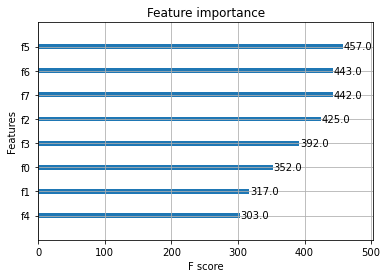

In [65]:
print(xgbModel.feature_importances_)
plot_importance(xgbModel)

### Select 5 best features

In [66]:
# Selecting 5 best features using SelectKBest for training data, and manually for testing data

XtrBest = SelectKBest(score_func=f_classif,k=5).fit_transform(Xtr,ytr)
XtsBest = np.loadtxt(Xts_loadpath, delimiter=",",usecols=(2,3,5,6,7))

Xtr_standardized = XtrBest
Xts_standardized = XtsBest
ytr_standardized = ytr

# save the standardized training data
Xtr_savepath = 'Xtr_xgboost.csv'
Xts_savepath = 'Xts_xgboost.csv'
ytr_savepath = 'ytr_xgboost.csv'
yts_hat_savepath = 'yts_hat_xgboostOptunaFS.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr_standardized, delimiter=",")

# Perform 80:20 train:test split
X_train, X_test, y_train,y_test = train_test_split(Xtr_standardized, ytr_standardized, test_size = 0.2, random_state = random.randint(0,1000))
dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_test,y_test)


In [67]:
# Train a basic XG Boost model with no hyperparameter tuning but with feature selection

xgbModelFS = XGBClassifier()
xgbModelFS.fit(X_train, y_train)
#print(xgb.get_xgb_params())

# Generate train and test AUC scores
aucTrain = roc_auc_score(y_train,xgbModelFS.predict(X_train,output_margin=True))
print('Training AUC: ',aucTrain)

aucTest = roc_auc_score(y_test,xgbModelFS.predict(X_test,output_margin=True))
print('Test AUC: ',aucTest)

Training AUC:  0.9914462976669287
Test AUC:  0.9155584391135972


### Apply Optuna hyperparameter optimization technique

In [68]:
# First, we convert the training and testing data into xgboost optimized matrix for efficiency

dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_test,y_test)


### Create objective function for first level of tuning

In [69]:
def objective(trial):
    Xtr_loadpath = 'Xtr.csv'
    Xts_loadpath = 'Xts.csv'
    ytr_loadpath = 'ytr.csv'

    Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
    Xts = np.loadtxt(Xts_loadpath, delimiter=",")
    ytr = np.loadtxt(ytr_loadpath, delimiter=",")
    
    # Selecting 5 best features
    XtrBest = SelectKBest(score_func=f_classif,k=5).fit_transform(Xtr,ytr)
    
    #Xtr_standardized = scale.fit_transform(Xtr)
    Xtr_standardized = XtrBest
    ytr_standardized = ytr
    (data, target) = Xtr_standardized, ytr_standardized
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.20, random_state = random.randint(0,1000))
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    
    param = {
                'n_estimators' : trial.suggest_int('n_estimators', 100, 200),
                'max_depth':trial.suggest_int('max_depth', 3,6),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,0.8),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.8,1),
                'min_child_weight':trial.suggest_int('min_child_weight',0,1),
                'gamma':trial.suggest_uniform('gamma', 0, 0.2),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.12,0.62),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',1,1),
                'nthread' : -1
    }
            
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


### Call Optuna study object for first level of tuning

In [70]:
study1 = optuna.create_study(direction='maximize',sampler=TPESampler())
study1.optimize(objective, n_trials= 1000,show_progress_bar = True)

[I 2022-12-08 19:30:08,485] A new study created in memory with name: no-name-b13bc1f5-9068-4e0e-b1ef-9b0ba8025477
/Users/utkarsh/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:08,674] Trial 0 finished with value: 0.85 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 0.3145167689777763, 'reg_lambda': 0.9793284395707647, 'min_child_weight': 1, 'gamma': 0.11757795186002871, 'learning_rate': 0.33068829964369195, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.85.
[19:30:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:08,836] Trial 1 finished with value: 0.816 and parameters: {'n_estimators': 166, 'max_depth': 3, 'reg_alpha': 0.4871622727059422, 'reg_lambda': 0.9722763241459459, 'min_child_weight': 0, 'gamma': 0.05889161774670779, 'learning_rate': 0.1604395603938524, 'colsample_bytree': 

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:08,998] Trial 2 finished with value: 0.843 and parameters: {'n_estimators': 163, 'max_depth': 3, 'reg_alpha': 0.6428274559688596, 'reg_lambda': 0.9610393471590729, 'min_child_weight': 1, 'gamma': 0.004966087753555071, 'learning_rate': 0.4229315971969858, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.85.
[19:30:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:09,167] Trial 3 finished with value: 0.8575 and parameters: {'n_estimators': 139, 'max_depth': 5, 'reg_alpha': 0.13838122606909967, 'reg_lambda': 0.9281337689983331, 'min_child_weight': 1, 'gamma': 0.03355545424476958, 'learning_rate': 0.3590533373834259, 'colsample_bytree

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:09,327] Trial 4 finished with value: 0.831 and parameters: {'n_estimators': 137, 'max_depth': 3, 'reg_alpha': 0.7818653434873677, 'reg_lambda': 0.9422711779319672, 'min_child_weight': 1, 'gamma': 0.17627763211170377, 'learning_rate': 0.19313439251302422, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.8575.
[19:30:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:09,508] Trial 5 finished with value: 0.8605 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.67109140050542, 'reg_lambda': 0.9548941139713678, 'min_child_weight': 1, 'gamma': 0.05907322377053695, 'learning_rate': 0.5592072947754425, 'colsample_bytree'

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:09,689] Trial 6 finished with value: 0.8595 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.3172856384453163, 'reg_lambda': 0.9468921685886008, 'min_child_weight': 1, 'gamma': 0.11866921578376777, 'learning_rate': 0.1978024749212907, 'colsample_bytree': 1.0}. Best is trial 5 with value: 0.8605.
[19:30:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:09,852] Trial 7 finished with value: 0.848 and parameters: {'n_estimators': 194, 'max_depth': 3, 'reg_alpha': 0.35448861033218704, 'reg_lambda': 0.9335700411543889, 'min_child_weight': 1, 'gamma': 0.11905572271817982, 'learning_rate': 0.28332488508621934, 'colsample_bytr

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:10,026] Trial 8 finished with value: 0.8645 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.6204458118301517, 'reg_lambda': 0.9125309946010945, 'min_child_weight': 0, 'gamma': 0.19992404303839872, 'learning_rate': 0.1926345861641614, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8645.
[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:10,187] Trial 9 finished with value: 0.844 and parameters: {'n_estimators': 170, 'max_depth': 4, 'reg_alpha': 0.3637960554419326, 'reg_lambda': 0.9542694228727964, 'min_child_weight': 1, 'gamma': 0.18986212201151484, 'learning_rate': 0.18949601218115925, 'colsample_bytre

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:10,364] Trial 10 finished with value: 0.858 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.00368951858980493, 'reg_lambda': 0.8503733015309592, 'min_child_weight': 0, 'gamma': 0.1569806266243704, 'learning_rate': 0.13306806768342744, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8645.
[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:10,549] Trial 11 finished with value: 0.8695 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.60690396182643, 'reg_lambda': 0.8849933420037778, 'min_child_weight': 0, 'gamma': 0.049415640622269524, 'learning_rate': 0.6007710016445466, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:10,733] Trial 12 finished with value: 0.852 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5344620315351695, 'reg_lambda': 0.8702255116256172, 'min_child_weight': 0, 'gamma': 0.08195531883098872, 'learning_rate': 0.6118257825661386, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:10,909] Trial 13 finished with value: 0.851 and parameters: {'n_estimators': 125, 'max_depth': 5, 'reg_alpha': 0.5976571338848771, 'reg_lambda': 0.8912678226178379, 'min_child_weight': 0, 'gamma': 0.14885049899069616, 'learning_rate': 0.2450151871600259, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:11,094] Trial 14 finished with value: 0.8495 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.7744948175564156, 'reg_lambda': 0.8112558800138432, 'min_child_weight': 0, 'gamma': 0.017044727874666182, 'learning_rate': 0.46333397526647385, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:11,275] Trial 15 finished with value: 0.841 and parameters: {'n_estimators': 124, 'max_depth': 5, 'reg_alpha': 0.499572968332029, 'reg_lambda': 0.899162312768994, 'min_child_weight': 0, 'gamma': 0.08557748918525143, 'learning_rate': 0.12323931524327984, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:11,459] Trial 16 finished with value: 0.8595 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.6876023350886232, 'reg_lambda': 0.8446416248976416, 'min_child_weight': 0, 'gamma': 0.05441533487134601, 'learning_rate': 0.24793945815529567, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:11,642] Trial 17 finished with value: 0.86 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.4647806169422622, 'reg_lambda': 0.914986824157685, 'min_child_weight': 0, 'gamma': 0.14186023415272297, 'learning_rate': 0.1558169573823709, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:11,815] Trial 18 finished with value: 0.849 and parameters: {'n_estimators': 129, 'max_depth': 4, 'reg_alpha': 0.5756118194059261, 'reg_lambda': 0.8775690921653452, 'min_child_weight': 0, 'gamma': 0.19553816609685384, 'learning_rate': 0.29188199797961667, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:11,990] Trial 19 finished with value: 0.8605 and parameters: {'n_estimators': 178, 'max_depth': 5, 'reg_alpha': 0.23191486833196417, 'reg_lambda': 0.914252198093145, 'min_child_weight': 0, 'gamma': 0.038223766241562464, 'learning_rate': 0.4761891302183218, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:12,174] Trial 20 finished with value: 0.8695 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.7018148800792424, 'reg_lambda': 0.9947489128055526, 'min_child_weight': 0, 'gamma': 0.08133488942813276, 'learning_rate': 0.22089925665192117, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:12,357] Trial 21 finished with value: 0.8605 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7399893140529666, 'reg_lambda': 0.9946396462210694, 'min_child_weight': 0, 'gamma': 0.0847545015751266, 'learning_rate': 0.2267799510518336, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:12,540] Trial 22 finished with value: 0.851 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.7050669366080898, 'reg_lambda': 0.8027298446707988, 'min_child_weight': 0, 'gamma': 0.09552635173292368, 'learning_rate': 0.21290635279441797, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:12,717] Trial 23 finished with value: 0.8575 and parameters: {'n_estimators': 149, 'max_depth': 5, 'reg_alpha': 0.6111794122713555, 'reg_lambda': 0.8565324714940199, 'min_child_weight': 0, 'gamma': 0.07037335548116369, 'learning_rate': 0.16730643229924638, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:12,898] Trial 24 finished with value: 0.854 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.41765691638912195, 'reg_lambda': 0.9960710048268568, 'min_child_weight': 0, 'gamma': 0.03330984049521431, 'learning_rate': 0.35227423235784844, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:13,261] Trial 25 finished with value: 0.8565 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.5707284321693157, 'reg_lambda': 0.830092389852173, 'min_child_weight': 0, 'gamma': 0.04727768385645235, 'learning_rate': 0.30083218979807913, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:13,437] Trial 26 finished with value: 0.862 and parameters: {'n_estimators': 156, 'max_depth': 5, 'reg_alpha': 0.7192369264827692, 'reg_lambda': 0.885336651916752, 'min_child_weight': 0, 'gamma': 0.10537224588722598, 'learning_rate': 0.2572482436287167, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:13,624] Trial 27 finished with value: 0.8675 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.6426989934228603, 'reg_lambda': 0.9147149904914406, 'min_child_weight': 0, 'gamma': 0.13316185585109266, 'learning_rate': 0.3894038466958787, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:13,803] Trial 28 finished with value: 0.8535 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.5333959412396303, 'reg_lambda': 0.8236237327922818, 'min_child_weight': 0, 'gamma': 0.13524632376189843, 'learning_rate': 0.41103623919034377, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:13,977] Trial 29 finished with value: 0.849 and parameters: {'n_estimators': 128, 'max_depth': 4, 'reg_alpha': 0.6534185186430213, 'reg_lambda': 0.9760193033966444, 'min_child_weight': 0, 'gamma': 0.13031432709445687, 'learning_rate': 0.5379376423395844, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:14,159] Trial 30 finished with value: 0.865 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.789755325420478, 'reg_lambda': 0.8658143119849264, 'min_child_weight': 0, 'gamma': 0.07252783404868135, 'learning_rate': 0.38881026042425415, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:14,344] Trial 31 finished with value: 0.8555 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.7912851205988911, 'reg_lambda': 0.8681236775715264, 'min_child_weight': 0, 'gamma': 0.07137059542564732, 'learning_rate': 0.39096778832672413, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:14,532] Trial 32 finished with value: 0.851 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.7398476151348331, 'reg_lambda': 0.862407541267797, 'min_child_weight': 0, 'gamma': 0.10290566477098412, 'learning_rate': 0.33163312992892924, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:14,723] Trial 33 finished with value: 0.8585 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.6680654094110089, 'reg_lambda': 0.8377037960094484, 'min_child_weight': 0, 'gamma': 0.06923449299935132, 'learning_rate': 0.5030790649925699, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:14,910] Trial 34 finished with value: 0.8615 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.7372522561151086, 'reg_lambda': 0.9005689223204156, 'min_child_weight': 0, 'gamma': 0.010341145361896717, 'learning_rate': 0.4432089729422846, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:15,090] Trial 35 finished with value: 0.8575 and parameters: {'n_estimators': 157, 'max_depth': 5, 'reg_alpha': 0.7906477099572604, 'reg_lambda': 0.967030475872614, 'min_child_weight': 0, 'gamma': 0.1595849242885131, 'learning_rate': 0.38273949825249765, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:15,273] Trial 36 finished with value: 0.8585 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.6408244402935681, 'reg_lambda': 0.8810160410487278, 'min_child_weight': 0, 'gamma': 0.10891770770565984, 'learning_rate': 0.6075233461322179, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:15,460] Trial 37 finished with value: 0.868 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.4390357370947192, 'reg_lambda': 0.9001260158159744, 'min_child_weight': 0, 'gamma': 0.028059338237010283, 'learning_rate': 0.3136180615252791, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:15,640] Trial 38 finished with value: 0.854 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.42066438883135326, 'reg_lambda': 0.9294896791022844, 'min_child_weight': 1, 'gamma': 0.02221835604183252, 'learning_rate': 0.2982655267940234, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:15,808] Trial 39 finished with value: 0.8605 and parameters: {'n_estimators': 124, 'max_depth': 3, 'reg_alpha': 0.27294461618669597, 'reg_lambda': 0.9869191444689616, 'min_child_weight': 1, 'gamma': 0.04466324883832082, 'learning_rate': 0.33122573187607407, 'colsample_bytree': 1.0}. Best is trial 11 with value: 0.8695.
[19:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:15,991] Trial 40 finished with value: 0.8605 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.49015912773582354, 'reg_lambda': 0.9041098228641011, 'min_child_weight': 0, 'gamma': 0.0024905212644156377, 'learning_rate': 0.2642859063638524, 'colsamp

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:16,178] Trial 41 finished with value: 0.8725 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5529401141780398, 'reg_lambda': 0.8899325526282537, 'min_child_weight': 0, 'gamma': 0.05738300352697554, 'learning_rate': 0.3557775254308829, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:16,366] Trial 42 finished with value: 0.864 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.5647068871455887, 'reg_lambda': 0.9230612694480789, 'min_child_weight': 0, 'gamma': 0.02832512232571525, 'learning_rate': 0.3170417431513127, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:16,549] Trial 43 finished with value: 0.858 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.4627592141046486, 'reg_lambda': 0.9436777541910623, 'min_child_weight': 0, 'gamma': 0.05647474602451673, 'learning_rate': 0.2265368824275321, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:16,736] Trial 44 finished with value: 0.868 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5239950904638863, 'reg_lambda': 0.8910061100826256, 'min_child_weight': 0, 'gamma': 0.04550821608258612, 'learning_rate': 0.35156256901399674, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:16,924] Trial 45 finished with value: 0.866 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.5197458232222467, 'reg_lambda': 0.891784392972671, 'min_child_weight': 0, 'gamma': 0.043841967278784984, 'learning_rate': 0.35443353720694165, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:17,109] Trial 46 finished with value: 0.8715 and parameters: {'n_estimators': 194, 'max_depth': 6, 'reg_alpha': 0.3744532779026063, 'reg_lambda': 0.8772534396565387, 'min_child_weight': 0, 'gamma': 0.0628852346464734, 'learning_rate': 0.17431493257954467, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:17,293] Trial 47 finished with value: 0.8425 and parameters: {'n_estimators': 194, 'max_depth': 6, 'reg_alpha': 0.38030478221465724, 'reg_lambda': 0.8783529716238372, 'min_child_weight': 0, 'gamma': 0.06150737720572104, 'learning_rate': 0.17522241322984944, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:17,474] Trial 48 finished with value: 0.8575 and parameters: {'n_estimators': 200, 'max_depth': 5, 'reg_alpha': 0.3354993482906646, 'reg_lambda': 0.8901262575431175, 'min_child_weight': 1, 'gamma': 0.08979826715901848, 'learning_rate': 0.20554425776979612, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:17,657] Trial 49 finished with value: 0.839 and parameters: {'n_estimators': 183, 'max_depth': 6, 'reg_alpha': 0.18114778717161817, 'reg_lambda': 0.872582389530624, 'min_child_weight': 0, 'gamma': 0.07894452215769496, 'learning_rate': 0.18062790437661902, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:17,837] Trial 50 finished with value: 0.8535 and parameters: {'n_estimators': 166, 'max_depth': 5, 'reg_alpha': 0.4231699020516602, 'reg_lambda': 0.8548767769293563, 'min_child_weight': 0, 'gamma': 0.06161875809710524, 'learning_rate': 0.14801542482278465, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:18,026] Trial 51 finished with value: 0.864 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.45533785039342134, 'reg_lambda': 0.9067822811981295, 'min_child_weight': 0, 'gamma': 0.04922506406321766, 'learning_rate': 0.277060932601291, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:18,210] Trial 52 finished with value: 0.8645 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.28242613789019666, 'reg_lambda': 0.8944064058095502, 'min_child_weight': 0, 'gamma': 0.026747663052090642, 'learning_rate': 0.14069364154480798, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:18,399] Trial 53 finished with value: 0.8625 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.5949681799466509, 'reg_lambda': 0.9558151456817235, 'min_child_weight': 0, 'gamma': 0.03819778536592581, 'learning_rate': 0.2374233211719405, 'colsample_bytree': 1.0}. Best is trial 41 with value: 0.8725.
[19:30:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:18,589] Trial 54 finished with value: 0.873 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5497616721689593, 'reg_lambda': 0.8857489367386729, 'min_child_weight': 0, 'gamma': 0.053350847690413344, 'learning_rate': 0.3166800519124783, 'colsample_bytree': 1.0}. Best is trial 54 with value: 0.873.
[19:30:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:18,775] Trial 55 finished with value: 0.858 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.5363205257195006, 'reg_lambda': 0.8845472381862534, 'min_child_weight': 0, 'gamma': 0.06503434174471617, 'learning_rate': 0.2714336507093259, 'colsample_bytree': 1.0}. Best is trial 54 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:18,961] Trial 56 finished with value: 0.857 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.3684930300293543, 'reg_lambda': 0.9224809743294947, 'min_child_weight': 0, 'gamma': 0.05425311914614624, 'learning_rate': 0.2075605701263657, 'colsample_bytree': 1.0}. Best is trial 54 with value: 0.873.
[19:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:19,148] Trial 57 finished with value: 0.878 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5538695500848397, 'reg_lambda': 0.8736256429398841, 'min_child_weight': 0, 'gamma': 0.07631796189408971, 'learning_rate': 0.4252004726877662, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:19,330] Trial 58 finished with value: 0.8505 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6947400501022236, 'reg_lambda': 0.8596535839167709, 'min_child_weight': 0, 'gamma': 0.07886991385416199, 'learning_rate': 0.5480438560874027, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:19,514] Trial 59 finished with value: 0.8665 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.618407826578573, 'reg_lambda': 0.8763382578099644, 'min_child_weight': 0, 'gamma': 0.09547257275274201, 'learning_rate': 0.4248785908049897, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:19,688] Trial 60 finished with value: 0.8565 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.007165178319195831, 'reg_lambda': 0.872382054813454, 'min_child_weight': 0, 'gamma': 0.11292711117750935, 'learning_rate': 0.4900835134018886, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:19,869] Trial 61 finished with value: 0.862 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5555321112685632, 'reg_lambda': 0.8453707345957157, 'min_child_weight': 0, 'gamma': 0.011663948946263245, 'learning_rate': 0.30103402822413466, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:20,053] Trial 62 finished with value: 0.8605 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5011768193274687, 'reg_lambda': 0.9375639818021615, 'min_child_weight': 0, 'gamma': 0.052875580326285455, 'learning_rate': 0.31700148913521836, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:20,250] Trial 63 finished with value: 0.856 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5918588496551466, 'reg_lambda': 0.8872162769172406, 'min_child_weight': 0, 'gamma': 0.07822076585761491, 'learning_rate': 0.3393723374357861, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:20,495] Trial 64 finished with value: 0.85 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.6319179880122, 'reg_lambda': 0.907457301485896, 'min_child_weight': 0, 'gamma': 0.039747400620773504, 'learning_rate': 0.4544277975573703, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:20,690] Trial 65 finished with value: 0.8595 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.5120634882103876, 'reg_lambda': 0.8961576876519161, 'min_child_weight': 0, 'gamma': 0.06536140855165279, 'learning_rate': 0.5178847103048136, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:20,878] Trial 66 finished with value: 0.8525 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.4676971709016116, 'reg_lambda': 0.850564112978917, 'min_child_weight': 0, 'gamma': 0.09075187229511729, 'learning_rate': 0.36964287599062123, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:21,063] Trial 67 finished with value: 0.874 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.54750326831596, 'reg_lambda': 0.8825993515063729, 'min_child_weight': 0, 'gamma': 0.07461768776420455, 'learning_rate': 0.4153858015945926, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:21,247] Trial 68 finished with value: 0.8745 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6676886401858085, 'reg_lambda': 0.8837616468238242, 'min_child_weight': 0, 'gamma': 0.07562340281506402, 'learning_rate': 0.5792218004740376, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:21,426] Trial 69 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.5480948148087997, 'reg_lambda': 0.8674417317682379, 'min_child_weight': 0, 'gamma': 0.0742103147929917, 'learning_rate': 0.586568294069269, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:21,608] Trial 70 finished with value: 0.861 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.676300106807574, 'reg_lambda': 0.8811083457473554, 'min_child_weight': 0, 'gamma': 0.06010075728294177, 'learning_rate': 0.5705897288231552, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:21,784] Trial 71 finished with value: 0.863 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 0.5869537497145646, 'reg_lambda': 0.8853992020952816, 'min_child_weight': 0, 'gamma': 0.08544989699705355, 'learning_rate': 0.41707777681739105, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:21,967] Trial 72 finished with value: 0.855 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.654267655896551, 'reg_lambda': 0.8745116952504004, 'min_child_weight': 0, 'gamma': 0.06766473097986457, 'learning_rate': 0.5248770510748941, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:22,150] Trial 73 finished with value: 0.8685 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.7629844883509814, 'reg_lambda': 0.9102741055901487, 'min_child_weight': 0, 'gamma': 0.09823453271159469, 'learning_rate': 0.48256947869563327, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:22,329] Trial 74 finished with value: 0.853 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6133700965845378, 'reg_lambda': 0.8620941572657721, 'min_child_weight': 0, 'gamma': 0.07658809059024696, 'learning_rate': 0.6126595223667284, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:22,503] Trial 75 finished with value: 0.8495 and parameters: {'n_estimators': 160, 'max_depth': 4, 'reg_alpha': 0.7129620578967656, 'reg_lambda': 0.8812491575414542, 'min_child_weight': 0, 'gamma': 0.0918260940402867, 'learning_rate': 0.3711701766433566, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:22,670] Trial 76 finished with value: 0.84 and parameters: {'n_estimators': 173, 'max_depth': 3, 'reg_alpha': 0.38872761252312266, 'reg_lambda': 0.9024223154565802, 'min_child_weight': 0, 'gamma': 0.05216063126762957, 'learning_rate': 0.1228353284365681, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:22,849] Trial 77 finished with value: 0.8525 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 0.6814015802325779, 'reg_lambda': 0.8980908627958202, 'min_child_weight': 0, 'gamma': 0.08393553953800527, 'learning_rate': 0.43533497465830295, 'colsample_byt

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:23,034] Trial 78 finished with value: 0.8545 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5761750917603966, 'reg_lambda': 0.8669025330042273, 'min_child_weight': 0, 'gamma': 0.05797215045204161, 'learning_rate': 0.39843429882105985, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:23,221] Trial 79 finished with value: 0.847 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.484097529786741, 'reg_lambda': 0.9187768775030773, 'min_child_weight': 0, 'gamma': 0.0707550120162665, 'learning_rate': 0.46213041112032727, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:23,405] Trial 80 finished with value: 0.8645 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.6092824892204177, 'reg_lambda': 0.8880507585273657, 'min_child_weight': 1, 'gamma': 0.06538769179637025, 'learning_rate': 0.19170715193165705, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:23,583] Trial 81 finished with value: 0.8545 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.7619297748816907, 'reg_lambda': 0.9102297809007427, 'min_child_weight': 0, 'gamma': 0.11939657070756535, 'learning_rate': 0.4843265686109187, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:23,762] Trial 82 finished with value: 0.856 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.7239935673563744, 'reg_lambda': 0.8756768589959838, 'min_child_weight': 0, 'gamma': 0.09556689572012303, 'learning_rate': 0.5023128972554928, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:23,939] Trial 83 finished with value: 0.847 and parameters: {'n_estimators': 153, 'max_depth': 5, 'reg_alpha': 0.6963109881160747, 'reg_lambda': 0.8804653034079938, 'min_child_weight': 0, 'gamma': 0.07425542575133008, 'learning_rate': 0.5746157903500606, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:24,111] Trial 84 finished with value: 0.861 and parameters: {'n_estimators': 188, 'max_depth': 4, 'reg_alpha': 0.652995336391741, 'reg_lambda': 0.8976304343651792, 'min_child_weight': 0, 'gamma': 0.09847434472336332, 'learning_rate': 0.4078569595221493, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:24,286] Trial 85 finished with value: 0.8625 and parameters: {'n_estimators': 126, 'max_depth': 5, 'reg_alpha': 0.7733969950515427, 'reg_lambda': 0.9997691450040423, 'min_child_weight': 0, 'gamma': 0.08208346169692697, 'learning_rate': 0.5542607507407834, 'colsample_bytre

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:24,471] Trial 86 finished with value: 0.862 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7480196075842446, 'reg_lambda': 0.9884349019542358, 'min_child_weight': 0, 'gamma': 0.10251080352635011, 'learning_rate': 0.44246961732390416, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:24,656] Trial 87 finished with value: 0.861 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.6343137995006862, 'reg_lambda': 0.9633104570274743, 'min_child_weight': 0, 'gamma': 0.0493094538196284, 'learning_rate': 0.5202825069206543, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:24,846] Trial 88 finished with value: 0.8715 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.344205657888302, 'reg_lambda': 0.8932910271319955, 'min_child_weight': 0, 'gamma': 0.08910947468991814, 'learning_rate': 0.3725085893261342, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:25,030] Trial 89 finished with value: 0.863 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.3377959787112104, 'reg_lambda': 0.8907629791686088, 'min_child_weight': 0, 'gamma': 0.035292196997394845, 'learning_rate': 0.1665816119093123, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:25,217] Trial 90 finished with value: 0.868 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.2948617687718415, 'reg_lambda': 0.884797681371088, 'min_child_weight': 0, 'gamma': 0.06252301872113752, 'learning_rate': 0.28997246373512214, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:25,400] Trial 91 finished with value: 0.8575 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.25797007735608457, 'reg_lambda': 0.8940913234856673, 'min_child_weight': 0, 'gamma': 0.08128317569003575, 'learning_rate': 0.3691653522486279, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:25,586] Trial 92 finished with value: 0.854 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.34792335620809645, 'reg_lambda': 0.8714844736814132, 'min_child_weight': 0, 'gamma': 0.08646002386337713, 'learning_rate': 0.3425433627607485, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:25,774] Trial 93 finished with value: 0.855 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.32057264567614197, 'reg_lambda': 0.8635861755637309, 'min_child_weight': 0, 'gamma': 0.10929102399445821, 'learning_rate': 0.5912426072990938, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:25,960] Trial 94 finished with value: 0.8615 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5387412786775778, 'reg_lambda': 0.8574097729597288, 'min_child_weight': 0, 'gamma': 0.08809176547044564, 'learning_rate': 0.40086860372100297, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:26,148] Trial 95 finished with value: 0.872 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.39662565315273446, 'reg_lambda': 0.8781895281338813, 'min_child_weight': 0, 'gamma': 0.06966778980617873, 'learning_rate': 0.47030424567563983, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:26,331] Trial 96 finished with value: 0.8585 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.366018849833167, 'reg_lambda': 0.879317535963731, 'min_child_weight': 0, 'gamma': 0.057231543601392355, 'learning_rate': 0.4253621312778386, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:26,523] Trial 97 finished with value: 0.863 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.413929655561902, 'reg_lambda': 0.8836991577381978, 'min_child_weight': 0, 'gamma': 0.07129618315926613, 'learning_rate': 0.384919781171911, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:26,715] Trial 98 finished with value: 0.8565 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.39825071130947176, 'reg_lambda': 0.8706987278666718, 'min_child_weight': 0, 'gamma': 0.04241711911046167, 'learning_rate': 0.2198088134227396, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:26,900] Trial 99 finished with value: 0.8495 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.5732263097628847, 'reg_lambda': 0.8936324245353472, 'min_child_weight': 0, 'gamma': 0.06778397190576436, 'learning_rate': 0.3109559596220555, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:27,085] Trial 100 finished with value: 0.8505 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.4347154775612868, 'reg_lambda': 0.9038151512314172, 'min_child_weight': 0, 'gamma': 0.0755949448321285, 'learning_rate': 0.18018568587516995, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:27,271] Trial 101 finished with value: 0.8615 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6650359892109662, 'reg_lambda': 0.8887639787612374, 'min_child_weight': 0, 'gamma': 0.050769733839086534, 'learning_rate': 0.4569438766482159, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:27,458] Trial 102 finished with value: 0.8705 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5518122393363629, 'reg_lambda': 0.8778367148894257, 'min_child_weight': 0, 'gamma': 0.09181519962033545, 'learning_rate': 0.3672047844251861, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:27,644] Trial 103 finished with value: 0.8485 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5497626583162466, 'reg_lambda': 0.8755793249152533, 'min_child_weight': 0, 'gamma': 0.08097743709626035, 'learning_rate': 0.34371786586263536, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:27,878] Trial 104 finished with value: 0.8585 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5042810858687751, 'reg_lambda': 0.8696975495007735, 'min_child_weight': 0, 'gamma': 0.09318312085531756, 'learning_rate': 0.3608711578300971, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:28,064] Trial 105 finished with value: 0.868 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.4455688456769731, 'reg_lambda': 0.8771703704611046, 'min_child_weight': 0, 'gamma': 0.06309615304620272, 'learning_rate': 0.3805330728364369, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:28,244] Trial 106 finished with value: 0.874 and parameters: {'n_estimators': 136, 'max_depth': 5, 'reg_alpha': 0.4817795215281915, 'reg_lambda': 0.8820026732258616, 'min_child_weight': 0, 'gamma': 0.18102772920455157, 'learning_rate': 0.32949965188950237, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:28,424] Trial 107 finished with value: 0.849 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 0.4844876277178104, 'reg_lambda': 0.8830533043488833, 'min_child_weight': 0, 'gamma': 0.18071781814498283, 'learning_rate': 0.25132554227256393, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:28,610] Trial 108 finished with value: 0.862 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.5237762746844759, 'reg_lambda': 0.886794178235965, 'min_child_weight': 0, 'gamma': 0.05518371862218395, 'learning_rate': 0.3254493385184412, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:28,792] Trial 109 finished with value: 0.856 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.40762839082066593, 'reg_lambda': 0.8529895358173827, 'min_child_weight': 0, 'gamma': 0.14783718329905055, 'learning_rate': 0.3586883112349397, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:28,971] Trial 110 finished with value: 0.871 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5629952205584411, 'reg_lambda': 0.8642858410174636, 'min_child_weight': 0, 'gamma': 0.1658456702945905, 'learning_rate': 0.32706500619077444, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:29,153] Trial 111 finished with value: 0.8715 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5709285367838665, 'reg_lambda': 0.8646801550211384, 'min_child_weight': 0, 'gamma': 0.17181394081428822, 'learning_rate': 0.3315896482993956, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:29,333] Trial 112 finished with value: 0.856 and parameters: {'n_estimators': 135, 'max_depth': 5, 'reg_alpha': 0.5611878886411354, 'reg_lambda': 0.864423486983558, 'min_child_weight': 0, 'gamma': 0.1641202928114864, 'learning_rate': 0.3274419028934999, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:29,513] Trial 113 finished with value: 0.862 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.585301797035189, 'reg_lambda': 0.868090904239107, 'min_child_weight': 0, 'gamma': 0.18393904740972772, 'learning_rate': 0.31083393162226236, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:29,691] Trial 114 finished with value: 0.8555 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.5373758138550914, 'reg_lambda': 0.8598414297433453, 'min_child_weight': 0, 'gamma': 0.17316564608068702, 'learning_rate': 0.33857680838990395, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:29,868] Trial 115 finished with value: 0.847 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.38026565648025734, 'reg_lambda': 0.8778651899878829, 'min_child_weight': 0, 'gamma': 0.17196523226099497, 'learning_rate': 0.2888127897588522, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:30,045] Trial 116 finished with value: 0.855 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.4763019096101111, 'reg_lambda': 0.8448587882564705, 'min_child_weight': 0, 'gamma': 0.1601039917973832, 'learning_rate': 0.12880578507734014, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:30,228] Trial 117 finished with value: 0.8565 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.5139411607512132, 'reg_lambda': 0.8737961558669294, 'min_child_weight': 0, 'gamma': 0.1970629250163477, 'learning_rate': 0.35101930139679227, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:30,410] Trial 118 finished with value: 0.858 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.5631127806810103, 'reg_lambda': 0.8807071148499158, 'min_child_weight': 0, 'gamma': 0.19159001177713952, 'learning_rate': 0.3717118193994388, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:30,597] Trial 119 finished with value: 0.8565 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 0.6032037334609175, 'reg_lambda': 0.890672994757497, 'min_child_weight': 1, 'gamma': 0.18750569828890734, 'learning_rate': 0.3013890947906567, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:30,815] Trial 120 finished with value: 0.8595 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 0.4981265791253885, 'reg_lambda': 0.8588765838942128, 'min_child_weight': 0, 'gamma': 0.1803729794905863, 'learning_rate': 0.41420454235511783, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:30,996] Trial 121 finished with value: 0.8545 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.6291205376308175, 'reg_lambda': 0.8961702408372416, 'min_child_weight': 0, 'gamma': 0.16761110113000513, 'learning_rate': 0.3248273475338786, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:31,176] Trial 122 finished with value: 0.8645 and parameters: {'n_estimators': 145, 'max_depth': 5, 'reg_alpha': 0.5852770851659035, 'reg_lambda': 0.8727301101566408, 'min_child_weight': 0, 'gamma': 0.07700031820523741, 'learning_rate': 0.39330413157434885, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:31,356] Trial 123 finished with value: 0.8595 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 0.5285172751494869, 'reg_lambda': 0.886528699813562, 'min_child_weight': 0, 'gamma': 0.15250597664313545, 'learning_rate': 0.37886393461221735, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:31,523] Trial 124 finished with value: 0.847 and parameters: {'n_estimators': 130, 'max_depth': 3, 'reg_alpha': 0.5472301391367185, 'reg_lambda': 0.8663913738845699, 'min_child_weight': 0, 'gamma': 0.05924601756424937, 'learning_rate': 0.4284804989682013, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:31,700] Trial 125 finished with value: 0.8545 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.45615767137025864, 'reg_lambda': 0.8998498115587461, 'min_child_weight': 0, 'gamma': 0.06854273086602297, 'learning_rate': 0.28128559073742576, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:31,895] Trial 126 finished with value: 0.859 and parameters: {'n_estimators': 115, 'max_depth': 4, 'reg_alpha': 0.60406976089484, 'reg_lambda': 0.8821170244726425, 'min_child_weight': 0, 'gamma': 0.07272997350824287, 'learning_rate': 0.36234768363665, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:32,084] Trial 127 finished with value: 0.856 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.569362575184204, 'reg_lambda': 0.892203998128779, 'min_child_weight': 0, 'gamma': 0.17587339312941525, 'learning_rate': 0.26929338003065423, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:32,289] Trial 128 finished with value: 0.855 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.308504384956713, 'reg_lambda': 0.8770896733210807, 'min_child_weight': 0, 'gamma': 0.08811506025559626, 'learning_rate': 0.33629270846787596, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:32,495] Trial 129 finished with value: 0.8625 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.35857376503130517, 'reg_lambda': 0.8697216635158445, 'min_child_weight': 0, 'gamma': 0.046057927541708454, 'learning_rate': 0.538710137288533, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:32,691] Trial 130 finished with value: 0.864 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.39216032065502165, 'reg_lambda': 0.8545529794117759, 'min_child_weight': 0, 'gamma': 0.08475506461026902, 'learning_rate': 0.34541448427663457, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:32,887] Trial 131 finished with value: 0.8515 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.6240913598153319, 'reg_lambda': 0.8837671938115677, 'min_child_weight': 0, 'gamma': 0.06666666871340927, 'learning_rate': 0.16003593611089315, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.
[19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:33,078] Trial 132 finished with value: 0.8435 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5557915425014288, 'reg_lambda': 0.8892752506906614, 'min_child_weight': 0, 'gamma': 0.08067589926714275, 'learning_rate': 0.6055830879126005, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:33,279] Trial 133 finished with value: 0.8585 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5812699673315452, 'reg_lambda': 0.8624238635375518, 'min_child_weight': 0, 'gamma': 0.07513150515595476, 'learning_rate': 0.3190972641289149, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:33,508] Trial 134 finished with value: 0.862 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5118085286660627, 'reg_lambda': 0.8800648959492272, 'min_child_weight': 0, 'gamma': 0.12454907022343753, 'learning_rate': 0.2381867483256246, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:33,739] Trial 135 finished with value: 0.8505 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.5974717761311091, 'reg_lambda': 0.8741998409289425, 'min_child_weight': 0, 'gamma': 0.06140922689848459, 'learning_rate': 0.3076899513255062, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:33,938] Trial 136 finished with value: 0.856 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5299330459618092, 'reg_lambda': 0.8859976820932052, 'min_child_weight': 0, 'gamma': 0.07824385937571195, 'learning_rate': 0.40216949861319146, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:34,160] Trial 137 finished with value: 0.8565 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.4253031852932778, 'reg_lambda': 0.9502402410056242, 'min_child_weight': 0, 'gamma': 0.07046358943578358, 'learning_rate': 0.14718004493660353, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:34,381] Trial 138 finished with value: 0.8655 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.649105119438607, 'reg_lambda': 0.8952219206526164, 'min_child_weight': 0, 'gamma': 0.10644391387719492, 'learning_rate': 0.5038887982469152, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:34,641] Trial 139 finished with value: 0.87 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.5456829222316674, 'reg_lambda': 0.9736315568679501, 'min_child_weight': 0, 'gamma': 0.05519281527370622, 'learning_rate': 0.4474033649479598, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:34,908] Trial 140 finished with value: 0.8615 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.5446499050369695, 'reg_lambda': 0.9850714502026365, 'min_child_weight': 0, 'gamma': 0.055287056165763196, 'learning_rate': 0.43411680667187236, 'colsample_bytree': 1.0}. Best is trial 57 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:35,150] Trial 141 finished with value: 0.8795 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.5638081915240688, 'reg_lambda': 0.9743696974918055, 'min_child_weight': 0, 'gamma': 0.04901154013808719, 'learning_rate': 0.4682494918875512, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:30:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:35,348] Trial 142 finished with value: 0.8465 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.5633678994104231, 'reg_lambda': 0.9661640293945835, 'min_child_weight': 0, 'gamma': 0.0648524943279566, 'learning_rate': 0.4687727371359693, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:35,552] Trial 143 finished with value: 0.851 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.5754032148987778, 'reg_lambda': 0.9800291209674743, 'min_child_weight': 0, 'gamma': 0.04915299422264883, 'learning_rate': 0.4389100686540499, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:35,756] Trial 144 finished with value: 0.8515 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.5499627413944315, 'reg_lambda': 0.8764740028832823, 'min_child_weight': 0, 'gamma': 0.04138945364272435, 'learning_rate': 0.47752056403763504, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:35,944] Trial 145 finished with value: 0.8555 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.3312418803767911, 'reg_lambda': 0.9790764388083586, 'min_child_weight': 0, 'gamma': 0.051791368408126814, 'learning_rate': 0.4515975327339189, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:36,134] Trial 146 finished with value: 0.8605 and parameters: {'n_estimators': 199, 'max_depth': 5, 'reg_alpha': 0.6105663112905977, 'reg_lambda': 0.9750846753888117, 'min_child_weight': 0, 'gamma': 0.03456140081445092, 'learning_rate': 0.5705850443586475, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:30:36,341] Trial 147 finished with value: 0.865 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.059028584585208155, 'reg_lambda': 0.9889521062901705, 'min_child_weight': 0, 'gamma': 0.09104503696714629, 'learning_rate': 0.35261830059866506, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:36,558] Trial 148 finished with value: 0.8635 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.49868782595918637, 'reg_lambda': 0.9935344034499639, 'min_child_weight': 0, 'gamma': 0.16771488947862856, 'learning_rate': 0.415375648259926, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:36,830] Trial 149 finished with value: 0.864 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.53593800621946, 'reg_lambda': 0.818980959843269, 'min_child_weight': 0, 'gamma': 0.059189334545566574, 'learning_rate': 0.49286208403332427, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:37,118] Trial 150 finished with value: 0.8655 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.5690593302575986, 'reg_lambda': 0.8698026295691876, 'min_child_weight': 0, 'gamma': 0.05733143526752682, 'learning_rate': 0.3945742931235841, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:37,332] Trial 151 finished with value: 0.8675 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7067174229643672, 'reg_lambda': 0.9588457785931459, 'min_child_weight': 0, 'gamma': 0.08410054704004047, 'learning_rate': 0.4610916161050517, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:37,542] Trial 152 finished with value: 0.854 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.5964179613952552, 'reg_lambda': 0.9350995363627823, 'min_child_weight': 0, 'gamma': 0.05395683848092297, 'learning_rate': 0.20399599026631376, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:37,731] Trial 153 finished with value: 0.8575 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5213867293529592, 'reg_lambda': 0.8806167425256953, 'min_child_weight': 0, 'gamma': 0.09916958672503096, 'learning_rate': 0.3765417809777857, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:30:37,928] Trial 154 finished with value: 0.8685 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.6643905217497234, 'reg_lambda': 0.8868781968309318, 'min_child_weight': 0, 'gamma': 0.07099082559155705, 'learning_rate': 0.3367052808192061, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:38,231] Trial 155 finished with value: 0.8655 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.5548331401089762, 'reg_lambda': 0.9727730567914791, 'min_child_weight': 0, 'gamma': 0.046915123846764634, 'learning_rate': 0.33041368569016666, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:38,426] Trial 156 finished with value: 0.87 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.3460667662996267, 'reg_lambda': 0.9697553426610009, 'min_child_weight': 0, 'gamma': 0.06431940273224554, 'learning_rate': 0.44648951787219077, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:30:38,618] Trial 157 finished with value: 0.869 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.36764727121812824, 'reg_lambda': 0.9655947577105191, 'min_child_weight': 0, 'gamma': 0.06289133637331003, 'learning_rate': 0.42059545279427624, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:38,813] Trial 158 finished with value: 0.8535 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.3469008344739991, 'reg_lambda': 0.9816172602542896, 'min_child_weight': 0, 'gamma': 0.06682935334905733, 'learning_rate': 0.4511316939221336, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:39,004] Trial 159 finished with value: 0.8585 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.3796429079756518, 'reg_lambda': 0.9718004801132094, 'min_child_weight': 0, 'gamma': 0.044678408712054515, 'learning_rate': 0.5108352578524017, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:39,185] Trial 160 finished with value: 0.8695 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.583810163124137, 'reg_lambda': 0.8654378947855529, 'min_child_weight': 0, 'gamma': 0.1798946011060991, 'learning_rate': 0.3615529824277272, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:39,368] Trial 161 finished with value: 0.857 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.5803291250292012, 'reg_lambda': 0.8645194935156993, 'min_child_weight': 0, 'gamma': 0.18108595377171022, 'learning_rate': 0.36561370517903663, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:39,549] Trial 162 finished with value: 0.8605 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 0.6181165136377491, 'reg_lambda': 0.9697570651541753, 'min_child_weight': 0, 'gamma': 0.18681419441009317, 'learning_rate': 0.40635760422087486, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:39,730] Trial 163 finished with value: 0.856 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.31112897192452504, 'reg_lambda': 0.8734674756334108, 'min_child_weight': 0, 'gamma': 0.1767748980798035, 'learning_rate': 0.3536930658549045, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.
[19:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:39,909] Trial 164 finished with value: 0.849 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.5156298410575486, 'reg_lambda': 0.9520380023485845, 'min_child_weight': 0, 'gamma': 0.1917717171171591, 'learning_rate': 0.3899248437083749, 'colsample_bytree': 1.0}. Best is trial 141 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:40,107] Trial 165 finished with value: 0.88 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7274067269212948, 'reg_lambda': 0.9599089691529156, 'min_child_weight': 1, 'gamma': 0.07225020130321079, 'learning_rate': 0.4729333840015796, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:40,298] Trial 166 finished with value: 0.862 and parameters: {'n_estimators': 186, 'max_depth': 6, 'reg_alpha': 0.7272011403919464, 'reg_lambda': 0.9752089338852994, 'min_child_weight': 0, 'gamma': 0.07869831157363216, 'learning_rate': 0.46504317412503593, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:40,489] Trial 167 finished with value: 0.8675 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7485124759177818, 'reg_lambda': 0.9596134929094213, 'min_child_weight': 1, 'gamma': 0.07421619317028676, 'learning_rate': 0.4756863437055937, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:40,677] Trial 168 finished with value: 0.859 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5425450997092837, 'reg_lambda': 0.8897402839050648, 'min_child_weight': 1, 'gamma': 0.06053685820855291, 'learning_rate': 0.44819394783860056, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:30:40,860] Trial 169 finished with value: 0.8575 and parameters: {'n_estimators': 176, 'max_depth': 4, 'reg_alpha': 0.6892739496994916, 'reg_lambda': 0.9612566155097527, 'min_child_weight': 1, 'gamma': 0.06918523105814865, 'learning_rate': 0.49171309715310896, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:41,045] Trial 170 finished with value: 0.862 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.3514448236681188, 'reg_lambda': 0.8789239748958361, 'min_child_weight': 1, 'gamma': 0.05514220538530655, 'learning_rate': 0.5304136552535814, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:41,232] Trial 171 finished with value: 0.867 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.3253640760862746, 'reg_lambda': 0.9988273557754436, 'min_child_weight': 0, 'gamma': 0.17003577505404321, 'learning_rate': 0.43286741634638604, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:41,411] Trial 172 finished with value: 0.8515 and parameters: {'n_estimators': 124, 'max_depth': 5, 'reg_alpha': 0.5912164730350966, 'reg_lambda': 0.8674626383422921, 'min_child_weight': 0, 'gamma': 0.049626341968773545, 'learning_rate': 0.3484679539104785, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:41,593] Trial 173 finished with value: 0.859 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.40695584595220347, 'reg_lambda': 0.9825564051003486, 'min_child_weight': 0, 'gamma': 0.0937961597715502, 'learning_rate': 0.32077890586560653, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:41,780] Trial 174 finished with value: 0.861 and parameters: {'n_estimators': 147, 'max_depth': 5, 'reg_alpha': 0.5640332646384728, 'reg_lambda': 0.9693424429997546, 'min_child_weight': 0, 'gamma': 0.08784013585784196, 'learning_rate': 0.3800133090260728, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:41,969] Trial 175 finished with value: 0.8555 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5302200107470292, 'reg_lambda': 0.991906489860658, 'min_child_weight': 1, 'gamma': 0.08256570718046777, 'learning_rate': 0.5914929183120974, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:42,162] Trial 176 finished with value: 0.8605 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.708865272510933, 'reg_lambda': 0.8845545836441285, 'min_child_weight': 0, 'gamma': 0.06288577741748985, 'learning_rate': 0.29767500100204036, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:42,352] Trial 177 finished with value: 0.8605 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.6752657404422905, 'reg_lambda': 0.8944965930748999, 'min_child_weight': 0, 'gamma': 0.07274109371916555, 'learning_rate': 0.4440165675977502, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:42,541] Trial 178 finished with value: 0.86 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.3809182689735401, 'reg_lambda': 0.8834622370024048, 'min_child_weight': 0, 'gamma': 0.03886439622201033, 'learning_rate': 0.5561698858512341, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:42,724] Trial 179 finished with value: 0.849 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 0.5759949255657627, 'reg_lambda': 0.8610319863295809, 'min_child_weight': 0, 'gamma': 0.06515575107106326, 'learning_rate': 0.3645379116945237, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:42,904] Trial 180 finished with value: 0.8575 and parameters: {'n_estimators': 192, 'max_depth': 5, 'reg_alpha': 0.7286145693664918, 'reg_lambda': 0.8507409988500679, 'min_child_weight': 0, 'gamma': 0.16398402307171944, 'learning_rate': 0.19704938224708302, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:43,090] Trial 181 finished with value: 0.8635 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5519429190461678, 'reg_lambda': 0.9437400381352468, 'min_child_weight': 0, 'gamma': 0.1764457024380489, 'learning_rate': 0.341434127862641, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:43,272] Trial 182 finished with value: 0.85 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 0.5619862926535583, 'reg_lambda': 0.8721952460603154, 'min_child_weight': 0, 'gamma': 0.07529893635003733, 'learning_rate': 0.18672312053066356, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:43,460] Trial 183 finished with value: 0.8665 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.5827675735713695, 'reg_lambda': 0.875847656914082, 'min_child_weight': 0, 'gamma': 0.057007250044414176, 'learning_rate': 0.41895361405832066, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:43,646] Trial 184 finished with value: 0.865 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.6403051180244504, 'reg_lambda': 0.976919290298333, 'min_child_weight': 0, 'gamma': 0.18346852704921263, 'learning_rate': 0.3294273758190329, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:43,829] Trial 185 finished with value: 0.8535 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 0.6010245011782314, 'reg_lambda': 0.880673573154219, 'min_child_weight': 0, 'gamma': 0.13775659522405337, 'learning_rate': 0.2201006370082934, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:44,016] Trial 186 finished with value: 0.8665 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5305172421130898, 'reg_lambda': 0.8906797784510193, 'min_child_weight': 0, 'gamma': 0.06909967811530397, 'learning_rate': 0.4784820517813113, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:44,202] Trial 187 finished with value: 0.866 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5442423047535021, 'reg_lambda': 0.8653077904707225, 'min_child_weight': 0, 'gamma': 0.05125958261683594, 'learning_rate': 0.3168547669878568, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:44,388] Trial 188 finished with value: 0.853 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.397340099327445, 'reg_lambda': 0.8781835374969552, 'min_child_weight': 0, 'gamma': 0.07857460942976519, 'learning_rate': 0.6194164029798582, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:44,572] Trial 189 finished with value: 0.869 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.4752470124085743, 'reg_lambda': 0.8877223733129828, 'min_child_weight': 0, 'gamma': 0.08254526783716008, 'learning_rate': 0.4084050970455862, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:44,761] Trial 190 finished with value: 0.867 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.3379202638452652, 'reg_lambda': 0.8987427868673105, 'min_child_weight': 0, 'gamma': 0.060720633274074176, 'learning_rate': 0.26041469171064435, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:44,945] Trial 191 finished with value: 0.8535 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.37177709496870165, 'reg_lambda': 0.963325650494872, 'min_child_weight': 0, 'gamma': 0.06356068121223907, 'learning_rate': 0.43179364077134813, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:45,124] Trial 192 finished with value: 0.866 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.47393798445229907, 'reg_lambda': 0.8863981913128371, 'min_child_weight': 0, 'gamma': 0.08350530946704404, 'learning_rate': 0.3732129546962575, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:45,303] Trial 193 finished with value: 0.8545 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.3711332332005676, 'reg_lambda': 0.9675510973461903, 'min_child_weight': 0, 'gamma': 0.0656568784508258, 'learning_rate': 0.42704845683087816, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:45,483] Trial 194 finished with value: 0.856 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.4954774951486784, 'reg_lambda': 0.8821892319532758, 'min_child_weight': 0, 'gamma': 0.0895369206943183, 'learning_rate': 0.4057103474620123, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:45,663] Trial 195 finished with value: 0.854 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.5666544702917916, 'reg_lambda': 0.8885257242123916, 'min_child_weight': 0, 'gamma': 0.08043972344778232, 'learning_rate': 0.4632748495300376, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:45,843] Trial 196 finished with value: 0.8565 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 0.3011503096693537, 'reg_lambda': 0.9654655680546477, 'min_child_weight': 0, 'gamma': 0.058579936951542184, 'learning_rate': 0.3574724848012187, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:46,023] Trial 197 finished with value: 0.8675 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.35658181254451043, 'reg_lambda': 0.8701394715647205, 'min_child_weight': 0, 'gamma': 0.07300311564915547, 'learning_rate': 0.42411457694095134, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:46,205] Trial 198 finished with value: 0.8565 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.5098003445477778, 'reg_lambda': 0.8929706280253414, 'min_child_weight': 0, 'gamma': 0.08748381587161481, 'learning_rate': 0.3928687722453419, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:46,407] Trial 199 finished with value: 0.863 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.5875795956779178, 'reg_lambda': 0.8740882232191878, 'min_child_weight': 0, 'gamma': 0.076986589830697, 'learning_rate': 0.4438817757834878, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:46,593] Trial 200 finished with value: 0.8595 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.43478322497517585, 'reg_lambda': 0.958172739750619, 'min_child_weight': 0, 'gamma': 0.05189135706670279, 'learning_rate': 0.3068190788082863, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:46,776] Trial 201 finished with value: 0.8655 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.5486162895253565, 'reg_lambda': 0.9731646446409242, 'min_child_weight': 0, 'gamma': 0.06731662646455958, 'learning_rate': 0.41118567452673505, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:46,958] Trial 202 finished with value: 0.852 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.3491703498088317, 'reg_lambda': 0.8828177487037608, 'min_child_weight': 0, 'gamma': 0.05615446339024792, 'learning_rate': 0.3864652484785855, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:47,139] Trial 203 finished with value: 0.8655 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 0.41588520462687684, 'reg_lambda': 0.8790557631277984, 'min_child_weight': 0, 'gamma': 0.046988017306072896, 'learning_rate': 0.41992565691589606, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:47,323] Trial 204 finished with value: 0.856 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.5291529505078023, 'reg_lambda': 0.857121319964512, 'min_child_weight': 0, 'gamma': 0.07265152066812555, 'learning_rate': 0.40514733338248726, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:47,502] Trial 205 finished with value: 0.868 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.695043624721739, 'reg_lambda': 0.886359938500066, 'min_child_weight': 0, 'gamma': 0.178003313117041, 'learning_rate': 0.4647070430962989, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:47,684] Trial 206 finished with value: 0.858 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.3929105302748582, 'reg_lambda': 0.8768168616034667, 'min_child_weight': 0, 'gamma': 0.06220131537963277, 'learning_rate': 0.17194744756242797, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:47,919] Trial 207 finished with value: 0.8615 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.560290110464709, 'reg_lambda': 0.9025064159003691, 'min_child_weight': 0, 'gamma': 0.08448225894779497, 'learning_rate': 0.4512567050582868, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:48,108] Trial 208 finished with value: 0.8565 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.5715901145505247, 'reg_lambda': 0.929451134130017, 'min_child_weight': 1, 'gamma': 0.09461311208511522, 'learning_rate': 0.33761033362432163, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:48,284] Trial 209 finished with value: 0.8555 and parameters: {'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 0.36263219594579205, 'reg_lambda': 0.9849920674436851, 'min_child_weight': 0, 'gamma': 0.1715279339363626, 'learning_rate': 0.36151562829334283, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:48,465] Trial 210 finished with value: 0.851 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.609486494063652, 'reg_lambda': 0.8911338516787738, 'min_child_weight': 0, 'gamma': 0.06884848978615794, 'learning_rate': 0.4352804113141671, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:48,655] Trial 211 finished with value: 0.863 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.6726414657198421, 'reg_lambda': 0.8861692719676112, 'min_child_weight': 0, 'gamma': 0.07110960703011579, 'learning_rate': 0.3372509056196077, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:48,844] Trial 212 finished with value: 0.8575 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.6287289351287726, 'reg_lambda': 0.8880819357541158, 'min_child_weight': 0, 'gamma': 0.0774825665796944, 'learning_rate': 0.3329832860672575, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:49,027] Trial 213 finished with value: 0.873 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.7732687174978513, 'reg_lambda': 0.9707926341797741, 'min_child_weight': 0, 'gamma': 0.09147853799800901, 'learning_rate': 0.48914962147888996, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:49,209] Trial 214 finished with value: 0.85 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.7877583924239805, 'reg_lambda': 0.97028462074776, 'min_child_weight': 0, 'gamma': 0.10044670081972953, 'learning_rate': 0.4731892952530139, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:49,400] Trial 215 finished with value: 0.858 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 0.7474270177011497, 'reg_lambda': 0.9662319958395407, 'min_child_weight': 0, 'gamma': 0.092571232649373, 'learning_rate': 0.4947871864260596, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:49,585] Trial 216 finished with value: 0.853 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.7812183849610522, 'reg_lambda': 0.9549078066313024, 'min_child_weight': 0, 'gamma': 0.0826012674288649, 'learning_rate': 0.5083117981706289, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:49,767] Trial 217 finished with value: 0.876 and parameters: {'n_estimators': 139, 'max_depth': 5, 'reg_alpha': 0.7631992381870717, 'reg_lambda': 0.978929964711184, 'min_child_weight': 0, 'gamma': 0.18761082206602647, 'learning_rate': 0.5816858137524021, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:49,952] Trial 218 finished with value: 0.853 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 0.7999811774316831, 'reg_lambda': 0.9720487116580107, 'min_child_weight': 0, 'gamma': 0.18774257907963493, 'learning_rate': 0.5749119853392256, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:50,135] Trial 219 finished with value: 0.859 and parameters: {'n_estimators': 139, 'max_depth': 5, 'reg_alpha': 0.7240918862784649, 'reg_lambda': 0.9781011417978742, 'min_child_weight': 0, 'gamma': 0.18985550864520023, 'learning_rate': 0.5972352598591791, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:50,323] Trial 220 finished with value: 0.864 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.7302223916678647, 'reg_lambda': 0.9752599821949685, 'min_child_weight': 0, 'gamma': 0.18318406545066054, 'learning_rate': 0.5464592381392949, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:50,505] Trial 221 finished with value: 0.8625 and parameters: {'n_estimators': 140, 'max_depth': 5, 'reg_alpha': 0.7772054766718536, 'reg_lambda': 0.9803010257107125, 'min_child_weight': 0, 'gamma': 0.05377835381343728, 'learning_rate': 0.4797600618983831, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:50,687] Trial 222 finished with value: 0.8685 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 0.7674515391102318, 'reg_lambda': 0.9697739538602795, 'min_child_weight': 0, 'gamma': 0.19802881885229365, 'learning_rate': 0.5691075032593385, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:50,865] Trial 223 finished with value: 0.861 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.5421285103689986, 'reg_lambda': 0.9651602542889438, 'min_child_weight': 0, 'gamma': 0.0882540681205364, 'learning_rate': 0.45233693778378564, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:51,044] Trial 224 finished with value: 0.854 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.7405342411208606, 'reg_lambda': 0.8692825260712592, 'min_child_weight': 0, 'gamma': 0.185336313716302, 'learning_rate': 0.13788444630268498, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:51,233] Trial 225 finished with value: 0.8615 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.5820341708394042, 'reg_lambda': 0.9748776878098012, 'min_child_weight': 0, 'gamma': 0.179129166178769, 'learning_rate': 0.5296518748941798, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:51,416] Trial 226 finished with value: 0.8575 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.7628810550055773, 'reg_lambda': 0.8809965132872841, 'min_child_weight': 0, 'gamma': 0.19343097820490554, 'learning_rate': 0.5924762045887584, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:51,601] Trial 227 finished with value: 0.865 and parameters: {'n_estimators': 134, 'max_depth': 5, 'reg_alpha': 0.7136014125177774, 'reg_lambda': 0.9881709668169981, 'min_child_weight': 0, 'gamma': 0.07504000920383566, 'learning_rate': 0.41550032783351964, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:51,789] Trial 228 finished with value: 0.861 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.3277473455066504, 'reg_lambda': 0.8742026352222094, 'min_child_weight': 0, 'gamma': 0.1748004425838196, 'learning_rate': 0.4441708981732573, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:51,971] Trial 229 finished with value: 0.8575 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.7594858771741373, 'reg_lambda': 0.8622846850390297, 'min_child_weight': 0, 'gamma': 0.043266178341623204, 'learning_rate': 0.3458190353382406, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:52,167] Trial 230 finished with value: 0.861 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.5548868612021753, 'reg_lambda': 0.962393127786697, 'min_child_weight': 0, 'gamma': 0.08050536672528123, 'learning_rate': 0.1516056036826744, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:52,358] Trial 231 finished with value: 0.86 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 0.7780148433729719, 'reg_lambda': 0.9694043093246986, 'min_child_weight': 0, 'gamma': 0.19535368435692096, 'learning_rate': 0.4876485888870342, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:52,558] Trial 232 finished with value: 0.8595 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.3855665335446613, 'reg_lambda': 0.8847148074030975, 'min_child_weight': 0, 'gamma': 0.07086982348631073, 'learning_rate': 0.3500518378168158, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:52,745] Trial 233 finished with value: 0.8435 and parameters: {'n_estimators': 139, 'max_depth': 5, 'reg_alpha': 0.7500724540108419, 'reg_lambda': 0.973324117601237, 'min_child_weight': 0, 'gamma': 0.06055485309032301, 'learning_rate': 0.3745632978409527, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:52,927] Trial 234 finished with value: 0.8565 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 0.5723751875455301, 'reg_lambda': 0.9684110903117449, 'min_child_weight': 0, 'gamma': 0.1896703316450794, 'learning_rate': 0.5790018155904493, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:53,112] Trial 235 finished with value: 0.866 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.753152059380269, 'reg_lambda': 0.9231842911688259, 'min_child_weight': 0, 'gamma': 0.09942931032365278, 'learning_rate': 0.4850065185784999, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:53,298] Trial 236 finished with value: 0.857 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.36874739451262895, 'reg_lambda': 0.8969073654768157, 'min_child_weight': 0, 'gamma': 0.0968367539888733, 'learning_rate': 0.4637420933169083, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:53,481] Trial 237 finished with value: 0.866 and parameters: {'n_estimators': 143, 'max_depth': 5, 'reg_alpha': 0.5372432440783779, 'reg_lambda': 0.9781914634213148, 'min_child_weight': 0, 'gamma': 0.05058157888095378, 'learning_rate': 0.39956507711079203, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:53,678] Trial 238 finished with value: 0.8755 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6458543355336653, 'reg_lambda': 0.8931496797177482, 'min_child_weight': 0, 'gamma': 0.06474506679619348, 'learning_rate': 0.32610367293582443, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:53,868] Trial 239 finished with value: 0.863 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.645354867800955, 'reg_lambda': 0.892378783714142, 'min_child_weight': 0, 'gamma': 0.06674316845500433, 'learning_rate': 0.43570562899531473, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:54,066] Trial 240 finished with value: 0.868 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.6955752823486908, 'reg_lambda': 0.8800829820750159, 'min_child_weight': 1, 'gamma': 0.05780075244168572, 'learning_rate': 0.3159915940542732, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:54,255] Trial 241 finished with value: 0.8545 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.6620298304208694, 'reg_lambda': 0.8888393335023671, 'min_child_weight': 0, 'gamma': 0.06425984873975814, 'learning_rate': 0.328552859382949, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:54,472] Trial 242 finished with value: 0.8475 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.6538959669115167, 'reg_lambda': 0.8841627625027082, 'min_child_weight': 0, 'gamma': 0.07095395368799735, 'learning_rate': 0.32821832999023126, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:54,651] Trial 243 finished with value: 0.852 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.7706797906796125, 'reg_lambda': 0.8938874961249824, 'min_child_weight': 0, 'gamma': 0.19582966468856416, 'learning_rate': 0.6146904858868582, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:54,839] Trial 244 finished with value: 0.87 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.6821570829261862, 'reg_lambda': 0.8873596062654566, 'min_child_weight': 0, 'gamma': 0.07602183338371912, 'learning_rate': 0.345381846784052, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:55,065] Trial 245 finished with value: 0.8535 and parameters: {'n_estimators': 121, 'max_depth': 4, 'reg_alpha': 0.7022591841191278, 'reg_lambda': 0.8031145054838745, 'min_child_weight': 0, 'gamma': 0.07590414274511746, 'learning_rate': 0.349614133502959, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:55,252] Trial 246 finished with value: 0.85 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.6777584943725488, 'reg_lambda': 0.8888131031164597, 'min_child_weight': 0, 'gamma': 0.08640114470797293, 'learning_rate': 0.3229490425910243, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:55,440] Trial 247 finished with value: 0.8685 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.590314664458834, 'reg_lambda': 0.8773659574701477, 'min_child_weight': 0, 'gamma': 0.08027449504949628, 'learning_rate': 0.36212449595745816, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:55,630] Trial 248 finished with value: 0.857 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6816489926236352, 'reg_lambda': 0.8826093100719804, 'min_child_weight': 0, 'gamma': 0.05438724977689915, 'learning_rate': 0.3398177542930379, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:55,818] Trial 249 finished with value: 0.851 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.34330732389294266, 'reg_lambda': 0.9949311045978105, 'min_child_weight': 0, 'gamma': 0.0641582346966392, 'learning_rate': 0.30839317221866497, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:56,008] Trial 250 finished with value: 0.866 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5572468702507666, 'reg_lambda': 0.8970992447189093, 'min_child_weight': 0, 'gamma': 0.09123403673042288, 'learning_rate': 0.37854830105037746, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:56,199] Trial 251 finished with value: 0.8695 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5187044710631237, 'reg_lambda': 0.8667199452463654, 'min_child_weight': 0, 'gamma': 0.0751680700831942, 'learning_rate': 0.3586226760824703, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:56,393] Trial 252 finished with value: 0.8555 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5181462294609437, 'reg_lambda': 0.8659054394872794, 'min_child_weight': 0, 'gamma': 0.07583683292285051, 'learning_rate': 0.36088711779279664, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:56,582] Trial 253 finished with value: 0.865 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.5440814473934609, 'reg_lambda': 0.8651427445312517, 'min_child_weight': 0, 'gamma': 0.06790138768129896, 'learning_rate': 0.347790089506242, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:56,771] Trial 254 finished with value: 0.868 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5679326720697283, 'reg_lambda': 0.8713202317772621, 'min_child_weight': 0, 'gamma': 0.06002518246108994, 'learning_rate': 0.23853227139977182, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:56,964] Trial 255 finished with value: 0.8645 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.5219547505879663, 'reg_lambda': 0.8732688794085619, 'min_child_weight': 0, 'gamma': 0.0755040731748453, 'learning_rate': 0.36830650217031446, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:57,158] Trial 256 finished with value: 0.866 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.5352364210123757, 'reg_lambda': 0.8914550274404606, 'min_child_weight': 0, 'gamma': 0.08288378408190716, 'learning_rate': 0.32115156147436524, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:57,349] Trial 257 finished with value: 0.868 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.48449373816028013, 'reg_lambda': 0.8602605804238381, 'min_child_weight': 0, 'gamma': 0.0798067811778308, 'learning_rate': 0.3531954312058182, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:57,541] Trial 258 finished with value: 0.861 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.45759830202221213, 'reg_lambda': 0.8773463376112571, 'min_child_weight': 0, 'gamma': 0.08510567309944257, 'learning_rate': 0.3402799288719832, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:57,736] Trial 259 finished with value: 0.858 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5055037500649352, 'reg_lambda': 0.8680759781800512, 'min_child_weight': 0, 'gamma': 0.07181346183896338, 'learning_rate': 0.38806193488840013, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:57,930] Trial 260 finished with value: 0.8575 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5967170158595876, 'reg_lambda': 0.9851039519604006, 'min_child_weight': 0, 'gamma': 0.047348567364293624, 'learning_rate': 0.2970984703362273, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:58,124] Trial 261 finished with value: 0.859 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.6202467377330199, 'reg_lambda': 0.8813882966045925, 'min_child_weight': 1, 'gamma': 0.06297683001069625, 'learning_rate': 0.5572784282988483, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:58,315] Trial 262 finished with value: 0.8645 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.5544361592456593, 'reg_lambda': 0.8743116357742536, 'min_child_weight': 0, 'gamma': 0.07866258550547098, 'learning_rate': 0.460697038753486, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:58,505] Trial 263 finished with value: 0.8605 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.20095397445072108, 'reg_lambda': 0.8569603975503075, 'min_child_weight': 0, 'gamma': 0.05719135860064389, 'learning_rate': 0.3331443928870708, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:58,700] Trial 264 finished with value: 0.857 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.5725121405526912, 'reg_lambda': 0.8858275755237727, 'min_child_weight': 0, 'gamma': 0.18109656849051256, 'learning_rate': 0.3571330677796124, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:58,889] Trial 265 finished with value: 0.8475 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5454722118807175, 'reg_lambda': 0.8945402091392097, 'min_child_weight': 0, 'gamma': 0.0736827055291889, 'learning_rate': 0.3757054568393371, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:59,078] Trial 266 finished with value: 0.8665 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5258308981787528, 'reg_lambda': 0.9007950211083784, 'min_child_weight': 0, 'gamma': 0.08821463753662838, 'learning_rate': 0.4498966388968036, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:30:59,264] Trial 267 finished with value: 0.852 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.36162341742874976, 'reg_lambda': 0.8695216756556393, 'min_child_weight': 0, 'gamma': 0.06749107182892279, 'learning_rate': 0.3202269021561781, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:59,451] Trial 268 finished with value: 0.858 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5821216562206462, 'reg_lambda': 0.8625394900085203, 'min_child_weight': 0, 'gamma': 0.05089612541693053, 'learning_rate': 0.2525195326970068, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:30:59,640] Trial 269 finished with value: 0.8525 and parameters: {'n_estimators': 195, 'max_depth': 6, 'reg_alpha': 0.6924851443728574, 'reg_lambda': 0.8833528947653149, 'min_child_weight': 0, 'gamma': 0.1643381920098262, 'learning_rate': 0.16419020091902636, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:30:59,827] Trial 270 finished with value: 0.8605 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.5564721210049441, 'reg_lambda': 0.8882272117492911, 'min_child_weight': 0, 'gamma': 0.08135974910239605, 'learning_rate': 0.5042147061503764, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:30:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:00,019] Trial 271 finished with value: 0.847 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.714316638937989, 'reg_lambda': 0.9824864428152187, 'min_child_weight': 0, 'gamma': 0.09208853537109464, 'learning_rate': 0.5877489782075419, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:00,212] Trial 272 finished with value: 0.859 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.6382284876761969, 'reg_lambda': 0.9908529538575789, 'min_child_weight': 0, 'gamma': 0.07766678361286009, 'learning_rate': 0.34125761299758983, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:00,398] Trial 273 finished with value: 0.866 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.3782856203493836, 'reg_lambda': 0.9652950045426585, 'min_child_weight': 0, 'gamma': 0.06178114027498423, 'learning_rate': 0.4288487499376871, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:00,589] Trial 274 finished with value: 0.8715 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6036138205662177, 'reg_lambda': 0.8785646580659671, 'min_child_weight': 0, 'gamma': 0.07005501936596685, 'learning_rate': 0.47077860545190897, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:00,777] Trial 275 finished with value: 0.854 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.6021763905971343, 'reg_lambda': 0.8772292582105631, 'min_child_weight': 0, 'gamma': 0.0708627280004263, 'learning_rate': 0.4697192232805972, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:00,969] Trial 276 finished with value: 0.8565 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.6180003404155419, 'reg_lambda': 0.87926183743549, 'min_child_weight': 0, 'gamma': 0.06777175167066443, 'learning_rate': 0.5168037997514541, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:01,161] Trial 277 finished with value: 0.8565 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.5896324947406345, 'reg_lambda': 0.8729568276937598, 'min_child_weight': 0, 'gamma': 0.17403584878147074, 'learning_rate': 0.4808944286068337, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:01,349] Trial 278 finished with value: 0.8635 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.5715595148190997, 'reg_lambda': 0.8682788679591892, 'min_child_weight': 0, 'gamma': 0.18389540039091337, 'learning_rate': 0.2845287598453797, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:01,544] Trial 279 finished with value: 0.8615 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5604289166320386, 'reg_lambda': 0.88255167893248, 'min_child_weight': 1, 'gamma': 0.07383912005179709, 'learning_rate': 0.21080213477888088, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:01,736] Trial 280 finished with value: 0.862 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.6607388765502982, 'reg_lambda': 0.8756524527317218, 'min_child_weight': 0, 'gamma': 0.05389206910423961, 'learning_rate': 0.45278483468873965, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:01,929] Trial 281 finished with value: 0.8655 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.6781725212423224, 'reg_lambda': 0.8793891687758587, 'min_child_weight': 0, 'gamma': 0.16897404132031185, 'learning_rate': 0.47000318803658525, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:02,118] Trial 282 finished with value: 0.8575 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.6120549838952682, 'reg_lambda': 0.9789080499106945, 'min_child_weight': 0, 'gamma': 0.06964594203210402, 'learning_rate': 0.36158088541089317, 'colsample

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:02,363] Trial 283 finished with value: 0.867 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5376848660063395, 'reg_lambda': 0.8387606279999791, 'min_child_weight': 0, 'gamma': 0.06601821088609082, 'learning_rate': 0.49459401008374526, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:02,555] Trial 284 finished with value: 0.854 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6351821540320032, 'reg_lambda': 0.99865841942791, 'min_child_weight': 0, 'gamma': 0.07389030143397254, 'learning_rate': 0.3308987469994987, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:02,738] Trial 285 finished with value: 0.8575 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 0.5930859735993204, 'reg_lambda': 0.8714394382804944, 'min_child_weight': 0, 'gamma': 0.1573946819106764, 'learning_rate': 0.3140169228219783, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:02,933] Trial 286 finished with value: 0.8775 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.7391355301190807, 'reg_lambda': 0.8928698766175011, 'min_child_weight': 0, 'gamma': 0.059042468689090306, 'learning_rate': 0.5470339950816812, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:03,123] Trial 287 finished with value: 0.8555 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.7278220628730684, 'reg_lambda': 0.8935774504803744, 'min_child_weight': 0, 'gamma': 0.05851852526477994, 'learning_rate': 0.5631974851665928, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:03,314] Trial 288 finished with value: 0.844 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.7397046379154385, 'reg_lambda': 0.8902633951800999, 'min_child_weight': 0, 'gamma': 0.14678850948590405, 'learning_rate': 0.538958966189799, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:03,506] Trial 289 finished with value: 0.866 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.720994543802134, 'reg_lambda': 0.8966484339977933, 'min_child_weight': 0, 'gamma': 0.05559313798218267, 'learning_rate': 0.6105825839765531, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:03,701] Trial 290 finished with value: 0.8605 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.706527797919663, 'reg_lambda': 0.8840858225829462, 'min_child_weight': 0, 'gamma': 0.12874323828277914, 'learning_rate': 0.5995556623131321, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:03,894] Trial 291 finished with value: 0.867 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.5236751196079802, 'reg_lambda': 0.8861200672012669, 'min_child_weight': 0, 'gamma': 0.06359345637322902, 'learning_rate': 0.5180933513144614, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:04,082] Trial 292 finished with value: 0.8605 and parameters: {'n_estimators': 126, 'max_depth': 5, 'reg_alpha': 0.12166014630265676, 'reg_lambda': 0.8642796284469262, 'min_child_weight': 0, 'gamma': 0.050667602504683, 'learning_rate': 0.575411890229098, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:04,280] Trial 293 finished with value: 0.8625 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.5785741865680377, 'reg_lambda': 0.9000481516971357, 'min_child_weight': 0, 'gamma': 0.04426162439478665, 'learning_rate': 0.34860989506891094, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:04,469] Trial 294 finished with value: 0.8695 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.7397092593858083, 'reg_lambda': 0.8927939232971439, 'min_child_weight': 0, 'gamma': 0.04801930641479002, 'learning_rate': 0.46440397631121944, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:04,663] Trial 295 finished with value: 0.86 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.7418306877890551, 'reg_lambda': 0.9093834088718521, 'min_child_weight': 0, 'gamma': 0.06014558593996483, 'learning_rate': 0.44250264772731024, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:04,848] Trial 296 finished with value: 0.864 and parameters: {'n_estimators': 132, 'max_depth': 5, 'reg_alpha': 0.7595800810114333, 'reg_lambda': 0.8919774908649993, 'min_child_weight': 0, 'gamma': 0.052332535422364435, 'learning_rate': 0.47615238992497033, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:05,039] Trial 297 finished with value: 0.855 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.7908796388774842, 'reg_lambda': 0.8895947575938191, 'min_child_weight': 0, 'gamma': 0.05458906084847374, 'learning_rate': 0.4567595828871192, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:05,233] Trial 298 finished with value: 0.8565 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.685253143099157, 'reg_lambda': 0.9755654686462584, 'min_child_weight': 1, 'gamma': 0.06907687123374055, 'learning_rate': 0.1835387940180982, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:05,427] Trial 299 finished with value: 0.8645 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.7438881944708774, 'reg_lambda': 0.8983626225261058, 'min_child_weight': 0, 'gamma': 0.09564960017857889, 'learning_rate': 0.47133380940813496, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:05,619] Trial 300 finished with value: 0.8645 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.7175068021443566, 'reg_lambda': 0.9027630217753198, 'min_child_weight': 0, 'gamma': 0.0475961431677777, 'learning_rate': 0.43559347775396773, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:05,805] Trial 301 finished with value: 0.8655 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 0.3182050980740934, 'reg_lambda': 0.8804821620326196, 'min_child_weight': 0, 'gamma': 0.10284871523341599, 'learning_rate': 0.5497831417929894, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:05,994] Trial 302 finished with value: 0.8625 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.5491777586728042, 'reg_lambda': 0.8661247974626279, 'min_child_weight': 0, 'gamma': 0.07630190438953209, 'learning_rate': 0.3040877151385775, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:06,179] Trial 303 finished with value: 0.861 and parameters: {'n_estimators': 137, 'max_depth': 5, 'reg_alpha': 0.7600321180945291, 'reg_lambda': 0.8938567000045828, 'min_child_weight': 0, 'gamma': 0.18156261027354625, 'learning_rate': 0.48465230629115247, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:06,368] Trial 304 finished with value: 0.872 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.3953014476160295, 'reg_lambda': 0.886197707028868, 'min_child_weight': 0, 'gamma': 0.04726194725096367, 'learning_rate': 0.5846650175489018, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:06,560] Trial 305 finished with value: 0.8505 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 0.43302894920107754, 'reg_lambda': 0.8763246797228209, 'min_child_weight': 0, 'gamma': 0.06472697517075414, 'learning_rate': 0.36956461202693813, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:06,750] Trial 306 finished with value: 0.86 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.4226544502287823, 'reg_lambda': 0.8869426314853043, 'min_child_weight': 0, 'gamma': 0.04169575992978635, 'learning_rate': 0.46006897477248937, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:06,942] Trial 307 finished with value: 0.8635 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.4131316742920979, 'reg_lambda': 0.8830711432952945, 'min_child_weight': 0, 'gamma': 0.047785120375975036, 'learning_rate': 0.49932847804338854, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:07,135] Trial 308 finished with value: 0.863 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.3894619311779289, 'reg_lambda': 0.8783451723243568, 'min_child_weight': 0, 'gamma': 0.0731271506484643, 'learning_rate': 0.5362609140084339, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:07,328] Trial 309 finished with value: 0.857 and parameters: {'n_estimators': 187, 'max_depth': 6, 'reg_alpha': 0.33495994414850194, 'reg_lambda': 0.8861968724119964, 'min_child_weight': 0, 'gamma': 0.11676386522363155, 'learning_rate': 0.5968449120091361, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:07,518] Trial 310 finished with value: 0.862 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.3965589948480413, 'reg_lambda': 0.8840401457854736, 'min_child_weight': 0, 'gamma': 0.058748158198659355, 'learning_rate': 0.5824067608762777, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:07,716] Trial 311 finished with value: 0.8585 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.39721530539242944, 'reg_lambda': 0.971950832551577, 'min_child_weight': 0, 'gamma': 0.058085013070268594, 'learning_rate': 0.5576249865855175, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:07,906] Trial 312 finished with value: 0.8545 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5031106126686377, 'reg_lambda': 0.981583951388697, 'min_child_weight': 0, 'gamma': 0.07727790911163224, 'learning_rate': 0.12918956400461135, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:08,085] Trial 313 finished with value: 0.8485 and parameters: {'n_estimators': 152, 'max_depth': 3, 'reg_alpha': 0.662950598850722, 'reg_lambda': 0.872807411203718, 'min_child_weight': 0, 'gamma': 0.18680245570506687, 'learning_rate': 0.32457271055105175, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:08,280] Trial 314 finished with value: 0.87 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.6492029312353571, 'reg_lambda': 0.8942932251202982, 'min_child_weight': 0, 'gamma': 0.03784087545576896, 'learning_rate': 0.6089908564243872, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:08,471] Trial 315 finished with value: 0.8505 and parameters: {'n_estimators': 128, 'max_depth': 5, 'reg_alpha': 0.6461115615048341, 'reg_lambda': 0.8967281102936404, 'min_child_weight': 0, 'gamma': 0.02231959877985626, 'learning_rate': 0.6127968491776427, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:08,675] Trial 316 finished with value: 0.862 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.6346909807934914, 'reg_lambda': 0.8916822655355591, 'min_child_weight': 1, 'gamma': 0.04246878248163689, 'learning_rate': 0.5756521037422131, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:08,873] Trial 317 finished with value: 0.86 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5390984039309523, 'reg_lambda': 0.9040461185170131, 'min_child_weight': 0, 'gamma': 0.10578173574167127, 'learning_rate': 0.5965384943485852, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:09,142] Trial 318 finished with value: 0.869 and parameters: {'n_estimators': 184, 'max_depth': 5, 'reg_alpha': 0.564366580127365, 'reg_lambda': 0.8875836425352239, 'min_child_weight': 0, 'gamma': 0.03384709801677853, 'learning_rate': 0.5654302036435742, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:09,341] Trial 319 finished with value: 0.8565 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.3543289409256289, 'reg_lambda': 0.8795724979388517, 'min_child_weight': 0, 'gamma': 0.06562915749238803, 'learning_rate': 0.33526949770158176, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:09,530] Trial 320 finished with value: 0.858 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 0.6139440337735184, 'reg_lambda': 0.9765829756748253, 'min_child_weight': 0, 'gamma': 0.036859968643906685, 'learning_rate': 0.3456979541884986, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:09,719] Trial 321 finished with value: 0.8625 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.5755669752956027, 'reg_lambda': 0.890696853123355, 'min_child_weight': 0, 'gamma': 0.17551591912350167, 'learning_rate': 0.310546729780738, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:09,909] Trial 322 finished with value: 0.8585 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.523962685079204, 'reg_lambda': 0.8760996469879341, 'min_child_weight': 0, 'gamma': 0.039745028510828215, 'learning_rate': 0.584090670071025, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:10,151] Trial 323 finished with value: 0.852 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6458825944898817, 'reg_lambda': 0.8858802428649524, 'min_child_weight': 0, 'gamma': 0.05468201337939996, 'learning_rate': 0.6160869703172956, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:10,331] Trial 324 finished with value: 0.8535 and parameters: {'n_estimators': 140, 'max_depth': 4, 'reg_alpha': 0.6715012814515317, 'reg_lambda': 0.8973713953998856, 'min_child_weight': 0, 'gamma': 0.0853711095033978, 'learning_rate': 0.1719437089571665, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:10,522] Trial 325 finished with value: 0.8585 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5127566396423977, 'reg_lambda': 0.8810675891358221, 'min_child_weight': 0, 'gamma': 0.030872653466189066, 'learning_rate': 0.5277660821154034, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:10,714] Trial 326 finished with value: 0.8535 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.696319039849676, 'reg_lambda': 0.9060752101105346, 'min_child_weight': 0, 'gamma': 0.09127884927859115, 'learning_rate': 0.2021637543460099, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:10,908] Trial 327 finished with value: 0.8625 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7043267612587946, 'reg_lambda': 0.9721526267659983, 'min_child_weight': 0, 'gamma': 0.07027344175176002, 'learning_rate': 0.4489583175335154, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:11,102] Trial 328 finished with value: 0.8595 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.6078759357163566, 'reg_lambda': 0.8831495491885692, 'min_child_weight': 0, 'gamma': 0.043995408032977676, 'learning_rate': 0.5544697034579458, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:11,297] Trial 329 finished with value: 0.874 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5499762088061945, 'reg_lambda': 0.8706041922593141, 'min_child_weight': 0, 'gamma': 0.06272149224038097, 'learning_rate': 0.3290059194749208, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:11,487] Trial 330 finished with value: 0.8625 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5643684104419616, 'reg_lambda': 0.8755067479490598, 'min_child_weight': 0, 'gamma': 0.0630537164174244, 'learning_rate': 0.3245679559262859, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:11,681] Trial 331 finished with value: 0.8665 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.5537185764740713, 'reg_lambda': 0.8697233129195151, 'min_child_weight': 1, 'gamma': 0.06046260275500534, 'learning_rate': 0.3305925763567523, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:11,884] Trial 332 finished with value: 0.861 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5475088081448508, 'reg_lambda': 0.8894437351202779, 'min_child_weight': 0, 'gamma': 0.06374188417589112, 'learning_rate': 0.3109178357272537, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:12,097] Trial 333 finished with value: 0.8645 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.29120280426413747, 'reg_lambda': 0.8718680958498753, 'min_child_weight': 0, 'gamma': 0.0577408159060141, 'learning_rate': 0.49147489999281796, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:12,283] Trial 334 finished with value: 0.8535 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.37750717456961697, 'reg_lambda': 0.8951001430159935, 'min_child_weight': 0, 'gamma': 0.06800782156746062, 'learning_rate': 0.34137127225431735, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:12,477] Trial 335 finished with value: 0.872 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.3459227245668979, 'reg_lambda': 0.8835055095445231, 'min_child_weight': 0, 'gamma': 0.060439057369036694, 'learning_rate': 0.4254509454411832, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:12,671] Trial 336 finished with value: 0.8635 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.3519648866875562, 'reg_lambda': 0.8825859793818386, 'min_child_weight': 0, 'gamma': 0.061555688681688474, 'learning_rate': 0.4165927822195584, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:12,865] Trial 337 finished with value: 0.862 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.3427514964928381, 'reg_lambda': 0.8775683960968663, 'min_child_weight': 0, 'gamma': 0.05805214385358107, 'learning_rate': 0.425568182777709, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:13,058] Trial 338 finished with value: 0.8585 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.4090743728971076, 'reg_lambda': 0.8781679699687697, 'min_child_weight': 0, 'gamma': 0.05321059714282523, 'learning_rate': 0.4418045531371011, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:13,270] Trial 339 finished with value: 0.858 and parameters: {'n_estimators': 190, 'max_depth': 5, 'reg_alpha': 0.3644165924499768, 'reg_lambda': 0.9777993779378202, 'min_child_weight': 0, 'gamma': 0.026084401019929163, 'learning_rate': 0.29978078470444575, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:13,460] Trial 340 finished with value: 0.863 and parameters: {'n_estimators': 197, 'max_depth': 6, 'reg_alpha': 0.3804056830520052, 'reg_lambda': 0.8810315491389142, 'min_child_weight': 0, 'gamma': 0.06855824762229129, 'learning_rate': 0.40022898385599387, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:13,657] Trial 341 finished with value: 0.8505 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7703842141272961, 'reg_lambda': 0.8858259172150883, 'min_child_weight': 0, 'gamma': 0.11180355205532821, 'learning_rate': 0.31662235699265956, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:13,846] Trial 342 finished with value: 0.851 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.7944286904319198, 'reg_lambda': 0.8724110851633923, 'min_child_weight': 0, 'gamma': 0.06596058818734342, 'learning_rate': 0.4379293067727373, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:14,045] Trial 343 finished with value: 0.853 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.5353338191522966, 'reg_lambda': 0.8897609313103273, 'min_child_weight': 0, 'gamma': 0.050577223202485956, 'learning_rate': 0.32680120896428755, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:14,233] Trial 344 finished with value: 0.8565 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.3090995718904188, 'reg_lambda': 0.970138342255393, 'min_child_weight': 0, 'gamma': 0.061465461721836326, 'learning_rate': 0.27592025791714186, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:14,435] Trial 345 finished with value: 0.85 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5546830371884387, 'reg_lambda': 0.8760219987200789, 'min_child_weight': 0, 'gamma': 0.057305833509956924, 'learning_rate': 0.4264604196702217, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:14,633] Trial 346 finished with value: 0.866 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6234390538991486, 'reg_lambda': 0.8921048301245958, 'min_child_weight': 0, 'gamma': 0.053241317811725766, 'learning_rate': 0.38939272063535624, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:14,827] Trial 347 finished with value: 0.863 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6624524874714702, 'reg_lambda': 0.88583764277995, 'min_child_weight': 0, 'gamma': 0.15310267504576763, 'learning_rate': 0.5069120820266659, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:15,016] Trial 348 finished with value: 0.867 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.5722017239150465, 'reg_lambda': 0.9007640306590656, 'min_child_weight': 0, 'gamma': 0.1655701128524807, 'learning_rate': 0.5886175672793444, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:15,211] Trial 349 finished with value: 0.8655 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5951096125797788, 'reg_lambda': 0.8812602411466466, 'min_child_weight': 0, 'gamma': 0.07084371129712605, 'learning_rate': 0.2913238520245236, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:15,391] Trial 350 finished with value: 0.852 and parameters: {'n_estimators': 170, 'max_depth': 4, 'reg_alpha': 0.36191904287572285, 'reg_lambda': 0.8891770409145527, 'min_child_weight': 0, 'gamma': 0.06651897383731506, 'learning_rate': 0.335385998462629, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:15,589] Trial 351 finished with value: 0.854 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5587355219604369, 'reg_lambda': 0.885172695070856, 'min_child_weight': 0, 'gamma': 0.09709115116540831, 'learning_rate': 0.347496810200435, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:15,781] Trial 352 finished with value: 0.861 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.3452730600297266, 'reg_lambda': 0.9746674768708619, 'min_child_weight': 1, 'gamma': 0.06088296452792117, 'learning_rate': 0.45289913985717484, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:15,972] Trial 353 finished with value: 0.8545 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.32679666288693954, 'reg_lambda': 0.8726918439799348, 'min_child_weight': 0, 'gamma': 0.06389924205496257, 'learning_rate': 0.4744288342560783, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:16,164] Trial 354 finished with value: 0.8575 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.2696065876624955, 'reg_lambda': 0.9841613278490788, 'min_child_weight': 0, 'gamma': 0.07200954699984011, 'learning_rate': 0.45356561836883014, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:16,361] Trial 355 finished with value: 0.8575 and parameters: {'n_estimators': 138, 'max_depth': 5, 'reg_alpha': 0.7773227777705478, 'reg_lambda': 0.8604044542008796, 'min_child_weight': 0, 'gamma': 0.05477569926024947, 'learning_rate': 0.4212913756759839, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:16,561] Trial 356 finished with value: 0.857 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.40612926529424953, 'reg_lambda': 0.8939496492838367, 'min_child_weight': 0, 'gamma': 0.037563647817337065, 'learning_rate': 0.4071468257450396, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:16,752] Trial 357 finished with value: 0.867 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5349720837726277, 'reg_lambda': 0.8694469346927852, 'min_child_weight': 0, 'gamma': 0.049339757896067704, 'learning_rate': 0.4663986919651289, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:16,948] Trial 358 finished with value: 0.8635 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.3388634601788431, 'reg_lambda': 0.8794272758480535, 'min_child_weight': 0, 'gamma': 0.19109835918032975, 'learning_rate': 0.5480388714649972, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:17,136] Trial 359 finished with value: 0.8585 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.3883281694073012, 'reg_lambda': 0.8832061523401455, 'min_child_weight': 0, 'gamma': 0.06704747277455007, 'learning_rate': 0.4898106612207987, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:17,328] Trial 360 finished with value: 0.8625 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.6513686688838342, 'reg_lambda': 0.8983755244572131, 'min_child_weight': 0, 'gamma': 0.008563581456405317, 'learning_rate': 0.5731815304511579, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:17,518] Trial 361 finished with value: 0.8545 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.4442220650531261, 'reg_lambda': 0.8891167796278534, 'min_child_weight': 0, 'gamma': 0.08079113299472826, 'learning_rate': 0.3213045217684747, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:17,716] Trial 362 finished with value: 0.851 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.580369913649584, 'reg_lambda': 0.8765136278126704, 'min_child_weight': 0, 'gamma': 0.05965879734725452, 'learning_rate': 0.6017704837237612, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:17,964] Trial 363 finished with value: 0.8605 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.5472609044932423, 'reg_lambda': 0.9586396333584989, 'min_child_weight': 0, 'gamma': 0.16074743676612646, 'learning_rate': 0.4344695049418961, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:18,157] Trial 364 finished with value: 0.8715 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.3714957383115072, 'reg_lambda': 0.9667355507472164, 'min_child_weight': 0, 'gamma': 0.07217123681698347, 'learning_rate': 0.3538083992324819, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:18,349] Trial 365 finished with value: 0.861 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.37833620990016814, 'reg_lambda': 0.9655384087878858, 'min_child_weight': 0, 'gamma': 0.07289040075921233, 'learning_rate': 0.3830073275461464, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:18,543] Trial 366 finished with value: 0.8565 and parameters: {'n_estimators': 133, 'max_depth': 5, 'reg_alpha': 0.5980037844883389, 'reg_lambda': 0.9612597759857231, 'min_child_weight': 0, 'gamma': 0.05610914616898905, 'learning_rate': 0.37182588857230403, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:18,730] Trial 367 finished with value: 0.87 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.4021815454516789, 'reg_lambda': 0.9683965521162985, 'min_child_weight': 0, 'gamma': 0.06293639296212927, 'learning_rate': 0.3548670701388449, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:18,919] Trial 368 finished with value: 0.8505 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.36564552813182855, 'reg_lambda': 0.9728477700453052, 'min_child_weight': 0, 'gamma': 0.06677542752312308, 'learning_rate': 0.5206516564372979, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:19,107] Trial 369 finished with value: 0.853 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.3556570104011358, 'reg_lambda': 0.9679544816730704, 'min_child_weight': 0, 'gamma': 0.06943208783718195, 'learning_rate': 0.474694432138554, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:19,300] Trial 370 finished with value: 0.8595 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.3863211950767504, 'reg_lambda': 0.9507398814326156, 'min_child_weight': 1, 'gamma': 0.07460130544032557, 'learning_rate': 0.35187066927648014, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:19,492] Trial 371 finished with value: 0.857 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.3237267783929867, 'reg_lambda': 0.916108481527535, 'min_child_weight': 0, 'gamma': 0.0640184105182712, 'learning_rate': 0.436963723450729, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:19,685] Trial 372 finished with value: 0.849 and parameters: {'n_estimators': 160, 'max_depth': 5, 'reg_alpha': 0.4263126120664799, 'reg_lambda': 0.8787049606228623, 'min_child_weight': 0, 'gamma': 0.07820265870955383, 'learning_rate': 0.3351632251979677, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:19,874] Trial 373 finished with value: 0.8525 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 0.3698993384582715, 'reg_lambda': 0.8729578321832275, 'min_child_weight': 0, 'gamma': 0.10109876959420644, 'learning_rate': 0.5679301272930419, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:20,062] Trial 374 finished with value: 0.86 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.4172887564246337, 'reg_lambda': 0.9636472777988104, 'min_child_weight': 0, 'gamma': 0.061595283759237576, 'learning_rate': 0.36069750386894567, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:20,255] Trial 375 finished with value: 0.851 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.407146090561008, 'reg_lambda': 0.8814632784967112, 'min_child_weight': 0, 'gamma': 0.0885957086469512, 'learning_rate': 0.35254561764978415, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:20,446] Trial 376 finished with value: 0.855 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.7579295599302952, 'reg_lambda': 0.8677288154385342, 'min_child_weight': 0, 'gamma': 0.09397483832542548, 'learning_rate': 0.6157530274429842, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:20,638] Trial 377 finished with value: 0.8625 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5657073634222287, 'reg_lambda': 0.8861677163342664, 'min_child_weight': 0, 'gamma': 0.07840391649960037, 'learning_rate': 0.3405146456258442, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:20,833] Trial 378 finished with value: 0.858 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.5295639684299316, 'reg_lambda': 0.8748981042744545, 'min_child_weight': 0, 'gamma': 0.04677446734058447, 'learning_rate': 0.31279969254563234, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:21,026] Trial 379 finished with value: 0.8635 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.4533516462010439, 'reg_lambda': 0.9677857659296597, 'min_child_weight': 0, 'gamma': 0.05923996209550167, 'learning_rate': 0.3683009651774892, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:21,212] Trial 380 finished with value: 0.8615 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 0.5456600848060913, 'reg_lambda': 0.8617796630301263, 'min_child_weight': 0, 'gamma': 0.0515800176200775, 'learning_rate': 0.458651464993101, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:21,402] Trial 381 finished with value: 0.8555 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 0.3937014270699898, 'reg_lambda': 0.8835444643571095, 'min_child_weight': 0, 'gamma': 0.07320055825667508, 'learning_rate': 0.3540265155594574, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:21,604] Trial 382 finished with value: 0.848 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6264068835590211, 'reg_lambda': 0.8938962657519541, 'min_child_weight': 0, 'gamma': 0.0839625812307652, 'learning_rate': 0.5385418522409942, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:21,798] Trial 383 finished with value: 0.866 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 0.7325725763518877, 'reg_lambda': 0.85379459151515, 'min_child_weight': 0, 'gamma': 0.0694084270895062, 'learning_rate': 0.3446636605331271, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:21,984] Trial 384 finished with value: 0.863 and parameters: {'n_estimators': 155, 'max_depth': 4, 'reg_alpha': 0.3431576789394868, 'reg_lambda': 0.8697028385634945, 'min_child_weight': 0, 'gamma': 0.06602872273181996, 'learning_rate': 0.3957243260067916, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:22,165] Trial 385 finished with value: 0.841 and parameters: {'n_estimators': 140, 'max_depth': 3, 'reg_alpha': 0.5794862633151723, 'reg_lambda': 0.9379646321331893, 'min_child_weight': 0, 'gamma': 0.05617881118834614, 'learning_rate': 0.44394736446064437, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:22,359] Trial 386 finished with value: 0.8585 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.7846213447342983, 'reg_lambda': 0.8942351456132659, 'min_child_weight': 0, 'gamma': 0.17295467582749638, 'learning_rate': 0.503095673002625, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:22,549] Trial 387 finished with value: 0.853 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.3711316050376366, 'reg_lambda': 0.8890022537491528, 'min_child_weight': 1, 'gamma': 0.18582435823485305, 'learning_rate': 0.5930490192199648, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:22,739] Trial 388 finished with value: 0.8655 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.5016008385122842, 'reg_lambda': 0.8809551981217121, 'min_child_weight': 0, 'gamma': 0.0626025465736402, 'learning_rate': 0.36899038916382904, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:22,933] Trial 389 finished with value: 0.8555 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.664814203271334, 'reg_lambda': 0.8901506020439924, 'min_child_weight': 0, 'gamma': 0.07594787319331374, 'learning_rate': 0.3321727082305586, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:23,125] Trial 390 finished with value: 0.856 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.5605276119954133, 'reg_lambda': 0.9702299892162416, 'min_child_weight': 0, 'gamma': 0.05564075634891538, 'learning_rate': 0.4103772182323414, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:23,324] Trial 391 finished with value: 0.848 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5845839560170162, 'reg_lambda': 0.976752592727419, 'min_child_weight': 0, 'gamma': 0.04574868262629432, 'learning_rate': 0.31963523887904094, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:23,520] Trial 392 finished with value: 0.8695 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.4018898780715336, 'reg_lambda': 0.955895260540145, 'min_child_weight': 0, 'gamma': 0.0725354514218353, 'learning_rate': 0.3858312665509998, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:23,716] Trial 393 finished with value: 0.853 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5391261812584546, 'reg_lambda': 0.875408419920395, 'min_child_weight': 0, 'gamma': 0.07978275277916667, 'learning_rate': 0.3019812242297258, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:23,917] Trial 394 finished with value: 0.855 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.602100312133953, 'reg_lambda': 0.9813739770743114, 'min_child_weight': 0, 'gamma': 0.04152950393928045, 'learning_rate': 0.5803926630360559, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:24,112] Trial 395 finished with value: 0.859 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.31713942373378595, 'reg_lambda': 0.8989157653213251, 'min_child_weight': 0, 'gamma': 0.06747126698935615, 'learning_rate': 0.4885198179094308, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:24,319] Trial 396 finished with value: 0.862 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.6792042330709156, 'reg_lambda': 0.886475136366609, 'min_child_weight': 0, 'gamma': 0.09003003127909633, 'learning_rate': 0.32824301733825395, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:24,515] Trial 397 finished with value: 0.862 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.48469410133848473, 'reg_lambda': 0.8578641212288356, 'min_child_weight': 0, 'gamma': 0.17781169739902206, 'learning_rate': 0.38209517438162816, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:24,718] Trial 398 finished with value: 0.851 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5620563819420145, 'reg_lambda': 0.865268188861551, 'min_child_weight': 0, 'gamma': 0.030883102642692957, 'learning_rate': 0.5557801961149731, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:24,916] Trial 399 finished with value: 0.8665 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5211268398675557, 'reg_lambda': 0.9733691758129708, 'min_child_weight': 0, 'gamma': 0.05853188275039194, 'learning_rate': 0.4206838528235327, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:25,115] Trial 400 finished with value: 0.862 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.6405181444334392, 'reg_lambda': 0.8961986689085232, 'min_child_weight': 0, 'gamma': 0.08653402257711482, 'learning_rate': 0.2275611634356368, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:25,315] Trial 401 finished with value: 0.8695 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.6265693179927678, 'reg_lambda': 0.8837371978534244, 'min_child_weight': 0, 'gamma': 0.07126283799074148, 'learning_rate': 0.33473298298031745, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:25,513] Trial 402 finished with value: 0.872 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.7500412974258567, 'reg_lambda': 0.8770022650967235, 'min_child_weight': 0, 'gamma': 0.1993168187741332, 'learning_rate': 0.3413387933413348, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:25,758] Trial 403 finished with value: 0.871 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7643576121063822, 'reg_lambda': 0.8785038436528994, 'min_child_weight': 0, 'gamma': 0.1971063432983298, 'learning_rate': 0.3425049776369453, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:25,966] Trial 404 finished with value: 0.8555 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.7649896944860621, 'reg_lambda': 0.8737122826871723, 'min_child_weight': 0, 'gamma': 0.19592182287417162, 'learning_rate': 0.32403772057855784, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:26,161] Trial 405 finished with value: 0.8505 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7419938492735764, 'reg_lambda': 0.8755513722156694, 'min_child_weight': 1, 'gamma': 0.1932278951309118, 'learning_rate': 0.34429416526408113, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:26,353] Trial 406 finished with value: 0.8595 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.753982321325358, 'reg_lambda': 0.8784814597296444, 'min_child_weight': 0, 'gamma': 0.19823567678709844, 'learning_rate': 0.36051086671553084, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:26,553] Trial 407 finished with value: 0.856 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.783800953105616, 'reg_lambda': 0.8714745466934669, 'min_child_weight': 0, 'gamma': 0.19211878782077327, 'learning_rate': 0.3113320591250019, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:26,750] Trial 408 finished with value: 0.865 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.7418431744209115, 'reg_lambda': 0.8788132733830964, 'min_child_weight': 0, 'gamma': 0.19813823491904903, 'learning_rate': 0.33690267765602994, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:26,946] Trial 409 finished with value: 0.857 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.772492409034483, 'reg_lambda': 0.8810910129363967, 'min_child_weight': 0, 'gamma': 0.1990268678598662, 'learning_rate': 0.3187219029825887, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:27,145] Trial 410 finished with value: 0.864 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7525047946530191, 'reg_lambda': 0.8681784454070004, 'min_child_weight': 0, 'gamma': 0.19084455446039006, 'learning_rate': 0.3276086082051327, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:27,341] Trial 411 finished with value: 0.867 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.796024483291837, 'reg_lambda': 0.8774943904786033, 'min_child_weight': 0, 'gamma': 0.1910879076244608, 'learning_rate': 0.3419277379061797, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:27,540] Trial 412 finished with value: 0.8745 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7263845631600193, 'reg_lambda': 0.8712397326624416, 'min_child_weight': 0, 'gamma': 0.18805608218301628, 'learning_rate': 0.5269960091837582, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:27,739] Trial 413 finished with value: 0.858 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.7159389855589126, 'reg_lambda': 0.8633581643192838, 'min_child_weight': 0, 'gamma': 0.1997976201039981, 'learning_rate': 0.5221095690657758, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:27,933] Trial 414 finished with value: 0.862 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7354668299191662, 'reg_lambda': 0.8699474955161071, 'min_child_weight': 0, 'gamma': 0.18311831576117582, 'learning_rate': 0.542703436125649, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:28,133] Trial 415 finished with value: 0.855 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7691993384723875, 'reg_lambda': 0.8720391652917321, 'min_child_weight': 0, 'gamma': 0.18484835615508644, 'learning_rate': 0.5077516958566979, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:28,330] Trial 416 finished with value: 0.86 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7275431275255919, 'reg_lambda': 0.8669064842315691, 'min_child_weight': 0, 'gamma': 0.19424101782445466, 'learning_rate': 0.4964429531430576, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:28,526] Trial 417 finished with value: 0.854 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.7657051263787481, 'reg_lambda': 0.8818265528270425, 'min_child_weight': 0, 'gamma': 0.18761628030352537, 'learning_rate': 0.5286113413068804, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:28,726] Trial 418 finished with value: 0.861 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.748730859866168, 'reg_lambda': 0.8746627604868561, 'min_child_weight': 0, 'gamma': 0.19565028162886586, 'learning_rate': 0.546477726344875, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:28,930] Trial 419 finished with value: 0.871 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.718697456526429, 'reg_lambda': 0.878853901223424, 'min_child_weight': 0, 'gamma': 0.18739038203686742, 'learning_rate': 0.5324771421318535, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:29,126] Trial 420 finished with value: 0.8685 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.7153576710066201, 'reg_lambda': 0.8842098605933798, 'min_child_weight': 0, 'gamma': 0.18739324436348692, 'learning_rate': 0.5365637066452087, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:29,322] Trial 421 finished with value: 0.8655 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.7340190562977438, 'reg_lambda': 0.8793276189907541, 'min_child_weight': 0, 'gamma': 0.1888622271716894, 'learning_rate': 0.5274014576816402, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:29,520] Trial 422 finished with value: 0.867 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7781643812861464, 'reg_lambda': 0.8732100408756901, 'min_child_weight': 0, 'gamma': 0.19597223500387523, 'learning_rate': 0.5081876190000022, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:29,720] Trial 423 finished with value: 0.8525 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.746149717261574, 'reg_lambda': 0.8649552565357, 'min_child_weight': 0, 'gamma': 0.16936723702326695, 'learning_rate': 0.14262145604185653, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:29,920] Trial 424 finished with value: 0.8595 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.7120478490759867, 'reg_lambda': 0.877770150803396, 'min_child_weight': 1, 'gamma': 0.19267951679632983, 'learning_rate': 0.5111758668470864, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:30,118] Trial 425 finished with value: 0.862 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7629166893492038, 'reg_lambda': 0.884425233515678, 'min_child_weight': 0, 'gamma': 0.18102645853914406, 'learning_rate': 0.5651454762780798, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:30,314] Trial 426 finished with value: 0.865 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7991448415752661, 'reg_lambda': 0.868877566651665, 'min_child_weight': 0, 'gamma': 0.17747082908775527, 'learning_rate': 0.31958104111507457, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:30,510] Trial 427 finished with value: 0.8695 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.7232646467826739, 'reg_lambda': 0.88815075984528, 'min_child_weight': 0, 'gamma': 0.18574835314520138, 'learning_rate': 0.5496903099190609, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:30,704] Trial 428 finished with value: 0.854 and parameters: {'n_estimators': 200, 'max_depth': 6, 'reg_alpha': 0.7271287785081693, 'reg_lambda': 0.8197179175031724, 'min_child_weight': 0, 'gamma': 0.191492848585794, 'learning_rate': 0.4854677246552422, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:30,912] Trial 429 finished with value: 0.8445 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.7538542237960956, 'reg_lambda': 0.8611888150898243, 'min_child_weight': 0, 'gamma': 0.19473470695244716, 'learning_rate': 0.3080025616737474, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:31,104] Trial 430 finished with value: 0.873 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7698199794698476, 'reg_lambda': 0.8759876252739535, 'min_child_weight': 0, 'gamma': 0.06804041747842902, 'learning_rate': 0.3317495071958978, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:31,300] Trial 431 finished with value: 0.8655 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.6984732159109097, 'reg_lambda': 0.8759842760351626, 'min_child_weight': 0, 'gamma': 0.07057371949038868, 'learning_rate': 0.5323790585664196, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:31,498] Trial 432 finished with value: 0.87 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.0020025775254401412, 'reg_lambda': 0.8714936981275059, 'min_child_weight': 0, 'gamma': 0.0686417295236164, 'learning_rate': 0.3236346774235677, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:31,699] Trial 433 finished with value: 0.863 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7627676392405885, 'reg_lambda': 0.880606390517125, 'min_child_weight': 0, 'gamma': 0.1993552382058176, 'learning_rate': 0.33766732695413987, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:31,895] Trial 434 finished with value: 0.8575 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.7793519106654465, 'reg_lambda': 0.8892371805024268, 'min_child_weight': 0, 'gamma': 0.14355166816299975, 'learning_rate': 0.2961139382855414, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:32,091] Trial 435 finished with value: 0.87 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.37992014405979624, 'reg_lambda': 0.872611548937261, 'min_child_weight': 0, 'gamma': 0.06470726820154818, 'learning_rate': 0.3295796816446914, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:32,295] Trial 436 finished with value: 0.848 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7011885732636612, 'reg_lambda': 0.8838307914375262, 'min_child_weight': 0, 'gamma': 0.1838152000253986, 'learning_rate': 0.5177717982357407, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:32,491] Trial 437 finished with value: 0.859 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5837001291093941, 'reg_lambda': 0.8669747251135214, 'min_child_weight': 0, 'gamma': 0.12388048003632299, 'learning_rate': 0.47435360359755313, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:32,689] Trial 438 finished with value: 0.8475 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.7846984469422166, 'reg_lambda': 0.8749150400952921, 'min_child_weight': 0, 'gamma': 0.0721242687598414, 'learning_rate': 0.34844592830208077, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:32,889] Trial 439 finished with value: 0.8665 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.39043961642589475, 'reg_lambda': 0.8918201189162319, 'min_child_weight': 0, 'gamma': 0.06768298323462922, 'learning_rate': 0.3129508649483912, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:33,090] Trial 440 finished with value: 0.8595 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7702535149024523, 'reg_lambda': 0.8817333143228805, 'min_child_weight': 0, 'gamma': 0.050611414197753196, 'learning_rate': 0.35854044185280576, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:33,292] Trial 441 finished with value: 0.857 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.7348574750764816, 'reg_lambda': 0.8868122341573905, 'min_child_weight': 1, 'gamma': 0.06263506126773422, 'learning_rate': 0.5551828477491608, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:31:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:33,495] Trial 442 finished with value: 0.857 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.7185906774071973, 'reg_lambda': 0.8784146677263769, 'min_child_weight': 0, 'gamma': 0.07553393992537208, 'learning_rate': 0.5662521568502715, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:33,744] Trial 443 finished with value: 0.855 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7549788816837874, 'reg_lambda': 0.8839226052459274, 'min_child_weight': 0, 'gamma': 0.19961087271223935, 'learning_rate': 0.348172313307426, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:31:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:33,950] Trial 444 finished with value: 0.8635 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.35797752691466345, 'reg_lambda': 0.9464009367622475, 'min_child_weight': 0, 'gamma': 0.17330416432204462, 'learning_rate': 0.3261490812953101, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:34,147] Trial 445 finished with value: 0.8655 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.736896183265011, 'reg_lambda': 0.8760542186247718, 'min_child_weight': 0, 'gamma': 0.18004149129659403, 'learning_rate': 0.1562882000065589, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:34,345] Trial 446 finished with value: 0.853 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7547718443158705, 'reg_lambda': 0.8279072261149554, 'min_child_weight': 0, 'gamma': 0.058832252382410764, 'learning_rate': 0.3405502190615421, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:34,544] Trial 447 finished with value: 0.8635 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5992002186766073, 'reg_lambda': 0.8595868255723814, 'min_child_weight': 0, 'gamma': 0.16171258154345367, 'learning_rate': 0.4656395983913092, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:34,735] Trial 448 finished with value: 0.8455 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.5742218385516813, 'reg_lambda': 0.8914514573631744, 'min_child_weight': 0, 'gamma': 0.06475970342647128, 'learning_rate': 0.30206889634143824, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:34,948] Trial 449 finished with value: 0.8585 and parameters: {'n_estimators': 192, 'max_depth': 6, 'reg_alpha': 0.7306859341530731, 'reg_lambda': 0.8816174150379543, 'min_child_weight': 0, 'gamma': 0.07060853459590169, 'learning_rate': 0.5024973822074099, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:35,150] Trial 450 finished with value: 0.867 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.44003670703288766, 'reg_lambda': 0.8869858483748019, 'min_child_weight': 0, 'gamma': 0.07950861863083196, 'learning_rate': 0.4879642489430021, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:35,351] Trial 451 finished with value: 0.861 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7800610055490363, 'reg_lambda': 0.8744017644671648, 'min_child_weight': 0, 'gamma': 0.05179329405042638, 'learning_rate': 0.3767505001755272, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:35,543] Trial 452 finished with value: 0.852 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.06535305489381232, 'reg_lambda': 0.8645818522403086, 'min_child_weight': 0, 'gamma': 0.06061335494697341, 'learning_rate': 0.28697285011705326, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:35,744] Trial 453 finished with value: 0.8495 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7717920921364486, 'reg_lambda': 0.9876673002717973, 'min_child_weight': 0, 'gamma': 0.07530096868651788, 'learning_rate': 0.3371448570951703, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:35,949] Trial 454 finished with value: 0.8635 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.7086350554280754, 'reg_lambda': 0.8794872235161947, 'min_child_weight': 0, 'gamma': 0.18788188397475408, 'learning_rate': 0.5433850634393311, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:36,150] Trial 455 finished with value: 0.864 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.7514183900024283, 'reg_lambda': 0.8714801531995229, 'min_child_weight': 0, 'gamma': 0.06778810651971097, 'learning_rate': 0.35954264806668423, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:36,351] Trial 456 finished with value: 0.857 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.7953659829697616, 'reg_lambda': 0.9024115160760187, 'min_child_weight': 0, 'gamma': 0.05411448771739291, 'learning_rate': 0.5815568955578684, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:36,550] Trial 457 finished with value: 0.86 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.3598223495099221, 'reg_lambda': 0.885372964566573, 'min_child_weight': 0, 'gamma': 0.06530611146669549, 'learning_rate': 0.26598765805949276, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:36,752] Trial 458 finished with value: 0.862 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.42492815371222525, 'reg_lambda': 0.8767003802096018, 'min_child_weight': 0, 'gamma': 0.060660691281241616, 'learning_rate': 0.34817285259512276, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:36,951] Trial 459 finished with value: 0.852 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.3310875707776859, 'reg_lambda': 0.8907594028841015, 'min_child_weight': 1, 'gamma': 0.072840979437865, 'learning_rate': 0.5271815826517137, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:37,150] Trial 460 finished with value: 0.8565 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.7461873136094495, 'reg_lambda': 0.8835954626953916, 'min_child_weight': 0, 'gamma': 0.1943264236713179, 'learning_rate': 0.36788656708483813, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:37,348] Trial 461 finished with value: 0.856 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.37832198891088553, 'reg_lambda': 0.880572110969032, 'min_child_weight': 0, 'gamma': 0.07007284474832878, 'learning_rate': 0.47637863083422727, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:37,545] Trial 462 finished with value: 0.868 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7226505488428232, 'reg_lambda': 0.8950062483593473, 'min_child_weight': 0, 'gamma': 0.047895756585799545, 'learning_rate': 0.5650819077112338, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:37,751] Trial 463 finished with value: 0.87 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.7625368382735956, 'reg_lambda': 0.9799822803037849, 'min_child_weight': 0, 'gamma': 0.08093293814033625, 'learning_rate': 0.4014173118863692, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:37,951] Trial 464 finished with value: 0.8545 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.41265677238141685, 'reg_lambda': 0.8694752597576579, 'min_child_weight': 0, 'gamma': 0.18342863403469878, 'learning_rate': 0.4877782390179181, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:38,140] Trial 465 finished with value: 0.8515 and parameters: {'n_estimators': 123, 'max_depth': 4, 'reg_alpha': 0.3914535256196246, 'reg_lambda': 0.8749924923701351, 'min_child_weight': 0, 'gamma': 0.05733666774867045, 'learning_rate': 0.3364308780398671, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:38,338] Trial 466 finished with value: 0.8655 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.6987478610947505, 'reg_lambda': 0.8882650531377987, 'min_child_weight': 0, 'gamma': 0.06491423640645692, 'learning_rate': 0.5127994412140523, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:38,532] Trial 467 finished with value: 0.8535 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5535700499333911, 'reg_lambda': 0.8689217606402392, 'min_child_weight': 0, 'gamma': 0.07588259148290435, 'learning_rate': 0.30885916394221646, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:38,732] Trial 468 finished with value: 0.8635 and parameters: {'n_estimators': 184, 'max_depth': 6, 'reg_alpha': 0.4643072901109025, 'reg_lambda': 0.926520748381705, 'min_child_weight': 0, 'gamma': 0.18954562996743915, 'learning_rate': 0.4996570602065325, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:38,937] Trial 469 finished with value: 0.8595 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.36746112777639756, 'reg_lambda': 0.8798097088328329, 'min_child_weight': 0, 'gamma': 0.0612717882778103, 'learning_rate': 0.5834745026236056, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:39,136] Trial 470 finished with value: 0.8595 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.3456626889357774, 'reg_lambda': 0.9628400008340804, 'min_child_weight': 0, 'gamma': 0.0832493833635876, 'learning_rate': 0.3286706877748246, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:39,320] Trial 471 finished with value: 0.8435 and parameters: {'n_estimators': 129, 'max_depth': 3, 'reg_alpha': 0.7362521664082898, 'reg_lambda': 0.8866221626562072, 'min_child_weight': 0, 'gamma': 0.06856881755506349, 'learning_rate': 0.4612477065612478, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:39,520] Trial 472 finished with value: 0.855 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.5663967155387345, 'reg_lambda': 0.8642242501586209, 'min_child_weight': 0, 'gamma': 0.175757554178898, 'learning_rate': 0.31895339848514603, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:39,724] Trial 473 finished with value: 0.857 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5454228293216135, 'reg_lambda': 0.8832477253052404, 'min_child_weight': 0, 'gamma': 0.07416426819014103, 'learning_rate': 0.5402139973064433, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:39,923] Trial 474 finished with value: 0.8585 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.6094513720130441, 'reg_lambda': 0.8988320322688439, 'min_child_weight': 0, 'gamma': 0.054115982236796374, 'learning_rate': 0.5691072089689634, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:40,124] Trial 475 finished with value: 0.858 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7850604144181683, 'reg_lambda': 0.8915235624627738, 'min_child_weight': 1, 'gamma': 0.06688966048219266, 'learning_rate': 0.3484915448080412, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:40,331] Trial 476 finished with value: 0.862 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.5254962889991721, 'reg_lambda': 0.8733561992692687, 'min_child_weight': 0, 'gamma': 0.04450358030708377, 'learning_rate': 0.5184670545246597, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:40,543] Trial 477 finished with value: 0.854 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.7140101882627593, 'reg_lambda': 0.8775240697059792, 'min_child_weight': 0, 'gamma': 0.05733338036070651, 'learning_rate': 0.5564241285849043, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:40,748] Trial 478 finished with value: 0.8535 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.7849430769681595, 'reg_lambda': 0.8809318685714329, 'min_child_weight': 0, 'gamma': 0.0782574355142294, 'learning_rate': 0.35583969664594245, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:40,956] Trial 479 finished with value: 0.86 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.49228463458663696, 'reg_lambda': 0.8880504272032922, 'min_child_weight': 0, 'gamma': 0.050252500921749516, 'learning_rate': 0.4290534722340776, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:41,162] Trial 480 finished with value: 0.86 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.29818385444547857, 'reg_lambda': 0.8953503873804249, 'min_child_weight': 0, 'gamma': 0.06330573666534542, 'learning_rate': 0.12507536929043384, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:41,359] Trial 481 finished with value: 0.8615 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5872203464031106, 'reg_lambda': 0.8695405793054812, 'min_child_weight': 0, 'gamma': 0.10610028922607406, 'learning_rate': 0.315337050115724, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:41,562] Trial 482 finished with value: 0.861 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.6845248102750424, 'reg_lambda': 0.8754122687948156, 'min_child_weight': 0, 'gamma': 0.18574237854641043, 'learning_rate': 0.4810976730337687, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:41,824] Trial 483 finished with value: 0.8565 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7477726117814146, 'reg_lambda': 0.9052754295742386, 'min_child_weight': 0, 'gamma': 0.07237728430229314, 'learning_rate': 0.39132339900746504, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:42,025] Trial 484 finished with value: 0.863 and parameters: {'n_estimators': 117, 'max_depth': 5, 'reg_alpha': 0.5697371362525611, 'reg_lambda': 0.9756087063665061, 'min_child_weight': 0, 'gamma': 0.16692851392290609, 'learning_rate': 0.3291889419357838, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:42,224] Trial 485 finished with value: 0.861 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.39797168817876666, 'reg_lambda': 0.8477032597139972, 'min_child_weight': 0, 'gamma': 0.06999049515158373, 'learning_rate': 0.4591826468943615, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:42,418] Trial 486 finished with value: 0.847 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.5378090261536604, 'reg_lambda': 0.8705001515652778, 'min_child_weight': 0, 'gamma': 0.17263106210946066, 'learning_rate': 0.19256875701782783, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:42,619] Trial 487 finished with value: 0.857 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7658893183901548, 'reg_lambda': 0.8851338259191703, 'min_child_weight': 0, 'gamma': 0.13818444131146482, 'learning_rate': 0.37480320326509337, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:42,818] Trial 488 finished with value: 0.8625 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.3741882638014639, 'reg_lambda': 0.8800763208722856, 'min_child_weight': 0, 'gamma': 0.06087484245156629, 'learning_rate': 0.5305233682637428, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:43,019] Trial 489 finished with value: 0.858 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.3539624635775035, 'reg_lambda': 0.8909638110600637, 'min_child_weight': 0, 'gamma': 0.18161171203568777, 'learning_rate': 0.5907584989625133, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:43,216] Trial 490 finished with value: 0.8565 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.5834597866581109, 'reg_lambda': 0.8575411225949273, 'min_child_weight': 0, 'gamma': 0.06584416790256244, 'learning_rate': 0.4107209907531166, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:43,409] Trial 491 finished with value: 0.8695 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 0.5091671609280423, 'reg_lambda': 0.8648457193985213, 'min_child_weight': 0, 'gamma': 0.05371916646311058, 'learning_rate': 0.3338487170696481, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:43,613] Trial 492 finished with value: 0.865 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.22399328643509658, 'reg_lambda': 0.8781535750784292, 'min_child_weight': 0, 'gamma': 0.1941656954044361, 'learning_rate': 0.34004927660152917, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:43,817] Trial 493 finished with value: 0.854 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7659108346351244, 'reg_lambda': 0.8825986147447038, 'min_child_weight': 1, 'gamma': 0.07820336623974246, 'learning_rate': 0.4438854847506075, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:44,015] Trial 494 finished with value: 0.8495 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.7216336419872768, 'reg_lambda': 0.9790337564252602, 'min_child_weight': 0, 'gamma': 0.08388823489083214, 'learning_rate': 0.24617519115352934, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:44,210] Trial 495 finished with value: 0.853 and parameters: {'n_estimators': 116, 'max_depth': 5, 'reg_alpha': 0.5510524466998513, 'reg_lambda': 0.8682311036302957, 'min_child_weight': 0, 'gamma': 0.05814980455976694, 'learning_rate': 0.3172772794385586, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:44,412] Trial 496 finished with value: 0.847 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.566023807763793, 'reg_lambda': 0.8552989419875505, 'min_child_weight': 0, 'gamma': 0.15175654037888076, 'learning_rate': 0.3267392669930998, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:44,612] Trial 497 finished with value: 0.8575 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.3265169071061031, 'reg_lambda': 0.8748532977920147, 'min_child_weight': 0, 'gamma': 0.19589220275393796, 'learning_rate': 0.36449606134366985, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:44,812] Trial 498 finished with value: 0.871 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7361160635126432, 'reg_lambda': 0.8869474895228936, 'min_child_weight': 0, 'gamma': 0.07384860355101483, 'learning_rate': 0.5419269773546381, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:45,011] Trial 499 finished with value: 0.86 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7399379017335388, 'reg_lambda': 0.891801998305238, 'min_child_weight': 0, 'gamma': 0.07387253716083793, 'learning_rate': 0.5729114031942276, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:45,209] Trial 500 finished with value: 0.8565 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5312960301543977, 'reg_lambda': 0.8630152415629136, 'min_child_weight': 0, 'gamma': 0.17782861006636855, 'learning_rate': 0.3040007086627688, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:45,397] Trial 501 finished with value: 0.863 and parameters: {'n_estimators': 121, 'max_depth': 4, 'reg_alpha': 0.5927013723584055, 'reg_lambda': 0.9112326671989058, 'min_child_weight': 0, 'gamma': 0.06309470442324044, 'learning_rate': 0.4753699656152114, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:45,599] Trial 502 finished with value: 0.863 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.34151606585795485, 'reg_lambda': 0.8837044423510171, 'min_child_weight': 0, 'gamma': 0.0690945280363977, 'learning_rate': 0.4968310894862312, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:45,802] Trial 503 finished with value: 0.861 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.7965855189711607, 'reg_lambda': 0.8726626230064832, 'min_child_weight': 0, 'gamma': 0.19916525391085194, 'learning_rate': 0.351866333347735, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:46,010] Trial 504 finished with value: 0.8645 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.7721934665089156, 'reg_lambda': 0.8980251216891556, 'min_child_weight': 0, 'gamma': 0.19054989136762313, 'learning_rate': 0.4534616616743586, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:46,212] Trial 505 finished with value: 0.844 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.6162173316181123, 'reg_lambda': 0.8780470962336748, 'min_child_weight': 0, 'gamma': 0.05562362284731944, 'learning_rate': 0.34770568002462926, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:46,415] Trial 506 finished with value: 0.866 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.7561096761751002, 'reg_lambda': 0.9721252757508286, 'min_child_weight': 0, 'gamma': 0.09796574669533242, 'learning_rate': 0.422049144073965, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:46,617] Trial 507 finished with value: 0.8715 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.38004630366265046, 'reg_lambda': 0.9850198342463174, 'min_child_weight': 0, 'gamma': 0.0474662552535757, 'learning_rate': 0.4927164165115502, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:46,827] Trial 508 finished with value: 0.8575 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.38543430781863697, 'reg_lambda': 0.9883869973332956, 'min_child_weight': 0, 'gamma': 0.04447592796353729, 'learning_rate': 0.48382989144748595, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:47,029] Trial 509 finished with value: 0.8495 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.4198309111744303, 'reg_lambda': 0.9858993645591728, 'min_child_weight': 0, 'gamma': 0.049135778321133944, 'learning_rate': 0.49971538624460965, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:47,230] Trial 510 finished with value: 0.8675 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.4013168273179144, 'reg_lambda': 0.9769003495115135, 'min_child_weight': 0, 'gamma': 0.0441925371248541, 'learning_rate': 0.4630643401434301, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:47,450] Trial 511 finished with value: 0.8605 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.371082326089515, 'reg_lambda': 0.9813237019612754, 'min_child_weight': 0, 'gamma': 0.048205860586886154, 'learning_rate': 0.5083062618675128, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:47,646] Trial 512 finished with value: 0.8595 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.3567637595731085, 'reg_lambda': 0.9855790400657418, 'min_child_weight': 0, 'gamma': 0.05206268319389999, 'learning_rate': 0.47486190053576405, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:47,846] Trial 513 finished with value: 0.8635 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.3776365261454524, 'reg_lambda': 0.9902757018856868, 'min_child_weight': 1, 'gamma': 0.05196558332793057, 'learning_rate': 0.4345180171420159, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:48,048] Trial 514 finished with value: 0.86 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.38943487780488145, 'reg_lambda': 0.9659329639057765, 'min_child_weight': 0, 'gamma': 0.057689804216099566, 'learning_rate': 0.4661306740631757, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:48,258] Trial 515 finished with value: 0.867 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.4044917885822096, 'reg_lambda': 0.983789358555321, 'min_child_weight': 0, 'gamma': 0.04793436638813725, 'learning_rate': 0.49796246427422586, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:48,463] Trial 516 finished with value: 0.859 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.35258699271685046, 'reg_lambda': 0.981624003041392, 'min_child_weight': 0, 'gamma': 0.06495969572125955, 'learning_rate': 0.48605774042624006, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:48,665] Trial 517 finished with value: 0.8555 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.44083748914483784, 'reg_lambda': 0.9919288394009423, 'min_child_weight': 0, 'gamma': 0.042280841401360944, 'learning_rate': 0.4512806147886498, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:48,866] Trial 518 finished with value: 0.854 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.3110189974928718, 'reg_lambda': 0.8953517026606416, 'min_child_weight': 0, 'gamma': 0.060082895535869145, 'learning_rate': 0.3963414019223072, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:49,069] Trial 519 finished with value: 0.8575 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.33316121282260963, 'reg_lambda': 0.8883297594914135, 'min_child_weight': 0, 'gamma': 0.07016886498166094, 'learning_rate': 0.41310497077116703, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:49,267] Trial 520 finished with value: 0.8535 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.3682803868700045, 'reg_lambda': 0.9597731740479896, 'min_child_weight': 0, 'gamma': 0.07673340837820608, 'learning_rate': 0.6197935237191845, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:49,469] Trial 521 finished with value: 0.8555 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.4160379951347459, 'reg_lambda': 0.901512964020599, 'min_child_weight': 0, 'gamma': 0.08173188864866948, 'learning_rate': 0.47923132765554355, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:49,672] Trial 522 finished with value: 0.868 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5145771103633551, 'reg_lambda': 0.9744174170848418, 'min_child_weight': 0, 'gamma': 0.03934846181923159, 'learning_rate': 0.2294811311767827, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:49,877] Trial 523 finished with value: 0.8545 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.38804931637163814, 'reg_lambda': 0.9695250426263442, 'min_child_weight': 0, 'gamma': 0.06609825778424352, 'learning_rate': 0.5148675429332277, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:50,068] Trial 524 finished with value: 0.8605 and parameters: {'n_estimators': 118, 'max_depth': 4, 'reg_alpha': 0.6309669922790997, 'reg_lambda': 0.9788996357517131, 'min_child_weight': 0, 'gamma': 0.05406420858208667, 'learning_rate': 0.590338570690245, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:50,270] Trial 525 finished with value: 0.8545 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.6053154520978707, 'reg_lambda': 0.8920513789911748, 'min_child_weight': 0, 'gamma': 0.06161592666292817, 'learning_rate': 0.3851314808780483, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:50,467] Trial 526 finished with value: 0.858 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 0.16197919478376077, 'reg_lambda': 0.8847546334904528, 'min_child_weight': 0, 'gamma': 0.04629947145512104, 'learning_rate': 0.4414991905445966, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:50,676] Trial 527 finished with value: 0.8695 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5427104824297349, 'reg_lambda': 0.8729409285621695, 'min_child_weight': 0, 'gamma': 0.11001589522566994, 'learning_rate': 0.3629742474710222, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:50,877] Trial 528 finished with value: 0.8555 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.5591384702656036, 'reg_lambda': 0.88076060186083, 'min_child_weight': 1, 'gamma': 0.06770617522874775, 'learning_rate': 0.5550072645659118, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:51,081] Trial 529 finished with value: 0.8545 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5776918569458562, 'reg_lambda': 0.8877912713620542, 'min_child_weight': 0, 'gamma': 0.057387350363886105, 'learning_rate': 0.27803400748375373, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:51,282] Trial 530 finished with value: 0.8505 and parameters: {'n_estimators': 179, 'max_depth': 5, 'reg_alpha': 0.3644031802453831, 'reg_lambda': 0.8947633168299595, 'min_child_weight': 0, 'gamma': 0.08716649699911541, 'learning_rate': 0.13229696352585812, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:51,484] Trial 531 finished with value: 0.866 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.38305385968993616, 'reg_lambda': 0.8834095982633434, 'min_child_weight': 0, 'gamma': 0.070482216318021, 'learning_rate': 0.46940729973660295, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:51,686] Trial 532 finished with value: 0.856 and parameters: {'n_estimators': 195, 'max_depth': 6, 'reg_alpha': 0.3453739286875888, 'reg_lambda': 0.87492368897869, 'min_child_weight': 0, 'gamma': 0.11458681393935294, 'learning_rate': 0.3341548592907138, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:51,880] Trial 533 finished with value: 0.839 and parameters: {'n_estimators': 125, 'max_depth': 3, 'reg_alpha': 0.5374216346077212, 'reg_lambda': 0.8885738079394819, 'min_child_weight': 0, 'gamma': 0.07753004506319376, 'learning_rate': 0.3182768861446531, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:52,079] Trial 534 finished with value: 0.869 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.5519855209676027, 'reg_lambda': 0.9838279567089199, 'min_child_weight': 0, 'gamma': 0.06349814893893424, 'learning_rate': 0.4940820609363945, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:52,328] Trial 535 finished with value: 0.8675 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.4279127664145943, 'reg_lambda': 0.9632969025383112, 'min_child_weight': 0, 'gamma': 0.07257701204614561, 'learning_rate': 0.5176088078505322, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:52,531] Trial 536 finished with value: 0.8575 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.5727019179442108, 'reg_lambda': 0.8770347438312606, 'min_child_weight': 0, 'gamma': 0.09401902551303273, 'learning_rate': 0.29382267381616856, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:31:52,736] Trial 537 finished with value: 0.846 and parameters: {'n_estimators': 189, 'max_depth': 6, 'reg_alpha': 0.40437482399840485, 'reg_lambda': 0.8104132053593905, 'min_child_weight': 0, 'gamma': 0.05143973041960282, 'learning_rate': 0.3751563112006903, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:52,931] Trial 538 finished with value: 0.849 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 0.5158268142219283, 'reg_lambda': 0.8711978105787053, 'min_child_weight': 0, 'gamma': 0.055980229282171716, 'learning_rate': 0.45851703281351613, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:53,136] Trial 539 finished with value: 0.8655 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.593986405041434, 'reg_lambda': 0.882333633427395, 'min_child_weight': 0, 'gamma': 0.00022106716868644516, 'learning_rate': 0.2579434857049933, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:53,340] Trial 540 finished with value: 0.8645 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.3593728637688848, 'reg_lambda': 0.885862457214823, 'min_child_weight': 0, 'gamma': 0.06155802263675003, 'learning_rate': 0.5956102305867368, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:53,552] Trial 541 finished with value: 0.858 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.3763269249939614, 'reg_lambda': 0.9721910505331846, 'min_child_weight': 0, 'gamma': 0.08091307546384963, 'learning_rate': 0.33115349449541115, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:53,748] Trial 542 finished with value: 0.867 and parameters: {'n_estimators': 133, 'max_depth': 5, 'reg_alpha': 0.6565181599610692, 'reg_lambda': 0.8932284320316359, 'min_child_weight': 0, 'gamma': 0.07203778762140177, 'learning_rate': 0.4256748904554866, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:53,949] Trial 543 finished with value: 0.8555 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.5307848240382255, 'reg_lambda': 0.9762374282869609, 'min_child_weight': 0, 'gamma': 0.0645818942953037, 'learning_rate': 0.35245862023087465, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:54,151] Trial 544 finished with value: 0.8595 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.7512606786429372, 'reg_lambda': 0.996403731591253, 'min_child_weight': 0, 'gamma': 0.06790672452490436, 'learning_rate': 0.12118799009305253, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:54,350] Trial 545 finished with value: 0.8695 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.6866653509717264, 'reg_lambda': 0.8986696687220699, 'min_child_weight': 0, 'gamma': 0.04882589755735855, 'learning_rate': 0.5662031341942477, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:54,556] Trial 546 finished with value: 0.858 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6206157952144582, 'reg_lambda': 0.8797862495898088, 'min_child_weight': 1, 'gamma': 0.0757670558747245, 'learning_rate': 0.3991628109741522, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:54,761] Trial 547 finished with value: 0.866 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.3365257060870273, 'reg_lambda': 0.8902754348130528, 'min_child_weight': 0, 'gamma': 0.1021425450154384, 'learning_rate': 0.445879990625266, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:54,961] Trial 548 finished with value: 0.873 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.5587579779427779, 'reg_lambda': 0.8677160758538801, 'min_child_weight': 0, 'gamma': 0.0581130131497077, 'learning_rate': 0.30638445967997047, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:55,159] Trial 549 finished with value: 0.8565 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.5019577095735839, 'reg_lambda': 0.8658300669871184, 'min_child_weight': 0, 'gamma': 0.05368071615816356, 'learning_rate': 0.3074151393074709, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:55,360] Trial 550 finished with value: 0.871 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.5599454875404011, 'reg_lambda': 0.8680371083186399, 'min_child_weight': 0, 'gamma': 0.05779189367241453, 'learning_rate': 0.3109192042569525, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:31:55,570] Trial 551 finished with value: 0.8685 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5472445466778411, 'reg_lambda': 0.8725342322997012, 'min_child_weight': 0, 'gamma': 0.05107921336849719, 'learning_rate': 0.2859226059346032, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:55,767] Trial 552 finished with value: 0.8555 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.5908116948472407, 'reg_lambda': 0.871454404068616, 'min_child_weight': 0, 'gamma': 0.058086346808999205, 'learning_rate': 0.29914143953825517, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:55,972] Trial 553 finished with value: 0.8475 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.5619693739046655, 'reg_lambda': 0.8666573174071086, 'min_child_weight': 0, 'gamma': 0.062299184058904694, 'learning_rate': 0.31872700252944086, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:31:56,180] Trial 554 finished with value: 0.861 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5740704132830228, 'reg_lambda': 0.8780603722912276, 'min_child_weight': 0, 'gamma': 0.05983669834447629, 'learning_rate': 0.30453748516376017, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:31:56,394] Trial 555 finished with value: 0.864 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.5254242039238392, 'reg_lambda': 0.8839353786797277, 'min_child_weight': 0, 'gamma': 0.06732858125648668, 'learning_rate': 0.4910827369963442, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:56,598] Trial 556 finished with value: 0.854 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.480376685524742, 'reg_lambda': 0.8630066904305111, 'min_child_weight': 0, 'gamma': 0.1325465479242256, 'learning_rate': 0.3243795564735806, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:31:56,800] Trial 557 finished with value: 0.8525 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.39736215145618625, 'reg_lambda': 0.8765769248727258, 'min_child_weight': 0, 'gamma': 0.04625066769454471, 'learning_rate': 0.4671707011017178, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:56,997] Trial 558 finished with value: 0.867 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.7994852543645372, 'reg_lambda': 0.9803171415793291, 'min_child_weight': 0, 'gamma': 0.05521310377446125, 'learning_rate': 0.3298564199609845, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:57,201] Trial 559 finished with value: 0.862 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5420391098229331, 'reg_lambda': 0.8701335167104807, 'min_child_weight': 0, 'gamma': 0.03987881123547413, 'learning_rate': 0.3150613584536422, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:57,405] Trial 560 finished with value: 0.857 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5784247706346552, 'reg_lambda': 0.8745389620570446, 'min_child_weight': 0, 'gamma': 0.053777299911975135, 'learning_rate': 0.5072528505114914, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:57,600] Trial 561 finished with value: 0.8695 and parameters: {'n_estimators': 176, 'max_depth': 5, 'reg_alpha': 0.6010743336860439, 'reg_lambda': 0.8818054065974171, 'min_child_weight': 0, 'gamma': 0.085222534825464, 'learning_rate': 0.33927980721008627, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:57,799] Trial 562 finished with value: 0.8545 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.5525294181205799, 'reg_lambda': 0.9665932947460123, 'min_child_weight': 0, 'gamma': 0.016193731267227646, 'learning_rate': 0.32398047485580067, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:57,999] Trial 563 finished with value: 0.8725 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7376418987292119, 'reg_lambda': 0.896548309226006, 'min_child_weight': 1, 'gamma': 0.04970415523381965, 'learning_rate': 0.34569689600859854, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:58,198] Trial 564 finished with value: 0.87 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7279572292321548, 'reg_lambda': 0.9009767722644796, 'min_child_weight': 1, 'gamma': 0.04206415340129095, 'learning_rate': 0.3344120982394789, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:31:58,397] Trial 565 finished with value: 0.855 and parameters: {'n_estimators': 101, 'max_depth': 5, 'reg_alpha': 0.7434245526098159, 'reg_lambda': 0.8985172405185682, 'min_child_weight': 1, 'gamma': 0.04783994704573068, 'learning_rate': 0.3617739036212377, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:31:58,599] Trial 566 finished with value: 0.8525 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.6966340348059225, 'reg_lambda': 0.8959893720192637, 'min_child_weight': 1, 'gamma': 0.06362895257535363, 'learning_rate': 0.3667209162969202, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:58,796] Trial 567 finished with value: 0.8585 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.7787056092549411, 'reg_lambda': 0.8934273412684044, 'min_child_weight': 1, 'gamma': 0.04802992864698685, 'learning_rate': 0.3382077923264653, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:58,992] Trial 568 finished with value: 0.867 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.4629302805845597, 'reg_lambda': 0.9063438871218076, 'min_child_weight': 0, 'gamma': 0.043369576146142265, 'learning_rate': 0.2943898525968314, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:59,181] Trial 569 finished with value: 0.8435 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.7104936932506446, 'reg_lambda': 0.8884970173098516, 'min_child_weight': 0, 'gamma': 0.051936358293501746, 'learning_rate': 0.17633911410910194, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:31:59,382] Trial 570 finished with value: 0.8495 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.7540488259801963, 'reg_lambda': 0.9030688771007253, 'min_child_weight': 1, 'gamma': 0.12155013191460681, 'learning_rate': 0.3390005522362393, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:31:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:59,581] Trial 571 finished with value: 0.867 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.7375573198091379, 'reg_lambda': 0.8916073039164265, 'min_child_weight': 1, 'gamma': 0.05979089012310146, 'learning_rate': 0.34851572661672714, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:31:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:31:59,826] Trial 572 finished with value: 0.8585 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.7722639002565529, 'reg_lambda': 0.8959128250681682, 'min_child_weight': 1, 'gamma': 0.05719816779059976, 'learning_rate': 0.31736003802191204, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:00,027] Trial 573 finished with value: 0.8585 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 0.7300958497416596, 'reg_lambda': 0.9866032161658608, 'min_child_weight': 1, 'gamma': 0.050595939290042746, 'learning_rate': 0.3777757319509208, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:00,227] Trial 574 finished with value: 0.861 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 0.7526420193327846, 'reg_lambda': 0.8912918474428542, 'min_child_weight': 1, 'gamma': 0.04535735698769619, 'learning_rate': 0.5770071744988052, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:00,424] Trial 575 finished with value: 0.8635 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.4969374500238887, 'reg_lambda': 0.9711906338583236, 'min_child_weight': 0, 'gamma': 0.035795982285840675, 'learning_rate': 0.3546121763823486, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:32:00,621] Trial 576 finished with value: 0.864 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.7269112378580498, 'reg_lambda': 0.8596497309772557, 'min_child_weight': 1, 'gamma': 0.089460427045971, 'learning_rate': 0.3459048266248719, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:32:00,828] Trial 577 finished with value: 0.86 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.702180127222079, 'reg_lambda': 0.8996488280284141, 'min_child_weight': 1, 'gamma': 0.0782798650260249, 'learning_rate': 0.4774399173979115, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:01,033] Trial 578 finished with value: 0.8605 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5678544897477066, 'reg_lambda': 0.991163907710671, 'min_child_weight': 1, 'gamma': 0.05439873897467243, 'learning_rate': 0.5313574930826505, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:01,236] Trial 579 finished with value: 0.849 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5898008046650818, 'reg_lambda': 0.8859268027667662, 'min_child_weight': 1, 'gamma': 0.06499577916575765, 'learning_rate': 0.306216201817229, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:01,440] Trial 580 finished with value: 0.847 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.5382639238918778, 'reg_lambda': 0.8748762679489033, 'min_child_weight': 0, 'gamma': 0.05077685733328104, 'learning_rate': 0.5429619376371488, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:01,644] Trial 581 finished with value: 0.8615 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.7541863537131833, 'reg_lambda': 0.8806254605180134, 'min_child_weight': 0, 'gamma': 0.06022136134463611, 'learning_rate': 0.21490732210659272, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:01,841] Trial 582 finished with value: 0.8625 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.6372430277868828, 'reg_lambda': 0.869740796893628, 'min_child_weight': 0, 'gamma': 0.0684715257607049, 'learning_rate': 0.43146705573475796, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:02,050] Trial 583 finished with value: 0.848 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.7826327152262413, 'reg_lambda': 0.888426912679943, 'min_child_weight': 0, 'gamma': 0.09477160837793462, 'learning_rate': 0.35245620525771565, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:02,251] Trial 584 finished with value: 0.857 and parameters: {'n_estimators': 143, 'max_depth': 5, 'reg_alpha': 0.04015453299814997, 'reg_lambda': 0.8954654532893193, 'min_child_weight': 0, 'gamma': 0.07331205493131243, 'learning_rate': 0.32657838441189363, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:02,454] Trial 585 finished with value: 0.8555 and parameters: {'n_estimators': 198, 'max_depth': 6, 'reg_alpha': 0.6626426091959057, 'reg_lambda': 0.8791926434998621, 'min_child_weight': 0, 'gamma': 0.0702495816931897, 'learning_rate': 0.5548008076212562, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:02,648] Trial 586 finished with value: 0.8435 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.5194703107913929, 'reg_lambda': 0.9412902648525988, 'min_child_weight': 0, 'gamma': 0.05493854688583212, 'learning_rate': 0.6040564562958441, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:02,854] Trial 587 finished with value: 0.865 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.7349946715175464, 'reg_lambda': 0.8863883528016713, 'min_child_weight': 0, 'gamma': 0.04608558937773764, 'learning_rate': 0.32042699709590095, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:03,058] Trial 588 finished with value: 0.863 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.5572152182129237, 'reg_lambda': 0.8672743012652033, 'min_child_weight': 0, 'gamma': 0.05974986928395264, 'learning_rate': 0.5212840500434104, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:32:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:03,278] Trial 589 finished with value: 0.871 and parameters: {'n_estimators': 128, 'max_depth': 5, 'reg_alpha': 0.767777990114914, 'reg_lambda': 0.9542985563281965, 'min_child_weight': 0, 'gamma': 0.17981838559045213, 'learning_rate': 0.34194924813357713, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:03,480] Trial 590 finished with value: 0.851 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.71882315299871, 'reg_lambda': 0.8606810434950792, 'min_child_weight': 1, 'gamma': 0.052105324008227705, 'learning_rate': 0.3287052573100778, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:03,677] Trial 591 finished with value: 0.864 and parameters: {'n_estimators': 157, 'max_depth': 5, 'reg_alpha': 0.5729368473551771, 'reg_lambda': 0.9207806274857071, 'min_child_weight': 0, 'gamma': 0.07182021345535043, 'learning_rate': 0.453378661690021, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:03,879] Trial 592 finished with value: 0.8455 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 0.7389466658037038, 'reg_lambda': 0.9327776994871916, 'min_child_weight': 0, 'gamma': 0.06278894129562423, 'learning_rate': 0.3628606402268655, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:04,085] Trial 593 finished with value: 0.876 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6054951443457319, 'reg_lambda': 0.9071916056580649, 'min_child_weight': 0, 'gamma': 0.18891488399717676, 'learning_rate': 0.5942079297302353, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:04,285] Trial 594 finished with value: 0.8575 and parameters: {'n_estimators': 150, 'max_depth': 5, 'reg_alpha': 0.6115556506602347, 'reg_lambda': 0.959514434731147, 'min_child_weight': 0, 'gamma': 0.18834341161747217, 'learning_rate': 0.6017262019186416, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:04,489] Trial 595 finished with value: 0.859 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.6366816606105091, 'reg_lambda': 0.8759586465340722, 'min_child_weight': 0, 'gamma': 0.18472940556593012, 'learning_rate': 0.5908575240639804, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:04,699] Trial 596 finished with value: 0.8625 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.5372568301797497, 'reg_lambda': 0.9116136920559674, 'min_child_weight': 0, 'gamma': 0.19059882283468385, 'learning_rate': 0.5725133551919157, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:04,898] Trial 597 finished with value: 0.868 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.5536414763912315, 'reg_lambda': 0.8319693401162105, 'min_child_weight': 0, 'gamma': 0.18194749869582652, 'learning_rate': 0.6051200019621036, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:32:05,100] Trial 598 finished with value: 0.864 and parameters: {'n_estimators': 186, 'max_depth': 6, 'reg_alpha': 0.5821799345137804, 'reg_lambda': 0.9845166535637204, 'min_child_weight': 0, 'gamma': 0.18607347484922288, 'learning_rate': 0.26739770399909624, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:05,309] Trial 599 finished with value: 0.8485 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.6097871761747332, 'reg_lambda': 0.8528505435243598, 'min_child_weight': 0, 'gamma': 0.03889067277507772, 'learning_rate': 0.5847881058045281, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:05,510] Trial 600 finished with value: 0.8535 and parameters: {'n_estimators': 184, 'max_depth': 6, 'reg_alpha': 0.7503367779342496, 'reg_lambda': 0.9244712669699304, 'min_child_weight': 0, 'gamma': 0.1926821814902669, 'learning_rate': 0.5617006345829011, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:05,715] Trial 601 finished with value: 0.8475 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.6716306313264193, 'reg_lambda': 0.8824858481641233, 'min_child_weight': 0, 'gamma': 0.05579352104034777, 'learning_rate': 0.5873945314723439, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:05,921] Trial 602 finished with value: 0.8775 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.7745204377114259, 'reg_lambda': 0.9072908063823307, 'min_child_weight': 0, 'gamma': 0.04293120186531103, 'learning_rate': 0.40829899905553185, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:06,125] Trial 603 finished with value: 0.8625 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.78840405297667, 'reg_lambda': 0.9090509349690497, 'min_child_weight': 0, 'gamma': 0.18802660813078126, 'learning_rate': 0.40687876300288855, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:06,328] Trial 604 finished with value: 0.862 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.7724841175439038, 'reg_lambda': 0.9039705080341336, 'min_child_weight': 1, 'gamma': 0.04207891315168724, 'learning_rate': 0.421527685813031, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:06,535] Trial 605 finished with value: 0.855 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.7683777138392881, 'reg_lambda': 0.9055153944674119, 'min_child_weight': 0, 'gamma': 0.03563374487957827, 'learning_rate': 0.41229080670340024, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:06,739] Trial 606 finished with value: 0.8655 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.7826384323376967, 'reg_lambda': 0.8990252660899657, 'min_child_weight': 0, 'gamma': 0.04533930545240645, 'learning_rate': 0.5690291982838066, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:06,945] Trial 607 finished with value: 0.8675 and parameters: {'n_estimators': 193, 'max_depth': 6, 'reg_alpha': 0.7595580401731485, 'reg_lambda': 0.892012111622921, 'min_child_weight': 0, 'gamma': 0.05792857339911889, 'learning_rate': 0.3916793912211499, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:07,150] Trial 608 finished with value: 0.862 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.7977060823437488, 'reg_lambda': 0.9083945973150355, 'min_child_weight': 0, 'gamma': 0.04234683758687056, 'learning_rate': 0.42125423979671506, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:07,356] Trial 609 finished with value: 0.8575 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.7482779738228101, 'reg_lambda': 0.9090622575014299, 'min_child_weight': 0, 'gamma': 0.04857916676276253, 'learning_rate': 0.6168149082310882, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:07,564] Trial 610 finished with value: 0.869 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.7663266250495321, 'reg_lambda': 0.916108027890706, 'min_child_weight': 0, 'gamma': 0.0868991654315692, 'learning_rate': 0.3848400231803563, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:07,770] Trial 611 finished with value: 0.853 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6145109174998474, 'reg_lambda': 0.914658633480045, 'min_child_weight': 0, 'gamma': 0.08107898554550574, 'learning_rate': 0.4068066498644382, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:08,022] Trial 612 finished with value: 0.8645 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.6438727931348479, 'reg_lambda': 0.9038364654768476, 'min_child_weight': 0, 'gamma': 0.06706498845069625, 'learning_rate': 0.43162019224764003, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:32:08,219] Trial 613 finished with value: 0.8555 and parameters: {'n_estimators': 149, 'max_depth': 5, 'reg_alpha': 0.6860505183426172, 'reg_lambda': 0.8722528251529165, 'min_child_weight': 0, 'gamma': 0.19273572070757847, 'learning_rate': 0.14887538815769355, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:08,421] Trial 614 finished with value: 0.846 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.7789357334253266, 'reg_lambda': 0.8832474345715903, 'min_child_weight': 0, 'gamma': 0.04863493189694467, 'learning_rate': 0.4446685324336563, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:08,624] Trial 615 finished with value: 0.872 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.743769771069831, 'reg_lambda': 0.9178372173819269, 'min_child_weight': 0, 'gamma': 0.06492697892310961, 'learning_rate': 0.4003611826302267, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:08,821] Trial 616 finished with value: 0.8695 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.7419979767623239, 'reg_lambda': 0.9060528845273615, 'min_child_weight': 0, 'gamma': 0.18373917201695586, 'learning_rate': 0.40986709699264623, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:09,027] Trial 617 finished with value: 0.8695 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.7183788664779773, 'reg_lambda': 0.921155348714945, 'min_child_weight': 1, 'gamma': 0.03190657098111953, 'learning_rate': 0.39906145654298375, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:09,234] Trial 618 finished with value: 0.868 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.7583073928117628, 'reg_lambda': 0.9086047915443421, 'min_child_weight': 0, 'gamma': 0.05994324823399073, 'learning_rate': 0.41649014097216697, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:09,435] Trial 619 finished with value: 0.876 and parameters: {'n_estimators': 148, 'max_depth': 5, 'reg_alpha': 0.7059993665997102, 'reg_lambda': 0.9173901435665155, 'min_child_weight': 0, 'gamma': 0.17771223495710675, 'learning_rate': 0.40184580682366594, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:09,638] Trial 620 finished with value: 0.8515 and parameters: {'n_estimators': 148, 'max_depth': 5, 'reg_alpha': 0.6815539194944518, 'reg_lambda': 0.9028671722148228, 'min_child_weight': 0, 'gamma': 0.06377145541557246, 'learning_rate': 0.38921109516962304, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:09,844] Trial 621 finished with value: 0.8685 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.700639509749754, 'reg_lambda': 0.9122063421874705, 'min_child_weight': 0, 'gamma': 0.1808178195769655, 'learning_rate': 0.3967383974050936, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:10,051] Trial 622 finished with value: 0.8645 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7225367765713162, 'reg_lambda': 0.9276355104657935, 'min_child_weight': 0, 'gamma': 0.19045116522073038, 'learning_rate': 0.40091928297773344, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:10,252] Trial 623 finished with value: 0.856 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.7179666977841663, 'reg_lambda': 0.9163108070604543, 'min_child_weight': 0, 'gamma': 0.17772346785833326, 'learning_rate': 0.4166630262937556, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:10,455] Trial 624 finished with value: 0.8765 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.27845465433650557, 'reg_lambda': 0.9150620793209151, 'min_child_weight': 0, 'gamma': 0.18536004155959873, 'learning_rate': 0.42737091362701163, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:10,647] Trial 625 finished with value: 0.847 and parameters: {'n_estimators': 151, 'max_depth': 3, 'reg_alpha': 0.27514827949000076, 'reg_lambda': 0.909489599001782, 'min_child_weight': 0, 'gamma': 0.18327555597349082, 'learning_rate': 0.428041102290991, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:10,854] Trial 626 finished with value: 0.848 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7088584921446217, 'reg_lambda': 0.9174634110949681, 'min_child_weight': 1, 'gamma': 0.1869986250574905, 'learning_rate': 0.4355482378516627, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:11,058] Trial 627 finished with value: 0.865 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.6937325442885682, 'reg_lambda': 0.9093638822379554, 'min_child_weight': 0, 'gamma': 0.18161795975108866, 'learning_rate': 0.4202185098431035, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:11,255] Trial 628 finished with value: 0.847 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 0.19379958949890846, 'reg_lambda': 0.9080512711476822, 'min_child_weight': 0, 'gamma': 0.18860431586851967, 'learning_rate': 0.3984288396641689, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:32:11,456] Trial 629 finished with value: 0.866 and parameters: {'n_estimators': 148, 'max_depth': 5, 'reg_alpha': 0.7365698858003024, 'reg_lambda': 0.9244911045238401, 'min_child_weight': 0, 'gamma': 0.17570910798862616, 'learning_rate': 0.40701687576703094, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:32:11,666] Trial 630 finished with value: 0.8635 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.23415311822622029, 'reg_lambda': 0.9141462623310612, 'min_child_weight': 0, 'gamma': 0.1858934410042547, 'learning_rate': 0.41004644152629627, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:11,877] Trial 631 finished with value: 0.8505 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.7272628051600171, 'reg_lambda': 0.9140117384525006, 'min_child_weight': 0, 'gamma': 0.19534973682644902, 'learning_rate': 0.5827886809324417, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:12,079] Trial 632 finished with value: 0.859 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 0.2886213634372947, 'reg_lambda': 0.9350283725949252, 'min_child_weight': 0, 'gamma': 0.17885705632719992, 'learning_rate': 0.439768643165465, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:12,291] Trial 633 finished with value: 0.8595 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.7446334044918466, 'reg_lambda': 0.9035231878649821, 'min_child_weight': 0, 'gamma': 0.19008224190365597, 'learning_rate': 0.3967224504887824, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:12,506] Trial 634 finished with value: 0.8505 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.2664748932838172, 'reg_lambda': 0.9193171472552908, 'min_child_weight': 0, 'gamma': 0.18699910826312752, 'learning_rate': 0.42329217018087506, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:12,712] Trial 635 finished with value: 0.8605 and parameters: {'n_estimators': 150, 'max_depth': 5, 'reg_alpha': 0.707639820018223, 'reg_lambda': 0.9215315387174507, 'min_child_weight': 0, 'gamma': 0.18322061836075829, 'learning_rate': 0.41480760075748285, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:32:12,918] Trial 636 finished with value: 0.8625 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.23161199158158818, 'reg_lambda': 0.9177571632353073, 'min_child_weight': 0, 'gamma': 0.1936460863983733, 'learning_rate': 0.3907553827180094, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:13,119] Trial 637 finished with value: 0.8675 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.7470772054071525, 'reg_lambda': 0.913214716802951, 'min_child_weight': 1, 'gamma': 0.05145240639188329, 'learning_rate': 0.5547650946949152, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:13,318] Trial 638 finished with value: 0.862 and parameters: {'n_estimators': 153, 'max_depth': 5, 'reg_alpha': 0.11520177226286998, 'reg_lambda': 0.8986937400286975, 'min_child_weight': 0, 'gamma': 0.18990886609856633, 'learning_rate': 0.4389262715920437, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:13,520] Trial 639 finished with value: 0.8485 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7599891296055554, 'reg_lambda': 0.9297301014103262, 'min_child_weight': 0, 'gamma': 0.17950027746452346, 'learning_rate': 0.4099224315465595, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:13,727] Trial 640 finished with value: 0.8575 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.1511667605286449, 'reg_lambda': 0.9184677676104837, 'min_child_weight': 0, 'gamma': 0.03949798328996255, 'learning_rate': 0.602756936319022, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:13,927] Trial 641 finished with value: 0.852 and parameters: {'n_estimators': 149, 'max_depth': 5, 'reg_alpha': 0.735988504759046, 'reg_lambda': 0.912796618884798, 'min_child_weight': 0, 'gamma': 0.05346422875097771, 'learning_rate': 0.3835600299845897, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:32:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:14,131] Trial 642 finished with value: 0.862 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.6687777090704782, 'reg_lambda': 0.9215056910666736, 'min_child_weight': 0, 'gamma': 0.05497656156074437, 'learning_rate': 0.43253515856907737, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:14,337] Trial 643 finished with value: 0.8575 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.7251776584648324, 'reg_lambda': 0.9132643320825287, 'min_child_weight': 0, 'gamma': 0.18443121961296724, 'learning_rate': 0.5685023187473572, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:14,542] Trial 644 finished with value: 0.8675 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.4457148567206043, 'reg_lambda': 0.9166875207076908, 'min_child_weight': 0, 'gamma': 0.06510466058756038, 'learning_rate': 0.42934381480019573, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:14,748] Trial 645 finished with value: 0.8475 and parameters: {'n_estimators': 151, 'max_depth': 5, 'reg_alpha': 0.24506394022083966, 'reg_lambda': 0.9013240639829757, 'min_child_weight': 0, 'gamma': 0.0609809630038549, 'learning_rate': 0.41951270571247384, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:14,954] Trial 646 finished with value: 0.8565 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.477571202995574, 'reg_lambda': 0.9082223261853388, 'min_child_weight': 0, 'gamma': 0.19145077966849186, 'learning_rate': 0.5471770181234329, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:15,166] Trial 647 finished with value: 0.8725 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.6993015456492598, 'reg_lambda': 0.9113452149255252, 'min_child_weight': 1, 'gamma': 0.04401295839210874, 'learning_rate': 0.3034193681059212, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:15,367] Trial 648 finished with value: 0.87 and parameters: {'n_estimators': 140, 'max_depth': 5, 'reg_alpha': 0.6937663639400269, 'reg_lambda': 0.9135227949895617, 'min_child_weight': 1, 'gamma': 0.06640905772845108, 'learning_rate': 0.2907625607410965, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:15,572] Trial 649 finished with value: 0.8535 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.6913480784909161, 'reg_lambda': 0.9499122569419026, 'min_child_weight': 1, 'gamma': 0.03908688138394094, 'learning_rate': 0.2993091827033369, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:15,777] Trial 650 finished with value: 0.855 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.6806022592169023, 'reg_lambda': 0.9032706455243615, 'min_child_weight': 1, 'gamma': 0.04419215521748675, 'learning_rate': 0.3056544219128271, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:32:15,983] Trial 651 finished with value: 0.873 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.6903827566569068, 'reg_lambda': 0.919141660207449, 'min_child_weight': 1, 'gamma': 0.05867063659827928, 'learning_rate': 0.2941091825341192, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:16,183] Trial 652 finished with value: 0.863 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.25165687006414206, 'reg_lambda': 0.9074511906097473, 'min_child_weight': 1, 'gamma': 0.05652694098674005, 'learning_rate': 0.2964282643802759, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:16,390] Trial 653 finished with value: 0.854 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.6723548183529605, 'reg_lambda': 0.9049604661365931, 'min_child_weight': 1, 'gamma': 0.04625564236978315, 'learning_rate': 0.29948451229785156, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:16,592] Trial 654 finished with value: 0.8585 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.6636449166711691, 'reg_lambda': 0.9134086299329177, 'min_child_weight': 1, 'gamma': 0.05042118016494013, 'learning_rate': 0.2988447176287162, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[19:32:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:16,795] Trial 655 finished with value: 0.8605 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.6901125992202042, 'reg_lambda': 0.915773363269235, 'min_child_weight': 1, 'gamma': 0.03609259406613271, 'learning_rate': 0.27317204951276297, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_u

[I 2022-12-08 19:32:16,993] Trial 656 finished with value: 0.8555 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.7058348431503355, 'reg_lambda': 0.9063921832366754, 'min_child_weight': 1, 'gamma': 0.17489727826185889, 'learning_rate': 0.30857912123694103, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:17,193] Trial 657 finished with value: 0.8505 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6533462403595406, 'reg_lambda': 0.910060439431722, 'min_child_weight': 1, 'gamma': 0.03821354856109677, 'learning_rate': 0.29357901259972646, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:17,392] Trial 658 finished with value: 0.863 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.7063659535553931, 'reg_lambda': 0.9239701805772951, 'min_child_weight': 1, 'gamma': 0.06228945906877034, 'learning_rate': 0.27736477172708796, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:17,596] Trial 659 finished with value: 0.867 and parameters: {'n_estimators': 155, 'max_depth': 5, 'reg_alpha': 0.20584358230102578, 'reg_lambda': 0.9407616012237456, 'min_child_weight': 1, 'gamma': 0.04485443554023065, 'learning_rate': 0.311509192611344, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:17,796] Trial 660 finished with value: 0.8625 and parameters: {'n_estimators': 126, 'max_depth': 5, 'reg_alpha': 0.6888269494241538, 'reg_lambda': 0.9194023997010898, 'min_child_weight': 1, 'gamma': 0.049631447506123874, 'learning_rate': 0.31078578670636137, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:17,999] Trial 661 finished with value: 0.856 and parameters: {'n_estimators': 148, 'max_depth': 5, 'reg_alpha': 0.7066312371516368, 'reg_lambda': 0.9178659711227698, 'min_child_weight': 1, 'gamma': 0.19616722437655593, 'learning_rate': 0.29019983416099393, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:18,202] Trial 662 finished with value: 0.862 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 0.6827607678322626, 'reg_lambda': 0.9115273666415535, 'min_child_weight': 1, 'gamma': 0.0573904619161324, 'learning_rate': 0.3148510457863989, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:32:18,404] Trial 663 finished with value: 0.8555 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 0.6591029702089866, 'reg_lambda': 0.9221314319528362, 'min_child_weight': 1, 'gamma': 0.05227681780797428, 'learning_rate': 0.2847648709380669, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:18,655] Trial 664 finished with value: 0.865 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.7058078380742239, 'reg_lambda': 0.9181283419441052, 'min_child_weight': 1, 'gamma': 0.12839196475551692, 'learning_rate': 0.2809661383016348, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:18,854] Trial 665 finished with value: 0.8585 and parameters: {'n_estimators': 128, 'max_depth': 5, 'reg_alpha': 0.7175997531124036, 'reg_lambda': 0.9105147051513488, 'min_child_weight': 1, 'gamma': 0.0397362516962938, 'learning_rate': 0.31809206570891563, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:19,057] Trial 666 finished with value: 0.8575 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.6509642134041922, 'reg_lambda': 0.9004574801961729, 'min_child_weight': 1, 'gamma': 0.04462681268845448, 'learning_rate': 0.2861429777113864, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:19,259] Trial 667 finished with value: 0.867 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.5201649526521829, 'reg_lambda': 0.8963129903354782, 'min_child_weight': 1, 'gamma': 0.047625473385467715, 'learning_rate': 0.30499196620585384, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:19,462] Trial 668 finished with value: 0.868 and parameters: {'n_estimators': 150, 'max_depth': 5, 'reg_alpha': 0.728677587371032, 'reg_lambda': 0.9277641511680075, 'min_child_weight': 1, 'gamma': 0.1995184229397152, 'learning_rate': 0.3131954692693358, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

sugges

[I 2022-12-08 19:32:19,665] Trial 669 finished with value: 0.8575 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.7078407030296805, 'reg_lambda': 0.9057639991197143, 'min_child_weight': 1, 'gamma': 0.05980279752978167, 'learning_rate': 0.455361515239688, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:19,866] Trial 670 finished with value: 0.8605 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.6735632224916668, 'reg_lambda': 0.9100565391634418, 'min_child_weight': 1, 'gamma': 0.05455725813579235, 'learning_rate': 0.5859051578341539, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:20,093] Trial 671 finished with value: 0.8615 and parameters: {'n_estimators': 147, 'max_depth': 5, 'reg_alpha': 0.7254714912858962, 'reg_lambda': 0.9071586581199325, 'min_child_weight': 1, 'gamma': 0.1847899954957473, 'learning_rate': 0.3030523330576985, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:20,297] Trial 672 finished with value: 0.859 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.7553206286593794, 'reg_lambda': 0.9156675060767775, 'min_child_weight': 1, 'gamma': 0.17880789014384127, 'learning_rate': 0.33146003761016785, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:20,506] Trial 673 finished with value: 0.8645 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7765613366999737, 'reg_lambda': 0.9224649169429884, 'min_child_weight': 1, 'gamma': 0.02858966085012721, 'learning_rate': 0.3230969189100528, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:20,709] Trial 674 finished with value: 0.8515 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 0.7439225484518526, 'reg_lambda': 0.9193489379109115, 'min_child_weight': 1, 'gamma': 0.18877024177542398, 'learning_rate': 0.3215249282340313, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:20,919] Trial 675 finished with value: 0.853 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.6892272127968759, 'reg_lambda': 0.8897444092939953, 'min_child_weight': 1, 'gamma': 0.04365116397710875, 'learning_rate': 0.6190095292408526, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:21,122] Trial 676 finished with value: 0.859 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.6797069957161699, 'reg_lambda': 0.9006376224757663, 'min_child_weight': 1, 'gamma': 0.05265536635863485, 'learning_rate': 0.2927179834699446, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:21,328] Trial 677 finished with value: 0.8645 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.2854234417952462, 'reg_lambda': 0.9133057600214716, 'min_child_weight': 1, 'gamma': 0.0586076206535692, 'learning_rate': 0.31004778169283215, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:21,537] Trial 678 finished with value: 0.8505 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.4925811950670085, 'reg_lambda': 0.9456556710244653, 'min_child_weight': 1, 'gamma': 0.06873456482844813, 'learning_rate': 0.28388470759525164, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:21,746] Trial 679 finished with value: 0.8555 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7221160466681554, 'reg_lambda': 0.9239353634894113, 'min_child_weight': 0, 'gamma': 0.18506355216994977, 'learning_rate': 0.3204313192757394, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:21,947] Trial 680 finished with value: 0.8555 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.5241851152726151, 'reg_lambda': 0.8964785503784295, 'min_child_weight': 0, 'gamma': 0.041058243058230276, 'learning_rate': 0.5591360103575096, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:22,152] Trial 681 finished with value: 0.8535 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6696836455830368, 'reg_lambda': 0.9163793192523446, 'min_child_weight': 0, 'gamma': 0.03380543770738911, 'learning_rate': 0.5933977238305215, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:22,357] Trial 682 finished with value: 0.854 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 0.696859950589348, 'reg_lambda': 0.8940437999996741, 'min_child_weight': 0, 'gamma': 0.05483424975108105, 'learning_rate': 0.5786396673912827, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:22,561] Trial 683 finished with value: 0.858 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.5357332502601475, 'reg_lambda': 0.9051052924511198, 'min_child_weight': 0, 'gamma': 0.0762948475016297, 'learning_rate': 0.5376343799774173, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:22,755] Trial 684 finished with value: 0.844 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.5487945477552761, 'reg_lambda': 0.9000494157252059, 'min_child_weight': 0, 'gamma': 0.04278095193128158, 'learning_rate': 0.3026952744845009, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:22,964] Trial 685 finished with value: 0.8695 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7866862207686721, 'reg_lambda': 0.9768150868486174, 'min_child_weight': 1, 'gamma': 0.19370127225812064, 'learning_rate': 0.3292639035810682, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:23,169] Trial 686 finished with value: 0.8625 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.7030048611394372, 'reg_lambda': 0.919086079157246, 'min_child_weight': 0, 'gamma': 0.04755304764573866, 'learning_rate': 0.5712182841085209, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:23,379] Trial 687 finished with value: 0.857 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.5042185712746231, 'reg_lambda': 0.9109691484752563, 'min_child_weight': 0, 'gamma': 0.17012495531987948, 'learning_rate': 0.31747929428386784, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:23,584] Trial 688 finished with value: 0.858 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.6301332552005207, 'reg_lambda': 0.8698042221098923, 'min_child_weight': 0, 'gamma': 0.18095920284940292, 'learning_rate': 0.33598715338252416, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:23,784] Trial 689 finished with value: 0.868 and parameters: {'n_estimators': 149, 'max_depth': 5, 'reg_alpha': 0.7366780465851712, 'reg_lambda': 0.9297781821615894, 'min_child_weight': 0, 'gamma': 0.06426539765165218, 'learning_rate': 0.44267752843210706, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:23,990] Trial 690 finished with value: 0.8495 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.09347960506395175, 'reg_lambda': 0.8919151076849067, 'min_child_weight': 0, 'gamma': 0.05096690520214445, 'learning_rate': 0.5958333802902236, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:24,202] Trial 691 finished with value: 0.843 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 0.7734301420154535, 'reg_lambda': 0.873791536452167, 'min_child_weight': 1, 'gamma': 0.07400968799996643, 'learning_rate': 0.3074020617953496, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:24,411] Trial 692 finished with value: 0.8585 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.762568910591823, 'reg_lambda': 0.8889161514379521, 'min_child_weight': 0, 'gamma': 0.18921268835041918, 'learning_rate': 0.5548879741021645, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:24,619] Trial 693 finished with value: 0.856 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.30295371056382603, 'reg_lambda': 0.9031488921343099, 'min_child_weight': 0, 'gamma': 0.06031259474603755, 'learning_rate': 0.4437514250278926, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:24,827] Trial 694 finished with value: 0.8655 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.7232751579984354, 'reg_lambda': 0.9167863857426181, 'min_child_weight': 0, 'gamma': 0.06253737753327922, 'learning_rate': 0.39995414317900563, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:25,033] Trial 695 finished with value: 0.864 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.7109072818333627, 'reg_lambda': 0.9112102882301409, 'min_child_weight': 0, 'gamma': 0.07788502876402573, 'learning_rate': 0.291487095846141, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:25,242] Trial 696 finished with value: 0.8615 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.6699851475424351, 'reg_lambda': 0.8859245368263262, 'min_child_weight': 0, 'gamma': 0.05758373445555794, 'learning_rate': 0.4542245476979798, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:25,448] Trial 697 finished with value: 0.853 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 0.6535162918305392, 'reg_lambda': 0.8981848601572298, 'min_child_weight': 0, 'gamma': 0.10694105977951708, 'learning_rate': 0.3247241178036289, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:25,658] Trial 698 finished with value: 0.8585 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.7473302439800462, 'reg_lambda': 0.9115560642899774, 'min_child_weight': 1, 'gamma': 0.19151010611570107, 'learning_rate': 0.3822836779450057, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:25,868] Trial 699 finished with value: 0.858 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6923097259711778, 'reg_lambda': 0.8754865935203667, 'min_child_weight': 0, 'gamma': 0.18177677341459594, 'learning_rate': 0.3345970008292623, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:26,075] Trial 700 finished with value: 0.8525 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 0.5644078631990549, 'reg_lambda': 0.8970238865738621, 'min_child_weight': 0, 'gamma': 0.055622415394262444, 'learning_rate': 0.42623585284921883, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:26,283] Trial 701 finished with value: 0.878 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7604854686171814, 'reg_lambda': 0.867505846738987, 'min_child_weight': 0, 'gamma': 0.0696236902090714, 'learning_rate': 0.3000815355881185, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:26,489] Trial 702 finished with value: 0.851 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7974426272376209, 'reg_lambda': 0.8617781332998121, 'min_child_weight': 0, 'gamma': 0.11791652226056257, 'learning_rate': 0.295373027634548, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:26,744] Trial 703 finished with value: 0.8645 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7727189631326449, 'reg_lambda': 0.8649872765715366, 'min_child_weight': 1, 'gamma': 0.06995281918359703, 'learning_rate': 0.2771898427129315, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:26,954] Trial 704 finished with value: 0.861 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.7824212377548891, 'reg_lambda': 0.8405020762302307, 'min_child_weight': 0, 'gamma': 0.17461978887783916, 'learning_rate': 0.302520798291979, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:27,159] Trial 705 finished with value: 0.8545 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.5062861958059252, 'reg_lambda': 0.8663747120258909, 'min_child_weight': 0, 'gamma': 0.06949827855876584, 'learning_rate': 0.29963745805119324, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:27,366] Trial 706 finished with value: 0.8755 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7656118735481092, 'reg_lambda': 0.8675171584667317, 'min_child_weight': 0, 'gamma': 0.06182259558450823, 'learning_rate': 0.30450426375754214, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:27,571] Trial 707 finished with value: 0.85 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.764004534128986, 'reg_lambda': 0.85752563373906, 'min_child_weight': 0, 'gamma': 0.06733912780575346, 'learning_rate': 0.2890688721640616, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:27,780] Trial 708 finished with value: 0.8635 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7892788368543475, 'reg_lambda': 0.8681206112679506, 'min_child_weight': 0, 'gamma': 0.06245787933955157, 'learning_rate': 0.30491053744360974, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:27,990] Trial 709 finished with value: 0.86 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7660293293775563, 'reg_lambda': 0.8613105007978332, 'min_child_weight': 0, 'gamma': 0.059498532972227486, 'learning_rate': 0.27971760407846347, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:28,198] Trial 710 finished with value: 0.8505 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.7575307780944536, 'reg_lambda': 0.8644849164634568, 'min_child_weight': 1, 'gamma': 0.07327553902930929, 'learning_rate': 0.31225064427249377, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:28,417] Trial 711 finished with value: 0.85 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.798692659342208, 'reg_lambda': 0.8667322768774463, 'min_child_weight': 0, 'gamma': 0.08196892701224466, 'learning_rate': 0.2911117448780987, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:28,635] Trial 712 finished with value: 0.867 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7304836964572986, 'reg_lambda': 0.868296709548068, 'min_child_weight': 0, 'gamma': 0.06473179375604081, 'learning_rate': 0.313401539861937, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:28,843] Trial 713 finished with value: 0.845 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7705884696803346, 'reg_lambda': 0.8635175842291191, 'min_child_weight': 0, 'gamma': 0.14070090567372442, 'learning_rate': 0.28455988511377545, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:29,053] Trial 714 finished with value: 0.864 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7539896589523338, 'reg_lambda': 0.8711879049897377, 'min_child_weight': 0, 'gamma': 0.05580215109055541, 'learning_rate': 0.2950192888764058, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:29,261] Trial 715 finished with value: 0.859 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.7783440602811668, 'reg_lambda': 0.8602791240969535, 'min_child_weight': 0, 'gamma': 0.06874022555796307, 'learning_rate': 0.300067448495555, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:29,475] Trial 716 finished with value: 0.862 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.721598657776138, 'reg_lambda': 0.8688388873497477, 'min_child_weight': 1, 'gamma': 0.07424456745851302, 'learning_rate': 0.31034022042178383, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:29,671] Trial 717 finished with value: 0.8475 and parameters: {'n_estimators': 104, 'max_depth': 3, 'reg_alpha': 0.7510613527311579, 'reg_lambda': 0.9067084227952837, 'min_child_weight': 0, 'gamma': 0.06474035203461981, 'learning_rate': 0.2647482979147708, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:29,883] Trial 718 finished with value: 0.8635 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7422055225060513, 'reg_lambda': 0.9793008635321389, 'min_child_weight': 0, 'gamma': 0.05174132337183031, 'learning_rate': 0.31912451995860974, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:30,082] Trial 719 finished with value: 0.8675 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.5487778977966383, 'reg_lambda': 0.8718967720819715, 'min_child_weight': 0, 'gamma': 0.057154223422014615, 'learning_rate': 0.3034234092947929, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:30,292] Trial 720 finished with value: 0.8685 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.17124140798962545, 'reg_lambda': 0.864664090971981, 'min_child_weight': 0, 'gamma': 0.061200756390732095, 'learning_rate': 0.3119349194990872, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:30,497] Trial 721 finished with value: 0.855 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7786102219458734, 'reg_lambda': 0.9013347856086625, 'min_child_weight': 0, 'gamma': 0.06662037663500739, 'learning_rate': 0.2886831009615731, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:30,703] Trial 722 finished with value: 0.8545 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5284786439737633, 'reg_lambda': 0.9734215518307598, 'min_child_weight': 1, 'gamma': 0.07706056621428618, 'learning_rate': 0.3197111346619894, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[19:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:30,917] Trial 723 finished with value: 0.862 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7356964049959561, 'reg_lambda': 0.8719810649189779, 'min_child_weight': 0, 'gamma': 0.07283638186667714, 'learning_rate': 0.3032404072957629, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:31,121] Trial 724 finished with value: 0.8625 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.6790376069409844, 'reg_lambda': 0.9509362247068394, 'min_child_weight': 0, 'gamma': 0.05971296179769275, 'learning_rate': 0.32514142155860565, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:31,332] Trial 725 finished with value: 0.857 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.716656135868579, 'reg_lambda': 0.9067885194544253, 'min_child_weight': 0, 'gamma': 0.05532635565893562, 'learning_rate': 0.29488114224554135, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:31,543] Trial 726 finished with value: 0.854 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5874245543430681, 'reg_lambda': 0.8661672063908322, 'min_child_weight': 0, 'gamma': 0.07874461328908985, 'learning_rate': 0.3099226783312552, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:31,750] Trial 727 finished with value: 0.87 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.759730635253255, 'reg_lambda': 0.8563398635838363, 'min_child_weight': 0, 'gamma': 0.06477010743248987, 'learning_rate': 0.5285302248111162, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:31,956] Trial 728 finished with value: 0.8465 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.644482811180002, 'reg_lambda': 0.9129302910986655, 'min_child_weight': 1, 'gamma': 0.07022848728760997, 'learning_rate': 0.27783998675692195, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:32,166] Trial 729 finished with value: 0.8735 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5666991220893116, 'reg_lambda': 0.893723280512211, 'min_child_weight': 0, 'gamma': 0.051207052009662316, 'learning_rate': 0.27283902696601015, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:32,373] Trial 730 finished with value: 0.8635 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5686252390342551, 'reg_lambda': 0.8924443058668485, 'min_child_weight': 0, 'gamma': 0.062360362306760245, 'learning_rate': 0.28843624522668065, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:32,578] Trial 731 finished with value: 0.8485 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.594059395672038, 'reg_lambda': 0.9564935332224049, 'min_child_weight': 0, 'gamma': 0.0507278002292074, 'learning_rate': 0.26045133349966676, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:32,791] Trial 732 finished with value: 0.852 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5577571028609906, 'reg_lambda': 0.8959730128070845, 'min_child_weight': 0, 'gamma': 0.05311206711567831, 'learning_rate': 0.26288250287229015, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:32,999] Trial 733 finished with value: 0.8585 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5422238743163525, 'reg_lambda': 0.9769819164673155, 'min_child_weight': 0, 'gamma': 0.05827955810061708, 'learning_rate': 0.2516679715343591, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:33,196] Trial 734 finished with value: 0.8545 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.7059349959768145, 'reg_lambda': 0.9016431685144486, 'min_child_weight': 1, 'gamma': 0.04798369752228642, 'learning_rate': 0.2758528932783511, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:33,410] Trial 735 finished with value: 0.871 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5684308335853822, 'reg_lambda': 0.9333658605901128, 'min_child_weight': 0, 'gamma': 0.06706803066994843, 'learning_rate': 0.2807546540880956, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:33,613] Trial 736 finished with value: 0.8655 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.5523594040411033, 'reg_lambda': 0.8948107136256879, 'min_child_weight': 0, 'gamma': 0.054996777212842456, 'learning_rate': 0.5178974463057088, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:33,822] Trial 737 finished with value: 0.855 and parameters: {'n_estimators': 169, 'max_depth': 5, 'reg_alpha': 0.5782673228173398, 'reg_lambda': 0.8921575729801047, 'min_child_weight': 0, 'gamma': 0.057647104080104136, 'learning_rate': 0.267678443760109, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:34,034] Trial 738 finished with value: 0.862 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5794514288184534, 'reg_lambda': 0.8701544642603759, 'min_child_weight': 0, 'gamma': 0.0753326617934826, 'learning_rate': 0.2747276401883408, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:34,242] Trial 739 finished with value: 0.8575 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7873742349753539, 'reg_lambda': 0.9035635465683365, 'min_child_weight': 0, 'gamma': 0.04120234971980178, 'learning_rate': 0.29194620895488405, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:34,445] Trial 740 finished with value: 0.862 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6235408276648162, 'reg_lambda': 0.8489948500173177, 'min_child_weight': 0, 'gamma': 0.18654665792861438, 'learning_rate': 0.3202746080482551, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:34,653] Trial 741 finished with value: 0.8595 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.732974094721785, 'reg_lambda': 0.8606723363774513, 'min_child_weight': 1, 'gamma': 0.0469204264226725, 'learning_rate': 0.3054778167541138, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:34,864] Trial 742 finished with value: 0.863 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.6938541066362087, 'reg_lambda': 0.9002318178513948, 'min_child_weight': 0, 'gamma': 0.15659865919656044, 'learning_rate': 0.29564169320454176, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:35,127] Trial 743 finished with value: 0.867 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5325243205294298, 'reg_lambda': 0.8682351973755874, 'min_child_weight': 0, 'gamma': 0.07075822476731233, 'learning_rate': 0.28482702829326545, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:35,332] Trial 744 finished with value: 0.863 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.5597783729058702, 'reg_lambda': 0.8744350050797705, 'min_child_weight': 0, 'gamma': 0.061893916640937775, 'learning_rate': 0.2974392014890361, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:35,539] Trial 745 finished with value: 0.87 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.5348440235734476, 'reg_lambda': 0.8950274700428548, 'min_child_weight': 0, 'gamma': 0.05217464778693202, 'learning_rate': 0.33094800587608697, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:35,752] Trial 746 finished with value: 0.858 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.5216903256971285, 'reg_lambda': 0.8636173085973873, 'min_child_weight': 0, 'gamma': 0.18192777119715556, 'learning_rate': 0.30937344355061297, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:35,960] Trial 747 finished with value: 0.859 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.5996144863302237, 'reg_lambda': 0.8883959877114251, 'min_child_weight': 0, 'gamma': 0.08162409020461199, 'learning_rate': 0.29825935460146474, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:36,172] Trial 748 finished with value: 0.854 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.5472341914306718, 'reg_lambda': 0.9684125053581819, 'min_child_weight': 0, 'gamma': 0.06684259432587697, 'learning_rate': 0.27220291625006776, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:36,380] Trial 749 finished with value: 0.868 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.570944382761498, 'reg_lambda': 0.9093910397271402, 'min_child_weight': 0, 'gamma': 0.062313610465677904, 'learning_rate': 0.5417381989934715, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:36,584] Trial 750 finished with value: 0.8605 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7668194705964221, 'reg_lambda': 0.8913394716427054, 'min_child_weight': 0, 'gamma': 0.05704643389049191, 'learning_rate': 0.3288277647500863, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:36,814] Trial 751 finished with value: 0.8715 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.6675583815725019, 'reg_lambda': 0.9136468049284674, 'min_child_weight': 0, 'gamma': 0.1853619615921674, 'learning_rate': 0.24098434775067656, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:37,024] Trial 752 finished with value: 0.871 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.7493211375573442, 'reg_lambda': 0.907731913598581, 'min_child_weight': 1, 'gamma': 0.04964211634279069, 'learning_rate': 0.31389587537844693, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:37,242] Trial 753 finished with value: 0.854 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.7174235566747182, 'reg_lambda': 0.9034169906130531, 'min_child_weight': 1, 'gamma': 0.11176385415982823, 'learning_rate': 0.30050613527907727, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:37,449] Trial 754 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.5916882135160271, 'reg_lambda': 0.8984465833311905, 'min_child_weight': 0, 'gamma': 0.059450250791848964, 'learning_rate': 0.4134512831074275, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:37,662] Trial 755 finished with value: 0.8535 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7767605595841102, 'reg_lambda': 0.8710845353220384, 'min_child_weight': 0, 'gamma': 0.042150529285970774, 'learning_rate': 0.27111925148834143, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:37,873] Trial 756 finished with value: 0.8745 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5433721688573686, 'reg_lambda': 0.8777499537279405, 'min_child_weight': 0, 'gamma': 0.07243427798131408, 'learning_rate': 0.2845886300608066, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:38,082] Trial 757 finished with value: 0.8495 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5480115991119099, 'reg_lambda': 0.8759039713094973, 'min_child_weight': 0, 'gamma': 0.0773208973753608, 'learning_rate': 0.26833306527018275, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:38,293] Trial 758 finished with value: 0.8615 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5245150468654605, 'reg_lambda': 0.8800006073772209, 'min_child_weight': 0, 'gamma': 0.07219212884866494, 'learning_rate': 0.2767576127474818, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:38,519] Trial 759 finished with value: 0.8525 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5454623829766145, 'reg_lambda': 0.8738752569545924, 'min_child_weight': 0, 'gamma': 0.07544644312468379, 'learning_rate': 0.284508473426399, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:38,735] Trial 760 finished with value: 0.8645 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5566620101336204, 'reg_lambda': 0.8794778042287761, 'min_child_weight': 0, 'gamma': 0.07041354976951998, 'learning_rate': 0.2913888646615982, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:38,941] Trial 761 finished with value: 0.8625 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.7663141976843955, 'reg_lambda': 0.8686567716351963, 'min_child_weight': 0, 'gamma': 0.08498184759353593, 'learning_rate': 0.25924908958391163, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:39,147] Trial 762 finished with value: 0.857 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.6099811717447052, 'reg_lambda': 0.8732857502970816, 'min_child_weight': 0, 'gamma': 0.07368018029915224, 'learning_rate': 0.2853903757712484, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:39,359] Trial 763 finished with value: 0.839 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.5051128444167621, 'reg_lambda': 0.8860052039173356, 'min_child_weight': 0, 'gamma': 0.0800917197921281, 'learning_rate': 0.5516006616838859, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:39,563] Trial 764 finished with value: 0.862 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.7996016368135359, 'reg_lambda': 0.8775060653077016, 'min_child_weight': 0, 'gamma': 0.06687883118794577, 'learning_rate': 0.28164287898615015, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:39,775] Trial 765 finished with value: 0.86 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.6309717875667704, 'reg_lambda': 0.9816332563023448, 'min_child_weight': 0, 'gamma': 0.0779989877293271, 'learning_rate': 0.28848236407360245, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:39,983] Trial 766 finished with value: 0.8575 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.5675051981683232, 'reg_lambda': 0.8831844344309088, 'min_child_weight': 0, 'gamma': 0.06702216351899593, 'learning_rate': 0.27122153422886225, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:40,188] Trial 767 finished with value: 0.861 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.7667384515930091, 'reg_lambda': 0.9741367052046455, 'min_child_weight': 0, 'gamma': 0.07207511741541234, 'learning_rate': 0.5103376003577055, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:40,404] Trial 768 finished with value: 0.851 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5844212121239075, 'reg_lambda': 0.937536025188534, 'min_child_weight': 0, 'gamma': 0.17753481476395044, 'learning_rate': 0.24977952270457204, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:40,615] Trial 769 finished with value: 0.871 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.6812542722095334, 'reg_lambda': 0.8664513863546501, 'min_child_weight': 0, 'gamma': 0.07504170793866292, 'learning_rate': 0.29470472544341003, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:40,821] Trial 770 finished with value: 0.8475 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7401955184395924, 'reg_lambda': 0.8761522863981869, 'min_child_weight': 0, 'gamma': 0.07006953876303919, 'learning_rate': 0.5348618210937287, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:41,025] Trial 771 finished with value: 0.8515 and parameters: {'n_estimators': 176, 'max_depth': 5, 'reg_alpha': 0.7502980225131207, 'reg_lambda': 0.8713801087269377, 'min_child_weight': 0, 'gamma': 0.08025966878059292, 'learning_rate': 0.2652341807591031, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:41,234] Trial 772 finished with value: 0.8595 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.530399665415666, 'reg_lambda': 0.9245119417045454, 'min_child_weight': 0, 'gamma': 0.08457268684526381, 'learning_rate': 0.2842427939362791, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:41,494] Trial 773 finished with value: 0.8555 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.5164033647126057, 'reg_lambda': 0.8638169654258407, 'min_child_weight': 0, 'gamma': 0.18714675586733717, 'learning_rate': 0.2791468981299281, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:41,697] Trial 774 finished with value: 0.8665 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.7837784598764506, 'reg_lambda': 0.8796193927592584, 'min_child_weight': 0, 'gamma': 0.0647128108611229, 'learning_rate': 0.6057075315678461, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:41,906] Trial 775 finished with value: 0.8585 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.6593810190571339, 'reg_lambda': 0.8698611724396299, 'min_child_weight': 0, 'gamma': 0.0742020070571273, 'learning_rate': 0.2932527708016499, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:42,112] Trial 776 finished with value: 0.8475 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.7614704493819073, 'reg_lambda': 0.8739197407268267, 'min_child_weight': 0, 'gamma': 0.07040856856068634, 'learning_rate': 0.4987823898071543, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:42,324] Trial 777 finished with value: 0.8615 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.6473083763551217, 'reg_lambda': 0.9155986686720264, 'min_child_weight': 0, 'gamma': 0.10049496406552537, 'learning_rate': 0.2545643473967017, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:42,528] Trial 778 finished with value: 0.8645 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.7319427644288314, 'reg_lambda': 0.8844057169175181, 'min_child_weight': 0, 'gamma': 0.06371575552479267, 'learning_rate': 0.46389253119045637, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:42,738] Trial 779 finished with value: 0.86 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.5671245385075036, 'reg_lambda': 0.9717638428951256, 'min_child_weight': 0, 'gamma': 0.1823549197393338, 'learning_rate': 0.3103438486783243, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:42,947] Trial 780 finished with value: 0.8565 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.5370843725363615, 'reg_lambda': 0.8815090786621699, 'min_child_weight': 0, 'gamma': 0.061294649925540366, 'learning_rate': 0.5756152037152795, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:43,158] Trial 781 finished with value: 0.8635 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5565816702039008, 'reg_lambda': 0.9620696255610003, 'min_child_weight': 0, 'gamma': 0.06679710650626704, 'learning_rate': 0.40813938191441945, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:43,363] Trial 782 finished with value: 0.8555 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.4744429617716292, 'reg_lambda': 0.8557579172317219, 'min_child_weight': 0, 'gamma': 0.18994124649893143, 'learning_rate': 0.5373076176025692, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:43,574] Trial 783 finished with value: 0.8645 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.5759236690738234, 'reg_lambda': 0.8882746898541292, 'min_child_weight': 0, 'gamma': 0.05760934038929243, 'learning_rate': 0.43359660734297206, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:43,785] Trial 784 finished with value: 0.8685 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6994888547480949, 'reg_lambda': 0.859218585830015, 'min_child_weight': 0, 'gamma': 0.0787629106412767, 'learning_rate': 0.30155863100241626, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:43,994] Trial 785 finished with value: 0.8605 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.5982315143450279, 'reg_lambda': 0.8672187948414801, 'min_child_weight': 0, 'gamma': 0.06889221502773958, 'learning_rate': 0.27419826024307725, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:44,211] Trial 786 finished with value: 0.8675 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.5423500598856119, 'reg_lambda': 0.8888349083620377, 'min_child_weight': 0, 'gamma': 0.06319408287239997, 'learning_rate': 0.4825306225878843, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:44,434] Trial 787 finished with value: 0.8585 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6831889933691583, 'reg_lambda': 0.8769836924431398, 'min_child_weight': 0, 'gamma': 0.14850204156385438, 'learning_rate': 0.28853824042071974, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:44,657] Trial 788 finished with value: 0.8575 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.6220833545945667, 'reg_lambda': 0.9802758237915858, 'min_child_weight': 0, 'gamma': 0.1792430014537055, 'learning_rate': 0.3037309881187316, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:44,870] Trial 789 finished with value: 0.8535 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.5145692290433109, 'reg_lambda': 0.8845646620352801, 'min_child_weight': 0, 'gamma': 0.06060987420450982, 'learning_rate': 0.4468595093851692, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:45,080] Trial 790 finished with value: 0.8605 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.5655111491790892, 'reg_lambda': 0.8808125922427702, 'min_child_weight': 0, 'gamma': 0.07205210972391386, 'learning_rate': 0.5728523240963043, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:45,291] Trial 791 finished with value: 0.8535 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.5517229115054042, 'reg_lambda': 0.8899076789944753, 'min_child_weight': 0, 'gamma': 0.055980169164596374, 'learning_rate': 0.5537025236708977, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:45,504] Trial 792 finished with value: 0.87 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.5842350386080872, 'reg_lambda': 0.8733319439421903, 'min_child_weight': 0, 'gamma': 0.06640640197401056, 'learning_rate': 0.41797586816712146, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:45,709] Trial 793 finished with value: 0.859 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.7449438259914973, 'reg_lambda': 0.8945176233259143, 'min_child_weight': 0, 'gamma': 0.0532244364467122, 'learning_rate': 0.3191941879994719, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:45,915] Trial 794 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7598011115035476, 'reg_lambda': 0.8694983433138699, 'min_child_weight': 0, 'gamma': 0.1843890828311709, 'learning_rate': 0.6021076880056045, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:46,130] Trial 795 finished with value: 0.8665 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.6997522011522372, 'reg_lambda': 0.911688860080237, 'min_child_weight': 0, 'gamma': 0.035110048816409715, 'learning_rate': 0.3049640342353157, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:46,341] Trial 796 finished with value: 0.8615 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.5414750435345591, 'reg_lambda': 0.8784315224374522, 'min_child_weight': 0, 'gamma': 0.06240872061915103, 'learning_rate': 0.5199885820225407, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:46,553] Trial 797 finished with value: 0.8595 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.573963606591768, 'reg_lambda': 0.8848022063488392, 'min_child_weight': 0, 'gamma': 0.07022905973903719, 'learning_rate': 0.3971424698796248, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:46,763] Trial 798 finished with value: 0.859 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.7860337020775038, 'reg_lambda': 0.9196350059478448, 'min_child_weight': 0, 'gamma': 0.023538947909490446, 'learning_rate': 0.3000062373457206, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:46,968] Trial 799 finished with value: 0.859 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.7285438376032685, 'reg_lambda': 0.8971342955505097, 'min_child_weight': 0, 'gamma': 0.08228114258095347, 'learning_rate': 0.3217031988357567, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:47,175] Trial 800 finished with value: 0.8615 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.7793759785715196, 'reg_lambda': 0.8744526626312469, 'min_child_weight': 0, 'gamma': 0.07497147837489987, 'learning_rate': 0.43054989744223054, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:47,391] Trial 801 finished with value: 0.848 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.7452359354809533, 'reg_lambda': 0.8631697030344829, 'min_child_weight': 0, 'gamma': 0.0524615248473509, 'learning_rate': 0.46983068994054134, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:47,602] Trial 802 finished with value: 0.8495 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.560251578263151, 'reg_lambda': 0.882398966072712, 'min_child_weight': 0, 'gamma': 0.058138968032351995, 'learning_rate': 0.6168162303386853, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:47,810] Trial 803 finished with value: 0.8495 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.4940420416095388, 'reg_lambda': 0.9768768418595446, 'min_child_weight': 0, 'gamma': 0.07653145537141375, 'learning_rate': 0.31557647833814323, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:48,061] Trial 804 finished with value: 0.8565 and parameters: {'n_estimators': 100, 'max_depth': 3, 'reg_alpha': 0.7603669356670893, 'reg_lambda': 0.8712106801156855, 'min_child_weight': 0, 'gamma': 0.18811534694933063, 'learning_rate': 0.5608677343394117, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

sugges

[I 2022-12-08 19:32:48,270] Trial 805 finished with value: 0.867 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.7318713183811717, 'reg_lambda': 0.8920995231295715, 'min_child_weight': 0, 'gamma': 0.10461654509109998, 'learning_rate': 0.3342421453337537, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:29: FutureWarning:

sugges

[I 2022-12-08 19:32:48,485] Trial 806 finished with value: 0.8615 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.7542043665713298, 'reg_lambda': 0.8659706459152885, 'min_child_weight': 0, 'gamma': 0.1771361387322156, 'learning_rate': 0.49871020655445353, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:48,698] Trial 807 finished with value: 0.847 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5272478636159764, 'reg_lambda': 0.8865661857727737, 'min_child_weight': 0, 'gamma': 0.06478137010497352, 'learning_rate': 0.38239452452278616, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:48,910] Trial 808 finished with value: 0.8555 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.5371282460517149, 'reg_lambda': 0.8781384360803293, 'min_child_weight': 0, 'gamma': 0.06777041098617909, 'learning_rate': 0.4504895745939516, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:49,126] Trial 809 finished with value: 0.8505 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.6747314756593206, 'reg_lambda': 0.8121411717969931, 'min_child_weight': 0, 'gamma': 0.19227469583286735, 'learning_rate': 0.2809363041206192, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[I 2022-12-08 19:32:49,339] Trial 810 finished with value: 0.851 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.7087512908458417, 'reg_lambda': 0.9700667471869928, 'min_child_weight': 0, 'gamma': 0.18700433856147597, 'learning_rate': 0.2665621198278171, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.
[19:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:49,537] Trial 811 finished with value: 0.856 and parameters: {'n_estimators': 174, 'max_depth': 4, 'reg_alpha': 0.12406460515207035, 'reg_lambda': 0.8981605837371461, 'min_child_weight': 0, 'gamma': 0.09145218570799232, 'learning_rate': 0.3257349087650705, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:49,746] Trial 812 finished with value: 0.864 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.7755397184706361, 'reg_lambda': 0.8761183637271901, 'min_child_weight': 0, 'gamma': 0.051130648405375054, 'learning_rate': 0.3138892719479188, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:49,962] Trial 813 finished with value: 0.8575 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.021602638102632132, 'reg_lambda': 0.9071933248317711, 'min_child_weight': 0, 'gamma': 0.18296197053800337, 'learning_rate': 0.2957193305796835, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:50,174] Trial 814 finished with value: 0.8545 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5991428085586845, 'reg_lambda': 0.9153325162800836, 'min_child_weight': 0, 'gamma': 0.015290501743355375, 'learning_rate': 0.2871278048813616, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:50,389] Trial 815 finished with value: 0.855 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.6378380512235187, 'reg_lambda': 0.921618478360961, 'min_child_weight': 0, 'gamma': 0.07347212299511797, 'learning_rate': 0.2737848809768052, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:50,597] Trial 816 finished with value: 0.8575 and parameters: {'n_estimators': 134, 'max_depth': 5, 'reg_alpha': 0.7919168642676777, 'reg_lambda': 0.8702538205303036, 'min_child_weight': 0, 'gamma': 0.04719724542319747, 'learning_rate': 0.5278928787416497, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:50,811] Trial 817 finished with value: 0.867 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.5576200176518566, 'reg_lambda': 0.8908437271118615, 'min_child_weight': 0, 'gamma': 0.060482720139730085, 'learning_rate': 0.41519458769714995, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:51,025] Trial 818 finished with value: 0.8555 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.7086000809024974, 'reg_lambda': 0.8612649492571712, 'min_child_weight': 0, 'gamma': 0.081741113879838, 'learning_rate': 0.30576136983741886, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:51,236] Trial 819 finished with value: 0.868 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.6653182701546854, 'reg_lambda': 0.9255901957861269, 'min_child_weight': 0, 'gamma': 0.04433006349295069, 'learning_rate': 0.5839462814700622, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:51,449] Trial 820 finished with value: 0.8585 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5123553149712641, 'reg_lambda': 0.8859800252430149, 'min_child_weight': 0, 'gamma': 0.05828087531827762, 'learning_rate': 0.5143311984068942, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:51,661] Trial 821 finished with value: 0.8685 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.588055577299536, 'reg_lambda': 0.8812006122815845, 'min_child_weight': 0, 'gamma': 0.06502202057342832, 'learning_rate': 0.43184868524010667, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:51,876] Trial 822 finished with value: 0.8645 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.6965781014288033, 'reg_lambda': 0.948011950129946, 'min_child_weight': 0, 'gamma': 0.07805850788228147, 'learning_rate': 0.28326721837066543, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:52,092] Trial 823 finished with value: 0.856 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.610714189370181, 'reg_lambda': 0.9048516699318665, 'min_child_weight': 0, 'gamma': 0.07091376422125634, 'learning_rate': 0.3009298810987418, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:52,304] Trial 824 finished with value: 0.86 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.5744694407349844, 'reg_lambda': 0.8781739629873403, 'min_child_weight': 0, 'gamma': 0.055145759560835846, 'learning_rate': 0.5498867967353624, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:52,516] Trial 825 finished with value: 0.856 and parameters: {'n_estimators': 190, 'max_depth': 6, 'reg_alpha': 0.5508404472454169, 'reg_lambda': 0.8730441752030427, 'min_child_weight': 0, 'gamma': 0.06315120869975904, 'learning_rate': 0.40980279831956073, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:52,731] Trial 826 finished with value: 0.867 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7171362986938375, 'reg_lambda': 0.9111261172966447, 'min_child_weight': 0, 'gamma': 0.03777808839680853, 'learning_rate': 0.29353096185494376, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:52,940] Trial 827 finished with value: 0.8665 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.7410207805317567, 'reg_lambda': 0.8666063484376041, 'min_child_weight': 0, 'gamma': 0.1709281995419416, 'learning_rate': 0.4550957909953139, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:53,164] Trial 828 finished with value: 0.8745 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.5253765686754244, 'reg_lambda': 0.8887303449819424, 'min_child_weight': 0, 'gamma': 0.06840107915458746, 'learning_rate': 0.3926751607995126, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:53,380] Trial 829 finished with value: 0.8715 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.5174878558491186, 'reg_lambda': 0.8828932699585974, 'min_child_weight': 0, 'gamma': 0.06915090732092795, 'learning_rate': 0.39625608360768844, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:53,594] Trial 830 finished with value: 0.865 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.5020817211803463, 'reg_lambda': 0.8807625150742309, 'min_child_weight': 0, 'gamma': 0.07131750776799252, 'learning_rate': 0.41808880709554436, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:53,826] Trial 831 finished with value: 0.866 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.4871411959442077, 'reg_lambda': 0.8883309882598454, 'min_child_weight': 0, 'gamma': 0.06747387744258737, 'learning_rate': 0.39041323241338327, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:54,039] Trial 832 finished with value: 0.864 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.5291626138994658, 'reg_lambda': 0.9817522330699218, 'min_child_weight': 0, 'gamma': 0.0710065081320608, 'learning_rate': 0.4032969441467739, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:54,251] Trial 833 finished with value: 0.857 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.5158973482209606, 'reg_lambda': 0.8750904238991299, 'min_child_weight': 0, 'gamma': 0.07552615355517214, 'learning_rate': 0.38771393088865663, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:54,462] Trial 834 finished with value: 0.8625 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.5380213196828476, 'reg_lambda': 0.964618797616683, 'min_child_weight': 0, 'gamma': 0.0670164485849924, 'learning_rate': 0.40345832486893163, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:54,675] Trial 835 finished with value: 0.859 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.5456511760021012, 'reg_lambda': 0.9753140286969634, 'min_child_weight': 0, 'gamma': 0.07556841847877085, 'learning_rate': 0.42410542773755683, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:54,940] Trial 836 finished with value: 0.868 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.5314437588130374, 'reg_lambda': 0.8852198756091838, 'min_child_weight': 0, 'gamma': 0.08357797007242213, 'learning_rate': 0.47578140396834545, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:55,154] Trial 837 finished with value: 0.863 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.5586307830909037, 'reg_lambda': 0.9882677745098828, 'min_child_weight': 0, 'gamma': 0.07230820771349031, 'learning_rate': 0.434759745893582, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:55,366] Trial 838 finished with value: 0.8595 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5657890260997596, 'reg_lambda': 0.8692427254263984, 'min_child_weight': 0, 'gamma': 0.0656991702356704, 'learning_rate': 0.5872959201707005, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:55,576] Trial 839 finished with value: 0.8685 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.5427254630831115, 'reg_lambda': 0.9939741554776416, 'min_child_weight': 0, 'gamma': 0.07933253905312045, 'learning_rate': 0.41734419106592413, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:55,792] Trial 840 finished with value: 0.8575 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.5255464865307689, 'reg_lambda': 0.890813557575998, 'min_child_weight': 0, 'gamma': 0.06236802096515377, 'learning_rate': 0.5671800661896421, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:56,007] Trial 841 finished with value: 0.8625 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.5813598843325228, 'reg_lambda': 0.8783430116803906, 'min_child_weight': 0, 'gamma': 0.18128063985150702, 'learning_rate': 0.404993170650796, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:56,221] Trial 842 finished with value: 0.8685 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.7980353063889182, 'reg_lambda': 0.8731329281714717, 'min_child_weight': 0, 'gamma': 0.06954075112730122, 'learning_rate': 0.3757583661974439, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:56,434] Trial 843 finished with value: 0.846 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.554418657066301, 'reg_lambda': 0.9321867245517178, 'min_child_weight': 0, 'gamma': 0.19233380421852225, 'learning_rate': 0.48945968547220536, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:56,650] Trial 844 finished with value: 0.8555 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.21338257426127344, 'reg_lambda': 0.8648569856010891, 'min_child_weight': 0, 'gamma': 0.07432368672111793, 'learning_rate': 0.45895001983057326, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:56,864] Trial 845 finished with value: 0.863 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.49856337826654307, 'reg_lambda': 0.8928666598816124, 'min_child_weight': 0, 'gamma': 0.18609353819242186, 'learning_rate': 0.440264119585837, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:57,069] Trial 846 finished with value: 0.862 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 0.77416456816803, 'reg_lambda': 0.9568041189100005, 'min_child_weight': 0, 'gamma': 0.06707781622501026, 'learning_rate': 0.5432246871994094, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:57,284] Trial 847 finished with value: 0.8495 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.5671998860546421, 'reg_lambda': 0.8877964949510084, 'min_child_weight': 0, 'gamma': 0.06197110935422264, 'learning_rate': 0.6193407396650739, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:57,497] Trial 848 finished with value: 0.8605 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.5400865517940285, 'reg_lambda': 0.8770240354543581, 'min_child_weight': 0, 'gamma': 0.09695981765955691, 'learning_rate': 0.3931177690989009, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:57,712] Trial 849 finished with value: 0.859 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.7697820305621946, 'reg_lambda': 0.8823410923334981, 'min_child_weight': 0, 'gamma': 0.07858872473411962, 'learning_rate': 0.4268891307818809, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:57,927] Trial 850 finished with value: 0.859 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.5971424060893503, 'reg_lambda': 0.9426342193906188, 'min_child_weight': 0, 'gamma': 0.08968114245521791, 'learning_rate': 0.5964120120221101, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:58,141] Trial 851 finished with value: 0.86 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.5098649621661793, 'reg_lambda': 0.8614730989681143, 'min_child_weight': 0, 'gamma': 0.07298730585900098, 'learning_rate': 0.5115618172396871, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:58,356] Trial 852 finished with value: 0.864 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5743315252072774, 'reg_lambda': 0.8533771185201098, 'min_child_weight': 0, 'gamma': 0.12502804661191938, 'learning_rate': 0.5628571658772162, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:58,570] Trial 853 finished with value: 0.8655 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.7578511809629191, 'reg_lambda': 0.9993105035752177, 'min_child_weight': 0, 'gamma': 0.1744193665947549, 'learning_rate': 0.5302559596258628, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:58,784] Trial 854 finished with value: 0.856 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.47017393989461764, 'reg_lambda': 0.9676186586525541, 'min_child_weight': 0, 'gamma': 0.18905321824085114, 'learning_rate': 0.26921544941553527, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:58,997] Trial 855 finished with value: 0.861 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.7874694168622431, 'reg_lambda': 0.9780544258575419, 'min_child_weight': 0, 'gamma': 0.06493522732340291, 'learning_rate': 0.4054379613710272, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:59,214] Trial 856 finished with value: 0.8745 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5293186768738823, 'reg_lambda': 0.869866946838886, 'min_child_weight': 0, 'gamma': 0.14495121327642693, 'learning_rate': 0.255881244519632, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:59,428] Trial 857 finished with value: 0.866 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5208994918283907, 'reg_lambda': 0.8680406911117099, 'min_child_weight': 0, 'gamma': 0.16060761469720664, 'learning_rate': 0.2824434527871688, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:59,641] Trial 858 finished with value: 0.851 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.4847823542336704, 'reg_lambda': 0.8711097839752111, 'min_child_weight': 0, 'gamma': 0.16405434459418036, 'learning_rate': 0.23602125892238357, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:32:59,856] Trial 859 finished with value: 0.8765 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.527900542188987, 'reg_lambda': 0.8581892375757185, 'min_child_weight': 0, 'gamma': 0.157011958882886, 'learning_rate': 0.44622943310659524, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:00,074] Trial 860 finished with value: 0.856 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.49101693869980423, 'reg_lambda': 0.8480181651504966, 'min_child_weight': 0, 'gamma': 0.1418629906673879, 'learning_rate': 0.26191339149022447, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:00,300] Trial 861 finished with value: 0.8535 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5393752755747452, 'reg_lambda': 0.8594207430600881, 'min_child_weight': 0, 'gamma': 0.16971647779689703, 'learning_rate': 0.4479349919061769, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:00,533] Trial 862 finished with value: 0.854 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5474365211813197, 'reg_lambda': 0.8578874527303091, 'min_child_weight': 0, 'gamma': 0.14557010737279608, 'learning_rate': 0.2453775781202588, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:00,763] Trial 863 finished with value: 0.8605 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.5221617704597601, 'reg_lambda': 0.8627586093719006, 'min_child_weight': 0, 'gamma': 0.17465152922085966, 'learning_rate': 0.46211270134314714, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:01,031] Trial 864 finished with value: 0.856 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5041829777071504, 'reg_lambda': 0.8559575755699709, 'min_child_weight': 0, 'gamma': 0.15297113527543577, 'learning_rate': 0.2564760242523935, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:01,245] Trial 865 finished with value: 0.8615 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5189301981333267, 'reg_lambda': 0.8550191279699598, 'min_child_weight': 0, 'gamma': 0.17664537845994635, 'learning_rate': 0.45065892667214674, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:01,465] Trial 866 finished with value: 0.858 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5112166533613774, 'reg_lambda': 0.8394464980162097, 'min_child_weight': 0, 'gamma': 0.1580063601802756, 'learning_rate': 0.2429497137639367, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:01,682] Trial 867 finished with value: 0.877 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.526967199852385, 'reg_lambda': 0.9722279613816692, 'min_child_weight': 0, 'gamma': 0.13864909359988825, 'learning_rate': 0.43398312443834003, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:01,900] Trial 868 finished with value: 0.869 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.49055592583493784, 'reg_lambda': 0.8546797079253152, 'min_child_weight': 0, 'gamma': 0.15173782420606857, 'learning_rate': 0.4332778728630638, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:02,117] Trial 869 finished with value: 0.857 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.18671855581677743, 'reg_lambda': 0.8655524125745856, 'min_child_weight': 0, 'gamma': 0.13700631360363463, 'learning_rate': 0.2524351545701658, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:02,332] Trial 870 finished with value: 0.8705 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5252470751149382, 'reg_lambda': 0.8534863428455558, 'min_child_weight': 0, 'gamma': 0.14738053922440422, 'learning_rate': 0.44053853633429674, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:02,547] Trial 871 finished with value: 0.859 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5085801388532186, 'reg_lambda': 0.8450903798980738, 'min_child_weight': 0, 'gamma': 0.1300242348181455, 'learning_rate': 0.4648120903479181, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:02,761] Trial 872 finished with value: 0.8555 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.4608427788707494, 'reg_lambda': 0.868820899682532, 'min_child_weight': 0, 'gamma': 0.1197772330599354, 'learning_rate': 0.4417389005065891, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:02,976] Trial 873 finished with value: 0.866 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5041684738881604, 'reg_lambda': 0.9669753858653569, 'min_child_weight': 0, 'gamma': 0.15480189785687756, 'learning_rate': 0.25776035320010277, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:03,190] Trial 874 finished with value: 0.857 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5302064975458353, 'reg_lambda': 0.859332874460374, 'min_child_weight': 0, 'gamma': 0.13332643138674014, 'learning_rate': 0.2360131059767511, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:03,408] Trial 875 finished with value: 0.8755 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5401931646141763, 'reg_lambda': 0.8944349193836062, 'min_child_weight': 0, 'gamma': 0.13552320882903193, 'learning_rate': 0.41556423951697274, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:03,623] Trial 876 finished with value: 0.8685 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5254612926490636, 'reg_lambda': 0.8949151450246331, 'min_child_weight': 0, 'gamma': 0.14309838728524624, 'learning_rate': 0.4230606805538357, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:03,838] Trial 877 finished with value: 0.876 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5102834561479446, 'reg_lambda': 0.9730330159576391, 'min_child_weight': 0, 'gamma': 0.15277052204368372, 'learning_rate': 0.41844638920433125, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:04,056] Trial 878 finished with value: 0.858 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5282699840107706, 'reg_lambda': 0.8995676556487383, 'min_child_weight': 0, 'gamma': 0.1415767898455053, 'learning_rate': 0.41853686502389303, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:04,269] Trial 879 finished with value: 0.8545 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.4992945844878618, 'reg_lambda': 0.8513916339301588, 'min_child_weight': 0, 'gamma': 0.1481655166789899, 'learning_rate': 0.4221886213135763, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:04,488] Trial 880 finished with value: 0.86 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5089681757467245, 'reg_lambda': 0.9733292157603668, 'min_child_weight': 0, 'gamma': 0.1444378599428827, 'learning_rate': 0.43156790696833497, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:04,706] Trial 881 finished with value: 0.859 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.48654450243200803, 'reg_lambda': 0.98032721786403, 'min_child_weight': 0, 'gamma': 0.1361294990558644, 'learning_rate': 0.4096014866978759, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:04,927] Trial 882 finished with value: 0.857 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5134723412911574, 'reg_lambda': 0.9703125790998558, 'min_child_weight': 0, 'gamma': 0.14994093118410498, 'learning_rate': 0.4159836123692944, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:05,141] Trial 883 finished with value: 0.8605 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.4996264591402345, 'reg_lambda': 0.9764459829768483, 'min_child_weight': 0, 'gamma': 0.1403904670415545, 'learning_rate': 0.4345703937625921, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:05,356] Trial 884 finished with value: 0.8495 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5318417176093236, 'reg_lambda': 0.9726956433133983, 'min_child_weight': 0, 'gamma': 0.1359856616268495, 'learning_rate': 0.42236657594804683, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:05,571] Trial 885 finished with value: 0.8545 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5145814128612277, 'reg_lambda': 0.9838514994401957, 'min_child_weight': 0, 'gamma': 0.1483605849770488, 'learning_rate': 0.4046170024380631, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:05,789] Trial 886 finished with value: 0.86 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5295382912610649, 'reg_lambda': 0.9756695773684043, 'min_child_weight': 0, 'gamma': 0.15093971734398548, 'learning_rate': 0.4370911129743894, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:06,005] Trial 887 finished with value: 0.876 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.539561801927704, 'reg_lambda': 0.9633316941867887, 'min_child_weight': 0, 'gamma': 0.1547802849543587, 'learning_rate': 0.41583869930856854, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:06,218] Trial 888 finished with value: 0.872 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.48070249615573934, 'reg_lambda': 0.962796904604853, 'min_child_weight': 0, 'gamma': 0.1580599615531357, 'learning_rate': 0.4022700587099056, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:06,485] Trial 889 finished with value: 0.851 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.4992381083707915, 'reg_lambda': 0.9579399204660621, 'min_child_weight': 0, 'gamma': 0.15327561508223045, 'learning_rate': 0.420232288264474, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:06,707] Trial 890 finished with value: 0.868 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5187388164807465, 'reg_lambda': 0.9603452741769262, 'min_child_weight': 0, 'gamma': 0.154322028606713, 'learning_rate': 0.41243485724207857, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:06,922] Trial 891 finished with value: 0.8555 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5298873032018515, 'reg_lambda': 0.9639748990112029, 'min_child_weight': 0, 'gamma': 0.1598248829810311, 'learning_rate': 0.39359839404244956, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:07,141] Trial 892 finished with value: 0.874 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5421632368937421, 'reg_lambda': 0.9654207230329737, 'min_child_weight': 0, 'gamma': 0.14465018236149557, 'learning_rate': 0.42536412481321545, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:07,354] Trial 893 finished with value: 0.861 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5141650148598972, 'reg_lambda': 0.9686414095528139, 'min_child_weight': 0, 'gamma': 0.15691331649157184, 'learning_rate': 0.4302347329196128, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:07,577] Trial 894 finished with value: 0.866 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5396723665488303, 'reg_lambda': 0.9721431585649213, 'min_child_weight': 0, 'gamma': 0.1471435646052117, 'learning_rate': 0.42709289486027163, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:07,798] Trial 895 finished with value: 0.858 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5114559915021104, 'reg_lambda': 0.9548568851664074, 'min_child_weight': 0, 'gamma': 0.13870013865468792, 'learning_rate': 0.44343135161430436, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:08,016] Trial 896 finished with value: 0.8615 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.4881814071967374, 'reg_lambda': 0.9688652704176531, 'min_child_weight': 0, 'gamma': 0.16660589696378167, 'learning_rate': 0.40578878155500414, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:08,233] Trial 897 finished with value: 0.859 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5430090736775874, 'reg_lambda': 0.9591525024088412, 'min_child_weight': 0, 'gamma': 0.151341930278773, 'learning_rate': 0.441277867603299, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:08,451] Trial 898 finished with value: 0.862 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5257176817930793, 'reg_lambda': 0.9687259358596273, 'min_child_weight': 0, 'gamma': 0.14230455949385146, 'learning_rate': 0.41235326151081836, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:08,666] Trial 899 finished with value: 0.86 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5448780061423657, 'reg_lambda': 0.9666934244655025, 'min_child_weight': 0, 'gamma': 0.1326496393259364, 'learning_rate': 0.4234583115793504, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:08,888] Trial 900 finished with value: 0.856 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.49449398081635737, 'reg_lambda': 0.9708729035094451, 'min_child_weight': 0, 'gamma': 0.1443856583644996, 'learning_rate': 0.4463394921005506, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:09,101] Trial 901 finished with value: 0.8605 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5112343484417481, 'reg_lambda': 0.9736379545425096, 'min_child_weight': 0, 'gamma': 0.16118808474952026, 'learning_rate': 0.38348265482863647, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:09,313] Trial 902 finished with value: 0.864 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.5313185740127965, 'reg_lambda': 0.9612651313145173, 'min_child_weight': 0, 'gamma': 0.14032560443435294, 'learning_rate': 0.4475434615001171, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:09,527] Trial 903 finished with value: 0.8565 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5385259816346717, 'reg_lambda': 0.9695962053729523, 'min_child_weight': 0, 'gamma': 0.14836094902006797, 'learning_rate': 0.4232843141074454, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:09,741] Trial 904 finished with value: 0.863 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.5200638780857998, 'reg_lambda': 0.9668361316794487, 'min_child_weight': 0, 'gamma': 0.13850869734783208, 'learning_rate': 0.39551866669049784, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:09,956] Trial 905 finished with value: 0.877 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5430106104956953, 'reg_lambda': 0.9659873792182396, 'min_child_weight': 0, 'gamma': 0.1544207218555651, 'learning_rate': 0.40998072189945267, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:10,168] Trial 906 finished with value: 0.8615 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.4759236062538862, 'reg_lambda': 0.9631989947933866, 'min_child_weight': 0, 'gamma': 0.15484539279694756, 'learning_rate': 0.4083578968056174, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:10,385] Trial 907 finished with value: 0.8645 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5100208894642032, 'reg_lambda': 0.9651232696879858, 'min_child_weight': 0, 'gamma': 0.14566857292174243, 'learning_rate': 0.42735452675785224, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:10,605] Trial 908 finished with value: 0.86 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5500386830759654, 'reg_lambda': 0.9635971930453525, 'min_child_weight': 0, 'gamma': 0.16265528477632638, 'learning_rate': 0.4106943575952291, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:10,819] Trial 909 finished with value: 0.864 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5477884927280847, 'reg_lambda': 0.9588386504982704, 'min_child_weight': 0, 'gamma': 0.15465051533104401, 'learning_rate': 0.4349420858270975, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:11,034] Trial 910 finished with value: 0.8685 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5007461317221055, 'reg_lambda': 0.9736177361810858, 'min_child_weight': 0, 'gamma': 0.1579085127157729, 'learning_rate': 0.39424214915595407, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:11,248] Trial 911 finished with value: 0.864 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.08063714960662216, 'reg_lambda': 0.9590787403278975, 'min_child_weight': 0, 'gamma': 0.14588619007252807, 'learning_rate': 0.4147560266411285, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:11,462] Trial 912 finished with value: 0.866 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5305732842763956, 'reg_lambda': 0.954017874902134, 'min_child_weight': 0, 'gamma': 0.15255664074896447, 'learning_rate': 0.39189129353617297, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:11,677] Trial 913 finished with value: 0.8625 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.5250696837047856, 'reg_lambda': 0.9720620650473272, 'min_child_weight': 0, 'gamma': 0.15549709594087183, 'learning_rate': 0.45966540085655805, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:11,897] Trial 914 finished with value: 0.868 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5343380556815944, 'reg_lambda': 0.9646972016697763, 'min_child_weight': 0, 'gamma': 0.15109208097074517, 'learning_rate': 0.44675600899286116, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:12,115] Trial 915 finished with value: 0.863 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.49674839189097836, 'reg_lambda': 0.9629977844464577, 'min_child_weight': 0, 'gamma': 0.15026196723190183, 'learning_rate': 0.3774352314458208, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:12,329] Trial 916 finished with value: 0.8685 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5513165580073611, 'reg_lambda': 0.9680642220194756, 'min_child_weight': 0, 'gamma': 0.1451940867090744, 'learning_rate': 0.4270440992318384, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:12,545] Trial 917 finished with value: 0.866 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5546394513439126, 'reg_lambda': 0.9780363629243894, 'min_child_weight': 0, 'gamma': 0.1575089911072065, 'learning_rate': 0.4005158578333419, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:12,763] Trial 918 finished with value: 0.8505 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.4625932688972587, 'reg_lambda': 0.9610073522879314, 'min_child_weight': 0, 'gamma': 0.14766734634421005, 'learning_rate': 0.41506042956286887, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:12,983] Trial 919 finished with value: 0.862 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5181564897093865, 'reg_lambda': 0.9655304162375008, 'min_child_weight': 0, 'gamma': 0.138567254383465, 'learning_rate': 0.4379546466829624, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:13,198] Trial 920 finished with value: 0.843 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5553682520164523, 'reg_lambda': 0.9750866823577607, 'min_child_weight': 0, 'gamma': 0.1640046455501049, 'learning_rate': 0.384727860582586, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:13,467] Trial 921 finished with value: 0.86 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5323919826658247, 'reg_lambda': 0.9717806337547003, 'min_child_weight': 0, 'gamma': 0.14059111772268026, 'learning_rate': 0.4052788983857329, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:13,681] Trial 922 finished with value: 0.8755 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5108838672620503, 'reg_lambda': 0.9699314475997101, 'min_child_weight': 0, 'gamma': 0.129543056030115, 'learning_rate': 0.4019934913041654, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:13,895] Trial 923 finished with value: 0.85 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5125451721705699, 'reg_lambda': 0.9772949275866004, 'min_child_weight': 0, 'gamma': 0.13436765864868488, 'learning_rate': 0.4015098035767972, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:14,114] Trial 924 finished with value: 0.869 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.5301959852723024, 'reg_lambda': 0.9741105031725464, 'min_child_weight': 0, 'gamma': 0.12441065916990503, 'learning_rate': 0.4002227058543691, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:14,333] Trial 925 finished with value: 0.846 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.542322687173135, 'reg_lambda': 0.9692380619307058, 'min_child_weight': 0, 'gamma': 0.13012077881264802, 'learning_rate': 0.39155982857858124, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:14,545] Trial 926 finished with value: 0.8555 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.504485805106073, 'reg_lambda': 0.9803720176039025, 'min_child_weight': 0, 'gamma': 0.1346780855706784, 'learning_rate': 0.4097854268433777, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:14,758] Trial 927 finished with value: 0.8515 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.4860096492623799, 'reg_lambda': 0.9670425969807651, 'min_child_weight': 0, 'gamma': 0.14256510762066305, 'learning_rate': 0.4317727438705532, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:14,970] Trial 928 finished with value: 0.8575 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.5620389581711749, 'reg_lambda': 0.9711560386358411, 'min_child_weight': 0, 'gamma': 0.13106177440538486, 'learning_rate': 0.38460192392129944, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:15,185] Trial 929 finished with value: 0.8795 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5223998307433831, 'reg_lambda': 0.977302754501654, 'min_child_weight': 0, 'gamma': 0.13610632325937302, 'learning_rate': 0.423130548587725, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:15,404] Trial 930 finished with value: 0.8585 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.4995466822780331, 'reg_lambda': 0.9843227842255272, 'min_child_weight': 0, 'gamma': 0.125767465644069, 'learning_rate': 0.41648519023451, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:15,620] Trial 931 finished with value: 0.86 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5121232142978457, 'reg_lambda': 0.9770856885840579, 'min_child_weight': 0, 'gamma': 0.13544326744880167, 'learning_rate': 0.41699100308791687, 'colsample_bytree': 1.0}. Best is trial 165 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:15,834] Trial 932 finished with value: 0.8805 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5250804229830742, 'reg_lambda': 0.9787959472454968, 'min_child_weight': 0, 'gamma': 0.13096639617030675, 'learning_rate': 0.43587661258957283, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:16,055] Trial 933 finished with value: 0.866 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.48723514440770543, 'reg_lambda': 0.9804391134572509, 'min_child_weight': 0, 'gamma': 0.1269246454600055, 'learning_rate': 0.4519509218242905, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:16,275] Trial 934 finished with value: 0.862 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5168061927220414, 'reg_lambda': 0.9820052185113097, 'min_child_weight': 0, 'gamma': 0.15842911020024505, 'learning_rate': 0.43610128013642707, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:16,503] Trial 935 finished with value: 0.8535 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.6380178656329846, 'reg_lambda': 0.9733603685493916, 'min_child_weight': 0, 'gamma': 0.1304278479934102, 'learning_rate': 0.4502108212623194, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:16,732] Trial 936 finished with value: 0.8725 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.47581369158177084, 'reg_lambda': 0.9879225561876859, 'min_child_weight': 0, 'gamma': 0.13416881245432175, 'learning_rate': 0.43169268993303195, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:16,951] Trial 937 finished with value: 0.8665 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5101353704890472, 'reg_lambda': 0.9800045459547208, 'min_child_weight': 0, 'gamma': 0.1390362871569634, 'learning_rate': 0.4129733235144955, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:17,169] Trial 938 finished with value: 0.8725 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5017280976280943, 'reg_lambda': 0.9747972878167918, 'min_child_weight': 0, 'gamma': 0.13253360792998128, 'learning_rate': 0.4637730833896512, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:17,409] Trial 939 finished with value: 0.8625 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5197637890204097, 'reg_lambda': 0.978093462500498, 'min_child_weight': 0, 'gamma': 0.12332524053392245, 'learning_rate': 0.4233412169998898, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:17,626] Trial 940 finished with value: 0.849 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5328173168164813, 'reg_lambda': 0.9821702091585327, 'min_child_weight': 0, 'gamma': 0.12995071446795567, 'learning_rate': 0.4411232903030434, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:17,842] Trial 941 finished with value: 0.8655 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.6201869301799369, 'reg_lambda': 0.9758510684139693, 'min_child_weight': 0, 'gamma': 0.1295934966906215, 'learning_rate': 0.45057723685844214, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:18,056] Trial 942 finished with value: 0.852 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.514010420081684, 'reg_lambda': 0.9775200698923935, 'min_child_weight': 0, 'gamma': 0.1338265741946803, 'learning_rate': 0.4054030741920732, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:18,271] Trial 943 finished with value: 0.863 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.49264161056570155, 'reg_lambda': 0.9833777306100485, 'min_child_weight': 0, 'gamma': 0.13855048196683636, 'learning_rate': 0.39087164585672013, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:18,486] Trial 944 finished with value: 0.854 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.4750364205418225, 'reg_lambda': 0.9709900638836139, 'min_child_weight': 0, 'gamma': 0.1370781263269564, 'learning_rate': 0.4255128500469937, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:18,699] Trial 945 finished with value: 0.8545 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5350175957877139, 'reg_lambda': 0.987474800166453, 'min_child_weight': 0, 'gamma': 0.1361571843040906, 'learning_rate': 0.4135232686377918, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:18,920] Trial 946 finished with value: 0.869 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.5228877200610003, 'reg_lambda': 0.9709058708382737, 'min_child_weight': 0, 'gamma': 0.12690394526965335, 'learning_rate': 0.4378805294988674, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:19,141] Trial 947 finished with value: 0.8705 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5475256000543484, 'reg_lambda': 0.978355421104554, 'min_child_weight': 0, 'gamma': 0.14467068538500177, 'learning_rate': 0.46523614252836837, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:19,376] Trial 948 finished with value: 0.8615 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5357713884541222, 'reg_lambda': 0.9746171459922391, 'min_child_weight': 0, 'gamma': 0.14196794020071266, 'learning_rate': 0.3978890896529941, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:19,586] Trial 949 finished with value: 0.865 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5224502416214941, 'reg_lambda': 0.9677574588732485, 'min_child_weight': 0, 'gamma': 0.15004557263914914, 'learning_rate': 0.3765527154828366, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:19,853] Trial 950 finished with value: 0.8535 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6448855515058639, 'reg_lambda': 0.9832200615972898, 'min_child_weight': 0, 'gamma': 0.13314951076241377, 'learning_rate': 0.42354036260291483, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:20,059] Trial 951 finished with value: 0.858 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.5564530581983882, 'reg_lambda': 0.9748493329354225, 'min_child_weight': 0, 'gamma': 0.13763201433840774, 'learning_rate': 0.4521283139726706, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:20,276] Trial 952 finished with value: 0.873 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.49790495620180225, 'reg_lambda': 0.9702107907896089, 'min_child_weight': 0, 'gamma': 0.15316728907102115, 'learning_rate': 0.4028539765006176, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:20,491] Trial 953 finished with value: 0.869 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5437761628959774, 'reg_lambda': 0.9533392385576506, 'min_child_weight': 0, 'gamma': 0.16667941069878683, 'learning_rate': 0.43616253886274386, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:20,772] Trial 954 finished with value: 0.8615 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5238416106641356, 'reg_lambda': 0.9639184548064968, 'min_child_weight': 0, 'gamma': 0.12712712357111702, 'learning_rate': 0.4192418017353866, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:20,977] Trial 955 finished with value: 0.8685 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.4581302295981723, 'reg_lambda': 0.9791045588169259, 'min_child_weight': 0, 'gamma': 0.1414234354641019, 'learning_rate': 0.4101580835531955, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:21,201] Trial 956 finished with value: 0.8595 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.7305374282156025, 'reg_lambda': 0.9730420438949894, 'min_child_weight': 0, 'gamma': 0.12878070706281808, 'learning_rate': 0.4595767964619912, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:21,417] Trial 957 finished with value: 0.8745 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.5008111673570453, 'reg_lambda': 0.9671571690962328, 'min_child_weight': 0, 'gamma': 0.1634825243231426, 'learning_rate': 0.3900080544829492, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:21,634] Trial 958 finished with value: 0.872 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.5077932719636511, 'reg_lambda': 0.9777189440119624, 'min_child_weight': 0, 'gamma': 0.11942229118491529, 'learning_rate': 0.43125837201959755, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:21,854] Trial 959 finished with value: 0.8495 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5041631943532158, 'reg_lambda': 0.9616362823821638, 'min_child_weight': 0, 'gamma': 0.1660948078805612, 'learning_rate': 0.4467957663204694, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:22,070] Trial 960 finished with value: 0.873 and parameters: {'n_estimators': 186, 'max_depth': 6, 'reg_alpha': 0.4703106622836961, 'reg_lambda': 0.9669065726515548, 'min_child_weight': 0, 'gamma': 0.15464483283070113, 'learning_rate': 0.3868465554870643, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:22,285] Trial 961 finished with value: 0.868 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5357993862640685, 'reg_lambda': 0.9849147079389972, 'min_child_weight': 0, 'gamma': 0.1481391378631245, 'learning_rate': 0.4041707119552326, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:22,500] Trial 962 finished with value: 0.861 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5192182883549177, 'reg_lambda': 0.9906015380815093, 'min_child_weight': 0, 'gamma': 0.15963390802412739, 'learning_rate': 0.4238995570889321, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:22,716] Trial 963 finished with value: 0.859 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.49869643516795925, 'reg_lambda': 0.966719370022917, 'min_child_weight': 0, 'gamma': 0.163905507044297, 'learning_rate': 0.43563391355277603, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:22,931] Trial 964 finished with value: 0.862 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6262763276047851, 'reg_lambda': 0.9737912023687026, 'min_child_weight': 0, 'gamma': 0.13532041809971565, 'learning_rate': 0.4184369842146884, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:23,132] Trial 965 finished with value: 0.8535 and parameters: {'n_estimators': 112, 'max_depth': 3, 'reg_alpha': 0.48353230594187496, 'reg_lambda': 0.9811312009623104, 'min_child_weight': 0, 'gamma': 0.13233428023551988, 'learning_rate': 0.40199392370704656, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:23,358] Trial 966 finished with value: 0.8655 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.528996779190359, 'reg_lambda': 0.9764647183280933, 'min_child_weight': 0, 'gamma': 0.11483017863383817, 'learning_rate': 0.4763652843269898, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:23,575] Trial 967 finished with value: 0.8695 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.4975233446940199, 'reg_lambda': 0.9585182892422294, 'min_child_weight': 0, 'gamma': 0.16788859063164502, 'learning_rate': 0.3783847329056873, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:23,794] Trial 968 finished with value: 0.8685 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5082182294611158, 'reg_lambda': 0.9669900165882349, 'min_child_weight': 0, 'gamma': 0.15893451023047572, 'learning_rate': 0.39463180285351923, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:24,010] Trial 969 finished with value: 0.86 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7500458478725777, 'reg_lambda': 0.9724060798428318, 'min_child_weight': 0, 'gamma': 0.1413041101035773, 'learning_rate': 0.44668063252092594, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:24,226] Trial 970 finished with value: 0.861 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5487323827788013, 'reg_lambda': 0.9700111630818065, 'min_child_weight': 0, 'gamma': 0.14562444352703302, 'learning_rate': 0.4148874475359954, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:24,444] Trial 971 finished with value: 0.8665 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.486595925031839, 'reg_lambda': 0.9620510450648704, 'min_child_weight': 0, 'gamma': 0.15799224127847974, 'learning_rate': 0.40174511218741005, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:24,660] Trial 972 finished with value: 0.8685 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5613429854450145, 'reg_lambda': 0.9801053175258264, 'min_child_weight': 0, 'gamma': 0.1512561817354045, 'learning_rate': 0.4605226122083793, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:24,876] Trial 973 finished with value: 0.8605 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5396180826870643, 'reg_lambda': 0.9713894869134942, 'min_child_weight': 0, 'gamma': 0.1414682285627667, 'learning_rate': 0.42044051086544365, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:25,094] Trial 974 finished with value: 0.8645 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.5149156481217657, 'reg_lambda': 0.961899905141466, 'min_child_weight': 0, 'gamma': 0.1557831627177129, 'learning_rate': 0.44007739123876005, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:25,310] Trial 975 finished with value: 0.8735 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.5492825080316195, 'reg_lambda': 0.9660762553573523, 'min_child_weight': 0, 'gamma': 0.1490119704915269, 'learning_rate': 0.38759634207100274, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:25,525] Trial 976 finished with value: 0.858 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.1419285109422908, 'reg_lambda': 0.9671972620698789, 'min_child_weight': 0, 'gamma': 0.15472956925995515, 'learning_rate': 0.3778978890669411, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:25,743] Trial 977 finished with value: 0.8465 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.2581321957418454, 'reg_lambda': 0.9758872035874676, 'min_child_weight': 0, 'gamma': 0.13651948178740486, 'learning_rate': 0.5790450705543009, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:25,960] Trial 978 finished with value: 0.8635 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.45037083162012936, 'reg_lambda': 0.9697832789310333, 'min_child_weight': 0, 'gamma': 0.16344392911315855, 'learning_rate': 0.3907674886265458, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:26,177] Trial 979 finished with value: 0.877 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.6528471515574321, 'reg_lambda': 0.9572011773175295, 'min_child_weight': 0, 'gamma': 0.16146469201062041, 'learning_rate': 0.4333565346859065, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:26,397] Trial 980 finished with value: 0.8665 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6424202584573463, 'reg_lambda': 0.9709623204551275, 'min_child_weight': 0, 'gamma': 0.1626666838746874, 'learning_rate': 0.4300329515059396, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:26,670] Trial 981 finished with value: 0.8635 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6570543997658881, 'reg_lambda': 0.9483871631059242, 'min_child_weight': 0, 'gamma': 0.1599195478106019, 'learning_rate': 0.4341094799977332, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:26,885] Trial 982 finished with value: 0.855 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.6275683224107194, 'reg_lambda': 0.9529907349606622, 'min_child_weight': 0, 'gamma': 0.12662945945737125, 'learning_rate': 0.4139855352297251, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:27,105] Trial 983 finished with value: 0.8595 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.6099596864963189, 'reg_lambda': 0.9648126878030701, 'min_child_weight': 0, 'gamma': 0.16220958009902894, 'learning_rate': 0.4509094198976672, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:27,320] Trial 984 finished with value: 0.8435 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5652149389905371, 'reg_lambda': 0.9628743637680228, 'min_child_weight': 0, 'gamma': 0.12364825459413575, 'learning_rate': 0.4724247349862964, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:27,536] Trial 985 finished with value: 0.861 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.5820109814391856, 'reg_lambda': 0.9543858366945118, 'min_child_weight': 0, 'gamma': 0.15549984877034317, 'learning_rate': 0.45721473325951595, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:27,755] Trial 986 finished with value: 0.8475 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.6763062341068943, 'reg_lambda': 0.9565688658448667, 'min_child_weight': 0, 'gamma': 0.16660333658498108, 'learning_rate': 0.4302047360627603, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:27,974] Trial 987 finished with value: 0.863 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.7411700986164985, 'reg_lambda': 0.9515237207539461, 'min_child_weight': 0, 'gamma': 0.1634155952924048, 'learning_rate': 0.3836512098121667, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:28,194] Trial 988 finished with value: 0.8545 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.4836897286169918, 'reg_lambda': 0.954829956742616, 'min_child_weight': 0, 'gamma': 0.16926843124269203, 'learning_rate': 0.39910882662071817, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:28,413] Trial 989 finished with value: 0.865 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5220618480525357, 'reg_lambda': 0.9626712470508332, 'min_child_weight': 0, 'gamma': 0.1523019553141711, 'learning_rate': 0.4417270002111212, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:28,629] Trial 990 finished with value: 0.8575 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5019571974358144, 'reg_lambda': 0.9597186294834856, 'min_child_weight': 0, 'gamma': 0.16025940805106076, 'learning_rate': 0.36916258897658255, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:28,847] Trial 991 finished with value: 0.861 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.5412141254387055, 'reg_lambda': 0.9568364453973743, 'min_child_weight': 0, 'gamma': 0.17147695615546105, 'learning_rate': 0.4042532009083685, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:29,064] Trial 992 finished with value: 0.861 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5654966806584018, 'reg_lambda': 0.9833966486120473, 'min_child_weight': 0, 'gamma': 0.14867243500451227, 'learning_rate': 0.465425056729088, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:29,280] Trial 993 finished with value: 0.858 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6538719794660619, 'reg_lambda': 0.9605761319809756, 'min_child_weight': 0, 'gamma': 0.16229023679794913, 'learning_rate': 0.4131912370499748, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:29,497] Trial 994 finished with value: 0.8585 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5327360821099829, 'reg_lambda': 0.9591172176795516, 'min_child_weight': 0, 'gamma': 0.15864986068265174, 'learning_rate': 0.4211141679070193, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:29,721] Trial 995 finished with value: 0.8725 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.653056747579974, 'reg_lambda': 0.965489714178416, 'min_child_weight': 0, 'gamma': 0.16670951027049694, 'learning_rate': 0.4311560277166537, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:29,938] Trial 996 finished with value: 0.8555 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6323295804459725, 'reg_lambda': 0.8502246416873419, 'min_child_weight': 0, 'gamma': 0.1371793674561661, 'learning_rate': 0.44853370801112774, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:30,154] Trial 997 finished with value: 0.8685 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6585747396250005, 'reg_lambda': 0.9694312483518887, 'min_child_weight': 0, 'gamma': 0.15740091888275293, 'learning_rate': 0.39300693783665475, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:30,369] Trial 998 finished with value: 0.86 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.5529187278061554, 'reg_lambda': 0.9754658185092882, 'min_child_weight': 0, 'gamma': 0.1716472126120639, 'learning_rate': 0.40932824864458783, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1570784228.py:28: FutureWarning:

suggest_l

[19:33:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:33:30,585] Trial 999 finished with value: 0.869 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6285527013510327, 'reg_lambda': 0.9617493458925721, 'min_child_weight': 0, 'gamma': 0.15473979637142488, 'learning_rate': 0.4230676196574598, 'colsample_bytree': 1.0}. Best is trial 932 with value: 0.8805.


In [71]:
trial = study1.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.8805


In [72]:
# Print best parameters obtained from first level of tuning
study1.best_params

{'n_estimators': 111,
 'max_depth': 6,
 'reg_alpha': 0.5250804229830742,
 'reg_lambda': 0.9787959472454968,
 'min_child_weight': 0,
 'gamma': 0.13096639617030675,
 'learning_rate': 0.43587661258957283,
 'colsample_bytree': 1.0}

In [73]:
optuna.visualization.plot_optimization_history(study1)

In [74]:
optuna.visualization.plot_slice(study1)

In [76]:
optuna.visualization.plot_param_importances(study1)

### Create Objective function for second level of tuning

In [77]:
def objective(trial):
    Xtr_loadpath = 'Xtr.csv'
    Xts_loadpath = 'Xts.csv'
    ytr_loadpath = 'ytr.csv'

    Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
    Xts = np.loadtxt(Xts_loadpath, delimiter=",")
    ytr = np.loadtxt(ytr_loadpath, delimiter=",")
    
    # Selecting 5 best features
    XtrBest = SelectKBest(score_func=f_classif,k=5).fit_transform(Xtr,ytr)
    
    Xtr_standardized = XtrBest
    ytr_standardized = ytr
    (data, target) = Xtr_standardized, ytr_standardized
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.20, random_state = random.randint(0,1000))
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    
    param = {
                #"n_estimators" : trial.suggest_int('n_estimators', 100, 150),
                'max_depth':trial.suggest_int('max_depth', 6, 6),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0.2,0.4),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.9,1.0),
                'min_child_weight':trial.suggest_int('min_child_weight',1,1),
                'gamma':trial.suggest_uniform('gamma', 0, 0.2),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.25,0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',1,1),
                'subsample':trial.suggest_uniform('subsample',0.5,1),
                'nthread' : -1,
                "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
            }
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


### Call Optuna study object for second level of tuning

In [78]:
study2 = optuna.create_study(direction='maximize',sampler=TPESampler())
study2.optimize(objective, n_trials= 1000,show_progress_bar = True)

[I 2022-12-08 19:35:01,032] A new study created in memory with name: no-name-16b4fe18-77af-4471-8af0-4714c9aa6a02
/Users/utkarsh/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:01,212] Trial 0 finished with value: 0.7645 and parameters: {'max_depth': 6, 'reg_alpha': 0.39647007874043183, 'reg_lambda': 0.9870864722960164, 'min_child_weight': 1, 'gamma': 0.054289391292524615, 'learning_rate': 0.38640475198144747, 'colsample_bytree': 1.0, 'subsample': 0.5339369636169696, 'booster': 'gblinear'}. Best is trial 0 with value: 0.7645.
[I 2022-12-08 19:35:01,392] Trial 1 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.36298710961190583, 'reg_lambda': 0.9544673029108113, 'min_child_weight': 1, 'gamma': 0.12403801586915682, 'learning_rate': 0.36109388518495544, 'colsample_bytree': 1.0, 'subsample': 0.9226412794460181, 'booster': 'gbtree'}. Best is trial 1 with value: 0.8665.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:01,574] Trial 2 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.3575353958421228, 'reg_lambda': 0.9178174203712224, 'min_child_weight': 1, 'gamma': 0.09517490097189801, 'learning_rate': 0.2943678681585781, 'colsample_bytree': 1.0, 'subsample': 0.8578829906956442, 'booster': 'dart'}. Best is trial 2 with value: 0.8675.
[19:35:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:01,723] Trial 3 finished with value: 0.787 and parameters: {'max_depth': 6, 'reg_alpha': 0.23008512764619535, 'reg_lambda': 0.9852848974750471, 'min_child_weight': 1, 'gamma': 0.126899230344637, 'learning_rate': 0.43002561765786645, 'colsample_bytree': 1.0, 'subsample': 0.6125976317039422, 'booster': 'gblinear'}. Best is trial 2 with value: 0.8675.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:01,869] Trial 4 finished with value: 0.7685 and parameters: {'max_depth': 6, 'reg_alpha': 0.23878035872986997, 'reg_lambda': 0.9223958632764517, 'min_child_weight': 1, 'gamma': 0.09815354588905217, 'learning_rate': 0.32192986343982594, 'colsample_bytree': 1.0, 'subsample': 0.622950316950983, 'booster': 'gblinear'}. Best is trial 2 with value: 0.8675.
[I 2022-12-08 19:35:02,037] Trial 5 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3400662872841448, 'reg_lambda': 0.9441462797057888, 'min_child_weight': 1, 'gamma': 0.03535144837203228, 'learning_rate': 0.4827615152096981, 'colsample_bytree': 1.0, 'subsample': 0.9057372300041917, 'booster': 'gbtree'}. Best is trial 2 with value: 0.8675.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:02,208] Trial 6 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.2109538592901945, 'reg_lambda': 0.9078280757324226, 'min_child_weight': 1, 'gamma': 0.038896355443398846, 'learning_rate': 0.38729794906637904, 'colsample_bytree': 1.0, 'subsample': 0.8584501202852997, 'booster': 'dart'}. Best is trial 6 with value: 0.8685.
[I 2022-12-08 19:35:02,383] Trial 7 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.22551804108890544, 'reg_lambda': 0.9677119777279857, 'min_child_weight': 1, 'gamma': 0.13552543647542944, 'learning_rate': 0.4560245975895044, 'colsample_bytree': 1.0, 'subsample': 0.526401730248963, 'booster': 'dart'}. Best is trial 6 with value: 0.8685.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:02,549] Trial 8 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.26313874391728875, 'reg_lambda': 0.9868196701854491, 'min_child_weight': 1, 'gamma': 0.0985829858083876, 'learning_rate': 0.3118559983089267, 'colsample_bytree': 1.0, 'subsample': 0.6275326935542442, 'booster': 'gbtree'}. Best is trial 6 with value: 0.8685.
[19:35:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:02,695] Trial 9 finished with value: 0.7685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3307424988314453, 'reg_lambda': 0.903731318260934, 'min_child_weight': 1, 'gamma': 0.18047722837700633, 'learning_rate': 0.42210783925638845, 'colsample_bytree': 1.0, 'subsample': 0.5171585530612889, 'booster': 'gblinear'}. Best is trial 6 with value: 0.8685.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:02,879] Trial 10 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2849417552271622, 'reg_lambda': 0.9351327379197736, 'min_child_weight': 1, 'gamma': 0.00231133778266316, 'learning_rate': 0.25461101985441775, 'colsample_bytree': 1.0, 'subsample': 0.8000237079684202, 'booster': 'dart'}. Best is trial 6 with value: 0.8685.
[I 2022-12-08 19:35:03,064] Trial 11 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.20343591743542, 'reg_lambda': 0.901642054062563, 'min_child_weight': 1, 'gamma': 0.059615773565001494, 'learning_rate': 0.26908005463189577, 'colsample_bytree': 1.0, 'subsample': 0.7972272517929446, 'booster': 'dart'}. Best is trial 6 with value: 0.8685.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:03,256] Trial 12 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.30652682575841794, 'reg_lambda': 0.9250987316168051, 'min_child_weight': 1, 'gamma': 0.0055692029201800525, 'learning_rate': 0.2999629211129916, 'colsample_bytree': 1.0, 'subsample': 0.9962964059072041, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:03,447] Trial 13 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.3038388165113585, 'reg_lambda': 0.9189022573693052, 'min_child_weight': 1, 'gamma': 0.0008282916004517995, 'learning_rate': 0.3477075970125791, 'colsample_bytree': 1.0, 'subsample': 0.9894821047389286, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:03,644] Trial 14 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.29088175773204095, 'reg_lambda': 0.931521749885163, 'min_child_weight': 1, 'gamma': 0.03056592764796314, 'learning_rate': 0.3875491241614829, 'colsample_bytree': 1.0, 'subsample': 0.999504929467635, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:03,832] Trial 15 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.2622949430695919, 'reg_lambda': 0.9114851193718392, 'min_child_weight': 1, 'gamma': 0.02798499890845243, 'learning_rate': 0.29020146883962694, 'colsample_bytree': 1.0, 'subsample': 0.7284552931572996, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:04,030] Trial 16 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3226733475518513, 'reg_lambda': 0.9313616847027566, 'min_child_weight': 1, 'gamma': 0.06832192090982196, 'learning_rate': 0.33723344086637347, 'colsample_bytree': 1.0, 'subsample': 0.9207140045144673, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:04,222] Trial 17 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.27149259812455395, 'reg_lambda': 0.9556853790829629, 'min_child_weight': 1, 'gamma': 0.018095255070900707, 'learning_rate': 0.3800260156504881, 'colsample_bytree': 1.0, 'subsample': 0.7198866431455091, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:04,420] Trial 18 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.20088864711931337, 'reg_lambda': 0.9408183593631089, 'min_child_weight': 1, 'gamma': 0.07666284987766034, 'learning_rate': 0.2853188773813001, 'colsample_bytree': 1.0, 'subsample': 0.8566984254387942, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:04,603] Trial 19 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.31971268997647295, 'reg_lambda': 0.9103874891973295, 'min_child_weight': 1, 'gamma': 0.04612674582244121, 'learning_rate': 0.3160404157557188, 'colsample_bytree': 1.0, 'subsample': 0.9693561499986583, 'booster': 'gbtree'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:04,789] Trial 20 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2524069284279025, 'reg_lambda': 0.999444914597723, 'min_child_weight': 1, 'gamma': 0.18397272907076223, 'learning_rate': 0.36665219232572765, 'colsample_bytree': 1.0, 'subsample': 0.8580476104515073, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:04,976] Trial 21 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.36112669512244167, 'reg_lambda': 0.9197571194739167, 'min_child_weight': 1, 'gamma': 0.08209086612424753, 'learning_rate': 0.29457203943702853, 'colsample_bytree': 1.0, 'subsample': 0.8574531826317451, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:05,161] Trial 22 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3988412582812849, 'reg_lambda': 0.9247002925066934, 'min_child_weight': 1, 'gamma': 0.014943238952384436, 'learning_rate': 0.2513203068716376, 'colsample_bytree': 1.0, 'subsample': 0.7753581031743154, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.
[I 2022-12-08 19:35:05,348] Trial 23 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.36100418490920383, 'reg_lambda': 0.91311458281912, 'min_child_weight': 1, 'gamma': 0.14987856296929986, 'learning_rate': 0.2730690557763679, 'colsample_bytree': 1.0, 'subsample': 0.9481013484389456, 'booster': 'dart'}. Best is trial 12 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:05,535] Trial 24 finished with value: 0.876 and parameters: {'max_depth': 6, 'reg_alpha': 0.3056202250642379, 'reg_lambda': 0.9023373197142597, 'min_child_weight': 1, 'gamma': 0.0452986716272956, 'learning_rate': 0.33344991153013087, 'colsample_bytree': 1.0, 'subsample': 0.8795784851014407, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:05,724] Trial 25 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.3037142520365467, 'reg_lambda': 0.9014031732217229, 'min_child_weight': 1, 'gamma': 0.04166791421989983, 'learning_rate': 0.3367486203690716, 'colsample_bytree': 1.0, 'subsample': 0.8986479202588074, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:05,910] Trial 26 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.27929831907081665, 'reg_lambda': 0.9106997531530047, 'min_child_weight': 1, 'gamma': 0.01573368296190164, 'learning_rate': 0.4116188710900093, 'colsample_bytree': 1.0, 'subsample': 0.826629461446195, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[19:35:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:06,064] Trial 27 finished with value: 0.7745 and parameters: {'max_depth': 6, 'reg_alpha': 0.30538853602975846, 'reg_lambda': 0.9274085577756958, 'min_child_weight': 1, 'gamma': 0.05896453300968252, 'learning_rate': 0.31283460830870213, 'colsample_bytree': 1.0, 'subsample': 0.9638698233098851, 'booster': 'gblinear'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:06,239] Trial 28 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.31543756726739736, 'reg_lambda': 0.9067050245274809, 'min_child_weight': 1, 'gamma': 0.02269652496836177, 'learning_rate': 0.3294549409442953, 'colsample_bytree': 1.0, 'subsample': 0.6768223013099662, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:06,424] Trial 29 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.33830734865335366, 'reg_lambda': 0.9000277930716345, 'min_child_weight': 1, 'gamma': 0.04891960861621221, 'learning_rate': 0.38961482110028356, 'colsample_bytree': 1.0, 'subsample': 0.9393296425819683, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:06,577] Trial 30 finished with value: 0.768 and parameters: {'max_depth': 6, 'reg_alpha': 0.2933698427080914, 'reg_lambda': 0.9657831610016021, 'min_child_weight': 1, 'gamma': 0.00769262234911125, 'learning_rate': 0.3538169541215947, 'colsample_bytree': 1.0, 'subsample': 0.8916492886837948, 'booster': 'gblinear'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:06,759] Trial 31 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.38020870045075983, 'reg_lambda': 0.9177712886567572, 'min_child_weight': 1, 'gamma': 0.08700345928238155, 'learning_rate': 0.3010524958896583, 'colsample_bytree': 1.0, 'subsample': 0.830229043593855, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:06,943] Trial 32 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.34711522132896866, 'reg_lambda': 0.9152140100911555, 'min_child_weight': 1, 'gamma': 0.11196842613898908, 'learning_rate': 0.27746172737545655, 'colsample_bytree': 1.0, 'subsample': 0.8859601185713449, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:07,127] Trial 33 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.3813641934808192, 'reg_lambda': 0.9069599802296402, 'min_child_weight': 1, 'gamma': 0.1587483707851963, 'learning_rate': 0.37068041716163813, 'colsample_bytree': 1.0, 'subsample': 0.7482528084926284, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:07,318] Trial 34 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.3851356324675987, 'reg_lambda': 0.926576312357928, 'min_child_weight': 1, 'gamma': 0.1100493816912599, 'learning_rate': 0.3034886281992936, 'colsample_bytree': 1.0, 'subsample': 0.8213204875127522, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:07,576] Trial 35 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.22629849759802592, 'reg_lambda': 0.9386308991805329, 'min_child_weight': 1, 'gamma': 0.07141922025998065, 'learning_rate': 0.40071970342059693, 'colsample_bytree': 1.0, 'subsample': 0.8704882856483247, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[19:35:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:07,732] Trial 36 finished with value: 0.7605 and parameters: {'max_depth': 6, 'reg_alpha': 0.24073167560787154, 'reg_lambda': 0.9478451243162341, 'min_child_weight': 1, 'gamma': 0.03875891541360465, 'learning_rate': 0.32684787281929667, 'colsample_bytree': 1.0, 'subsample': 0.9296963300812875, 'booster': 'gblinear'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:07,915] Trial 37 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3549959536332455, 'reg_lambda': 0.9201467859580098, 'min_child_weight': 1, 'gamma': 0.055186155520001556, 'learning_rate': 0.4479832642682154, 'colsample_bytree': 1.0, 'subsample': 0.7727416862761293, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:08,105] Trial 38 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.33361244477754753, 'reg_lambda': 0.9076640878933189, 'min_child_weight': 1, 'gamma': 0.03220629146126418, 'learning_rate': 0.35193786730330323, 'colsample_bytree': 1.0, 'subsample': 0.5785264391096882, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:08,293] Trial 39 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.21363966509657847, 'reg_lambda': 0.9567126146968612, 'min_child_weight': 1, 'gamma': 0.09379562170388578, 'learning_rate': 0.4972007364523846, 'colsample_bytree': 1.0, 'subsample': 0.6724752962977294, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[19:35:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:08,453] Trial 40 finished with value: 0.77 and parameters: {'max_depth': 6, 'reg_alpha': 0.36970370096731453, 'reg_lambda': 0.9146513786931868, 'min_child_weight': 1, 'gamma': 0.19846437989300716, 'learning_rate': 0.2643954961933804, 'colsample_bytree': 1.0, 'subsample': 0.9217479579949219, 'booster': 'gblinear'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:08,644] Trial 41 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.3461493844565152, 'reg_lambda': 0.9744709498478655, 'min_child_weight': 1, 'gamma': 0.13228919800108063, 'learning_rate': 0.36354107593761614, 'colsample_bytree': 1.0, 'subsample': 0.9717498033711579, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:08,838] Trial 42 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.3131454245884974, 'reg_lambda': 0.9531951452927507, 'min_child_weight': 1, 'gamma': 0.11539068540393986, 'learning_rate': 0.344880706908763, 'colsample_bytree': 1.0, 'subsample': 0.9147227536122172, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:09,027] Trial 43 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.2452146977156486, 'reg_lambda': 0.9615178200256909, 'min_child_weight': 1, 'gamma': 0.1473267890059285, 'learning_rate': 0.3017740900793929, 'colsample_bytree': 1.0, 'subsample': 0.9493374108745496, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:09,215] Trial 44 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.24030950831053488, 'reg_lambda': 0.9665486857762235, 'min_child_weight': 1, 'gamma': 0.14942261701128515, 'learning_rate': 0.30259741216633385, 'colsample_bytree': 1.0, 'subsample': 0.9502335973173243, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:09,398] Trial 45 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.2145357109978468, 'reg_lambda': 0.9062971912059022, 'min_child_weight': 1, 'gamma': 0.06331611101991069, 'learning_rate': 0.2801287724577583, 'colsample_bytree': 1.0, 'subsample': 0.9984798873642742, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:09,584] Trial 46 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.2564395847121347, 'reg_lambda': 0.9713540539657867, 'min_child_weight': 1, 'gamma': 0.16551200554626816, 'learning_rate': 0.29349633042473955, 'colsample_bytree': 1.0, 'subsample': 0.8807627018428286, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:09,769] Trial 47 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.2525892983998166, 'reg_lambda': 0.9758377028701402, 'min_child_weight': 1, 'gamma': 0.16523880579247627, 'learning_rate': 0.26299812437738734, 'colsample_bytree': 1.0, 'subsample': 0.9767605827753721, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:09,957] Trial 48 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.2659859936853942, 'reg_lambda': 0.9735131515699583, 'min_child_weight': 1, 'gamma': 0.17082898292754747, 'learning_rate': 0.2605015868012095, 'colsample_bytree': 1.0, 'subsample': 0.9775580385956736, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:10,147] Trial 49 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.25550615836246937, 'reg_lambda': 0.9795468314606733, 'min_child_weight': 1, 'gamma': 0.16985642555247188, 'learning_rate': 0.2857780510773768, 'colsample_bytree': 1.0, 'subsample': 0.882941973673083, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:10,337] Trial 50 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.28044353968549934, 'reg_lambda': 0.9926381988387025, 'min_child_weight': 1, 'gamma': 0.19068538485605038, 'learning_rate': 0.3198019233901912, 'colsample_bytree': 1.0, 'subsample': 0.8378421237260242, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:10,525] Trial 51 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.23226642602484474, 'reg_lambda': 0.9813378274307256, 'min_child_weight': 1, 'gamma': 0.16511385377899773, 'learning_rate': 0.2954373454003912, 'colsample_bytree': 1.0, 'subsample': 0.9490085166500812, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:10,713] Trial 52 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.24971835255700464, 'reg_lambda': 0.960887933392835, 'min_child_weight': 1, 'gamma': 0.14383196265979117, 'learning_rate': 0.25955213819741996, 'colsample_bytree': 1.0, 'subsample': 0.9105065294770477, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:10,901] Trial 53 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.2164385264626711, 'reg_lambda': 0.9703696520620065, 'min_child_weight': 1, 'gamma': 0.1818612818223851, 'learning_rate': 0.30917500126498193, 'colsample_bytree': 1.0, 'subsample': 0.981216182508015, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:11,088] Trial 54 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.29390876206042227, 'reg_lambda': 0.962697069659858, 'min_child_weight': 1, 'gamma': 0.14006892096633491, 'learning_rate': 0.2680262199218011, 'colsample_bytree': 1.0, 'subsample': 0.7997727515780724, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:11,277] Trial 55 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.2740704550132262, 'reg_lambda': 0.9807671064221372, 'min_child_weight': 1, 'gamma': 0.1638328578001313, 'learning_rate': 0.2840475157144407, 'colsample_bytree': 1.0, 'subsample': 0.9514335492495516, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:11,462] Trial 56 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.24770935980729286, 'reg_lambda': 0.9481945345869266, 'min_child_weight': 1, 'gamma': 0.17565285766476252, 'learning_rate': 0.29131860887956007, 'colsample_bytree': 1.0, 'subsample': 0.9295486349067931, 'booster': 'gbtree'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:11,652] Trial 57 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.25885086590155, 'reg_lambda': 0.9730214752793989, 'min_child_weight': 1, 'gamma': 0.15565213683655008, 'learning_rate': 0.27449067777486996, 'colsample_bytree': 1.0, 'subsample': 0.873568244490647, 'booster': 'dart'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:11,838] Trial 58 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.29155382734107, 'reg_lambda': 0.9616156574355851, 'min_child_weight': 1, 'gamma': 0.1395146459099939, 'learning_rate': 0.267614824778643, 'colsample_bytree': 1.0, 'subsample': 0.8116289519561809, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:11,992] Trial 59 finished with value: 0.771 and parameters: {'max_depth': 6, 'reg_alpha': 0.32473031220996157, 'reg_lambda': 0.958546115280448, 'min_child_weight': 1, 'gamma': 0.12361679169240906, 'learning_rate': 0.3378791500154414, 'colsample_bytree': 1.0, 'subsample': 0.7895048139297505, 'booster': 'gblinear'}. Best is trial 24 with value: 0.876.
[I 2022-12-08 19:35:12,174] Trial 60 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3003349414342883, 'reg_lambda': 0.9908909383723747, 'min_child_weight': 1, 'gamma': 0.009347096609025026, 'learning_rate': 0.254547339395149, 'colsample_bytree': 1.0, 'subsample': 0.8550301272650604, 'booster': 'dart'}. Best is trial 24 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:12,363] Trial 61 finished with value: 0.878 and parameters: {'max_depth': 6, 'reg_alpha': 0.2687697747809564, 'reg_lambda': 0.9638280841397813, 'min_child_weight': 1, 'gamma': 0.12725114545268204, 'learning_rate': 0.27213458537437774, 'colsample_bytree': 1.0, 'subsample': 0.9083766274475057, 'booster': 'dart'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:12,553] Trial 62 finished with value: 0.877 and parameters: {'max_depth': 6, 'reg_alpha': 0.28667095555393385, 'reg_lambda': 0.9699552827080995, 'min_child_weight': 1, 'gamma': 0.12440426143622155, 'learning_rate': 0.270503773050121, 'colsample_bytree': 1.0, 'subsample': 0.845062175839066, 'booster': 'dart'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:12,737] Trial 63 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.26734460083770645, 'reg_lambda': 0.9523244948054205, 'min_child_weight': 1, 'gamma': 0.12161974794466857, 'learning_rate': 0.2597336890984822, 'colsample_bytree': 1.0, 'subsample': 0.9013429800249046, 'booster': 'dart'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:12,926] Trial 64 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.27396469714006255, 'reg_lambda': 0.9766442720912843, 'min_child_weight': 1, 'gamma': 0.13120264037459178, 'learning_rate': 0.2724290007552598, 'colsample_bytree': 1.0, 'subsample': 0.9624515602488761, 'booster': 'dart'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:13,115] Trial 65 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2846415739136066, 'reg_lambda': 0.968853182652854, 'min_child_weight': 1, 'gamma': 0.022651224155526308, 'learning_rate': 0.2633176798699036, 'colsample_bytree': 1.0, 'subsample': 0.8083990726218249, 'booster': 'dart'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:13,312] Trial 66 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.2947777349989673, 'reg_lambda': 0.9638334191639076, 'min_child_weight': 1, 'gamma': 0.10661087828882473, 'learning_rate': 0.2684962964780693, 'colsample_bytree': 1.0, 'subsample': 0.8389432503629998, 'booster': 'dart'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:13,505] Trial 67 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.31150540057078635, 'reg_lambda': 0.9849780356672295, 'min_child_weight': 1, 'gamma': 0.13684816789589485, 'learning_rate': 0.2548249590986563, 'colsample_bytree': 1.0, 'subsample': 0.7717268212782288, 'booster': 'dart'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:13,690] Trial 68 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.28349428824526113, 'reg_lambda': 0.9041131686941248, 'min_child_weight': 1, 'gamma': 0.14799235665814306, 'learning_rate': 0.2805613665579044, 'colsample_bytree': 1.0, 'subsample': 0.9877053695346301, 'booster': 'gbtree'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:13,881] Trial 69 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.28510992202322377, 'reg_lambda': 0.9032271786762425, 'min_child_weight': 1, 'gamma': 0.0010896970785739795, 'learning_rate': 0.2793225639478022, 'colsample_bytree': 1.0, 'subsample': 0.9987614768166969, 'booster': 'dart'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:14,073] Trial 70 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.2834913860037945, 'reg_lambda': 0.9107753963606107, 'min_child_weight': 1, 'gamma': 0.1268993433010017, 'learning_rate': 0.2860083938293295, 'colsample_bytree': 1.0, 'subsample': 0.9818802748479755, 'booster': 'dart'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:14,260] Trial 71 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.3047880454591298, 'reg_lambda': 0.9024826262823041, 'min_child_weight': 1, 'gamma': 0.1490410777759149, 'learning_rate': 0.3088635065788523, 'colsample_bytree': 1.0, 'subsample': 0.9322352753381469, 'booster': 'gbtree'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:14,444] Trial 72 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.30005493660876037, 'reg_lambda': 0.9044567244928284, 'min_child_weight': 1, 'gamma': 0.1579752681541284, 'learning_rate': 0.3103834889943112, 'colsample_bytree': 1.0, 'subsample': 0.9377632011574473, 'booster': 'gbtree'}. Best is trial 61 with value: 0.878.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:14,628] Trial 73 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.311039628411496, 'reg_lambda': 0.9026757163177714, 'min_child_weight': 1, 'gamma': 0.1532224103209016, 'learning_rate': 0.32401469064047683, 'colsample_bytree': 1.0, 'subsample': 0.9021117521265836, 'booster': 'gbtree'}. Best is trial 61 with value: 0.878.
[I 2022-12-08 19:35:14,812] Trial 74 finished with value: 0.8805 and parameters: {'max_depth': 6, 'reg_alpha': 0.32286819104711834, 'reg_lambda': 0.9169486021359786, 'min_child_weight': 1, 'gamma': 0.10404316773355987, 'learning_rate': 0.3777853733373208, 'colsample_bytree': 1.0, 'subsample': 0.9637287650655626, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:14,996] Trial 75 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.3189410392726827, 'reg_lambda': 0.9307826052525444, 'min_child_weight': 1, 'gamma': 0.10404107911767982, 'learning_rate': 0.3794495392062679, 'colsample_bytree': 1.0, 'subsample': 0.9581999827125306, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:15,233] Trial 76 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.325311519139956, 'reg_lambda': 0.9173338745049652, 'min_child_weight': 1, 'gamma': 0.11991593742576381, 'learning_rate': 0.3173255283860989, 'colsample_bytree': 1.0, 'subsample': 0.9866939960103658, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:15,417] Trial 77 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.3058557302026964, 'reg_lambda': 0.922187372823996, 'min_child_weight': 1, 'gamma': 0.08915605828978933, 'learning_rate': 0.2505801929295837, 'colsample_bytree': 1.0, 'subsample': 0.9350966716661515, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:15,599] Trial 78 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.3070016508959942, 'reg_lambda': 0.9096097905503865, 'min_child_weight': 1, 'gamma': 0.10030402168160486, 'learning_rate': 0.3311461184321595, 'colsample_bytree': 1.0, 'subsample': 0.9713030262925408, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:15,780] Trial 79 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2774119221257904, 'reg_lambda': 0.9136192288462647, 'min_child_weight': 1, 'gamma': 0.12960773711524826, 'learning_rate': 0.2961992785439084, 'colsample_bytree': 1.0, 'subsample': 0.9196721706549462, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:15,969] Trial 80 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.28883826645141386, 'reg_lambda': 0.9004792657889217, 'min_child_weight': 1, 'gamma': 0.11337923675347084, 'learning_rate': 0.35706471864906614, 'colsample_bytree': 1.0, 'subsample': 0.963559718170052, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[19:35:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:16,125] Trial 81 finished with value: 0.7615 and parameters: {'max_depth': 6, 'reg_alpha': 0.20556789490980104, 'reg_lambda': 0.9083822800549344, 'min_child_weight': 1, 'gamma': 0.08083006155722872, 'learning_rate': 0.3987415514536208, 'colsample_bytree': 1.0, 'subsample': 0.8499452354616527, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:16,305] Trial 82 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3294139087572304, 'reg_lambda': 0.9053826298949654, 'min_child_weight': 1, 'gamma': 0.04693124738934855, 'learning_rate': 0.3767890836283725, 'colsample_bytree': 1.0, 'subsample': 0.9877608294222098, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:16,510] Trial 83 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.29772893273013934, 'reg_lambda': 0.9162081140872893, 'min_child_weight': 1, 'gamma': 0.14421443151758007, 'learning_rate': 0.39510829651701257, 'colsample_bytree': 1.0, 'subsample': 0.8699303617143049, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:16,702] Trial 84 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31681171209372305, 'reg_lambda': 0.9120713184194633, 'min_child_weight': 1, 'gamma': 0.11777652049231584, 'learning_rate': 0.4079461617765269, 'colsample_bytree': 1.0, 'subsample': 0.8930239695378422, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:16,892] Trial 85 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.26786501505765126, 'reg_lambda': 0.9418531578693626, 'min_child_weight': 1, 'gamma': 0.07101543882283134, 'learning_rate': 0.43164813240911576, 'colsample_bytree': 1.0, 'subsample': 0.9124395876900678, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:17,091] Trial 86 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.2884613308227461, 'reg_lambda': 0.9000899024307489, 'min_child_weight': 1, 'gamma': 0.0363912067791716, 'learning_rate': 0.3446799850590347, 'colsample_bytree': 1.0, 'subsample': 0.9390733517155477, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:17,282] Trial 87 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.2349038924666581, 'reg_lambda': 0.9772297532019435, 'min_child_weight': 1, 'gamma': 0.00841353062184594, 'learning_rate': 0.3718376917931357, 'colsample_bytree': 1.0, 'subsample': 0.9999470410402558, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:17,469] Trial 88 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.2323444163763174, 'reg_lambda': 0.9761177755519876, 'min_child_weight': 1, 'gamma': 0.012224039908017, 'learning_rate': 0.281286883687304, 'colsample_bytree': 1.0, 'subsample': 0.9991183012437439, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:17,656] Trial 89 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.2617033533194918, 'reg_lambda': 0.9831721925195028, 'min_child_weight': 1, 'gamma': 0.025703777904287496, 'learning_rate': 0.3709390125881227, 'colsample_bytree': 1.0, 'subsample': 0.9747495125833195, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[19:35:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:17,818] Trial 90 finished with value: 0.75 and parameters: {'max_depth': 6, 'reg_alpha': 0.27643662281982695, 'reg_lambda': 0.983493228843009, 'min_child_weight': 1, 'gamma': 0.02528241549328982, 'learning_rate': 0.27327326806266206, 'colsample_bytree': 1.0, 'subsample': 0.9701026345543018, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:18,014] Trial 91 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2633514954471397, 'reg_lambda': 0.9895664806110852, 'min_child_weight': 1, 'gamma': 0.007757513303961571, 'learning_rate': 0.3709461918451954, 'colsample_bytree': 1.0, 'subsample': 0.9888387932346278, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:18,212] Trial 92 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2699669154056402, 'reg_lambda': 0.9774552955639071, 'min_child_weight': 1, 'gamma': 0.018252568182604872, 'learning_rate': 0.30644106908353624, 'colsample_bytree': 1.0, 'subsample': 0.9576615099493726, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:18,400] Trial 93 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.2595308373094008, 'reg_lambda': 0.995116933854618, 'min_child_weight': 1, 'gamma': 0.005411013795594416, 'learning_rate': 0.3707461667805409, 'colsample_bytree': 1.0, 'subsample': 0.9779260987915207, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:18,599] Trial 94 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.23708270289603978, 'reg_lambda': 0.9874538653117216, 'min_child_weight': 1, 'gamma': 0.0292986021371876, 'learning_rate': 0.38652998144152956, 'colsample_bytree': 1.0, 'subsample': 0.9295799623380435, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:18,792] Trial 95 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.22299369646980924, 'reg_lambda': 0.9787872433783796, 'min_child_weight': 1, 'gamma': 0.02029090934726782, 'learning_rate': 0.3608845726082774, 'colsample_bytree': 1.0, 'subsample': 0.9431683939643674, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:18,988] Trial 96 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.2528551792852622, 'reg_lambda': 0.9359402625558888, 'min_child_weight': 1, 'gamma': 0.015166836556999665, 'learning_rate': 0.28869239620082415, 'colsample_bytree': 1.0, 'subsample': 0.9685581767033624, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:19,177] Trial 97 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2530046412416189, 'reg_lambda': 0.9317145234268939, 'min_child_weight': 1, 'gamma': 0.013418421391022135, 'learning_rate': 0.2892737484955604, 'colsample_bytree': 1.0, 'subsample': 0.9249293789456734, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:19,364] Trial 98 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.30758926587648217, 'reg_lambda': 0.9831416998363403, 'min_child_weight': 1, 'gamma': 0.15309047701192843, 'learning_rate': 0.2768925875879078, 'colsample_bytree': 1.0, 'subsample': 0.9911862652891832, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:19,555] Trial 99 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.24698082746092603, 'reg_lambda': 0.9265035619116057, 'min_child_weight': 1, 'gamma': 0.04184866091392508, 'learning_rate': 0.2963389926668813, 'colsample_bytree': 1.0, 'subsample': 0.9716749197429404, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:19,753] Trial 100 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.30248245322814366, 'reg_lambda': 0.9648351130108661, 'min_child_weight': 1, 'gamma': 0.0037923510711507027, 'learning_rate': 0.3825006960724191, 'colsample_bytree': 1.0, 'subsample': 0.9507630567497989, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:19,944] Trial 101 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.24302609542622203, 'reg_lambda': 0.934789142999003, 'min_child_weight': 1, 'gamma': 0.032784206662130944, 'learning_rate': 0.28755642582022856, 'colsample_bytree': 1.0, 'subsample': 0.9608874205204267, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:20,141] Trial 102 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.26077963822310035, 'reg_lambda': 0.9675307971231591, 'min_child_weight': 1, 'gamma': 0.01048138947946825, 'learning_rate': 0.26495587313324853, 'colsample_bytree': 1.0, 'subsample': 0.9767869966946019, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:20,341] Trial 103 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2621806352174743, 'reg_lambda': 0.967423886753094, 'min_child_weight': 1, 'gamma': 0.009202470832995115, 'learning_rate': 0.27069791443486885, 'colsample_bytree': 1.0, 'subsample': 0.9780781850878515, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:20,531] Trial 104 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.2520884186200964, 'reg_lambda': 0.9714335786763184, 'min_child_weight': 1, 'gamma': 0.16073274627587128, 'learning_rate': 0.26264807366306514, 'colsample_bytree': 1.0, 'subsample': 0.9560822366425573, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:20,722] Trial 105 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.2718992847514157, 'reg_lambda': 0.9754517128247966, 'min_child_weight': 1, 'gamma': 0.13619681885459084, 'learning_rate': 0.25526303772000264, 'colsample_bytree': 1.0, 'subsample': 0.9882325028093085, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:20,913] Trial 106 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.28173167139864574, 'reg_lambda': 0.9684995592429085, 'min_child_weight': 1, 'gamma': 0.023390995623825427, 'learning_rate': 0.2659373706208128, 'colsample_bytree': 1.0, 'subsample': 0.7078822494408277, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:21,099] Trial 107 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.23569897950574079, 'reg_lambda': 0.9705118671396253, 'min_child_weight': 1, 'gamma': 0.0005906523109544034, 'learning_rate': 0.36690443939851125, 'colsample_bytree': 1.0, 'subsample': 0.998727737449797, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:21,295] Trial 108 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.29582889717082744, 'reg_lambda': 0.9451953789615082, 'min_child_weight': 1, 'gamma': 0.17551406242768797, 'learning_rate': 0.2778934840102976, 'colsample_bytree': 1.0, 'subsample': 0.942857947770537, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:21,485] Trial 109 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.33610639804580905, 'reg_lambda': 0.9594126383875559, 'min_child_weight': 1, 'gamma': 0.09430665854421248, 'learning_rate': 0.2576141887484546, 'colsample_bytree': 1.0, 'subsample': 0.9780079414372886, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[19:35:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:21,651] Trial 110 finished with value: 0.7555 and parameters: {'max_depth': 6, 'reg_alpha': 0.34004068794592507, 'reg_lambda': 0.95987796923837, 'min_child_weight': 1, 'gamma': 0.09531194450563155, 'learning_rate': 0.2578413873192215, 'colsample_bytree': 1.0, 'subsample': 0.5440696474110599, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:21,838] Trial 111 finished with value: 0.8775 and parameters: {'max_depth': 6, 'reg_alpha': 0.3355596567854784, 'reg_lambda': 0.9574449586392723, 'min_child_weight': 1, 'gamma': 0.14493072708367666, 'learning_rate': 0.37412087054994064, 'colsample_bytree': 1.0, 'subsample': 0.9771602451115351, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:22,028] Trial 112 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3347961257711044, 'reg_lambda': 0.9567534877669605, 'min_child_weight': 1, 'gamma': 0.14400909437969336, 'learning_rate': 0.26448498363474204, 'colsample_bytree': 1.0, 'subsample': 0.9775878812808637, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:22,222] Trial 113 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.3463520008013654, 'reg_lambda': 0.9587341671767955, 'min_child_weight': 1, 'gamma': 0.14948440967293644, 'learning_rate': 0.3481397371116987, 'colsample_bytree': 1.0, 'subsample': 0.9108291138372677, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:22,423] Trial 114 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3465663466618779, 'reg_lambda': 0.9522825589386552, 'min_child_weight': 1, 'gamma': 0.14835309613472974, 'learning_rate': 0.33631988145805913, 'colsample_bytree': 1.0, 'subsample': 0.9321349744083776, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:22,620] Trial 115 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.34321539622047764, 'reg_lambda': 0.9546552806682651, 'min_child_weight': 1, 'gamma': 0.13890984328785788, 'learning_rate': 0.34831406919767843, 'colsample_bytree': 1.0, 'subsample': 0.9076618372260047, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:22,814] Trial 116 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.35297211780141063, 'reg_lambda': 0.9577645571297236, 'min_child_weight': 1, 'gamma': 0.1319802208477829, 'learning_rate': 0.35722344622955216, 'colsample_bytree': 1.0, 'subsample': 0.9175184316743685, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:23,001] Trial 117 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3289965821401556, 'reg_lambda': 0.9022888378543382, 'min_child_weight': 1, 'gamma': 0.05204921199953924, 'learning_rate': 0.25688820005096635, 'colsample_bytree': 1.0, 'subsample': 0.965402459619632, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:23,191] Trial 118 finished with value: 0.8795 and parameters: {'max_depth': 6, 'reg_alpha': 0.3515311598111824, 'reg_lambda': 0.9638901911156537, 'min_child_weight': 1, 'gamma': 0.1542129859451379, 'learning_rate': 0.3410589809199873, 'colsample_bytree': 1.0, 'subsample': 0.8929195595314503, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:23,382] Trial 119 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3518980572469129, 'reg_lambda': 0.9641343114471812, 'min_child_weight': 1, 'gamma': 0.16228785469164006, 'learning_rate': 0.3423312466413051, 'colsample_bytree': 1.0, 'subsample': 0.8930421527974032, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:23,567] Trial 120 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.33646706562111595, 'reg_lambda': 0.9667860769168843, 'min_child_weight': 1, 'gamma': 0.17046243075418338, 'learning_rate': 0.392738309045551, 'colsample_bytree': 1.0, 'subsample': 0.8748569015109003, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:23,758] Trial 121 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.32067831441494876, 'reg_lambda': 0.9502121205157833, 'min_child_weight': 1, 'gamma': 0.15358444057777912, 'learning_rate': 0.3319991165344212, 'colsample_bytree': 1.0, 'subsample': 0.9823890831667345, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:23,953] Trial 122 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3578687603312155, 'reg_lambda': 0.9624425928047087, 'min_child_weight': 1, 'gamma': 0.1250489508159935, 'learning_rate': 0.28251295614577226, 'colsample_bytree': 1.0, 'subsample': 0.947294274005401, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:24,149] Trial 123 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.32390232237243244, 'reg_lambda': 0.969219403878712, 'min_child_weight': 1, 'gamma': 0.10982388309801966, 'learning_rate': 0.2711564959212541, 'colsample_bytree': 1.0, 'subsample': 0.8668711529537025, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:35:24,373] Trial 124 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.3419919393040287, 'reg_lambda': 0.9590097024650076, 'min_child_weight': 1, 'gamma': 0.15002450142285556, 'learning_rate': 0.35149701133679867, 'colsample_bytree': 1.0, 'subsample': 0.9095121895279266, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:24,577] Trial 125 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3125703963102591, 'reg_lambda': 0.9729588333317465, 'min_child_weight': 1, 'gamma': 0.14341402408036336, 'learning_rate': 0.3758907536023016, 'colsample_bytree': 1.0, 'subsample': 0.9563544637083173, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:24,769] Trial 126 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.28861443365599926, 'reg_lambda': 0.9213075735591515, 'min_child_weight': 1, 'gamma': 0.10523904247224755, 'learning_rate': 0.32391647031467585, 'colsample_bytree': 1.0, 'subsample': 0.9903076477432242, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:24,964] Trial 127 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3319101408713265, 'reg_lambda': 0.9649975252570736, 'min_child_weight': 1, 'gamma': 0.15745871290381291, 'learning_rate': 0.3630873520620707, 'colsample_bytree': 1.0, 'subsample': 0.8883808506537442, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:25,148] Trial 128 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3168713354704168, 'reg_lambda': 0.9065226585420779, 'min_child_weight': 1, 'gamma': 0.12755285135113584, 'learning_rate': 0.26110492019954507, 'colsample_bytree': 1.0, 'subsample': 0.9697192434813343, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:25,345] Trial 129 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.2568904418471546, 'reg_lambda': 0.9041513302991109, 'min_child_weight': 1, 'gamma': 0.061915206042663845, 'learning_rate': 0.31270214520270967, 'colsample_bytree': 1.0, 'subsample': 0.9394839913423313, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:25,591] Trial 130 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.3756457626603276, 'reg_lambda': 0.956685778953056, 'min_child_weight': 1, 'gamma': 0.13524709539225926, 'learning_rate': 0.33994884345938314, 'colsample_bytree': 1.0, 'subsample': 0.8951043858267509, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:25,782] Trial 131 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.36758566626505984, 'reg_lambda': 0.9632143515666662, 'min_child_weight': 1, 'gamma': 0.1518225879389808, 'learning_rate': 0.26778348951396624, 'colsample_bytree': 1.0, 'subsample': 0.8464482650943249, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:25,973] Trial 132 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.26417739214104996, 'reg_lambda': 0.9608227605940941, 'min_child_weight': 1, 'gamma': 0.16741578909604576, 'learning_rate': 0.250969992392279, 'colsample_bytree': 1.0, 'subsample': 0.926478137585966, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:26,165] Trial 133 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3510631608925797, 'reg_lambda': 0.9669763491567571, 'min_child_weight': 1, 'gamma': 0.1470441075557571, 'learning_rate': 0.27477483154443766, 'colsample_bytree': 1.0, 'subsample': 0.9819940086172699, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:26,356] Trial 134 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.32666866377241355, 'reg_lambda': 0.9537314794812518, 'min_child_weight': 1, 'gamma': 0.1407433498489831, 'learning_rate': 0.3478991959187342, 'colsample_bytree': 1.0, 'subsample': 0.904509035621381, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:26,546] Trial 135 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.32682574954483534, 'reg_lambda': 0.9506677249415261, 'min_child_weight': 1, 'gamma': 0.139762657578442, 'learning_rate': 0.35366067734271045, 'colsample_bytree': 1.0, 'subsample': 0.884131569477854, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:26,736] Trial 136 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3377743317596591, 'reg_lambda': 0.9588289859869309, 'min_child_weight': 1, 'gamma': 0.156301913066384, 'learning_rate': 0.34625202006415734, 'colsample_bytree': 1.0, 'subsample': 0.864687973011448, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[19:35:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:26,903] Trial 137 finished with value: 0.76 and parameters: {'max_depth': 6, 'reg_alpha': 0.30878338030637104, 'reg_lambda': 0.909063135680342, 'min_child_weight': 1, 'gamma': 0.11718067198652798, 'learning_rate': 0.29985902209710263, 'colsample_bytree': 1.0, 'subsample': 0.9747317622088113, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:27,090] Trial 138 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.34436247991430335, 'reg_lambda': 0.9614128710745193, 'min_child_weight': 1, 'gamma': 0.1326304140313075, 'learning_rate': 0.3611542714935812, 'colsample_bytree': 1.0, 'subsample': 0.9057790857651681, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:27,288] Trial 139 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3010238487526605, 'reg_lambda': 0.9241034895038199, 'min_child_weight': 1, 'gamma': 0.14233731318536433, 'learning_rate': 0.26478774509053365, 'colsample_bytree': 1.0, 'subsample': 0.9630664249867499, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:27,482] Trial 140 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.3213404204674135, 'reg_lambda': 0.953308610754545, 'min_child_weight': 1, 'gamma': 0.07920439542021887, 'learning_rate': 0.32034427218880873, 'colsample_bytree': 1.0, 'subsample': 0.9913325531096201, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:27,676] Trial 141 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3479674036214633, 'reg_lambda': 0.9559880633578247, 'min_child_weight': 1, 'gamma': 0.1591159273419458, 'learning_rate': 0.3832699705567367, 'colsample_bytree': 1.0, 'subsample': 0.9158888064690757, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:27,869] Trial 142 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.3579092330618744, 'reg_lambda': 0.9484911102195275, 'min_child_weight': 1, 'gamma': 0.08940615069937294, 'learning_rate': 0.32952296005773674, 'colsample_bytree': 1.0, 'subsample': 0.9548946952876597, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:28,064] Trial 143 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3341900899477567, 'reg_lambda': 0.9660702490266754, 'min_child_weight': 1, 'gamma': 0.1494528360938115, 'learning_rate': 0.33656843798212527, 'colsample_bytree': 1.0, 'subsample': 0.9002270116259707, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:28,262] Trial 144 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.31498138407212134, 'reg_lambda': 0.9551450645590469, 'min_child_weight': 1, 'gamma': 0.14564343775578942, 'learning_rate': 0.35662958794284016, 'colsample_bytree': 1.0, 'subsample': 0.9215418953098635, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:28,461] Trial 145 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2978502426428048, 'reg_lambda': 0.972576896379203, 'min_child_weight': 1, 'gamma': 0.12184542526905397, 'learning_rate': 0.3655254045831955, 'colsample_bytree': 1.0, 'subsample': 0.9445882060704826, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:28,652] Trial 146 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3298632333887471, 'reg_lambda': 0.959130255634681, 'min_child_weight': 1, 'gamma': 0.16361626199251772, 'learning_rate': 0.27033752767032254, 'colsample_bytree': 1.0, 'subsample': 0.6543175127302441, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:28,846] Trial 147 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.27689971869654273, 'reg_lambda': 0.9017985553149716, 'min_child_weight': 1, 'gamma': 0.15476393230085345, 'learning_rate': 0.34815330807689926, 'colsample_bytree': 1.0, 'subsample': 0.9350273599043458, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:29,039] Trial 148 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.2608937108335388, 'reg_lambda': 0.9041456025005399, 'min_child_weight': 1, 'gamma': 0.13548944307086935, 'learning_rate': 0.3334051392711839, 'colsample_bytree': 1.0, 'subsample': 0.876853195296178, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:35:29,245] Trial 149 finished with value: 0.8435 and parameters: {'max_depth': 6, 'reg_alpha': 0.2678300418508354, 'reg_lambda': 0.9074327226005642, 'min_child_weight': 1, 'gamma': 0.10005253835512079, 'learning_rate': 0.260166023316259, 'colsample_bytree': 1.0, 'subsample': 0.9755737081998482, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:35:29,446] Trial 150 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.3643035071372554, 'reg_lambda': 0.9689481777873487, 'min_child_weight': 1, 'gamma': 0.026080617584302423, 'learning_rate': 0.31625524269329974, 'colsample_bytree': 1.0, 'subsample': 0.9916082361690227, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:29,642] Trial 151 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.32318856805556384, 'reg_lambda': 0.9701733484541278, 'min_child_weight': 1, 'gamma': 0.11202857323778906, 'learning_rate': 0.27498290635387357, 'colsample_bytree': 1.0, 'subsample': 0.8909953544663092, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:29,841] Trial 152 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.25160362024862193, 'reg_lambda': 0.9455021746145185, 'min_child_weight': 1, 'gamma': 0.01613948680236136, 'learning_rate': 0.2818214594892277, 'colsample_bytree': 1.0, 'subsample': 0.9664424868058173, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:30,036] Trial 153 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.22352935160658904, 'reg_lambda': 0.9790014793461207, 'min_child_weight': 1, 'gamma': 0.005869918572948683, 'learning_rate': 0.3758928536261397, 'colsample_bytree': 1.0, 'subsample': 0.996828376435389, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:30,235] Trial 154 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.246006557316939, 'reg_lambda': 0.9373712234349503, 'min_child_weight': 1, 'gamma': 0.010803431420776829, 'learning_rate': 0.3066333613970504, 'colsample_bytree': 1.0, 'subsample': 0.9811377625648016, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:30,436] Trial 155 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3275370201471928, 'reg_lambda': 0.9635174058109299, 'min_child_weight': 1, 'gamma': 0.10453907948001993, 'learning_rate': 0.2697167249682142, 'colsample_bytree': 1.0, 'subsample': 0.8550951632171337, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:30,645] Trial 156 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.304829815212091, 'reg_lambda': 0.9807864359477884, 'min_child_weight': 1, 'gamma': 0.004718598027632583, 'learning_rate': 0.3710513300588121, 'colsample_bytree': 1.0, 'subsample': 0.9997363089469421, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:30,859] Trial 157 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3387904258228476, 'reg_lambda': 0.9738224688534879, 'min_child_weight': 1, 'gamma': 0.1427471755737703, 'learning_rate': 0.3741836615492808, 'colsample_bytree': 1.0, 'subsample': 0.9857349250709512, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:31,069] Trial 158 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.25504156184865495, 'reg_lambda': 0.9191189634576944, 'min_child_weight': 1, 'gamma': 0.019474812522709536, 'learning_rate': 0.2922712045712378, 'colsample_bytree': 1.0, 'subsample': 0.9649559506422882, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:31,267] Trial 159 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.2707789920999671, 'reg_lambda': 0.9758231094628828, 'min_child_weight': 1, 'gamma': 0.010700926940027302, 'learning_rate': 0.34308652929130795, 'colsample_bytree': 1.0, 'subsample': 0.9542126939528847, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:31,441] Trial 160 finished with value: 0.774 and parameters: {'max_depth': 6, 'reg_alpha': 0.2924476061186689, 'reg_lambda': 0.9871297371831578, 'min_child_weight': 1, 'gamma': 0.15054019799799423, 'learning_rate': 0.38210808342802133, 'colsample_bytree': 1.0, 'subsample': 0.9749974879859172, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:31,648] Trial 161 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.3494951943706261, 'reg_lambda': 0.9685811242927993, 'min_child_weight': 1, 'gamma': 0.08458366925313461, 'learning_rate': 0.26577537737942714, 'colsample_bytree': 1.0, 'subsample': 0.868904487438383, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:31,843] Trial 162 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.33149273841506877, 'reg_lambda': 0.9302355963426762, 'min_child_weight': 1, 'gamma': 0.09399605399768604, 'learning_rate': 0.27886957510249966, 'colsample_bytree': 1.0, 'subsample': 0.8618417593992971, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:32,035] Trial 163 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.2583064353869276, 'reg_lambda': 0.9120424600729525, 'min_child_weight': 1, 'gamma': 0.016108005211639655, 'learning_rate': 0.2719085323331463, 'colsample_bytree': 1.0, 'subsample': 0.8844133326482678, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:32,237] Trial 164 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3100342454951361, 'reg_lambda': 0.9122930245218691, 'min_child_weight': 1, 'gamma': 0.10815944326302118, 'learning_rate': 0.27210454641051446, 'colsample_bytree': 1.0, 'subsample': 0.8810099037331621, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:32,431] Trial 165 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.25928212998045436, 'reg_lambda': 0.982656195732981, 'min_child_weight': 1, 'gamma': 0.0003502086766744763, 'learning_rate': 0.367161924975535, 'colsample_bytree': 1.0, 'subsample': 0.9000110125234051, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:32,623] Trial 166 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.264467559548694, 'reg_lambda': 0.9656454196658661, 'min_child_weight': 1, 'gamma': 0.12692221805765988, 'learning_rate': 0.25752672356464557, 'colsample_bytree': 1.0, 'subsample': 0.8887358146252075, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:32,807] Trial 167 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.26600254712728166, 'reg_lambda': 0.9157906557886603, 'min_child_weight': 1, 'gamma': 0.1307066217023486, 'learning_rate': 0.2557693579194045, 'colsample_bytree': 1.0, 'subsample': 0.9203889362583493, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:33,016] Trial 168 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2798878763951564, 'reg_lambda': 0.960808182601159, 'min_child_weight': 1, 'gamma': 0.13917830905050274, 'learning_rate': 0.26394304579445566, 'colsample_bytree': 1.0, 'subsample': 0.9082165744879338, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:33,205] Trial 169 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.26250035769416064, 'reg_lambda': 0.9649652321170584, 'min_child_weight': 1, 'gamma': 0.12315068622514862, 'learning_rate': 0.26137733632606913, 'colsample_bytree': 1.0, 'subsample': 0.8877004191271977, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:33,410] Trial 170 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2722916734786778, 'reg_lambda': 0.9055295099800608, 'min_child_weight': 1, 'gamma': 0.12805068881005072, 'learning_rate': 0.25242270680326895, 'colsample_bytree': 1.0, 'subsample': 0.9014475680538082, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:33,655] Trial 171 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2561781142556138, 'reg_lambda': 0.9105329232692162, 'min_child_weight': 1, 'gamma': 0.01372440416458248, 'learning_rate': 0.25851481396533127, 'colsample_bytree': 1.0, 'subsample': 0.9850545552367037, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:33,852] Trial 172 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.2857723210518651, 'reg_lambda': 0.9000241281190304, 'min_child_weight': 1, 'gamma': 0.0200559651534792, 'learning_rate': 0.3499262678796505, 'colsample_bytree': 1.0, 'subsample': 0.9986840394449384, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:34,049] Trial 173 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.3172369653127322, 'reg_lambda': 0.9625865342298492, 'min_child_weight': 1, 'gamma': 0.11797140651151047, 'learning_rate': 0.2699189299205426, 'colsample_bytree': 1.0, 'subsample': 0.8777045820037751, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:34,237] Trial 174 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2285250805291513, 'reg_lambda': 0.9532942278254195, 'min_child_weight': 1, 'gamma': 0.1481924440421093, 'learning_rate': 0.3560306560290531, 'colsample_bytree': 1.0, 'subsample': 0.9124132760682292, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:34,444] Trial 175 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3214979742129919, 'reg_lambda': 0.9663338803077338, 'min_child_weight': 1, 'gamma': 0.11352310850477776, 'learning_rate': 0.27547780610698525, 'colsample_bytree': 1.0, 'subsample': 0.8282807708000469, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:34,643] Trial 176 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.339873259295998, 'reg_lambda': 0.9569757024900405, 'min_child_weight': 1, 'gamma': 0.10060734278426783, 'learning_rate': 0.2662215190035683, 'colsample_bytree': 1.0, 'subsample': 0.8716318258310074, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:34,843] Trial 177 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.24975477256284515, 'reg_lambda': 0.9240869126694108, 'min_child_weight': 1, 'gamma': 0.015066794457437999, 'learning_rate': 0.2862692631889656, 'colsample_bytree': 1.0, 'subsample': 0.9636894880644739, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:35,064] Trial 178 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.25978168031416127, 'reg_lambda': 0.9290919170414267, 'min_child_weight': 1, 'gamma': 0.16075708428897345, 'learning_rate': 0.30078982996963965, 'colsample_bytree': 1.0, 'subsample': 0.9488284358949334, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:35,263] Trial 179 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.27501803949418846, 'reg_lambda': 0.9029222368182317, 'min_child_weight': 1, 'gamma': 0.13517503592753424, 'learning_rate': 0.3912164368711578, 'colsample_bytree': 1.0, 'subsample': 0.9296357305625379, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:35,477] Trial 180 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.26598874309916737, 'reg_lambda': 0.9025076201031237, 'min_child_weight': 1, 'gamma': 0.13574907226560395, 'learning_rate': 0.40417402593210533, 'colsample_bytree': 1.0, 'subsample': 0.9291639215810787, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:35,678] Trial 181 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.27533993599349416, 'reg_lambda': 0.9057895796803379, 'min_child_weight': 1, 'gamma': 0.06731521089087678, 'learning_rate': 0.28317778000698013, 'colsample_bytree': 1.0, 'subsample': 0.9715129293954962, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:35,890] Trial 182 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.26965827236156514, 'reg_lambda': 0.9778436249698748, 'min_child_weight': 1, 'gamma': 0.007950874354351576, 'learning_rate': 0.3866007192827208, 'colsample_bytree': 1.0, 'subsample': 0.8943082639066331, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:36,113] Trial 183 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3248552258168111, 'reg_lambda': 0.9698632401307625, 'min_child_weight': 1, 'gamma': 0.1449865171473951, 'learning_rate': 0.4731187383769334, 'colsample_bytree': 1.0, 'subsample': 0.8797116367344334, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:36,306] Trial 184 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2814044054101539, 'reg_lambda': 0.9028691600360341, 'min_child_weight': 1, 'gamma': 0.1414380746787038, 'learning_rate': 0.39045652404962555, 'colsample_bytree': 1.0, 'subsample': 0.936452477478932, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:36,506] Trial 185 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.24249168795581985, 'reg_lambda': 0.9094198249677055, 'min_child_weight': 1, 'gamma': 0.17554646334665336, 'learning_rate': 0.340493277869694, 'colsample_bytree': 1.0, 'subsample': 0.9855438795254765, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:36,703] Trial 186 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.27180872417493807, 'reg_lambda': 0.9135590313386321, 'min_child_weight': 1, 'gamma': 0.12796118315815214, 'learning_rate': 0.3819158854695347, 'colsample_bytree': 1.0, 'subsample': 0.9146471823605801, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:36,896] Trial 187 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.27555880686225054, 'reg_lambda': 0.9600842944009887, 'min_child_weight': 1, 'gamma': 0.13830034236922492, 'learning_rate': 0.4146360113069934, 'colsample_bytree': 1.0, 'subsample': 0.9778433432511864, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:37,094] Trial 188 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3422710842587051, 'reg_lambda': 0.9656540751232546, 'min_child_weight': 1, 'gamma': 0.12405972001353271, 'learning_rate': 0.26107678427291214, 'colsample_bytree': 1.0, 'subsample': 0.8490603812492422, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:37,291] Trial 189 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3028670972302969, 'reg_lambda': 0.9077609924333534, 'min_child_weight': 1, 'gamma': 0.0757347764655139, 'learning_rate': 0.3260498386063167, 'colsample_bytree': 1.0, 'subsample': 0.9245267375496272, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:37,485] Trial 190 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.29715105821991267, 'reg_lambda': 0.9049722158535609, 'min_child_weight': 1, 'gamma': 0.13305862014365774, 'learning_rate': 0.37053093808991594, 'colsample_bytree': 1.0, 'subsample': 0.9037835558756558, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:37,691] Trial 191 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.3548597134601006, 'reg_lambda': 0.9720460047197921, 'min_child_weight': 1, 'gamma': 0.15303128047494838, 'learning_rate': 0.3970385094552162, 'colsample_bytree': 1.0, 'subsample': 0.8871670128769881, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:37,888] Trial 192 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.2532863146817945, 'reg_lambda': 0.9636167398387048, 'min_child_weight': 1, 'gamma': 0.056391580032242164, 'learning_rate': 0.2760590649277908, 'colsample_bytree': 1.0, 'subsample': 0.8626627886845037, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:38,085] Trial 193 finished with value: 0.8795 and parameters: {'max_depth': 6, 'reg_alpha': 0.26341221407714893, 'reg_lambda': 0.9584301487645404, 'min_child_weight': 1, 'gamma': 0.1472957672421257, 'learning_rate': 0.27201696840567335, 'colsample_bytree': 1.0, 'subsample': 0.9925734462965548, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:38,285] Trial 194 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2646243833887186, 'reg_lambda': 0.9585119208898039, 'min_child_weight': 1, 'gamma': 0.15512683271835545, 'learning_rate': 0.2685443166840681, 'colsample_bytree': 1.0, 'subsample': 0.9917739633861703, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:38,483] Trial 195 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.33503598979849425, 'reg_lambda': 0.9674354047319252, 'min_child_weight': 1, 'gamma': 0.14613714887005383, 'learning_rate': 0.27366058164159557, 'colsample_bytree': 1.0, 'subsample': 0.8963599229730413, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:38,674] Trial 196 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3925121045434231, 'reg_lambda': 0.9016507832502827, 'min_child_weight': 1, 'gamma': 0.10900497556800419, 'learning_rate': 0.263268954925845, 'colsample_bytree': 1.0, 'subsample': 0.8409179275347721, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:38,843] Trial 197 finished with value: 0.756 and parameters: {'max_depth': 6, 'reg_alpha': 0.2593702931780243, 'reg_lambda': 0.9542488267562198, 'min_child_weight': 1, 'gamma': 0.14968859165692394, 'learning_rate': 0.29029064635521773, 'colsample_bytree': 1.0, 'subsample': 0.9607487920236393, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:39,041] Trial 198 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.26788124749589937, 'reg_lambda': 0.9619344083913748, 'min_child_weight': 1, 'gamma': 0.14066861579594345, 'learning_rate': 0.3625236443591902, 'colsample_bytree': 1.0, 'subsample': 0.9823215058311145, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:39,280] Trial 199 finished with value: 0.841 and parameters: {'max_depth': 6, 'reg_alpha': 0.27855016692888884, 'reg_lambda': 0.9576787917201668, 'min_child_weight': 1, 'gamma': 0.13456821278301764, 'learning_rate': 0.2536053904928336, 'colsample_bytree': 1.0, 'subsample': 0.9923725299248307, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:39,500] Trial 200 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.2879749649890669, 'reg_lambda': 0.9601486149128603, 'min_child_weight': 1, 'gamma': 0.14609602715465858, 'learning_rate': 0.2714091347540833, 'colsample_bytree': 1.0, 'subsample': 0.9680527553134161, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:39,701] Trial 201 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.28813913117439865, 'reg_lambda': 0.960068943993784, 'min_child_weight': 1, 'gamma': 0.14498294450958166, 'learning_rate': 0.27833175586026604, 'colsample_bytree': 1.0, 'subsample': 0.9707296860262169, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:39,896] Trial 202 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2625683038914392, 'reg_lambda': 0.9566067609895208, 'min_child_weight': 1, 'gamma': 0.028988385283446275, 'learning_rate': 0.26794690589046166, 'colsample_bytree': 1.0, 'subsample': 0.9569130522604421, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:40,105] Trial 203 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.29160167489158434, 'reg_lambda': 0.9173018178184994, 'min_child_weight': 1, 'gamma': 0.0409037243845571, 'learning_rate': 0.2971499382169766, 'colsample_bytree': 1.0, 'subsample': 0.7582119035855351, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:40,325] Trial 204 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.29315462606750015, 'reg_lambda': 0.9204089949966168, 'min_child_weight': 1, 'gamma': 0.03419278871918667, 'learning_rate': 0.3069488703388946, 'colsample_bytree': 1.0, 'subsample': 0.6249967181939262, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:40,546] Trial 205 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.28540737004611366, 'reg_lambda': 0.9847744179605801, 'min_child_weight': 1, 'gamma': 0.14817242249814494, 'learning_rate': 0.2640322075011139, 'colsample_bytree': 1.0, 'subsample': 0.979368354404796, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:40,756] Trial 206 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2904406138036093, 'reg_lambda': 0.9157394367785555, 'min_child_weight': 1, 'gamma': 0.0471057299738302, 'learning_rate': 0.2707382515046813, 'colsample_bytree': 1.0, 'subsample': 0.7200249780297022, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:40,945] Trial 207 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3134172683105793, 'reg_lambda': 0.9622146265035765, 'min_child_weight': 1, 'gamma': 0.15161762660338615, 'learning_rate': 0.2571211760226035, 'colsample_bytree': 1.0, 'subsample': 0.8863306501043438, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:41,140] Trial 208 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.2569063833496846, 'reg_lambda': 0.9519041699977723, 'min_child_weight': 1, 'gamma': 0.15738568636652522, 'learning_rate': 0.272944320058645, 'colsample_bytree': 1.0, 'subsample': 0.9470779732141271, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:41,340] Trial 209 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.2821899130716882, 'reg_lambda': 0.9178624366573412, 'min_child_weight': 1, 'gamma': 0.14081719563655495, 'learning_rate': 0.34512439464542843, 'colsample_bytree': 1.0, 'subsample': 0.8154002894480183, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:41,537] Trial 210 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2522741259283019, 'reg_lambda': 0.9602732135025585, 'min_child_weight': 1, 'gamma': 0.017824631307853386, 'learning_rate': 0.2818310936054249, 'colsample_bytree': 1.0, 'subsample': 0.9764748345223079, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:41,738] Trial 211 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.29903317143774577, 'reg_lambda': 0.9644075948518712, 'min_child_weight': 1, 'gamma': 0.04168763367940438, 'learning_rate': 0.29715847609644075, 'colsample_bytree': 1.0, 'subsample': 0.9897604305155362, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:41,990] Trial 212 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.294156487717022, 'reg_lambda': 0.9551191350629091, 'min_child_weight': 1, 'gamma': 0.11943305876125287, 'learning_rate': 0.2687934749854524, 'colsample_bytree': 1.0, 'subsample': 0.756104613445537, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:42,183] Trial 213 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2490152320282677, 'reg_lambda': 0.9346768611503237, 'min_child_weight': 1, 'gamma': 0.023922393605137583, 'learning_rate': 0.2952396044518235, 'colsample_bytree': 1.0, 'subsample': 0.5922103544439903, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:42,380] Trial 214 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.2865576063530381, 'reg_lambda': 0.9690388043600648, 'min_child_weight': 1, 'gamma': 0.1297075554507968, 'learning_rate': 0.27225911635185135, 'colsample_bytree': 1.0, 'subsample': 0.696662714755944, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_u

[I 2022-12-08 19:35:42,585] Trial 215 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.264428684935096, 'reg_lambda': 0.9041381680135535, 'min_child_weight': 1, 'gamma': 0.01491222223055605, 'learning_rate': 0.3760797245433005, 'colsample_bytree': 1.0, 'subsample': 0.9711648023149649, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:42,779] Trial 216 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.30522102905224086, 'reg_lambda': 0.9676253558719935, 'min_child_weight': 1, 'gamma': 0.05116611996556464, 'learning_rate': 0.2603727523102492, 'colsample_bytree': 1.0, 'subsample': 0.8974401510621356, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:42,973] Trial 217 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.34535513870112317, 'reg_lambda': 0.9577293515129286, 'min_child_weight': 1, 'gamma': 0.00452634984920656, 'learning_rate': 0.3785897270595067, 'colsample_bytree': 1.0, 'subsample': 0.9952348061311825, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:43,186] Trial 218 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.26947446138627956, 'reg_lambda': 0.9751855988891666, 'min_child_weight': 1, 'gamma': 0.012860135895669533, 'learning_rate': 0.2780576969993478, 'colsample_bytree': 1.0, 'subsample': 0.966147392773307, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:43,379] Trial 219 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.26006311914786273, 'reg_lambda': 0.9231017897439776, 'min_child_weight': 1, 'gamma': 0.03740817265856633, 'learning_rate': 0.28772790224409756, 'colsample_bytree': 1.0, 'subsample': 0.7501171039379639, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:43,574] Trial 220 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.27356034678887164, 'reg_lambda': 0.9007159659835072, 'min_child_weight': 1, 'gamma': 0.16735601129586838, 'learning_rate': 0.35059734065937015, 'colsample_bytree': 1.0, 'subsample': 0.9130132940785598, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:43,772] Trial 221 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.27990303469958555, 'reg_lambda': 0.9023013901165344, 'min_child_weight': 1, 'gamma': 0.14534197784722153, 'learning_rate': 0.3495487936462182, 'colsample_bytree': 1.0, 'subsample': 0.7891919910878573, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:43,986] Trial 222 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.2742516969783927, 'reg_lambda': 0.9001104453542116, 'min_child_weight': 1, 'gamma': 0.009043192799939532, 'learning_rate': 0.35496222316588394, 'colsample_bytree': 1.0, 'subsample': 0.9880616309049499, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:44,178] Trial 223 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.21762195324520636, 'reg_lambda': 0.9062303161829691, 'min_child_weight': 1, 'gamma': 0.008418713693613411, 'learning_rate': 0.3597817752917847, 'colsample_bytree': 1.0, 'subsample': 0.9121151502006642, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:44,387] Trial 224 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.2824919592583725, 'reg_lambda': 0.9028002429857772, 'min_child_weight': 1, 'gamma': 0.16878312408468726, 'learning_rate': 0.351498069963604, 'colsample_bytree': 1.0, 'subsample': 0.99982458009794, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:44,578] Trial 225 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.2901122761579061, 'reg_lambda': 0.9115990117466548, 'min_child_weight': 1, 'gamma': 0.16134447444756567, 'learning_rate': 0.26643425202653664, 'colsample_bytree': 1.0, 'subsample': 0.9209448927946556, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:44,775] Trial 226 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.2562834234063856, 'reg_lambda': 0.9258270440081884, 'min_child_weight': 1, 'gamma': 0.1879841456730212, 'learning_rate': 0.2735774861149104, 'colsample_bytree': 1.0, 'subsample': 0.9315154922784687, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

sugges

[I 2022-12-08 19:35:44,977] Trial 227 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.2567922176790119, 'reg_lambda': 0.925807084629042, 'min_child_weight': 1, 'gamma': 0.18058555013549774, 'learning_rate': 0.34085050570096226, 'colsample_bytree': 1.0, 'subsample': 0.9303326063725943, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:45,167] Trial 228 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.26526320155361827, 'reg_lambda': 0.9195082243113734, 'min_child_weight': 1, 'gamma': 0.1911919996364671, 'learning_rate': 0.3453159223475608, 'colsample_bytree': 1.0, 'subsample': 0.9045555167880838, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:45,373] Trial 229 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.2707826468759167, 'reg_lambda': 0.9001232015963666, 'min_child_weight': 1, 'gamma': 0.13715498390082054, 'learning_rate': 0.33482614420462786, 'colsample_bytree': 1.0, 'subsample': 0.9386367220059533, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:35:45,590] Trial 230 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.2745105092330705, 'reg_lambda': 0.9040143490255313, 'min_child_weight': 1, 'gamma': 0.17312969205196077, 'learning_rate': 0.2646197009099016, 'colsample_bytree': 1.0, 'subsample': 0.911118059816692, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:45,795] Trial 231 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2560464664075555, 'reg_lambda': 0.9170300587159191, 'min_child_weight': 1, 'gamma': 0.14949876105493018, 'learning_rate': 0.300663455831696, 'colsample_bytree': 1.0, 'subsample': 0.9532469810338279, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:46,001] Trial 232 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3285708720157951, 'reg_lambda': 0.9710158780179697, 'min_child_weight': 1, 'gamma': 0.14279679073242196, 'learning_rate': 0.3695968211628657, 'colsample_bytree': 1.0, 'subsample': 0.873039067516085, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:46,202] Trial 233 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.26305242673217427, 'reg_lambda': 0.9324677365503693, 'min_child_weight': 1, 'gamma': 0.1926059791228972, 'learning_rate': 0.2765111007449695, 'colsample_bytree': 1.0, 'subsample': 0.8859519861861538, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:46,413] Trial 234 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.26864957455051297, 'reg_lambda': 0.9636106833174263, 'min_child_weight': 1, 'gamma': 0.15308356018791477, 'learning_rate': 0.3865075398440552, 'colsample_bytree': 1.0, 'subsample': 0.9189120992782167, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:46,617] Trial 235 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.24780513954891442, 'reg_lambda': 0.9277223678193727, 'min_child_weight': 1, 'gamma': 0.1477511004127544, 'learning_rate': 0.2812770041677737, 'colsample_bytree': 1.0, 'subsample': 0.9769272402307948, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[19:35:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:46,797] Trial 236 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.2524885741287126, 'reg_lambda': 0.9217961579440908, 'min_child_weight': 1, 'gamma': 0.1970822454916604, 'learning_rate': 0.2742341424023346, 'colsample_bytree': 1.0, 'subsample': 0.9648690812794175, 'booster': 'gblinear'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:46,988] Trial 237 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3087406429520183, 'reg_lambda': 0.9655734815974976, 'min_child_weight': 1, 'gamma': 0.18781518256376467, 'learning_rate': 0.2717083524479124, 'colsample_bytree': 1.0, 'subsample': 0.8957925206566933, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:47,185] Trial 238 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.32450050543975506, 'reg_lambda': 0.9592413077762528, 'min_child_weight': 1, 'gamma': 0.12703005636106302, 'learning_rate': 0.2690143810335825, 'colsample_bytree': 1.0, 'subsample': 0.9290113057505764, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:47,389] Trial 239 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.26154976679562214, 'reg_lambda': 0.9622556456652804, 'min_child_weight': 1, 'gamma': 0.10269169792659631, 'learning_rate': 0.2579474841143045, 'colsample_bytree': 1.0, 'subsample': 0.98035532890815, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:47,583] Trial 240 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.25783694069302315, 'reg_lambda': 0.9550424830450128, 'min_child_weight': 1, 'gamma': 0.1563491262090252, 'learning_rate': 0.277274014980003, 'colsample_bytree': 1.0, 'subsample': 0.9445817281140952, 'booster': 'gbtree'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:47,791] Trial 241 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.23583140743330497, 'reg_lambda': 0.9818065555691192, 'min_child_weight': 1, 'gamma': 0.021592244217920484, 'learning_rate': 0.30268026546865595, 'colsample_bytree': 1.0, 'subsample': 0.9844958666208649, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:35:47,995] Trial 242 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.33059083786987475, 'reg_lambda': 0.9612081466621528, 'min_child_weight': 1, 'gamma': 0.003901780817792565, 'learning_rate': 0.272571921857228, 'colsample_bytree': 1.0, 'subsample': 0.9692404176823033, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:48,205] Trial 243 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.28467712574002474, 'reg_lambda': 0.9583548898594318, 'min_child_weight': 1, 'gamma': 0.1665415957711189, 'learning_rate': 0.26699380396525857, 'colsample_bytree': 1.0, 'subsample': 0.9057675038082719, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.
[I 2022-12-08 19:35:48,400] Trial 244 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.336982311100959, 'reg_lambda': 0.903557634268936, 'min_child_weight': 1, 'gamma': 0.011563840299937168, 'learning_rate': 0.28455413709848665, 'colsample_bytree': 1.0, 'subsample': 0.9847290927706486, 'booster': 'dart'}. Best is trial 74 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:48,599] Trial 245 finished with value: 0.8845 and parameters: {'max_depth': 6, 'reg_alpha': 0.31877532408214077, 'reg_lambda': 0.9150384055525147, 'min_child_weight': 1, 'gamma': 0.13236816296889578, 'learning_rate': 0.3119026569473694, 'colsample_bytree': 1.0, 'subsample': 0.8646124086959136, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

sugges

[I 2022-12-08 19:35:48,829] Trial 246 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.3168252900618246, 'reg_lambda': 0.9162721465550053, 'min_child_weight': 1, 'gamma': 0.13260402095957452, 'learning_rate': 0.26200499934054733, 'colsample_bytree': 1.0, 'subsample': 0.8617939940817982, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:49,026] Trial 247 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.30337430703760604, 'reg_lambda': 0.9185206945188734, 'min_child_weight': 1, 'gamma': 0.1373924976756371, 'learning_rate': 0.30820655636650945, 'colsample_bytree': 1.0, 'subsample': 0.5032466845221074, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:49,222] Trial 248 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3487051069121411, 'reg_lambda': 0.9140199719961977, 'min_child_weight': 1, 'gamma': 0.1416712133809842, 'learning_rate': 0.3141740202243837, 'colsample_bytree': 1.0, 'subsample': 0.8797579856196867, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:49,420] Trial 249 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.31208486512113887, 'reg_lambda': 0.9138520143540557, 'min_child_weight': 1, 'gamma': 0.13060948416080423, 'learning_rate': 0.2985512779020334, 'colsample_bytree': 1.0, 'subsample': 0.8934574652225642, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:49,632] Trial 250 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.2539444939466127, 'reg_lambda': 0.9074550595817313, 'min_child_weight': 1, 'gamma': 0.12503562944343077, 'learning_rate': 0.30315375235393394, 'colsample_bytree': 1.0, 'subsample': 0.7344565170507124, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:49,827] Trial 251 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.32127914228147597, 'reg_lambda': 0.9415574489033007, 'min_child_weight': 1, 'gamma': 0.1437597643759149, 'learning_rate': 0.2885642484718594, 'colsample_bytree': 1.0, 'subsample': 0.9578922422221264, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:50,036] Trial 252 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.26118875265892766, 'reg_lambda': 0.901445263155998, 'min_child_weight': 1, 'gamma': 0.15160046196419275, 'learning_rate': 0.3180064045372378, 'colsample_bytree': 1.0, 'subsample': 0.9991606724824731, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:50,230] Trial 253 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.27742237431211303, 'reg_lambda': 0.9801088116424735, 'min_child_weight': 1, 'gamma': 0.015874167762215247, 'learning_rate': 0.3117828791939525, 'colsample_bytree': 1.0, 'subsample': 0.9725605801931276, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:50,533] Trial 254 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.29441708917031606, 'reg_lambda': 0.912641863644925, 'min_child_weight': 1, 'gamma': 0.13454546215953703, 'learning_rate': 0.2947514761043045, 'colsample_bytree': 1.0, 'subsample': 0.9143506304663579, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:50,728] Trial 255 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.2677270799591658, 'reg_lambda': 0.959453392566602, 'min_child_weight': 1, 'gamma': 0.14753027413206168, 'learning_rate': 0.33893769475588126, 'colsample_bytree': 1.0, 'subsample': 0.9902633600867949, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:50,921] Trial 256 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3186360048872397, 'reg_lambda': 0.956391191108947, 'min_child_weight': 1, 'gamma': 0.14710415297812154, 'learning_rate': 0.33789513717365727, 'colsample_bytree': 1.0, 'subsample': 0.869955377168925, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:51,112] Trial 257 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.2727898085532004, 'reg_lambda': 0.9394546124750573, 'min_child_weight': 1, 'gamma': 0.1390370138518955, 'learning_rate': 0.3423230240780099, 'colsample_bytree': 1.0, 'subsample': 0.9635644486766555, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:51,308] Trial 258 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2654704844670786, 'reg_lambda': 0.9597055176390058, 'min_child_weight': 1, 'gamma': 0.11450774446626076, 'learning_rate': 0.34773818712501203, 'colsample_bytree': 1.0, 'subsample': 0.8820375418463, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:51,506] Trial 259 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2677991750647914, 'reg_lambda': 0.9641789359591122, 'min_child_weight': 1, 'gamma': 0.15214183446531998, 'learning_rate': 0.3522381798070898, 'colsample_bytree': 1.0, 'subsample': 0.981913498959476, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:51,701] Trial 260 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.30708997326099885, 'reg_lambda': 0.9620894422229282, 'min_child_weight': 1, 'gamma': 0.14678174220988988, 'learning_rate': 0.37380201109232614, 'colsample_bytree': 1.0, 'subsample': 0.9932476148860545, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:51,899] Trial 261 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.2674062015115484, 'reg_lambda': 0.9574816983882016, 'min_child_weight': 1, 'gamma': 0.1832779795157859, 'learning_rate': 0.33038445749292766, 'colsample_bytree': 1.0, 'subsample': 0.990457527744845, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:52,101] Trial 262 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.35908267370767455, 'reg_lambda': 0.960147118645156, 'min_child_weight': 1, 'gamma': 0.14244556881440285, 'learning_rate': 0.3453664585078826, 'colsample_bytree': 1.0, 'subsample': 0.9747653635143753, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:52,298] Trial 263 finished with value: 0.876 and parameters: {'max_depth': 6, 'reg_alpha': 0.26004189952333395, 'reg_lambda': 0.9096777267228753, 'min_child_weight': 1, 'gamma': 0.15882086952252258, 'learning_rate': 0.33658369348938705, 'colsample_bytree': 1.0, 'subsample': 0.9367224567796035, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:52,468] Trial 264 finished with value: 0.762 and parameters: {'max_depth': 6, 'reg_alpha': 0.26332955157443727, 'reg_lambda': 0.9097048120773357, 'min_child_weight': 1, 'gamma': 0.15903477890298587, 'learning_rate': 0.3374871652072299, 'colsample_bytree': 1.0, 'subsample': 0.9316186223722948, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:35:52,663] Trial 265 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.2585073522307633, 'reg_lambda': 0.9056865773346435, 'min_child_weight': 1, 'gamma': 0.156637596026899, 'learning_rate': 0.3329423078475443, 'colsample_bytree': 1.0, 'subsample': 0.9219567966471712, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:35:52,866] Trial 266 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.26034426384601883, 'reg_lambda': 0.9538065329294357, 'min_child_weight': 1, 'gamma': 0.1636426589098057, 'learning_rate': 0.3251990634444366, 'colsample_bytree': 1.0, 'subsample': 0.9366355713388512, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:53,072] Trial 267 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.26988199581739913, 'reg_lambda': 0.9898398001858271, 'min_child_weight': 1, 'gamma': 0.15022823409899763, 'learning_rate': 0.33588609273515974, 'colsample_bytree': 1.0, 'subsample': 0.9474506859742445, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:53,266] Trial 268 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.35259053694032805, 'reg_lambda': 0.9114854112922345, 'min_child_weight': 1, 'gamma': 0.15513234637222836, 'learning_rate': 0.3403338280999341, 'colsample_bytree': 1.0, 'subsample': 0.9057980743094128, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:53,465] Trial 269 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3329164967971605, 'reg_lambda': 0.9072748145500333, 'min_child_weight': 1, 'gamma': 0.16158582439771998, 'learning_rate': 0.25818321623251095, 'colsample_bytree': 1.0, 'subsample': 0.923710465816283, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:53,666] Trial 270 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.27645046555968544, 'reg_lambda': 0.9094379654561516, 'min_child_weight': 1, 'gamma': 0.1451254375365693, 'learning_rate': 0.39081775420312026, 'colsample_bytree': 1.0, 'subsample': 0.8917223391720278, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:53,856] Trial 271 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.34124485595951515, 'reg_lambda': 0.9661715909889353, 'min_child_weight': 1, 'gamma': 0.12251494908975073, 'learning_rate': 0.34805334414302685, 'colsample_bytree': 1.0, 'subsample': 0.9031000141757604, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:54,064] Trial 272 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.30016082071323785, 'reg_lambda': 0.9017670811788369, 'min_child_weight': 1, 'gamma': 0.17161156694120977, 'learning_rate': 0.3583688551588754, 'colsample_bytree': 1.0, 'subsample': 0.940737057628409, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:54,261] Trial 273 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.26479391713858336, 'reg_lambda': 0.9051297944530622, 'min_child_weight': 1, 'gamma': 0.13833902771791046, 'learning_rate': 0.32787952596909153, 'colsample_bytree': 1.0, 'subsample': 0.955215005226669, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:54,462] Trial 274 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.25632024670372355, 'reg_lambda': 0.9937714122936108, 'min_child_weight': 1, 'gamma': 0.17816651295616526, 'learning_rate': 0.32216325285482383, 'colsample_bytree': 1.0, 'subsample': 0.9143522088311316, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:54,659] Trial 275 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.2737712897930124, 'reg_lambda': 0.9583228626153603, 'min_child_weight': 1, 'gamma': 0.16597670377053914, 'learning_rate': 0.2649430319325428, 'colsample_bytree': 1.0, 'subsample': 0.9855119763778885, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:54,856] Trial 276 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2622860670488805, 'reg_lambda': 0.9036077965260704, 'min_child_weight': 1, 'gamma': 0.15312656178401962, 'learning_rate': 0.25389499687806233, 'colsample_bytree': 1.0, 'subsample': 0.9312853670769108, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:55,053] Trial 277 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.3111519941161907, 'reg_lambda': 0.9515815301434021, 'min_child_weight': 1, 'gamma': 0.13244730447106218, 'learning_rate': 0.4014028358659031, 'colsample_bytree': 1.0, 'subsample': 0.9719661154539736, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:55,248] Trial 278 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.31348968497311114, 'reg_lambda': 0.9541260661456925, 'min_child_weight': 1, 'gamma': 0.12991914979492641, 'learning_rate': 0.3995374698990323, 'colsample_bytree': 1.0, 'subsample': 0.9598630641173499, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:55,443] Trial 279 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3141956877370069, 'reg_lambda': 0.9491487011936304, 'min_child_weight': 1, 'gamma': 0.13412751447277646, 'learning_rate': 0.41385831183743893, 'colsample_bytree': 1.0, 'subsample': 0.9781557274971071, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:55,641] Trial 280 finished with value: 0.874 and parameters: {'max_depth': 6, 'reg_alpha': 0.3258077706694255, 'reg_lambda': 0.9511680979128823, 'min_child_weight': 1, 'gamma': 0.1263082468329812, 'learning_rate': 0.40798439373916157, 'colsample_bytree': 1.0, 'subsample': 0.9670263905126938, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:55,840] Trial 281 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.32483628235594336, 'reg_lambda': 0.9517446664848437, 'min_child_weight': 1, 'gamma': 0.1358205107412264, 'learning_rate': 0.41135413592798253, 'colsample_bytree': 1.0, 'subsample': 0.9684072930111381, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:56,039] Trial 282 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3235550314402257, 'reg_lambda': 0.9477405674302002, 'min_child_weight': 1, 'gamma': 0.13205370146157006, 'learning_rate': 0.42347487498726355, 'colsample_bytree': 1.0, 'subsample': 0.9682540843705053, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:35:56,250] Trial 283 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.31921975881647613, 'reg_lambda': 0.9504659287519913, 'min_child_weight': 1, 'gamma': 0.1358485771698672, 'learning_rate': 0.40493156930812046, 'colsample_bytree': 1.0, 'subsample': 0.9493442609137794, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:56,460] Trial 284 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3256086244471204, 'reg_lambda': 0.9463410355911841, 'min_child_weight': 1, 'gamma': 0.13633252191746456, 'learning_rate': 0.4076275402669576, 'colsample_bytree': 1.0, 'subsample': 0.9492997343871834, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:56,673] Trial 285 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.3205317993564805, 'reg_lambda': 0.951625883841038, 'min_child_weight': 1, 'gamma': 0.12068858723601168, 'learning_rate': 0.41416735902918694, 'colsample_bytree': 1.0, 'subsample': 0.9692337048086137, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:56,872] Trial 286 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3284385257334295, 'reg_lambda': 0.9554550414216153, 'min_child_weight': 1, 'gamma': 0.08958691994914156, 'learning_rate': 0.42092152010875916, 'colsample_bytree': 1.0, 'subsample': 0.9625358540488274, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:57,065] Trial 287 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.32842870754359754, 'reg_lambda': 0.9517807824103753, 'min_child_weight': 1, 'gamma': 0.1416633115213396, 'learning_rate': 0.40146816850458794, 'colsample_bytree': 1.0, 'subsample': 0.97213436448356, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:57,259] Trial 288 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3222941638593474, 'reg_lambda': 0.9501133951559128, 'min_child_weight': 1, 'gamma': 0.1380071146560301, 'learning_rate': 0.40704417552539673, 'colsample_bytree': 1.0, 'subsample': 0.9527152484194372, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:35:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:35:57,431] Trial 289 finished with value: 0.775 and parameters: {'max_depth': 6, 'reg_alpha': 0.32640269354568496, 'reg_lambda': 0.9526510625987252, 'min_child_weight': 1, 'gamma': 0.126197410013717, 'learning_rate': 0.39590227037469466, 'colsample_bytree': 1.0, 'subsample': 0.9806018791391521, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:57,629] Trial 290 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3318020322344794, 'reg_lambda': 0.9542683804608463, 'min_child_weight': 1, 'gamma': 0.1289687081897148, 'learning_rate': 0.4082280814109196, 'colsample_bytree': 1.0, 'subsample': 0.9598413147916981, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:57,827] Trial 291 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.31611464883982354, 'reg_lambda': 0.9477997342463329, 'min_child_weight': 1, 'gamma': 0.13840498258417716, 'learning_rate': 0.4215379226520559, 'colsample_bytree': 1.0, 'subsample': 0.943018509028292, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:58,028] Trial 292 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.25017869751369, 'reg_lambda': 0.9499973241578413, 'min_child_weight': 1, 'gamma': 0.14641882378964383, 'learning_rate': 0.4309759966298731, 'colsample_bytree': 1.0, 'subsample': 0.938302322315794, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:58,226] Trial 293 finished with value: 0.8425 and parameters: {'max_depth': 6, 'reg_alpha': 0.321358858355835, 'reg_lambda': 0.9008936129250945, 'min_child_weight': 1, 'gamma': 0.1439997258416553, 'learning_rate': 0.4108803607600582, 'colsample_bytree': 1.0, 'subsample': 0.9494227871107732, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:58,418] Trial 294 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.3191862469847738, 'reg_lambda': 0.9149335979425172, 'min_child_weight': 1, 'gamma': 0.1603797543872791, 'learning_rate': 0.2703683636802819, 'colsample_bytree': 1.0, 'subsample': 0.9579203248190269, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:58,669] Trial 295 finished with value: 0.88 and parameters: {'max_depth': 6, 'reg_alpha': 0.30959033216198323, 'reg_lambda': 0.9562947810183444, 'min_child_weight': 1, 'gamma': 0.1313574184149613, 'learning_rate': 0.39167407176325136, 'colsample_bytree': 1.0, 'subsample': 0.9782445410270029, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:58,869] Trial 296 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.30864350674536534, 'reg_lambda': 0.9993182239510044, 'min_child_weight': 1, 'gamma': 0.09708554160957743, 'learning_rate': 0.38410093723775035, 'colsample_bytree': 1.0, 'subsample': 0.9900083005608595, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:59,072] Trial 297 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3345498734614599, 'reg_lambda': 0.9559310735580007, 'min_child_weight': 1, 'gamma': 0.12540398415675985, 'learning_rate': 0.39065757705436227, 'colsample_bytree': 1.0, 'subsample': 0.9799824830389247, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:59,269] Trial 298 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.2791118858551793, 'reg_lambda': 0.908388931456065, 'min_child_weight': 1, 'gamma': 0.1493711221732067, 'learning_rate': 0.366258647432745, 'colsample_bytree': 1.0, 'subsample': 0.9729734380629232, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:59,468] Trial 299 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2594862600177149, 'reg_lambda': 0.9568859751100366, 'min_child_weight': 1, 'gamma': 0.15460266946288878, 'learning_rate': 0.37843732693245347, 'colsample_bytree': 1.0, 'subsample': 0.9868730876112796, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:35:59,662] Trial 300 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.30428154945962393, 'reg_lambda': 0.9612605185358104, 'min_child_weight': 1, 'gamma': 0.07412653263404867, 'learning_rate': 0.2732930130643815, 'colsample_bytree': 1.0, 'subsample': 0.9637967228860804, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:35:59,860] Trial 301 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.27221419401071184, 'reg_lambda': 0.9028564194604768, 'min_child_weight': 1, 'gamma': 0.1415746876625745, 'learning_rate': 0.26757094721460095, 'colsample_bytree': 1.0, 'subsample': 0.981237665515523, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:00,054] Trial 302 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.25609798323543254, 'reg_lambda': 0.9048577947509371, 'min_child_weight': 1, 'gamma': 0.1295961632101894, 'learning_rate': 0.3417236002740888, 'colsample_bytree': 1.0, 'subsample': 0.8521978269725912, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:00,254] Trial 303 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.326787909257129, 'reg_lambda': 0.9577942616656236, 'min_child_weight': 1, 'gamma': 0.19953832530545068, 'learning_rate': 0.27871394958396806, 'colsample_bytree': 1.0, 'subsample': 0.9702797057646746, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:00,455] Trial 304 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.2694646381142915, 'reg_lambda': 0.943533774379371, 'min_child_weight': 1, 'gamma': 0.12122790025352162, 'learning_rate': 0.3953316444773702, 'colsample_bytree': 1.0, 'subsample': 0.9914216571635853, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:00,657] Trial 305 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.28198646150675377, 'reg_lambda': 0.9600897676094589, 'min_child_weight': 1, 'gamma': 0.15696885388178963, 'learning_rate': 0.3335661927450325, 'colsample_bytree': 1.0, 'subsample': 0.9321459750040536, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_u

[I 2022-12-08 19:36:00,859] Trial 306 finished with value: 0.8425 and parameters: {'max_depth': 6, 'reg_alpha': 0.2529984067456017, 'reg_lambda': 0.9630730453499937, 'min_child_weight': 1, 'gamma': 0.16771323216912962, 'learning_rate': 0.2703952349924786, 'colsample_bytree': 1.0, 'subsample': 0.9215810727077516, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:01,055] Trial 307 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.265755946365666, 'reg_lambda': 0.9551992571644505, 'min_child_weight': 1, 'gamma': 0.13408703552589119, 'learning_rate': 0.2627464356514416, 'colsample_bytree': 1.0, 'subsample': 0.9783468221595898, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:01,257] Trial 308 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.30044605601027097, 'reg_lambda': 0.9001351692136673, 'min_child_weight': 1, 'gamma': 0.06707480854145786, 'learning_rate': 0.2745115324144123, 'colsample_bytree': 1.0, 'subsample': 0.9988231762133586, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:01,453] Trial 309 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.3712482220751879, 'reg_lambda': 0.9122665352459883, 'min_child_weight': 1, 'gamma': 0.14676110276571208, 'learning_rate': 0.3876539632395388, 'colsample_bytree': 1.0, 'subsample': 0.5465208645390289, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:01,654] Trial 310 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.24599948182721998, 'reg_lambda': 0.9140684229553269, 'min_child_weight': 1, 'gamma': 0.14001792273226063, 'learning_rate': 0.3856056953856668, 'colsample_bytree': 1.0, 'subsample': 0.8732592853337754, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:01,826] Trial 311 finished with value: 0.768 and parameters: {'max_depth': 6, 'reg_alpha': 0.3295979857099723, 'reg_lambda': 0.9110139000685037, 'min_child_weight': 1, 'gamma': 0.11693463908049587, 'learning_rate': 0.3959902895046955, 'colsample_bytree': 1.0, 'subsample': 0.6462925016056686, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:02,025] Trial 312 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.36291562897634727, 'reg_lambda': 0.9071170642629794, 'min_child_weight': 1, 'gamma': 0.18658030443479073, 'learning_rate': 0.2663860452572468, 'colsample_bytree': 1.0, 'subsample': 0.962883266373394, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:02,221] Trial 313 finished with value: 0.844 and parameters: {'max_depth': 6, 'reg_alpha': 0.38005258363335154, 'reg_lambda': 0.9118259717431602, 'min_child_weight': 1, 'gamma': 0.14580998919339042, 'learning_rate': 0.38981310912462636, 'colsample_bytree': 1.0, 'subsample': 0.6054628959802709, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:02,414] Trial 314 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.33603283391455874, 'reg_lambda': 0.9538250189294819, 'min_child_weight': 1, 'gamma': 0.1507907317177511, 'learning_rate': 0.37958321793441496, 'colsample_bytree': 1.0, 'subsample': 0.8992650546919398, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:02,612] Trial 315 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.25768678507026255, 'reg_lambda': 0.9030905095185802, 'min_child_weight': 1, 'gamma': 0.02703585249026096, 'learning_rate': 0.4371183657129442, 'colsample_bytree': 1.0, 'subsample': 0.988281897592275, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:02,808] Trial 316 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.2875701275276469, 'reg_lambda': 0.9589060092121592, 'min_child_weight': 1, 'gamma': 0.1640052941768917, 'learning_rate': 0.35440714819469055, 'colsample_bytree': 1.0, 'subsample': 0.9744767509323199, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:03,012] Trial 317 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3704356342496819, 'reg_lambda': 0.9097521807438181, 'min_child_weight': 1, 'gamma': 0.1472199222359912, 'learning_rate': 0.3392372441511079, 'colsample_bytree': 1.0, 'subsample': 0.9235469365715313, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:03,209] Trial 318 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.3173966255310796, 'reg_lambda': 0.912289394282055, 'min_child_weight': 1, 'gamma': 0.13351055592456304, 'learning_rate': 0.3819840960986689, 'colsample_bytree': 1.0, 'subsample': 0.9407982211016558, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:03,415] Trial 319 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3073772579213018, 'reg_lambda': 0.9850424216533403, 'min_child_weight': 1, 'gamma': 0.1251478355014045, 'learning_rate': 0.36467229884362845, 'colsample_bytree': 1.0, 'subsample': 0.955631447828872, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:03,621] Trial 320 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.39500702940250737, 'reg_lambda': 0.9616149235315063, 'min_child_weight': 1, 'gamma': 0.08286387210860598, 'learning_rate': 0.389962752017843, 'colsample_bytree': 1.0, 'subsample': 0.9063075511467209, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:03,815] Trial 321 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.32469855797239167, 'reg_lambda': 0.9151686866668824, 'min_child_weight': 1, 'gamma': 0.14293190274202575, 'learning_rate': 0.3314044541006239, 'colsample_bytree': 1.0, 'subsample': 0.5228574882719736, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:04,011] Trial 322 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.27499872361321565, 'reg_lambda': 0.9680596690958558, 'min_child_weight': 1, 'gamma': 0.1298973646938105, 'learning_rate': 0.4191787996230594, 'colsample_bytree': 1.0, 'subsample': 0.8601791064175115, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:04,210] Trial 323 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.3685188905785357, 'reg_lambda': 0.9066591039567443, 'min_child_weight': 1, 'gamma': 0.15308820899423367, 'learning_rate': 0.3440275053128363, 'colsample_bytree': 1.0, 'subsample': 0.8848556557847486, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:04,411] Trial 324 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3741772551206563, 'reg_lambda': 0.9042303791047014, 'min_child_weight': 1, 'gamma': 0.15858024857584593, 'learning_rate': 0.2743916641780381, 'colsample_bytree': 1.0, 'subsample': 0.913039756913399, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:04,610] Trial 325 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2610330395145566, 'reg_lambda': 0.9730906208653408, 'min_child_weight': 1, 'gamma': 0.13746735142808114, 'learning_rate': 0.26085443162396027, 'colsample_bytree': 1.0, 'subsample': 0.9676418337362381, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:04,811] Trial 326 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.3888454925821143, 'reg_lambda': 0.9646417541038838, 'min_child_weight': 1, 'gamma': 0.031514122492797614, 'learning_rate': 0.38327353209051573, 'colsample_bytree': 1.0, 'subsample': 0.7839177426516821, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:05,007] Trial 327 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.2672831253877621, 'reg_lambda': 0.9560469449570909, 'min_child_weight': 1, 'gamma': 0.058695590012340156, 'learning_rate': 0.2688125937080485, 'colsample_bytree': 1.0, 'subsample': 0.9837570107397072, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:05,201] Trial 328 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.27933684282799265, 'reg_lambda': 0.9533341552719847, 'min_child_weight': 1, 'gamma': 0.0918647296170001, 'learning_rate': 0.26851609347943467, 'colsample_bytree': 1.0, 'subsample': 0.979053183131532, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:05,395] Trial 329 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.26953016343743647, 'reg_lambda': 0.9568896920297728, 'min_child_weight': 1, 'gamma': 0.17202944291967215, 'learning_rate': 0.2781657403038801, 'colsample_bytree': 1.0, 'subsample': 0.9899314585208748, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:05,595] Trial 330 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.38280465261021857, 'reg_lambda': 0.9647482599164197, 'min_child_weight': 1, 'gamma': 0.06357115192473625, 'learning_rate': 0.3776640262941268, 'colsample_bytree': 1.0, 'subsample': 0.8238770234389653, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:05,786] Trial 331 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.27120484861496, 'reg_lambda': 0.9557484210277772, 'min_child_weight': 1, 'gamma': 0.05266812780019002, 'learning_rate': 0.26387209153193725, 'colsample_bytree': 1.0, 'subsample': 0.986155828864909, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:05,983] Trial 332 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.39356001179422095, 'reg_lambda': 0.96682271949564, 'min_child_weight': 1, 'gamma': 0.042200150061623226, 'learning_rate': 0.38635197850422237, 'colsample_bytree': 1.0, 'subsample': 0.8769613381211715, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:06,182] Trial 333 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.25451578474139736, 'reg_lambda': 0.952338590352388, 'min_child_weight': 1, 'gamma': 0.1266834138736785, 'learning_rate': 0.3725684523787925, 'colsample_bytree': 1.0, 'subsample': 0.9274283467812237, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:06,388] Trial 334 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2669550890676427, 'reg_lambda': 0.9591614980188411, 'min_child_weight': 1, 'gamma': 0.13190209607484346, 'learning_rate': 0.3504471182754851, 'colsample_bytree': 1.0, 'subsample': 0.9558705558095157, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:06,560] Trial 335 finished with value: 0.7595 and parameters: {'max_depth': 6, 'reg_alpha': 0.310570810152335, 'reg_lambda': 0.9134985667714396, 'min_child_weight': 1, 'gamma': 0.13557384617198417, 'learning_rate': 0.3947704609998699, 'colsample_bytree': 1.0, 'subsample': 0.8939934095281721, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:06,813] Trial 336 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.3317823852406872, 'reg_lambda': 0.9699987021043436, 'min_child_weight': 1, 'gamma': 0.03616429351917706, 'learning_rate': 0.2677727071325999, 'colsample_bytree': 1.0, 'subsample': 0.8733815928958958, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:07,020] Trial 337 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.3022257724712127, 'reg_lambda': 0.9570692893901712, 'min_child_weight': 1, 'gamma': 0.14137071350153796, 'learning_rate': 0.3354231914869542, 'colsample_bytree': 1.0, 'subsample': 0.67991080990498, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:07,218] Trial 338 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.313831970977318, 'reg_lambda': 0.9672529479796691, 'min_child_weight': 1, 'gamma': 0.04508305460510205, 'learning_rate': 0.38625449501819353, 'colsample_bytree': 1.0, 'subsample': 0.7922673264001928, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:07,423] Trial 339 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.26401250803646886, 'reg_lambda': 0.9590077598922553, 'min_child_weight': 1, 'gamma': 0.15327903006622495, 'learning_rate': 0.27216218655013036, 'colsample_bytree': 1.0, 'subsample': 0.54866535666666, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:07,624] Trial 340 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.29704654871107605, 'reg_lambda': 0.9611687815931196, 'min_child_weight': 1, 'gamma': 0.14923109751724578, 'learning_rate': 0.4011127961260781, 'colsample_bytree': 1.0, 'subsample': 0.5591699086439407, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:07,841] Trial 341 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.25975064066997783, 'reg_lambda': 0.95595709388841, 'min_child_weight': 1, 'gamma': 0.07818206811471921, 'learning_rate': 0.3590333073095111, 'colsample_bytree': 1.0, 'subsample': 0.9697677558243752, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:08,050] Trial 342 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.26345557474904424, 'reg_lambda': 0.962263679837324, 'min_child_weight': 1, 'gamma': 0.05915199553340035, 'learning_rate': 0.2509524903434222, 'colsample_bytree': 1.0, 'subsample': 0.9425874883214751, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:08,255] Trial 343 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.32283236747057603, 'reg_lambda': 0.9663981305281638, 'min_child_weight': 1, 'gamma': 0.16287748020603746, 'learning_rate': 0.34384354518210897, 'colsample_bytree': 1.0, 'subsample': 0.8790336582561417, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:08,457] Trial 344 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.3230151126554768, 'reg_lambda': 0.9659935212574108, 'min_child_weight': 1, 'gamma': 0.16328021409173016, 'learning_rate': 0.34658488192520276, 'colsample_bytree': 1.0, 'subsample': 0.8312712996966451, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:08,662] Trial 345 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3180672689082737, 'reg_lambda': 0.9712251663429298, 'min_child_weight': 1, 'gamma': 0.16708460324948773, 'learning_rate': 0.26556801723160145, 'colsample_bytree': 1.0, 'subsample': 0.8650695786386763, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:08,865] Trial 346 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.33139193986140825, 'reg_lambda': 0.9542752348312703, 'min_child_weight': 1, 'gamma': 0.1603316336313414, 'learning_rate': 0.3431833128714445, 'colsample_bytree': 1.0, 'subsample': 0.8874426533293983, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:09,064] Trial 347 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.32641149849592105, 'reg_lambda': 0.968198746453516, 'min_child_weight': 1, 'gamma': 0.049893827067700215, 'learning_rate': 0.26145254045385985, 'colsample_bytree': 1.0, 'subsample': 0.8801308596699849, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:09,277] Trial 348 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.32164114315062436, 'reg_lambda': 0.9686093461525596, 'min_child_weight': 1, 'gamma': 0.05776644284804949, 'learning_rate': 0.2703216140410164, 'colsample_bytree': 1.0, 'subsample': 0.8704826611848646, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:09,476] Trial 349 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.25014377391578596, 'reg_lambda': 0.9772891744171059, 'min_child_weight': 1, 'gamma': 0.19466644751158022, 'learning_rate': 0.36890206718274565, 'colsample_bytree': 1.0, 'subsample': 0.8980998799866411, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:09,676] Trial 350 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3376564588892951, 'reg_lambda': 0.9636671349011254, 'min_child_weight': 1, 'gamma': 0.16882778980708396, 'learning_rate': 0.3530823481513169, 'colsample_bytree': 1.0, 'subsample': 0.7682070161095598, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:09,875] Trial 351 finished with value: 0.843 and parameters: {'max_depth': 6, 'reg_alpha': 0.30708378473658465, 'reg_lambda': 0.965413644118448, 'min_child_weight': 1, 'gamma': 0.029960128249707375, 'learning_rate': 0.26427696958591673, 'colsample_bytree': 1.0, 'subsample': 0.9127744182172705, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:10,074] Trial 352 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.3257756814101204, 'reg_lambda': 0.963808096481165, 'min_child_weight': 1, 'gamma': 0.15832891755659223, 'learning_rate': 0.25658305358281247, 'colsample_bytree': 1.0, 'subsample': 0.8405448848542888, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

sugges

[I 2022-12-08 19:36:10,278] Trial 353 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3179978637221298, 'reg_lambda': 0.9506583854298052, 'min_child_weight': 1, 'gamma': 0.17757266508899086, 'learning_rate': 0.2758554219126674, 'colsample_bytree': 1.0, 'subsample': 0.9277082959436711, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:10,476] Trial 354 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2870986783247036, 'reg_lambda': 0.9013946253953069, 'min_child_weight': 1, 'gamma': 0.12247157893751578, 'learning_rate': 0.28099010889263815, 'colsample_bytree': 1.0, 'subsample': 0.9607587978575258, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:10,677] Trial 355 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3124858479143584, 'reg_lambda': 0.9095081076685997, 'min_child_weight': 1, 'gamma': 0.12933323302090988, 'learning_rate': 0.32635361951978803, 'colsample_bytree': 1.0, 'subsample': 0.9019970859667292, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

sugges

[I 2022-12-08 19:36:10,879] Trial 356 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3284986552735657, 'reg_lambda': 0.9112119935369764, 'min_child_weight': 1, 'gamma': 0.16416605224953157, 'learning_rate': 0.39280280342305585, 'colsample_bytree': 1.0, 'subsample': 0.9169290231939351, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:11,051] Trial 357 finished with value: 0.7465 and parameters: {'max_depth': 6, 'reg_alpha': 0.3222845483932412, 'reg_lambda': 0.9668887885818886, 'min_child_weight': 1, 'gamma': 0.04597923724170547, 'learning_rate': 0.26972170978241905, 'colsample_bytree': 1.0, 'subsample': 0.8775262142919615, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:11,245] Trial 358 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.2844942648912964, 'reg_lambda': 0.9024950360178443, 'min_child_weight': 1, 'gamma': 0.15478816491222638, 'learning_rate': 0.27341159001592136, 'colsample_bytree': 1.0, 'subsample': 0.9786481342157866, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:11,438] Trial 359 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.2837714291658351, 'reg_lambda': 0.9001115125016006, 'min_child_weight': 1, 'gamma': 0.11715285590636498, 'learning_rate': 0.2743603926466228, 'colsample_bytree': 1.0, 'subsample': 0.9476931796291018, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:11,635] Trial 360 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.2944185938521217, 'reg_lambda': 0.90551519617845, 'min_child_weight': 1, 'gamma': 0.16074793374337026, 'learning_rate': 0.26633410277457126, 'colsample_bytree': 1.0, 'subsample': 0.9375608763692915, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:11,832] Trial 361 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.29923089936768493, 'reg_lambda': 0.9029225181154156, 'min_child_weight': 1, 'gamma': 0.1619353015007259, 'learning_rate': 0.2587358504764649, 'colsample_bytree': 1.0, 'subsample': 0.9395711627808333, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:12,035] Trial 362 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.29323584483021975, 'reg_lambda': 0.9060184521090103, 'min_child_weight': 1, 'gamma': 0.15663592901825837, 'learning_rate': 0.27007831240568475, 'colsample_bytree': 1.0, 'subsample': 0.9294134784443131, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_u

[I 2022-12-08 19:36:12,241] Trial 363 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.29075596265644327, 'reg_lambda': 0.9039417068682613, 'min_child_weight': 1, 'gamma': 0.15885937487945698, 'learning_rate': 0.26653127814557503, 'colsample_bytree': 1.0, 'subsample': 0.9328815906198742, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:12,443] Trial 364 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.29560414322552786, 'reg_lambda': 0.9054422133350347, 'min_child_weight': 1, 'gamma': 0.15586328486581102, 'learning_rate': 0.2769222347051727, 'colsample_bytree': 1.0, 'subsample': 0.8572381450279976, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:12,650] Trial 365 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.2893550190052445, 'reg_lambda': 0.90762318964086, 'min_child_weight': 1, 'gamma': 0.1701764514741313, 'learning_rate': 0.2657182841277507, 'colsample_bytree': 1.0, 'subsample': 0.9210373875146928, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:12,849] Trial 366 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.2868664028069631, 'reg_lambda': 0.9077452861744085, 'min_child_weight': 1, 'gamma': 0.16887119087749708, 'learning_rate': 0.2717888207551102, 'colsample_bytree': 1.0, 'subsample': 0.9202638047399098, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:13,045] Trial 367 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.2947127844313065, 'reg_lambda': 0.9023789620524778, 'min_child_weight': 1, 'gamma': 0.17275756229521116, 'learning_rate': 0.26714068444688627, 'colsample_bytree': 1.0, 'subsample': 0.9087619667668246, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:13,240] Trial 368 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.2909807148935908, 'reg_lambda': 0.907238752666688, 'min_child_weight': 1, 'gamma': 0.16067768332097185, 'learning_rate': 0.27432060050768453, 'colsample_bytree': 1.0, 'subsample': 0.8916637851981782, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:13,437] Trial 369 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.28436040741486046, 'reg_lambda': 0.9091650566199397, 'min_child_weight': 1, 'gamma': 0.1874719510218626, 'learning_rate': 0.27985070333561557, 'colsample_bytree': 1.0, 'subsample': 0.9186885550356636, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:13,632] Trial 370 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.2900094829344064, 'reg_lambda': 0.9051321466200766, 'min_child_weight': 1, 'gamma': 0.1649015809370613, 'learning_rate': 0.2626251199356379, 'colsample_bytree': 1.0, 'subsample': 0.907119078033616, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:13,827] Trial 371 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.28112960767985185, 'reg_lambda': 0.9029748845066864, 'min_child_weight': 1, 'gamma': 0.17664225108458384, 'learning_rate': 0.27037627288529426, 'colsample_bytree': 1.0, 'subsample': 0.9397330697015129, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:14,022] Trial 372 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3027198567581548, 'reg_lambda': 0.90182970282827, 'min_child_weight': 1, 'gamma': 0.11122206251812573, 'learning_rate': 0.3468140925997303, 'colsample_bytree': 1.0, 'subsample': 0.9328918580164022, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:14,220] Trial 373 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.27704199603798363, 'reg_lambda': 0.9059325201547453, 'min_child_weight': 1, 'gamma': 0.1547882025055636, 'learning_rate': 0.2660323404005543, 'colsample_bytree': 1.0, 'subsample': 0.924314865152145, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:14,416] Trial 374 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.2966239217353309, 'reg_lambda': 0.9069107268327665, 'min_child_weight': 1, 'gamma': 0.15292418269514774, 'learning_rate': 0.34079030312552383, 'colsample_bytree': 1.0, 'subsample': 0.8935954528068044, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:14,612] Trial 375 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2860407260614796, 'reg_lambda': 0.9047010233346882, 'min_child_weight': 1, 'gamma': 0.16461172181488537, 'learning_rate': 0.3212515654649128, 'colsample_bytree': 1.0, 'subsample': 0.9491973735275352, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:14,807] Trial 376 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.27353025388200863, 'reg_lambda': 0.909247853741242, 'min_child_weight': 1, 'gamma': 0.17175388399463665, 'learning_rate': 0.3512918091377064, 'colsample_bytree': 1.0, 'subsample': 0.9166180604669127, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:15,005] Trial 377 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.28970487096828634, 'reg_lambda': 0.9002171790143041, 'min_child_weight': 1, 'gamma': 0.1602080076775084, 'learning_rate': 0.2602274650196392, 'colsample_bytree': 1.0, 'subsample': 0.9004730647471546, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:15,259] Trial 378 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3420749232751698, 'reg_lambda': 0.9022296454682539, 'min_child_weight': 1, 'gamma': 0.07067612355065775, 'learning_rate': 0.27453337023963786, 'colsample_bytree': 1.0, 'subsample': 0.9341585741096433, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:15,454] Trial 379 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.30559790948679033, 'reg_lambda': 0.9608888106555512, 'min_child_weight': 1, 'gamma': 0.15137604664417165, 'learning_rate': 0.3291898722216713, 'colsample_bytree': 1.0, 'subsample': 0.9080170184629649, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:15,656] Trial 380 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.28057426662600726, 'reg_lambda': 0.9040773575097972, 'min_child_weight': 1, 'gamma': 0.12040544311792711, 'learning_rate': 0.26809740742571264, 'colsample_bytree': 1.0, 'subsample': 0.8851664370494174, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:15,861] Trial 381 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.33407208944013467, 'reg_lambda': 0.9076045854181056, 'min_child_weight': 1, 'gamma': 0.1829493009948988, 'learning_rate': 0.2644685396134752, 'colsample_bytree': 1.0, 'subsample': 0.9526425567412574, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:16,056] Trial 382 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.2962563932691936, 'reg_lambda': 0.9581167834439408, 'min_child_weight': 1, 'gamma': 0.15560595324269008, 'learning_rate': 0.2848040679133161, 'colsample_bytree': 1.0, 'subsample': 0.8633683678837546, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:36:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:16,230] Trial 383 finished with value: 0.7595 and parameters: {'max_depth': 6, 'reg_alpha': 0.3151356851253177, 'reg_lambda': 0.9163525840029053, 'min_child_weight': 1, 'gamma': 0.12409392257908408, 'learning_rate': 0.35566142241920834, 'colsample_bytree': 1.0, 'subsample': 0.9241757062635987, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:16,428] Trial 384 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3097701574984856, 'reg_lambda': 0.9047754357402243, 'min_child_weight': 1, 'gamma': 0.14386869236663308, 'learning_rate': 0.3341143446120647, 'colsample_bytree': 1.0, 'subsample': 0.9428696825905697, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:16,623] Trial 385 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.30138052553075656, 'reg_lambda': 0.9624741776049064, 'min_child_weight': 1, 'gamma': 0.1386450024382686, 'learning_rate': 0.2778618314500452, 'colsample_bytree': 1.0, 'subsample': 0.9620782152981935, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:16,826] Trial 386 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.29298108338751055, 'reg_lambda': 0.9107128859856767, 'min_child_weight': 1, 'gamma': 0.08499339714374682, 'learning_rate': 0.27340692722413357, 'colsample_bytree': 1.0, 'subsample': 0.8859306428378584, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:17,030] Trial 387 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.27602708106497614, 'reg_lambda': 0.908339400274352, 'min_child_weight': 1, 'gamma': 0.13229252590656038, 'learning_rate': 0.2537635766105175, 'colsample_bytree': 1.0, 'subsample': 0.9803576066342979, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:17,242] Trial 388 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2856181677151913, 'reg_lambda': 0.9558338341718201, 'min_child_weight': 1, 'gamma': 0.09751415926394487, 'learning_rate': 0.27133588266614617, 'colsample_bytree': 1.0, 'subsample': 0.8489633286561024, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:17,489] Trial 389 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.2712881013955959, 'reg_lambda': 0.9014415351145295, 'min_child_weight': 1, 'gamma': 0.15043590735864337, 'learning_rate': 0.45842569853132864, 'colsample_bytree': 1.0, 'subsample': 0.8994517133089764, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:17,714] Trial 390 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.2662889035336649, 'reg_lambda': 0.9572452602233188, 'min_child_weight': 1, 'gamma': 0.12621872748979604, 'learning_rate': 0.2621197860441931, 'colsample_bytree': 1.0, 'subsample': 0.9998580972534403, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:17,923] Trial 391 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.3380521515937436, 'reg_lambda': 0.9598552484129135, 'min_child_weight': 1, 'gamma': 0.1256271046611639, 'learning_rate': 0.263917027586679, 'colsample_bytree': 1.0, 'subsample': 0.9978624040386378, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:18,159] Trial 392 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.25698087914980106, 'reg_lambda': 0.958328680397898, 'min_child_weight': 1, 'gamma': 0.12905906651578933, 'learning_rate': 0.25650151489479944, 'colsample_bytree': 1.0, 'subsample': 0.9144864923840281, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:18,371] Trial 393 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.2895910239696175, 'reg_lambda': 0.9691998429314114, 'min_child_weight': 1, 'gamma': 0.12302253406146663, 'learning_rate': 0.25991012749893494, 'colsample_bytree': 1.0, 'subsample': 0.9227119863881627, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:18,587] Trial 394 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2995543745077424, 'reg_lambda': 0.9032633537122635, 'min_child_weight': 1, 'gamma': 0.11974776874605474, 'learning_rate': 0.3612335095572202, 'colsample_bytree': 1.0, 'subsample': 0.9973873291186086, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:18,795] Trial 395 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.2634016236641592, 'reg_lambda': 0.9637200657214148, 'min_child_weight': 1, 'gamma': 0.1137531105912254, 'learning_rate': 0.3390782285154866, 'colsample_bytree': 1.0, 'subsample': 0.9999077444246297, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:19,003] Trial 396 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.31619860276107614, 'reg_lambda': 0.9193811586514707, 'min_child_weight': 1, 'gamma': 0.12960316963160481, 'learning_rate': 0.34475553041723983, 'colsample_bytree': 1.0, 'subsample': 0.9313290981504513, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:19,204] Trial 397 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.2825706979300481, 'reg_lambda': 0.9062200191996733, 'min_child_weight': 1, 'gamma': 0.1672242447637022, 'learning_rate': 0.2595903022697878, 'colsample_bytree': 1.0, 'subsample': 0.8066332684153584, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:19,404] Trial 398 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.33048054071967203, 'reg_lambda': 0.9606403740472157, 'min_child_weight': 1, 'gamma': 0.1336537040638026, 'learning_rate': 0.26271290567825156, 'colsample_bytree': 1.0, 'subsample': 0.8802129222307598, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:19,629] Trial 399 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.25933638704365536, 'reg_lambda': 0.9707225496160807, 'min_child_weight': 1, 'gamma': 0.16198379145256775, 'learning_rate': 0.31633441677323826, 'colsample_bytree': 1.0, 'subsample': 0.9465576274193448, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:19,833] Trial 400 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.3039158892458928, 'reg_lambda': 0.9136746338538423, 'min_child_weight': 1, 'gamma': 0.1408446889745265, 'learning_rate': 0.26617564952116074, 'colsample_bytree': 1.0, 'subsample': 0.9738827049231117, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:20,046] Trial 401 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.30932870748849306, 'reg_lambda': 0.9148604638636513, 'min_child_weight': 1, 'gamma': 0.13933403384090595, 'learning_rate': 0.26543823441326564, 'colsample_bytree': 1.0, 'subsample': 0.9550122098869192, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:20,253] Trial 402 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.30136535489493393, 'reg_lambda': 0.915237188027988, 'min_child_weight': 1, 'gamma': 0.14337960136505884, 'learning_rate': 0.3486240679308332, 'colsample_bytree': 1.0, 'subsample': 0.9077583522547232, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:20,459] Trial 403 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.30373985775375534, 'reg_lambda': 0.9530800251562176, 'min_child_weight': 1, 'gamma': 0.13625456208142983, 'learning_rate': 0.3373043277559392, 'colsample_bytree': 1.0, 'subsample': 0.9691051326860203, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:20,663] Trial 404 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.3070095208488651, 'reg_lambda': 0.9098933190743218, 'min_child_weight': 1, 'gamma': 0.1271055893179231, 'learning_rate': 0.26116987120988433, 'colsample_bytree': 1.0, 'subsample': 0.9377013565096625, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:20,866] Trial 405 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.30572905310038195, 'reg_lambda': 0.9175414095162997, 'min_child_weight': 1, 'gamma': 0.1266884757961717, 'learning_rate': 0.2545309805292282, 'colsample_bytree': 1.0, 'subsample': 0.9760829461649467, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:21,070] Trial 406 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.3085715440053908, 'reg_lambda': 0.9115256258253172, 'min_child_weight': 1, 'gamma': 0.13077773817497573, 'learning_rate': 0.25674502406283617, 'colsample_bytree': 1.0, 'subsample': 0.9455170699356383, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:21,271] Trial 407 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3208928023759567, 'reg_lambda': 0.9135064590612176, 'min_child_weight': 1, 'gamma': 0.14695164195210636, 'learning_rate': 0.3542201422930244, 'colsample_bytree': 1.0, 'subsample': 0.9811077675453782, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:21,474] Trial 408 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.3130286921190256, 'reg_lambda': 0.9001640822002948, 'min_child_weight': 1, 'gamma': 0.14010956521634998, 'learning_rate': 0.3101948537773685, 'colsample_bytree': 1.0, 'subsample': 0.9649998173699917, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:21,654] Trial 409 finished with value: 0.7735 and parameters: {'max_depth': 6, 'reg_alpha': 0.29307748017754043, 'reg_lambda': 0.9133056276882124, 'min_child_weight': 1, 'gamma': 0.14950246711571838, 'learning_rate': 0.2688420171934237, 'colsample_bytree': 1.0, 'subsample': 0.9890385544425987, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:21,857] Trial 410 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3038794840893336, 'reg_lambda': 0.9107265019071662, 'min_child_weight': 1, 'gamma': 0.12688702175185826, 'learning_rate': 0.26054402796991066, 'colsample_bytree': 1.0, 'subsample': 0.9526743968480512, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:22,060] Trial 411 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.26580470041995086, 'reg_lambda': 0.9624661960574572, 'min_child_weight': 1, 'gamma': 0.13456574930074303, 'learning_rate': 0.3423679329849661, 'colsample_bytree': 1.0, 'subsample': 0.866593042178037, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:22,264] Trial 412 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.2998844955628212, 'reg_lambda': 0.9574498323288891, 'min_child_weight': 1, 'gamma': 0.14156847201450767, 'learning_rate': 0.2661355933393877, 'colsample_bytree': 1.0, 'subsample': 0.891878149746116, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:22,469] Trial 413 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.3464998540279908, 'reg_lambda': 0.9207180365665143, 'min_child_weight': 1, 'gamma': 0.10622126494192924, 'learning_rate': 0.28149304818419196, 'colsample_bytree': 1.0, 'subsample': 0.9747467576281366, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:22,671] Trial 414 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3081617377449065, 'reg_lambda': 0.9170618966556755, 'min_child_weight': 1, 'gamma': 0.12011139653338282, 'learning_rate': 0.2609483651316917, 'colsample_bytree': 1.0, 'subsample': 0.934465427717529, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:22,874] Trial 415 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.29724099302791906, 'reg_lambda': 0.9081446153551279, 'min_child_weight': 1, 'gamma': 0.15584767054720028, 'learning_rate': 0.2713596277732863, 'colsample_bytree': 1.0, 'subsample': 0.9879216981207968, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:23,080] Trial 416 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.31827777612085234, 'reg_lambda': 0.9103692701400595, 'min_child_weight': 1, 'gamma': 0.12524365761490056, 'learning_rate': 0.2503777912750271, 'colsample_bytree': 1.0, 'subsample': 0.9353291348038957, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:23,279] Trial 417 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.324557775040894, 'reg_lambda': 0.912520704681359, 'min_child_weight': 1, 'gamma': 0.1317751471993643, 'learning_rate': 0.2764472098935903, 'colsample_bytree': 1.0, 'subsample': 0.9618842400623129, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:23,494] Trial 418 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.2617753698504149, 'reg_lambda': 0.9643292433294902, 'min_child_weight': 1, 'gamma': 0.18081359175428038, 'learning_rate': 0.34880180314105136, 'colsample_bytree': 1.0, 'subsample': 0.8983269100243833, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:23,756] Trial 419 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2886135325626472, 'reg_lambda': 0.9543693984889287, 'min_child_weight': 1, 'gamma': 0.14470250581002503, 'learning_rate': 0.2681981103666899, 'colsample_bytree': 1.0, 'subsample': 0.9733934342883188, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:23,958] Trial 420 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.26974151234835697, 'reg_lambda': 0.9604057989189733, 'min_child_weight': 1, 'gamma': 0.15307064543739393, 'learning_rate': 0.3580616544063506, 'colsample_bytree': 1.0, 'subsample': 0.9862751006538761, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:24,164] Trial 421 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.33375090996843837, 'reg_lambda': 0.9660634408926758, 'min_child_weight': 1, 'gamma': 0.13889330754595092, 'learning_rate': 0.2647440897994839, 'colsample_bytree': 1.0, 'subsample': 0.9605810767493808, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:24,364] Trial 422 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.31107600980677363, 'reg_lambda': 0.9139474696465436, 'min_child_weight': 1, 'gamma': 0.12814765121938393, 'learning_rate': 0.25771479355211624, 'colsample_bytree': 1.0, 'subsample': 0.9569062272312205, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:24,567] Trial 423 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.355408608965396, 'reg_lambda': 0.9103756303725753, 'min_child_weight': 1, 'gamma': 0.1350027307686729, 'learning_rate': 0.2598946087036054, 'colsample_bytree': 1.0, 'subsample': 0.9380447299355675, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:24,769] Trial 424 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.31462165559538036, 'reg_lambda': 0.9576833492644453, 'min_child_weight': 1, 'gamma': 0.12336426367772123, 'learning_rate': 0.32940794727013323, 'colsample_bytree': 1.0, 'subsample': 0.8710652693162357, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:24,973] Trial 425 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.25562407088479283, 'reg_lambda': 0.9482459646648397, 'min_child_weight': 1, 'gamma': 0.17099798836708477, 'learning_rate': 0.34328796342534934, 'colsample_bytree': 1.0, 'subsample': 0.9151028002780959, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:25,175] Trial 426 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.27680739393153875, 'reg_lambda': 0.9041080216589419, 'min_child_weight': 1, 'gamma': 0.14907483687605988, 'learning_rate': 0.2751197337398196, 'colsample_bytree': 1.0, 'subsample': 0.8559395930271959, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:25,388] Trial 427 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3030877392245203, 'reg_lambda': 0.9721940910763319, 'min_child_weight': 1, 'gamma': 0.11741376793365443, 'learning_rate': 0.2632092518664191, 'colsample_bytree': 1.0, 'subsample': 0.971872611163603, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:25,584] Trial 428 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2525927411618243, 'reg_lambda': 0.9680880086665324, 'min_child_weight': 1, 'gamma': 0.17614892439283963, 'learning_rate': 0.3332646498421742, 'colsample_bytree': 1.0, 'subsample': 0.8864202709964676, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:25,790] Trial 429 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3058110419956243, 'reg_lambda': 0.9550147399653478, 'min_child_weight': 1, 'gamma': 0.1447739430215839, 'learning_rate': 0.2706707733599624, 'colsample_bytree': 1.0, 'subsample': 0.976591049539456, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:25,965] Trial 430 finished with value: 0.7595 and parameters: {'max_depth': 6, 'reg_alpha': 0.3285292482929333, 'reg_lambda': 0.9059840457790209, 'min_child_weight': 1, 'gamma': 0.15761702270707498, 'learning_rate': 0.2724048152291451, 'colsample_bytree': 1.0, 'subsample': 0.9978932098976514, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:26,166] Trial 431 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.2662794302641277, 'reg_lambda': 0.9016180052373428, 'min_child_weight': 1, 'gamma': 0.1514970480692469, 'learning_rate': 0.2792502343198684, 'colsample_bytree': 1.0, 'subsample': 0.9823722542754724, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:26,369] Trial 432 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.26022232369682613, 'reg_lambda': 0.9628278402409699, 'min_child_weight': 1, 'gamma': 0.16486262600636342, 'learning_rate': 0.3520027025070858, 'colsample_bytree': 1.0, 'subsample': 0.9197121463954704, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:26,574] Trial 433 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.2988200137535562, 'reg_lambda': 0.9147666401870969, 'min_child_weight': 1, 'gamma': 0.13517007008315213, 'learning_rate': 0.25430244382028216, 'colsample_bytree': 1.0, 'subsample': 0.9413707098022777, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:26,771] Trial 434 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.2918317141206854, 'reg_lambda': 0.9584486658677074, 'min_child_weight': 1, 'gamma': 0.0007299374155657398, 'learning_rate': 0.2679119162583769, 'colsample_bytree': 1.0, 'subsample': 0.963021555796498, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:26,972] Trial 435 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.3403489731633894, 'reg_lambda': 0.9081098025367357, 'min_child_weight': 1, 'gamma': 0.13955872940504463, 'learning_rate': 0.26547816364388493, 'colsample_bytree': 1.0, 'subsample': 0.9859416697945061, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:27,178] Trial 436 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.32006662898619903, 'reg_lambda': 0.909818069038672, 'min_child_weight': 1, 'gamma': 0.12979583082370486, 'learning_rate': 0.4881579098823269, 'colsample_bytree': 1.0, 'subsample': 0.9268957594857505, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:27,386] Trial 437 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.27427735999039365, 'reg_lambda': 0.9017516538318284, 'min_child_weight': 1, 'gamma': 0.14651129627045403, 'learning_rate': 0.3359743997229714, 'colsample_bytree': 1.0, 'subsample': 0.8808143540104305, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:27,590] Trial 438 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.3243443525836616, 'reg_lambda': 0.9607804183228394, 'min_child_weight': 1, 'gamma': 0.10137556268755242, 'learning_rate': 0.4014364152959267, 'colsample_bytree': 1.0, 'subsample': 0.8997568500116134, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:27,790] Trial 439 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.3099562529133939, 'reg_lambda': 0.9567017603168688, 'min_child_weight': 1, 'gamma': 0.131596391457664, 'learning_rate': 0.29162571624974243, 'colsample_bytree': 1.0, 'subsample': 0.9507357854807734, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:27,992] Trial 440 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.26297435929519336, 'reg_lambda': 0.9522558431607229, 'min_child_weight': 1, 'gamma': 0.168808276951492, 'learning_rate': 0.4383557243992573, 'colsample_bytree': 1.0, 'subsample': 0.9098771877224885, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:36:28,206] Trial 441 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.2640399976678051, 'reg_lambda': 0.9532594173581586, 'min_child_weight': 1, 'gamma': 0.14193314890317313, 'learning_rate': 0.4480785426249684, 'colsample_bytree': 1.0, 'subsample': 0.9053745293952659, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:28,422] Trial 442 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.25881619564231856, 'reg_lambda': 0.9498196042603675, 'min_child_weight': 1, 'gamma': 0.15778077007455038, 'learning_rate': 0.42947644692727216, 'colsample_bytree': 1.0, 'subsample': 0.9667057735550544, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:28,640] Trial 443 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.2603334034721112, 'reg_lambda': 0.9511862046403169, 'min_child_weight': 1, 'gamma': 0.15231609106905536, 'learning_rate': 0.4721395597741479, 'colsample_bytree': 1.0, 'subsample': 0.8776540176425842, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:28,847] Trial 444 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.254371768186556, 'reg_lambda': 0.9550353946439206, 'min_child_weight': 1, 'gamma': 0.1476008587341074, 'learning_rate': 0.4730080510297869, 'colsample_bytree': 1.0, 'subsample': 0.9765273712957767, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:29,052] Trial 445 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2626563625030564, 'reg_lambda': 0.953096570590441, 'min_child_weight': 1, 'gamma': 0.1371300157183879, 'learning_rate': 0.374834562948163, 'colsample_bytree': 1.0, 'subsample': 0.8945192070058432, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:29,254] Trial 446 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.26837606096987193, 'reg_lambda': 0.9331015674602028, 'min_child_weight': 1, 'gamma': 0.1616197618704114, 'learning_rate': 0.344795856465894, 'colsample_bytree': 1.0, 'subsample': 0.9090378340056111, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:29,461] Trial 447 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2571124442519786, 'reg_lambda': 0.9469613514801382, 'min_child_weight': 1, 'gamma': 0.01924621650473007, 'learning_rate': 0.3802084501518664, 'colsample_bytree': 1.0, 'subsample': 0.9256830377780753, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:29,665] Trial 448 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.2718509825186285, 'reg_lambda': 0.9441479686767502, 'min_child_weight': 1, 'gamma': 0.010846429170078107, 'learning_rate': 0.4469647480888793, 'colsample_bytree': 1.0, 'subsample': 0.8906203356914056, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:29,864] Trial 449 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.33264432999382837, 'reg_lambda': 0.9656909236428075, 'min_child_weight': 1, 'gamma': 0.14292396020225123, 'learning_rate': 0.43812328332067624, 'colsample_bytree': 1.0, 'subsample': 0.9892533243001532, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:30,061] Trial 450 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2956339402037975, 'reg_lambda': 0.9562250322548371, 'min_child_weight': 1, 'gamma': 0.1704182523543692, 'learning_rate': 0.2635971963520763, 'colsample_bytree': 1.0, 'subsample': 0.9169083540229716, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:30,273] Trial 451 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.3144902235419279, 'reg_lambda': 0.9494749283079346, 'min_child_weight': 1, 'gamma': 0.12219609620868378, 'learning_rate': 0.4265450669660454, 'colsample_bytree': 1.0, 'subsample': 0.9460958885138995, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:30,476] Trial 452 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.2686884442282602, 'reg_lambda': 0.9520915131635757, 'min_child_weight': 1, 'gamma': 0.16561664836330575, 'learning_rate': 0.3493637341329822, 'colsample_bytree': 1.0, 'subsample': 0.9030535916309774, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:30,678] Trial 453 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.26690505233543355, 'reg_lambda': 0.9524434388411315, 'min_child_weight': 1, 'gamma': 0.11479960904441917, 'learning_rate': 0.3623123944308115, 'colsample_bytree': 1.0, 'subsample': 0.8726718099243693, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:30,880] Trial 454 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.26460468379087754, 'reg_lambda': 0.9518725680526533, 'min_child_weight': 1, 'gamma': 0.09315111299624072, 'learning_rate': 0.46181154144530184, 'colsample_bytree': 1.0, 'subsample': 0.9011219444726657, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:29: FutureWarning:

sugges

[I 2022-12-08 19:36:31,082] Trial 455 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.24460186646883236, 'reg_lambda': 0.9491472692530868, 'min_child_weight': 1, 'gamma': 0.16049430216828958, 'learning_rate': 0.3681021432506401, 'colsample_bytree': 1.0, 'subsample': 0.8890816115049871, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:31,289] Trial 456 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.2614791736832802, 'reg_lambda': 0.9546628591629777, 'min_child_weight': 1, 'gamma': 0.005110277443832266, 'learning_rate': 0.43720495300959755, 'colsample_bytree': 1.0, 'subsample': 0.8603059422826452, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:31,494] Trial 457 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2511333350252042, 'reg_lambda': 0.9594229420576046, 'min_child_weight': 1, 'gamma': 0.13721552231753442, 'learning_rate': 0.32258757879729816, 'colsample_bytree': 1.0, 'subsample': 0.8972819951627912, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:31,697] Trial 458 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.32918191646798445, 'reg_lambda': 0.9509751742741916, 'min_child_weight': 1, 'gamma': 0.14102429804763028, 'learning_rate': 0.41596425195376685, 'colsample_bytree': 1.0, 'subsample': 0.8829923061312506, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:31,901] Trial 459 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.26881667726701025, 'reg_lambda': 0.9566938827626207, 'min_child_weight': 1, 'gamma': 0.1629779274016455, 'learning_rate': 0.30470404444670807, 'colsample_bytree': 1.0, 'subsample': 0.9996689432077462, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:32,102] Trial 460 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.2568143871511486, 'reg_lambda': 0.9542069391095898, 'min_child_weight': 1, 'gamma': 0.1345615748082908, 'learning_rate': 0.34323290632565767, 'colsample_bytree': 1.0, 'subsample': 0.9049745582724611, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:32,364] Trial 461 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.31831766080984236, 'reg_lambda': 0.9623666302631102, 'min_child_weight': 1, 'gamma': 0.19477847957888791, 'learning_rate': 0.33770223912902686, 'colsample_bytree': 1.0, 'subsample': 0.843986404156603, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:32,570] Trial 462 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.35127511641027853, 'reg_lambda': 0.9703223442274446, 'min_child_weight': 1, 'gamma': 0.16608718471707695, 'learning_rate': 0.39748974843748675, 'colsample_bytree': 1.0, 'subsample': 0.8887368634992778, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:32,752] Trial 463 finished with value: 0.763 and parameters: {'max_depth': 6, 'reg_alpha': 0.33523702773718944, 'reg_lambda': 0.9225263780921781, 'min_child_weight': 1, 'gamma': 0.08835726280585719, 'learning_rate': 0.44352943684775425, 'colsample_bytree': 1.0, 'subsample': 0.8721272609618641, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:32,955] Trial 464 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.26506877508052007, 'reg_lambda': 0.9588584552080137, 'min_child_weight': 1, 'gamma': 0.13223575812152955, 'learning_rate': 0.34725044096050783, 'colsample_bytree': 1.0, 'subsample': 0.9556593493817561, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:33,175] Trial 465 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.36427211246594554, 'reg_lambda': 0.9465325150672327, 'min_child_weight': 1, 'gamma': 0.14453591430150028, 'learning_rate': 0.3271644348397927, 'colsample_bytree': 1.0, 'subsample': 0.912312130546968, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:33,391] Trial 466 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.3262222535734859, 'reg_lambda': 0.917822728441226, 'min_child_weight': 1, 'gamma': 0.10955593321782038, 'learning_rate': 0.3578602696327261, 'colsample_bytree': 1.0, 'subsample': 0.9673789542123479, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:33,592] Trial 467 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.32318150342079177, 'reg_lambda': 0.9646325909278799, 'min_child_weight': 1, 'gamma': 0.14878618406166824, 'learning_rate': 0.3326114102029674, 'colsample_bytree': 1.0, 'subsample': 0.9288875007391667, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:33,796] Trial 468 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.3425157665826725, 'reg_lambda': 0.9293248204371468, 'min_child_weight': 1, 'gamma': 0.12416945152796895, 'learning_rate': 0.3920612427945326, 'colsample_bytree': 1.0, 'subsample': 0.990605775358059, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:34,000] Trial 469 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2598926226014222, 'reg_lambda': 0.9613120798966628, 'min_child_weight': 1, 'gamma': 0.13850041381043277, 'learning_rate': 0.3406231449777584, 'colsample_bytree': 1.0, 'subsample': 0.8640384661898975, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:34,210] Trial 470 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.24799046483718024, 'reg_lambda': 0.953263404867639, 'min_child_weight': 1, 'gamma': 0.1877327295595234, 'learning_rate': 0.31886010522891967, 'colsample_bytree': 1.0, 'subsample': 0.9046579414002061, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:34,414] Trial 471 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2018055170694909, 'reg_lambda': 0.957074179351605, 'min_child_weight': 1, 'gamma': 0.0807145569898036, 'learning_rate': 0.35267496431080464, 'colsample_bytree': 1.0, 'subsample': 0.8795007324843801, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:34,618] Trial 472 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.27089424947947766, 'reg_lambda': 0.9683443741436819, 'min_child_weight': 1, 'gamma': 0.15833813618931925, 'learning_rate': 0.27061329451569693, 'colsample_bytree': 1.0, 'subsample': 0.9554089115296068, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:34,827] Trial 473 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.25517794445833347, 'reg_lambda': 0.9521360685192032, 'min_child_weight': 1, 'gamma': 0.15109154565786376, 'learning_rate': 0.3754819879927068, 'colsample_bytree': 1.0, 'subsample': 0.9686190865681005, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:35,037] Trial 474 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2624713284692703, 'reg_lambda': 0.9664381753465122, 'min_child_weight': 1, 'gamma': 0.12871276452916067, 'learning_rate': 0.31295319370872665, 'colsample_bytree': 1.0, 'subsample': 0.8953918214682323, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:35,246] Trial 475 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.26644006223928335, 'reg_lambda': 0.9165327365392202, 'min_child_weight': 1, 'gamma': 0.14313818534246178, 'learning_rate': 0.407175376970497, 'colsample_bytree': 1.0, 'subsample': 0.9843055521955099, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:35,447] Trial 476 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.32051341923330945, 'reg_lambda': 0.9506010472759109, 'min_child_weight': 1, 'gamma': 0.13330532095368883, 'learning_rate': 0.28456128262779373, 'colsample_bytree': 1.0, 'subsample': 0.8519862713939462, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:35,657] Trial 477 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.3278643859724225, 'reg_lambda': 0.9554838958354211, 'min_child_weight': 1, 'gamma': 0.11960296551116882, 'learning_rate': 0.2767508429059618, 'colsample_bytree': 1.0, 'subsample': 0.9172685187141288, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:35,860] Trial 478 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.31229357276762465, 'reg_lambda': 0.9584721853555594, 'min_child_weight': 1, 'gamma': 0.15655248828644613, 'learning_rate': 0.36438166746371176, 'colsample_bytree': 1.0, 'subsample': 0.9424028775310764, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:36,064] Trial 479 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.30139484638732417, 'reg_lambda': 0.9637014957851007, 'min_child_weight': 1, 'gamma': 0.1641140729305012, 'learning_rate': 0.3390671115044712, 'colsample_bytree': 1.0, 'subsample': 0.979356844505156, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:36,242] Trial 480 finished with value: 0.7485 and parameters: {'max_depth': 6, 'reg_alpha': 0.26869342205804925, 'reg_lambda': 0.9549751357270437, 'min_child_weight': 1, 'gamma': 0.14767250397920625, 'learning_rate': 0.3482115612182754, 'colsample_bytree': 1.0, 'subsample': 0.9629039484003306, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:36,445] Trial 481 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.20888690792263848, 'reg_lambda': 0.9489909750150047, 'min_child_weight': 1, 'gamma': 0.13924980770078144, 'learning_rate': 0.2670001549119037, 'colsample_bytree': 1.0, 'subsample': 0.9093507920015377, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:36,646] Trial 482 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2589348709264333, 'reg_lambda': 0.959882430708002, 'min_child_weight': 1, 'gamma': 0.17334048278352468, 'learning_rate': 0.27235853049821496, 'colsample_bytree': 1.0, 'subsample': 0.928043402167485, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:36,856] Trial 483 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3369654637085432, 'reg_lambda': 0.9132543313604645, 'min_child_weight': 1, 'gamma': 0.007317768983555526, 'learning_rate': 0.26920593267946347, 'colsample_bytree': 1.0, 'subsample': 0.8828560005396519, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:37,060] Trial 484 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.3311106576008363, 'reg_lambda': 0.9742072538071738, 'min_child_weight': 1, 'gamma': 0.012938993651863294, 'learning_rate': 0.3834611672368542, 'colsample_bytree': 1.0, 'subsample': 0.9934569973523903, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:37,290] Trial 485 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3174061537486698, 'reg_lambda': 0.9263781395581029, 'min_child_weight': 1, 'gamma': 0.15414100213182555, 'learning_rate': 0.25786061327411114, 'colsample_bytree': 1.0, 'subsample': 0.9498965126954326, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:37,502] Trial 486 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.30493080068851314, 'reg_lambda': 0.9608446757961734, 'min_child_weight': 1, 'gamma': 0.12611611252957297, 'learning_rate': 0.33000593470810774, 'colsample_bytree': 1.0, 'subsample': 0.974138960703777, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:37,718] Trial 487 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.26220878131060243, 'reg_lambda': 0.9696992182198249, 'min_child_weight': 1, 'gamma': 0.14394087518909346, 'learning_rate': 0.465969563574985, 'colsample_bytree': 1.0, 'subsample': 0.9606353771721236, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:37,925] Trial 488 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.254836561197285, 'reg_lambda': 0.9669169698276996, 'min_child_weight': 1, 'gamma': 0.16004383761714427, 'learning_rate': 0.4534911965227477, 'colsample_bytree': 1.0, 'subsample': 0.8963837376482813, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:38,131] Trial 489 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.2540417283115639, 'reg_lambda': 0.9665855576898523, 'min_child_weight': 1, 'gamma': 0.16620037119906433, 'learning_rate': 0.44741106324258484, 'colsample_bytree': 1.0, 'subsample': 0.897303438630669, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:38,334] Trial 490 finished with value: 0.879 and parameters: {'max_depth': 6, 'reg_alpha': 0.2478189924292435, 'reg_lambda': 0.9683224099869829, 'min_child_weight': 1, 'gamma': 0.16256237572264245, 'learning_rate': 0.3555627144802669, 'colsample_bytree': 1.0, 'subsample': 0.8938028509566344, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:38,536] Trial 491 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.24353940450802797, 'reg_lambda': 0.9721405881470988, 'min_child_weight': 1, 'gamma': 0.16343655431003964, 'learning_rate': 0.46146118190707325, 'colsample_bytree': 1.0, 'subsample': 0.8935757558530713, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:38,753] Trial 492 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.24486645552847258, 'reg_lambda': 0.9673526405014875, 'min_child_weight': 1, 'gamma': 0.16037976372459972, 'learning_rate': 0.35281410137384106, 'colsample_bytree': 1.0, 'subsample': 0.8697873235404265, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:38,966] Trial 493 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2452094249827953, 'reg_lambda': 0.9697253190079106, 'min_child_weight': 1, 'gamma': 0.15677746465382653, 'learning_rate': 0.36954230647541814, 'colsample_bytree': 1.0, 'subsample': 0.8914813053037077, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:39,166] Trial 494 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.25858296976585454, 'reg_lambda': 0.9710843887106022, 'min_child_weight': 1, 'gamma': 0.16146816505464034, 'learning_rate': 0.34526520226941854, 'colsample_bytree': 1.0, 'subsample': 0.8747465157824721, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:39,366] Trial 495 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.24708389821246715, 'reg_lambda': 0.9679913696266232, 'min_child_weight': 1, 'gamma': 0.15273305128784506, 'learning_rate': 0.4851973690712238, 'colsample_bytree': 1.0, 'subsample': 0.8849037292736044, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:36:39,571] Trial 496 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.2518207527948588, 'reg_lambda': 0.9656167337810979, 'min_child_weight': 1, 'gamma': 0.15530065989293712, 'learning_rate': 0.492155523255762, 'colsample_bytree': 1.0, 'subsample': 0.8831943830395855, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:39,778] Trial 497 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.2398747960567911, 'reg_lambda': 0.9697674300926051, 'min_child_weight': 1, 'gamma': 0.16872315856739084, 'learning_rate': 0.3613959801798904, 'colsample_bytree': 1.0, 'subsample': 0.9089521506454171, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:39,985] Trial 498 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.251922885276979, 'reg_lambda': 0.9641408194916152, 'min_child_weight': 1, 'gamma': 0.1596249056518662, 'learning_rate': 0.45751418071346756, 'colsample_bytree': 1.0, 'subsample': 0.9039427349561305, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:40,162] Trial 499 finished with value: 0.7715 and parameters: {'max_depth': 6, 'reg_alpha': 0.24099334482299184, 'reg_lambda': 0.9628725527301337, 'min_child_weight': 1, 'gamma': 0.07549012111291017, 'learning_rate': 0.33713906549704137, 'colsample_bytree': 1.0, 'subsample': 0.8661239669408034, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:40,375] Trial 500 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.24780764096103333, 'reg_lambda': 0.9688462714600351, 'min_child_weight': 1, 'gamma': 0.16670279749615377, 'learning_rate': 0.35777606588209016, 'colsample_bytree': 1.0, 'subsample': 0.8944163545815945, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:40,581] Trial 501 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.25578936175678607, 'reg_lambda': 0.9739116784804878, 'min_child_weight': 1, 'gamma': 0.17514814268713555, 'learning_rate': 0.4482705049587154, 'colsample_bytree': 1.0, 'subsample': 0.9028025391165929, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:40,883] Trial 502 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.3470378483996512, 'reg_lambda': 0.9672618835272537, 'min_child_weight': 1, 'gamma': 0.15993170317033273, 'learning_rate': 0.3495937990564672, 'colsample_bytree': 1.0, 'subsample': 0.8796980607231232, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:41,120] Trial 503 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.2494253978731193, 'reg_lambda': 0.9675239354706818, 'min_child_weight': 1, 'gamma': 0.11598836412194934, 'learning_rate': 0.3804562224363419, 'colsample_bytree': 1.0, 'subsample': 0.8859065149947395, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:41,337] Trial 504 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3229632822047735, 'reg_lambda': 0.9654987147620389, 'min_child_weight': 1, 'gamma': 0.06447077747372312, 'learning_rate': 0.3760735808363679, 'colsample_bytree': 1.0, 'subsample': 0.8577863995201362, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:41,538] Trial 505 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.2534261264743088, 'reg_lambda': 0.918853253551893, 'min_child_weight': 1, 'gamma': 0.1340113869424985, 'learning_rate': 0.35566463398364384, 'colsample_bytree': 1.0, 'subsample': 0.7392044734820833, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:41,741] Trial 506 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3116671594295012, 'reg_lambda': 0.9158636138385817, 'min_child_weight': 1, 'gamma': 0.13002825784095512, 'learning_rate': 0.3251930546066922, 'colsample_bytree': 1.0, 'subsample': 0.9173533593409334, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:41,965] Trial 507 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2957855209188909, 'reg_lambda': 0.9723645016494574, 'min_child_weight': 1, 'gamma': 0.14944351102264064, 'learning_rate': 0.3415873603316181, 'colsample_bytree': 1.0, 'subsample': 0.9370995870883458, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:42,202] Trial 508 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.25014476002176933, 'reg_lambda': 0.9126952119424381, 'min_child_weight': 1, 'gamma': 0.1316757618100141, 'learning_rate': 0.26249781644970294, 'colsample_bytree': 1.0, 'subsample': 0.9991404368566904, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:42,411] Trial 509 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.32603656270719883, 'reg_lambda': 0.9655179484179006, 'min_child_weight': 1, 'gamma': 0.15153554628473886, 'learning_rate': 0.3882984614792687, 'colsample_bytree': 1.0, 'subsample': 0.9517174004265896, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:42,626] Trial 510 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3307647421201082, 'reg_lambda': 0.9633174094462367, 'min_child_weight': 1, 'gamma': 0.10490435732658332, 'learning_rate': 0.36385187226851395, 'colsample_bytree': 1.0, 'subsample': 0.8953806285671413, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:42,836] Trial 511 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.2572099662728158, 'reg_lambda': 0.9535637892695089, 'min_child_weight': 1, 'gamma': 0.16760039299066204, 'learning_rate': 0.40032716836698246, 'colsample_bytree': 1.0, 'subsample': 0.9095501569859391, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:43,054] Trial 512 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.2636196849777817, 'reg_lambda': 0.9705739555394901, 'min_child_weight': 1, 'gamma': 0.16192651857367305, 'learning_rate': 0.33367029429573863, 'colsample_bytree': 1.0, 'subsample': 0.921013973531726, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:43,270] Trial 513 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.35998688002133206, 'reg_lambda': 0.9613982965862933, 'min_child_weight': 1, 'gamma': 0.12376382470978964, 'learning_rate': 0.3465562222307533, 'colsample_bytree': 1.0, 'subsample': 0.8702160659130646, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:43,480] Trial 514 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3152338183623011, 'reg_lambda': 0.9631896779144439, 'min_child_weight': 1, 'gamma': 0.1454132070580061, 'learning_rate': 0.28067999251828435, 'colsample_bytree': 1.0, 'subsample': 0.965970746525767, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:43,689] Trial 515 finished with value: 0.8435 and parameters: {'max_depth': 6, 'reg_alpha': 0.27238655152180596, 'reg_lambda': 0.956245833252025, 'min_child_weight': 1, 'gamma': 0.16459282963752608, 'learning_rate': 0.3711554089503687, 'colsample_bytree': 1.0, 'subsample': 0.9022781838898367, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:43,893] Trial 516 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3204227103989763, 'reg_lambda': 0.9583022881595703, 'min_child_weight': 1, 'gamma': 0.1582078062554843, 'learning_rate': 0.3925855027001871, 'colsample_bytree': 1.0, 'subsample': 0.8344004115712544, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:36:44,092] Trial 517 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.26673427967630303, 'reg_lambda': 0.9679130953314764, 'min_child_weight': 1, 'gamma': 0.19980575002766565, 'learning_rate': 0.4306951529461251, 'colsample_bytree': 1.0, 'subsample': 0.9246176837540196, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:44,307] Trial 518 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.339451016782897, 'reg_lambda': 0.9517029917983204, 'min_child_weight': 1, 'gamma': 0.17898684526410702, 'learning_rate': 0.45400877128446987, 'colsample_bytree': 1.0, 'subsample': 0.9133701119927806, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:44,529] Trial 519 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.30604655494366356, 'reg_lambda': 0.9645794984033547, 'min_child_weight': 1, 'gamma': 0.14029373349420593, 'learning_rate': 0.2765055398530911, 'colsample_bytree': 1.0, 'subsample': 0.9446781489074767, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:44,759] Trial 520 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.25551329969354536, 'reg_lambda': 0.969019857801768, 'min_child_weight': 1, 'gamma': 0.022369645212789446, 'learning_rate': 0.3500900990946263, 'colsample_bytree': 1.0, 'subsample': 0.8880863739561716, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:44,977] Trial 521 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.3345113432131613, 'reg_lambda': 0.9153250741962924, 'min_child_weight': 1, 'gamma': 0.1277615472201779, 'learning_rate': 0.34123421270603943, 'colsample_bytree': 1.0, 'subsample': 0.9840642311218876, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:45,159] Trial 522 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.3108891202965293, 'reg_lambda': 0.9120936708671216, 'min_child_weight': 1, 'gamma': 0.12070811982732572, 'learning_rate': 0.26093515137742573, 'colsample_bytree': 1.0, 'subsample': 0.8791601783015678, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:45,370] Trial 523 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3006799400859053, 'reg_lambda': 0.9375558748434623, 'min_child_weight': 1, 'gamma': 0.015360321957769183, 'learning_rate': 0.4773377356402547, 'colsample_bytree': 1.0, 'subsample': 0.9317288312360155, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:45,574] Trial 524 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.2598432657639006, 'reg_lambda': 0.950084517777749, 'min_child_weight': 1, 'gamma': 0.16895299681539733, 'learning_rate': 0.43991642916169416, 'colsample_bytree': 1.0, 'subsample': 0.9058368286756205, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:45,784] Trial 525 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.3232851449781363, 'reg_lambda': 0.9046585114553501, 'min_child_weight': 1, 'gamma': 0.14750173682070525, 'learning_rate': 0.2746354995966017, 'colsample_bytree': 1.0, 'subsample': 0.971790610171983, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:45,992] Trial 526 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3444114206531632, 'reg_lambda': 0.965167385439113, 'min_child_weight': 1, 'gamma': 0.15238272862029037, 'learning_rate': 0.27215878828794554, 'colsample_bytree': 1.0, 'subsample': 0.9620544688741256, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:46,201] Trial 527 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.26291109602650137, 'reg_lambda': 0.953586529254627, 'min_child_weight': 1, 'gamma': 0.19132836391402339, 'learning_rate': 0.4537537379523418, 'colsample_bytree': 1.0, 'subsample': 0.9001623047183296, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:46,408] Trial 528 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3187267731984696, 'reg_lambda': 0.9063292144684323, 'min_child_weight': 1, 'gamma': 0.13568164141196068, 'learning_rate': 0.3328160399976948, 'colsample_bytree': 1.0, 'subsample': 0.9999586536689283, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:46,620] Trial 529 finished with value: 0.8775 and parameters: {'max_depth': 6, 'reg_alpha': 0.25071043493972184, 'reg_lambda': 0.9455994821855281, 'min_child_weight': 1, 'gamma': 0.15616591234714686, 'learning_rate': 0.46518952130827074, 'colsample_bytree': 1.0, 'subsample': 0.913655337157233, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:46,825] Trial 530 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.2498512740081451, 'reg_lambda': 0.9283264532455422, 'min_child_weight': 1, 'gamma': 0.15763501304680566, 'learning_rate': 0.47057419336656725, 'colsample_bytree': 1.0, 'subsample': 0.9175717683240051, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:47,032] Trial 531 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2529938845151544, 'reg_lambda': 0.9360571908308669, 'min_child_weight': 1, 'gamma': 0.15643526512196815, 'learning_rate': 0.3443376671259796, 'colsample_bytree': 1.0, 'subsample': 0.9214329304724683, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:47,239] Trial 532 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.24759758110328725, 'reg_lambda': 0.9718468801409352, 'min_child_weight': 1, 'gamma': 0.15493130066172933, 'learning_rate': 0.476190724293715, 'colsample_bytree': 1.0, 'subsample': 0.8907838082023972, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:47,446] Trial 533 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.243703843954687, 'reg_lambda': 0.9405793056882596, 'min_child_weight': 1, 'gamma': 0.1608761126284025, 'learning_rate': 0.4983031877307328, 'colsample_bytree': 1.0, 'subsample': 0.931560909112317, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:47,652] Trial 534 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.23706150942606757, 'reg_lambda': 0.9206820464542024, 'min_child_weight': 1, 'gamma': 0.14979944378174487, 'learning_rate': 0.48152551559454254, 'colsample_bytree': 1.0, 'subsample': 0.9370151836399414, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:47,858] Trial 535 finished with value: 0.8465 and parameters: {'max_depth': 6, 'reg_alpha': 0.26920305089140695, 'reg_lambda': 0.9240320499834076, 'min_child_weight': 1, 'gamma': 0.11093577440835412, 'learning_rate': 0.46507340391879887, 'colsample_bytree': 1.0, 'subsample': 0.8733914379935935, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:48,085] Trial 536 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.25111862072648516, 'reg_lambda': 0.9113337884405749, 'min_child_weight': 1, 'gamma': 0.15413240912181816, 'learning_rate': 0.30875664824019705, 'colsample_bytree': 1.0, 'subsample': 0.7047228170026414, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:48,305] Trial 537 finished with value: 0.8465 and parameters: {'max_depth': 6, 'reg_alpha': 0.32706064761236686, 'reg_lambda': 0.9089050029100075, 'min_child_weight': 1, 'gamma': 0.05483159868912231, 'learning_rate': 0.35641582900063234, 'colsample_bytree': 1.0, 'subsample': 0.9129535719424415, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:48,481] Trial 538 finished with value: 0.771 and parameters: {'max_depth': 6, 'reg_alpha': 0.25653807796488165, 'reg_lambda': 0.9431488514878038, 'min_child_weight': 1, 'gamma': 0.15835302035020635, 'learning_rate': 0.36616211771425394, 'colsample_bytree': 1.0, 'subsample': 0.8970549040907402, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:48,709] Trial 539 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.25570777681468637, 'reg_lambda': 0.9477124918218399, 'min_child_weight': 1, 'gamma': 0.16511261459494045, 'learning_rate': 0.45306966931755716, 'colsample_bytree': 1.0, 'subsample': 0.9089136818456859, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:48,929] Trial 540 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.2779005139403805, 'reg_lambda': 0.9616628756388454, 'min_child_weight': 1, 'gamma': 0.0968336617479826, 'learning_rate': 0.4648789063370733, 'colsample_bytree': 1.0, 'subsample': 0.9280232181691087, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:49,147] Trial 541 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.30858535731437287, 'reg_lambda': 0.9668205516809436, 'min_child_weight': 1, 'gamma': 0.038635805605489765, 'learning_rate': 0.33654955951555304, 'colsample_bytree': 1.0, 'subsample': 0.8510888334549853, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:49,360] Trial 542 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.2401280573823216, 'reg_lambda': 0.9313233730272642, 'min_child_weight': 1, 'gamma': 0.15231683140454885, 'learning_rate': 0.28722569593058384, 'colsample_bytree': 1.0, 'subsample': 0.8861120593509298, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:49,591] Trial 543 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.25945775946669153, 'reg_lambda': 0.9577394585254906, 'min_child_weight': 1, 'gamma': 0.1269298748240324, 'learning_rate': 0.31875015874081264, 'colsample_bytree': 1.0, 'subsample': 0.8641209166352799, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:49,815] Trial 544 finished with value: 0.841 and parameters: {'max_depth': 6, 'reg_alpha': 0.2499418905246587, 'reg_lambda': 0.9030017438187545, 'min_child_weight': 1, 'gamma': 0.11942974010804114, 'learning_rate': 0.3854335098982635, 'colsample_bytree': 1.0, 'subsample': 0.897006307155626, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:50,028] Trial 545 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.30371114409327676, 'reg_lambda': 0.9139391925314243, 'min_child_weight': 1, 'gamma': 0.16249860402810193, 'learning_rate': 0.37713819540247645, 'colsample_bytree': 1.0, 'subsample': 0.9290673835075507, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:50,243] Trial 546 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.33158654343861643, 'reg_lambda': 0.9678807144279198, 'min_child_weight': 1, 'gamma': 0.13662013481841795, 'learning_rate': 0.35220697608755497, 'colsample_bytree': 1.0, 'subsample': 0.9437436150095212, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:50,465] Trial 547 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.31575748754492267, 'reg_lambda': 0.9178477416636301, 'min_child_weight': 1, 'gamma': 0.15821696446333774, 'learning_rate': 0.33916759508805705, 'colsample_bytree': 1.0, 'subsample': 0.9213769174309003, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:50,680] Trial 548 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.32333781986752635, 'reg_lambda': 0.9595440231770924, 'min_child_weight': 1, 'gamma': 0.1468620651016293, 'learning_rate': 0.2803087610370964, 'colsample_bytree': 1.0, 'subsample': 0.8743120145860866, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:50,893] Trial 549 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3239430416839631, 'reg_lambda': 0.9651211962512196, 'min_child_weight': 1, 'gamma': 0.15027743690451106, 'learning_rate': 0.2995534758942656, 'colsample_bytree': 1.0, 'subsample': 0.8577733873304934, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:51,108] Trial 550 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3196959335930746, 'reg_lambda': 0.9454531332727315, 'min_child_weight': 1, 'gamma': 0.14635763517812458, 'learning_rate': 0.2776544637441905, 'colsample_bytree': 1.0, 'subsample': 0.8759946661353971, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:51,326] Trial 551 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3281188112309087, 'reg_lambda': 0.9706890506286776, 'min_child_weight': 1, 'gamma': 0.15478054871827962, 'learning_rate': 0.46877672571067197, 'colsample_bytree': 1.0, 'subsample': 0.8667646676075689, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:51,545] Trial 552 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.3271987565806862, 'reg_lambda': 0.9621228495510689, 'min_child_weight': 1, 'gamma': 0.07141675829233235, 'learning_rate': 0.32484648384562753, 'colsample_bytree': 1.0, 'subsample': 0.8784446961388996, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:51,761] Trial 553 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3229547326281305, 'reg_lambda': 0.95941741074153, 'min_child_weight': 1, 'gamma': 0.032752782989493495, 'learning_rate': 0.2802429276912472, 'colsample_bytree': 1.0, 'subsample': 0.8859935894167213, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:51,978] Trial 554 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.32058962530769675, 'reg_lambda': 0.9041301080737617, 'min_child_weight': 1, 'gamma': 0.16176738000590213, 'learning_rate': 0.3448562483305604, 'colsample_bytree': 1.0, 'subsample': 0.8904821991290824, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:52,182] Trial 555 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.3376744513797637, 'reg_lambda': 0.9685547295285887, 'min_child_weight': 1, 'gamma': 0.009785192143281288, 'learning_rate': 0.2834462023116384, 'colsample_bytree': 1.0, 'subsample': 0.6476837065224086, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:52,404] Trial 556 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.3314793386665711, 'reg_lambda': 0.9659920787998348, 'min_child_weight': 1, 'gamma': 0.14885290573163928, 'learning_rate': 0.3479489267080333, 'colsample_bytree': 1.0, 'subsample': 0.8474831323515165, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:52,669] Trial 557 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.31711020502819964, 'reg_lambda': 0.9631524072391192, 'min_child_weight': 1, 'gamma': 0.15037473854777353, 'learning_rate': 0.39413292711588954, 'colsample_bytree': 1.0, 'subsample': 0.8741895281933959, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:52,877] Trial 558 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.325496440102437, 'reg_lambda': 0.973837114576283, 'min_child_weight': 1, 'gamma': 0.15472451898032344, 'learning_rate': 0.3295128833547243, 'colsample_bytree': 1.0, 'subsample': 0.8982401116022262, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:53,089] Trial 559 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.23238648246632437, 'reg_lambda': 0.9056523459342134, 'min_child_weight': 1, 'gamma': 0.018730062284779997, 'learning_rate': 0.2753329479232303, 'colsample_bytree': 1.0, 'subsample': 0.8599363904144355, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:53,297] Trial 560 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3553210836216876, 'reg_lambda': 0.9565888210518586, 'min_child_weight': 1, 'gamma': 0.14443843865493952, 'learning_rate': 0.30548807516572113, 'colsample_bytree': 1.0, 'subsample': 0.8821734832602793, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[19:36:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:53,474] Trial 561 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.2528082290004438, 'reg_lambda': 0.9609274330605877, 'min_child_weight': 1, 'gamma': 0.18497832282361257, 'learning_rate': 0.29374663730820716, 'colsample_bytree': 1.0, 'subsample': 0.9134303504141245, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:53,691] Trial 562 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.3141240136926983, 'reg_lambda': 0.9701502112501005, 'min_child_weight': 1, 'gamma': 0.004424217117405135, 'learning_rate': 0.36128907942284677, 'colsample_bytree': 1.0, 'subsample': 0.8990716781096226, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:53,909] Trial 563 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.32198167573019876, 'reg_lambda': 0.9551351612614223, 'min_child_weight': 1, 'gamma': 0.08663696338392601, 'learning_rate': 0.3833272967549395, 'colsample_bytree': 1.0, 'subsample': 0.8890165760658443, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:54,116] Trial 564 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.33417159876696406, 'reg_lambda': 0.9593078354131824, 'min_child_weight': 1, 'gamma': 0.1588330254076917, 'learning_rate': 0.3726644346791782, 'colsample_bytree': 1.0, 'subsample': 0.8713713073883885, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:54,350] Trial 565 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3280834963508729, 'reg_lambda': 0.9639997356155052, 'min_child_weight': 1, 'gamma': 0.14220446266851763, 'learning_rate': 0.4029562404987442, 'colsample_bytree': 1.0, 'subsample': 0.9007170131168386, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:54,577] Trial 566 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.31772207523427604, 'reg_lambda': 0.9070492001451934, 'min_child_weight': 1, 'gamma': 0.1625856641470337, 'learning_rate': 0.3549901443054427, 'colsample_bytree': 1.0, 'subsample': 0.938092171852554, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:54,800] Trial 567 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.24478373030874462, 'reg_lambda': 0.9662501534332066, 'min_child_weight': 1, 'gamma': 0.026540400388909924, 'learning_rate': 0.31260801722255954, 'colsample_bytree': 1.0, 'subsample': 0.9162709004804772, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:55,016] Trial 568 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.25726704741382883, 'reg_lambda': 0.9017934421727921, 'min_child_weight': 1, 'gamma': 0.15475670100341984, 'learning_rate': 0.34153811061607237, 'colsample_bytree': 1.0, 'subsample': 0.9087683788351036, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:55,226] Trial 569 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.3401876249758303, 'reg_lambda': 0.9043412939736607, 'min_child_weight': 1, 'gamma': 0.13825184454758294, 'learning_rate': 0.3361333244636874, 'colsample_bytree': 1.0, 'subsample': 0.9224104627216333, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:55,454] Trial 570 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.2544260425126109, 'reg_lambda': 0.9693020569060378, 'min_child_weight': 1, 'gamma': 0.1452024957160497, 'learning_rate': 0.2692695146911842, 'colsample_bytree': 1.0, 'subsample': 0.8793339282388231, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:55,674] Trial 571 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.26083965470916864, 'reg_lambda': 0.9754623650209117, 'min_child_weight': 1, 'gamma': 0.17378816943901615, 'learning_rate': 0.41143759545761244, 'colsample_bytree': 1.0, 'subsample': 0.8647267651978114, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:55,895] Trial 572 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.24794079431316557, 'reg_lambda': 0.9598202649353869, 'min_child_weight': 1, 'gamma': 0.10095584915972929, 'learning_rate': 0.2732510052301455, 'colsample_bytree': 1.0, 'subsample': 0.8926268723065213, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:56,117] Trial 573 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3238495126330346, 'reg_lambda': 0.9545314535299199, 'min_child_weight': 1, 'gamma': 0.1317279149713933, 'learning_rate': 0.3494101469161612, 'colsample_bytree': 1.0, 'subsample': 0.821201807260939, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:56,342] Trial 574 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.3287276732077617, 'reg_lambda': 0.9617976754985845, 'min_child_weight': 1, 'gamma': 0.15147219417602892, 'learning_rate': 0.2798953975940684, 'colsample_bytree': 1.0, 'subsample': 0.9336377308830082, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:56,547] Trial 575 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.2518883454608967, 'reg_lambda': 0.925256239003854, 'min_child_weight': 1, 'gamma': 0.15774940906362322, 'learning_rate': 0.3884658399396083, 'colsample_bytree': 1.0, 'subsample': 0.9055025287921777, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:56,770] Trial 576 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.33382889934237053, 'reg_lambda': 0.9580240446454122, 'min_child_weight': 1, 'gamma': 0.13997205243697192, 'learning_rate': 0.3394654010460698, 'colsample_bytree': 1.0, 'subsample': 0.8405773362275177, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:56,993] Trial 577 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3388343662683769, 'reg_lambda': 0.9528981075797489, 'min_child_weight': 1, 'gamma': 0.13437151289836183, 'learning_rate': 0.3426147302663364, 'colsample_bytree': 1.0, 'subsample': 0.8479608436131125, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:57,220] Trial 578 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3356103829464268, 'reg_lambda': 0.9575315699653218, 'min_child_weight': 1, 'gamma': 0.13889265466902004, 'learning_rate': 0.33880381904060725, 'colsample_bytree': 1.0, 'subsample': 0.8346617740548353, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:57,443] Trial 579 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.33222747721512697, 'reg_lambda': 0.9577417426932228, 'min_child_weight': 1, 'gamma': 0.143435926405962, 'learning_rate': 0.33386528368047447, 'colsample_bytree': 1.0, 'subsample': 0.8503946415038637, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:57,662] Trial 580 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.35114711953684224, 'reg_lambda': 0.9669158078476269, 'min_child_weight': 1, 'gamma': 0.1621827664475126, 'learning_rate': 0.47943191882288616, 'colsample_bytree': 1.0, 'subsample': 0.9457878452567299, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:57,873] Trial 581 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.33242331003048997, 'reg_lambda': 0.9564070723630841, 'min_child_weight': 1, 'gamma': 0.14686566819177904, 'learning_rate': 0.34584977224530394, 'colsample_bytree': 1.0, 'subsample': 0.8556157019425666, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:58,089] Trial 582 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.3156716081160744, 'reg_lambda': 0.9078002019932021, 'min_child_weight': 1, 'gamma': 0.16462427433397572, 'learning_rate': 0.2690899892267641, 'colsample_bytree': 1.0, 'subsample': 0.9544913344766998, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:58,308] Trial 583 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.3114669729487255, 'reg_lambda': 0.9077409484797689, 'min_child_weight': 1, 'gamma': 0.1637142211509108, 'learning_rate': 0.25287377067037126, 'colsample_bytree': 1.0, 'subsample': 0.952667611674898, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:58,527] Trial 584 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.31381819974135877, 'reg_lambda': 0.908110896007588, 'min_child_weight': 1, 'gamma': 0.1657628429167212, 'learning_rate': 0.4173511335208863, 'colsample_bytree': 1.0, 'subsample': 0.9526246412813717, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:36:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:36:58,703] Trial 585 finished with value: 0.7605 and parameters: {'max_depth': 6, 'reg_alpha': 0.31874641138241533, 'reg_lambda': 0.9100802220462252, 'min_child_weight': 1, 'gamma': 0.17257415246775645, 'learning_rate': 0.2774763984189443, 'colsample_bytree': 1.0, 'subsample': 0.9407042896369069, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:58,930] Trial 586 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.30788152761612886, 'reg_lambda': 0.9065601727116287, 'min_child_weight': 1, 'gamma': 0.16960942861951211, 'learning_rate': 0.3319593457783774, 'colsample_bytree': 1.0, 'subsample': 0.8255096710851072, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:59,147] Trial 587 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.31728638170280865, 'reg_lambda': 0.9050909924525066, 'min_child_weight': 1, 'gamma': 0.15480482721214436, 'learning_rate': 0.2731591664060002, 'colsample_bytree': 1.0, 'subsample': 0.9306233247757532, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:59,360] Trial 588 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.31323732283052264, 'reg_lambda': 0.9033253377761744, 'min_child_weight': 1, 'gamma': 0.16581008983006748, 'learning_rate': 0.28960168293600774, 'colsample_bytree': 1.0, 'subsample': 0.939849662535978, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:59,581] Trial 589 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.3372049788814107, 'reg_lambda': 0.908914212094892, 'min_child_weight': 1, 'gamma': 0.13114964669556173, 'learning_rate': 0.34123337681636884, 'colsample_bytree': 1.0, 'subsample': 0.9250536615212759, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:36:59,807] Trial 590 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.27470974157330363, 'reg_lambda': 0.9058356768086289, 'min_child_weight': 1, 'gamma': 0.1588916638706005, 'learning_rate': 0.2670584383459083, 'colsample_bytree': 1.0, 'subsample': 0.954666648302386, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:00,045] Trial 591 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.34100715101263057, 'reg_lambda': 0.9109051825641187, 'min_child_weight': 1, 'gamma': 0.1365341272540296, 'learning_rate': 0.33762334823206763, 'colsample_bytree': 1.0, 'subsample': 0.9446882141265903, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:00,273] Trial 592 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.31941779315268337, 'reg_lambda': 0.9089731934783981, 'min_child_weight': 1, 'gamma': 0.1609086814784909, 'learning_rate': 0.2716156451351393, 'colsample_bytree': 1.0, 'subsample': 0.5708693304751201, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:00,504] Trial 593 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.25871956347306346, 'reg_lambda': 0.9034712375923288, 'min_child_weight': 1, 'gamma': 0.17154584233836917, 'learning_rate': 0.39694400223788245, 'colsample_bytree': 1.0, 'subsample': 0.9530152937673645, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:00,730] Trial 594 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.3221549734702787, 'reg_lambda': 0.948945019486987, 'min_child_weight': 1, 'gamma': 0.15695695229221313, 'learning_rate': 0.2762762378210841, 'colsample_bytree': 1.0, 'subsample': 0.8779088980685225, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:00,952] Trial 595 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3163177023484712, 'reg_lambda': 0.9065623762595171, 'min_child_weight': 1, 'gamma': 0.16775323462903297, 'learning_rate': 0.36782743867983086, 'colsample_bytree': 1.0, 'subsample': 0.7770820583613314, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:01,178] Trial 596 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.3294146717503047, 'reg_lambda': 0.951081516350203, 'min_child_weight': 1, 'gamma': 0.13891965354179447, 'learning_rate': 0.32941370033308265, 'colsample_bytree': 1.0, 'subsample': 0.9227542418255625, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:01,401] Trial 597 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3468567570477238, 'reg_lambda': 0.901164943519256, 'min_child_weight': 1, 'gamma': 0.16510485562528132, 'learning_rate': 0.37971154749712366, 'colsample_bytree': 1.0, 'subsample': 0.9140529591448483, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:01,626] Trial 598 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.30962317569249176, 'reg_lambda': 0.9679631254437114, 'min_child_weight': 1, 'gamma': 0.014867207579676286, 'learning_rate': 0.2681857188105205, 'colsample_bytree': 1.0, 'subsample': 0.9640124211168497, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:01,904] Trial 599 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.26476742001231507, 'reg_lambda': 0.9389388695198108, 'min_child_weight': 1, 'gamma': 0.09272673307376274, 'learning_rate': 0.2645710933157492, 'colsample_bytree': 1.0, 'subsample': 0.8018743398424263, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:02,125] Trial 600 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.2695535291495477, 'reg_lambda': 0.9722504721741311, 'min_child_weight': 1, 'gamma': 0.1585173161816178, 'learning_rate': 0.35030812925448873, 'colsample_bytree': 1.0, 'subsample': 0.957579343774375, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:02,342] Trial 601 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.31430618672308896, 'reg_lambda': 0.9054499650469928, 'min_child_weight': 1, 'gamma': 0.15269629972937088, 'learning_rate': 0.2853602290781328, 'colsample_bytree': 1.0, 'subsample': 0.8904715116718865, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:02,563] Trial 602 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.24700039544163935, 'reg_lambda': 0.9651719704128969, 'min_child_weight': 1, 'gamma': 0.11441766122453342, 'learning_rate': 0.36222157421315554, 'colsample_bytree': 1.0, 'subsample': 0.9723812078556857, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:02,787] Trial 603 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.252913505964761, 'reg_lambda': 0.9000133921906591, 'min_child_weight': 1, 'gamma': 0.10757550574377012, 'learning_rate': 0.3753957123343926, 'colsample_bytree': 1.0, 'subsample': 0.9316288225118752, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:02,996] Trial 604 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.325797332191102, 'reg_lambda': 0.911103492755616, 'min_child_weight': 1, 'gamma': 0.14955546756722382, 'learning_rate': 0.2832039185715473, 'colsample_bytree': 1.0, 'subsample': 0.9030100363971701, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:03,215] Trial 605 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.2598245596642397, 'reg_lambda': 0.9691774049591019, 'min_child_weight': 1, 'gamma': 0.007535089717183696, 'learning_rate': 0.356708325774279, 'colsample_bytree': 1.0, 'subsample': 0.9791629103625884, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:03,432] Trial 606 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.25619889935559814, 'reg_lambda': 0.9726905751935618, 'min_child_weight': 1, 'gamma': 0.17823334491913373, 'learning_rate': 0.3599224465130632, 'colsample_bytree': 1.0, 'subsample': 0.9789078365144934, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:03,654] Trial 607 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.25835963908167964, 'reg_lambda': 0.9077763795176941, 'min_child_weight': 1, 'gamma': 0.0074739273549855375, 'learning_rate': 0.35820706358473464, 'colsample_bytree': 1.0, 'subsample': 0.9435096424197659, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:03,872] Trial 608 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.242575478720679, 'reg_lambda': 0.969479752022944, 'min_child_weight': 1, 'gamma': 0.1655643208346504, 'learning_rate': 0.3672528303940631, 'colsample_bytree': 1.0, 'subsample': 0.9610503857855786, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:04,088] Trial 609 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2499153334815302, 'reg_lambda': 0.9346632570970548, 'min_child_weight': 1, 'gamma': 0.1615848309287185, 'learning_rate': 0.35207580191816923, 'colsample_bytree': 1.0, 'subsample': 0.9335910252850409, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:04,340] Trial 610 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.2729331476580483, 'reg_lambda': 0.9122088489625417, 'min_child_weight': 1, 'gamma': 0.13112584148130574, 'learning_rate': 0.3534865170667883, 'colsample_bytree': 1.0, 'subsample': 0.920582534821831, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:04,549] Trial 611 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.26312505915773426, 'reg_lambda': 0.9025709487889104, 'min_child_weight': 1, 'gamma': 0.12205694802334545, 'learning_rate': 0.36302983150690643, 'colsample_bytree': 1.0, 'subsample': 0.6634734324042578, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:04,794] Trial 612 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.29961563054678353, 'reg_lambda': 0.971183864997316, 'min_child_weight': 1, 'gamma': 0.004026911669417237, 'learning_rate': 0.3573029923459991, 'colsample_bytree': 1.0, 'subsample': 0.9675292189911494, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:05,004] Trial 613 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3067280721609008, 'reg_lambda': 0.9208757128650136, 'min_child_weight': 1, 'gamma': 0.0004851872497940446, 'learning_rate': 0.34767494316748776, 'colsample_bytree': 1.0, 'subsample': 0.6117618520196706, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:05,219] Trial 614 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.25330632564769523, 'reg_lambda': 0.9042981724768244, 'min_child_weight': 1, 'gamma': 0.08117646528656541, 'learning_rate': 0.3158749252018209, 'colsample_bytree': 1.0, 'subsample': 0.9052143041989107, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:05,439] Trial 615 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.25966059604157776, 'reg_lambda': 0.9674548763750231, 'min_child_weight': 1, 'gamma': 0.04338790638001805, 'learning_rate': 0.35425768958833553, 'colsample_bytree': 1.0, 'subsample': 0.984164791703918, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:05,669] Trial 616 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3111339493632008, 'reg_lambda': 0.9087321495025086, 'min_child_weight': 1, 'gamma': 0.0617280611429265, 'learning_rate': 0.3697450973402517, 'colsample_bytree': 1.0, 'subsample': 0.9488722931585081, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:05,857] Trial 617 finished with value: 0.757 and parameters: {'max_depth': 6, 'reg_alpha': 0.2645822865113059, 'reg_lambda': 0.954707290262977, 'min_child_weight': 1, 'gamma': 0.12794745900141666, 'learning_rate': 0.32301582277511626, 'colsample_bytree': 1.0, 'subsample': 0.9150660023461474, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:06,085] Trial 618 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.37738982456334247, 'reg_lambda': 0.9460284210746209, 'min_child_weight': 1, 'gamma': 0.16302957438436974, 'learning_rate': 0.4055546783495675, 'colsample_bytree': 1.0, 'subsample': 0.9361339430182336, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:06,304] Trial 619 finished with value: 0.8775 and parameters: {'max_depth': 6, 'reg_alpha': 0.267372248870835, 'reg_lambda': 0.9701917758200217, 'min_child_weight': 1, 'gamma': 0.15471732349836576, 'learning_rate': 0.34462403269526243, 'colsample_bytree': 1.0, 'subsample': 0.9767878076399823, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:06,546] Trial 620 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.2693009240245394, 'reg_lambda': 0.9740948615248946, 'min_child_weight': 1, 'gamma': 0.15489169302938477, 'learning_rate': 0.3486118381897328, 'colsample_bytree': 1.0, 'subsample': 0.9872222860514986, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:06,783] Trial 621 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.27959623624060415, 'reg_lambda': 0.9701915144135931, 'min_child_weight': 1, 'gamma': 0.15918424005658371, 'learning_rate': 0.34547877764457774, 'colsample_bytree': 1.0, 'subsample': 0.9020852483897638, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:07,001] Trial 622 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2669362725805381, 'reg_lambda': 0.9707690689104618, 'min_child_weight': 1, 'gamma': 0.15291037726349657, 'learning_rate': 0.35484548677379885, 'colsample_bytree': 1.0, 'subsample': 0.9778409145876107, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:07,232] Trial 623 finished with value: 0.874 and parameters: {'max_depth': 6, 'reg_alpha': 0.26883224146375656, 'reg_lambda': 0.9689017767644761, 'min_child_weight': 1, 'gamma': 0.1570277116822849, 'learning_rate': 0.345930385065027, 'colsample_bytree': 1.0, 'subsample': 0.8912059369323682, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:07,443] Trial 624 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.275979964645593, 'reg_lambda': 0.9720805361189189, 'min_child_weight': 1, 'gamma': 0.16915151235825981, 'learning_rate': 0.3449914981698003, 'colsample_bytree': 1.0, 'subsample': 0.9721183725408401, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:07,673] Trial 625 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.27343560805398254, 'reg_lambda': 0.967293149569976, 'min_child_weight': 1, 'gamma': 0.15236249559797524, 'learning_rate': 0.34174364864964435, 'colsample_bytree': 1.0, 'subsample': 0.9254989851357965, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:07,897] Trial 626 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2618060171144867, 'reg_lambda': 0.9737078942526224, 'min_child_weight': 1, 'gamma': 0.16057692590772202, 'learning_rate': 0.35112067166259825, 'colsample_bytree': 1.0, 'subsample': 0.9811925385770359, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:08,117] Trial 627 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.26427783072323713, 'reg_lambda': 0.9683425810580174, 'min_child_weight': 1, 'gamma': 0.1567519791124159, 'learning_rate': 0.3607916956089861, 'colsample_bytree': 1.0, 'subsample': 0.9138163942412136, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:08,335] Trial 628 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.25680348384391016, 'reg_lambda': 0.9649957832967749, 'min_child_weight': 1, 'gamma': 0.16471494145168888, 'learning_rate': 0.3548457847403663, 'colsample_bytree': 1.0, 'subsample': 0.8852907920429104, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:08,561] Trial 629 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.2715252420249256, 'reg_lambda': 0.971486451106787, 'min_child_weight': 1, 'gamma': 0.14910437773846485, 'learning_rate': 0.34316684836642664, 'colsample_bytree': 1.0, 'subsample': 0.9579533918582839, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:08,801] Trial 630 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.2671916034139785, 'reg_lambda': 0.9154035114040672, 'min_child_weight': 1, 'gamma': 0.1543777488577911, 'learning_rate': 0.33672241170297523, 'colsample_bytree': 1.0, 'subsample': 0.9902371076779578, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:09,027] Trial 631 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.26158343060662687, 'reg_lambda': 0.9774262169428501, 'min_child_weight': 1, 'gamma': 0.17376282373271346, 'learning_rate': 0.34986477905946606, 'colsample_bytree': 1.0, 'subsample': 0.8951473266024684, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:09,262] Trial 632 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.24765187834628197, 'reg_lambda': 0.975680873255976, 'min_child_weight': 1, 'gamma': 0.0672757748312359, 'learning_rate': 0.3280536362826137, 'colsample_bytree': 1.0, 'subsample': 0.9086494841910625, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:09,476] Trial 633 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.2553300852673848, 'reg_lambda': 0.9634134526215664, 'min_child_weight': 1, 'gamma': 0.18342375011065148, 'learning_rate': 0.34849271952548694, 'colsample_bytree': 1.0, 'subsample': 0.7181572495057078, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:09,691] Trial 634 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.25927481908459077, 'reg_lambda': 0.9667587481442232, 'min_child_weight': 1, 'gamma': 0.15914363120987823, 'learning_rate': 0.3361420000078605, 'colsample_bytree': 1.0, 'subsample': 0.6862775730973691, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:09,915] Trial 635 finished with value: 0.878 and parameters: {'max_depth': 6, 'reg_alpha': 0.30324627427353146, 'reg_lambda': 0.970017779659742, 'min_child_weight': 1, 'gamma': 0.16226138739229773, 'learning_rate': 0.3461393823269081, 'colsample_bytree': 1.0, 'subsample': 0.9423900312091907, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:10,140] Trial 636 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.30157049506740213, 'reg_lambda': 0.9701997776476778, 'min_child_weight': 1, 'gamma': 0.16737875264452942, 'learning_rate': 0.3416515778739247, 'colsample_bytree': 1.0, 'subsample': 0.9466471577872388, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:10,364] Trial 637 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3032671176527537, 'reg_lambda': 0.9727545221105531, 'min_child_weight': 1, 'gamma': 0.16387040782741968, 'learning_rate': 0.3573440949705048, 'colsample_bytree': 1.0, 'subsample': 0.9414165504135075, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:10,544] Trial 638 finished with value: 0.767 and parameters: {'max_depth': 6, 'reg_alpha': 0.30658907125716656, 'reg_lambda': 0.9699349361775971, 'min_child_weight': 1, 'gamma': 0.15150484057968794, 'learning_rate': 0.35269671455868556, 'colsample_bytree': 1.0, 'subsample': 0.9321768018243703, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:10,761] Trial 639 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2969323439722825, 'reg_lambda': 0.9684855139704933, 'min_child_weight': 1, 'gamma': 0.15617193955198522, 'learning_rate': 0.3317483622057633, 'colsample_bytree': 1.0, 'subsample': 0.953838796675575, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:10,979] Trial 640 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.2963848712328703, 'reg_lambda': 0.9969606739139101, 'min_child_weight': 1, 'gamma': 0.14754959748734947, 'learning_rate': 0.2500784393260479, 'colsample_bytree': 1.0, 'subsample': 0.9274403848185133, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:11,261] Trial 641 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.31025172933857914, 'reg_lambda': 0.9703720636606686, 'min_child_weight': 1, 'gamma': 0.15874539547272953, 'learning_rate': 0.33478715897395017, 'colsample_bytree': 1.0, 'subsample': 0.9506449091133471, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:11,502] Trial 642 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.3056691171523732, 'reg_lambda': 0.9741536060826116, 'min_child_weight': 1, 'gamma': 0.16270407770451129, 'learning_rate': 0.3454623025196234, 'colsample_bytree': 1.0, 'subsample': 0.9650059932302667, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:11,730] Trial 643 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.30512031506526555, 'reg_lambda': 0.9720082290754298, 'min_child_weight': 1, 'gamma': 0.14277517561629688, 'learning_rate': 0.31952231795022124, 'colsample_bytree': 1.0, 'subsample': 0.9606128217017522, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:11,949] Trial 644 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3017938603778576, 'reg_lambda': 0.9023398860059136, 'min_child_weight': 1, 'gamma': 0.15199861196459896, 'learning_rate': 0.36057460329437874, 'colsample_bytree': 1.0, 'subsample': 0.9263341941864078, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:12,174] Trial 645 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.31047747101802503, 'reg_lambda': 0.9644727277592061, 'min_child_weight': 1, 'gamma': 0.1692232287355756, 'learning_rate': 0.46055283736517205, 'colsample_bytree': 1.0, 'subsample': 0.9410414023789629, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:12,386] Trial 646 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.3085448062576064, 'reg_lambda': 0.9620298951113077, 'min_child_weight': 1, 'gamma': 0.19309465896164407, 'learning_rate': 0.4560584056256117, 'colsample_bytree': 1.0, 'subsample': 0.9387583226337364, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:12,602] Trial 647 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.29832639717631537, 'reg_lambda': 0.9644460208632498, 'min_child_weight': 1, 'gamma': 0.1702322281841684, 'learning_rate': 0.46544359679608827, 'colsample_bytree': 1.0, 'subsample': 0.9442084435353835, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:12,822] Trial 648 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.31163305810363884, 'reg_lambda': 0.9663696527736938, 'min_child_weight': 1, 'gamma': 0.1616015941719699, 'learning_rate': 0.4689394199608054, 'colsample_bytree': 1.0, 'subsample': 0.9380237497885301, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:13,043] Trial 649 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.30811624940804144, 'reg_lambda': 0.9652098296803874, 'min_child_weight': 1, 'gamma': 0.1679523230751948, 'learning_rate': 0.47043956498333, 'colsample_bytree': 1.0, 'subsample': 0.9429993108339233, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:13,265] Trial 650 finished with value: 0.844 and parameters: {'max_depth': 6, 'reg_alpha': 0.31055917763967733, 'reg_lambda': 0.9663881304563063, 'min_child_weight': 1, 'gamma': 0.16089341069861005, 'learning_rate': 0.45877428794998426, 'colsample_bytree': 1.0, 'subsample': 0.937107653767845, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:13,489] Trial 651 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.31370891817920393, 'reg_lambda': 0.9668697570827524, 'min_child_weight': 1, 'gamma': 0.17098099456819027, 'learning_rate': 0.4629292214556959, 'colsample_bytree': 1.0, 'subsample': 0.9554951587394078, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:13,709] Trial 652 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.3122514008945669, 'reg_lambda': 0.9639311949207122, 'min_child_weight': 1, 'gamma': 0.16341775872291242, 'learning_rate': 0.47342808703986977, 'colsample_bytree': 1.0, 'subsample': 0.9517088087954119, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:13,930] Trial 653 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.306250934082155, 'reg_lambda': 0.968635821315981, 'min_child_weight': 1, 'gamma': 0.1569049332426941, 'learning_rate': 0.4788153906376808, 'colsample_bytree': 1.0, 'subsample': 0.9368125535197802, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:14,150] Trial 654 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.31484973150717277, 'reg_lambda': 0.9683012541720619, 'min_child_weight': 1, 'gamma': 0.05101635105242755, 'learning_rate': 0.45229968583716207, 'colsample_bytree': 1.0, 'subsample': 0.9644821766657132, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:14,393] Trial 655 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.30324460757711036, 'reg_lambda': 0.9656979188996926, 'min_child_weight': 1, 'gamma': 0.1657965802596935, 'learning_rate': 0.4586528387252735, 'colsample_bytree': 1.0, 'subsample': 0.9773926745424817, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:14,624] Trial 656 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3098322770437438, 'reg_lambda': 0.9629928222015044, 'min_child_weight': 1, 'gamma': 0.16043020790659357, 'learning_rate': 0.46414571494924023, 'colsample_bytree': 1.0, 'subsample': 0.9452963913262807, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:14,840] Trial 657 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.30132258546285756, 'reg_lambda': 0.9711123478313128, 'min_child_weight': 1, 'gamma': 0.16777049597379515, 'learning_rate': 0.4672294936914765, 'colsample_bytree': 1.0, 'subsample': 0.9712096338408822, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:15,042] Trial 658 finished with value: 0.7655 and parameters: {'max_depth': 6, 'reg_alpha': 0.3062492527037625, 'reg_lambda': 0.9652263146945151, 'min_child_weight': 1, 'gamma': 0.1717294797357369, 'learning_rate': 0.4663196399553012, 'colsample_bytree': 1.0, 'subsample': 0.9556384383065624, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.
[I 2022-12-08 19:37:15,279] Trial 659 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3145967711986332, 'reg_lambda': 0.9659789738672424, 'min_child_weight': 1, 'gamma': 0.16244501492408622, 'learning_rate': 0.45036171747517895, 'colsample_bytree': 1.0, 'subsample': 0.9855247994060052, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:15,496] Trial 660 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3614505055326273, 'reg_lambda': 0.9678203302822301, 'min_child_weight': 1, 'gamma': 0.16154164244013888, 'learning_rate': 0.45874978328042954, 'colsample_bytree': 1.0, 'subsample': 0.9637434947815124, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:15,714] Trial 661 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.3110995623727488, 'reg_lambda': 0.9695031770532258, 'min_child_weight': 1, 'gamma': 0.1549396495813026, 'learning_rate': 0.47264287733425286, 'colsample_bytree': 1.0, 'subsample': 0.9327478552798101, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:15,932] Trial 662 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.298014762224542, 'reg_lambda': 0.9056897654553575, 'min_child_weight': 1, 'gamma': 0.035001462845856285, 'learning_rate': 0.47587071734590225, 'colsample_bytree': 1.0, 'subsample': 0.9484347708356148, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:16,159] Trial 663 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.35652989704071647, 'reg_lambda': 0.9616427578915443, 'min_child_weight': 1, 'gamma': 0.1716327726304871, 'learning_rate': 0.46887470213033733, 'colsample_bytree': 1.0, 'subsample': 0.9723923190885623, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:16,393] Trial 664 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.3031248748178223, 'reg_lambda': 0.9638231323973782, 'min_child_weight': 1, 'gamma': 0.1655188670726894, 'learning_rate': 0.45504613611385614, 'colsample_bytree': 1.0, 'subsample': 0.9265189286940979, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:16,626] Trial 665 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.30833116291565543, 'reg_lambda': 0.972848135954409, 'min_child_weight': 1, 'gamma': 0.010892408945922992, 'learning_rate': 0.4852274014889009, 'colsample_bytree': 1.0, 'subsample': 0.9906342127572949, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:16,856] Trial 666 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.2943997138192924, 'reg_lambda': 0.9686293385121251, 'min_child_weight': 1, 'gamma': 0.15797942640180507, 'learning_rate': 0.44309969977032937, 'colsample_bytree': 1.0, 'subsample': 0.978655618908965, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:17,082] Trial 667 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.276996794807081, 'reg_lambda': 0.9041934906290245, 'min_child_weight': 1, 'gamma': 0.16938341543555174, 'learning_rate': 0.49076388103076174, 'colsample_bytree': 1.0, 'subsample': 0.9419687660085861, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:17,305] Trial 668 finished with value: 0.8765 and parameters: {'max_depth': 6, 'reg_alpha': 0.3121154772753842, 'reg_lambda': 0.907293137857716, 'min_child_weight': 1, 'gamma': 0.16667188422002074, 'learning_rate': 0.46347796981244305, 'colsample_bytree': 1.0, 'subsample': 0.9599607713449645, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:17,544] Trial 669 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.31172541400568693, 'reg_lambda': 0.9096267437934813, 'min_child_weight': 1, 'gamma': 0.16679946633403556, 'learning_rate': 0.461890046078807, 'colsample_bytree': 1.0, 'subsample': 0.9614128407123642, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:17,755] Trial 670 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.3068527708176914, 'reg_lambda': 0.9082312475342716, 'min_child_weight': 1, 'gamma': 0.16093569466146693, 'learning_rate': 0.48032339569603216, 'colsample_bytree': 1.0, 'subsample': 0.9570924108566197, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:17,976] Trial 671 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.314869125814072, 'reg_lambda': 0.9061615527604978, 'min_child_weight': 1, 'gamma': 0.1729037466968945, 'learning_rate': 0.4709064268538386, 'colsample_bytree': 1.0, 'subsample': 0.9689114888766069, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:18,196] Trial 672 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.3116237766029515, 'reg_lambda': 0.9074604024325533, 'min_child_weight': 1, 'gamma': 0.1583699982483955, 'learning_rate': 0.4586899958582267, 'colsample_bytree': 1.0, 'subsample': 0.9486523920255377, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:18,436] Trial 673 finished with value: 0.879 and parameters: {'max_depth': 6, 'reg_alpha': 0.3083168629239053, 'reg_lambda': 0.9102278910696038, 'min_child_weight': 1, 'gamma': 0.17622727768207966, 'learning_rate': 0.46316621854328, 'colsample_bytree': 1.0, 'subsample': 0.9573746474878593, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:18,650] Trial 674 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.3055410936111551, 'reg_lambda': 0.9113037959578183, 'min_child_weight': 1, 'gamma': 0.1783254660213604, 'learning_rate': 0.46438080026818024, 'colsample_bytree': 1.0, 'subsample': 0.9583009040231006, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:18,878] Trial 675 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.3107144039254016, 'reg_lambda': 0.9091073705722095, 'min_child_weight': 1, 'gamma': 0.1806611967391698, 'learning_rate': 0.4495550301487805, 'colsample_bytree': 1.0, 'subsample': 0.9486972428346138, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:19,069] Trial 676 finished with value: 0.7765 and parameters: {'max_depth': 6, 'reg_alpha': 0.3029766333411614, 'reg_lambda': 0.9043848558024984, 'min_child_weight': 1, 'gamma': 0.1683276635876308, 'learning_rate': 0.47468503779949806, 'colsample_bytree': 1.0, 'subsample': 0.968873986250874, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:19,292] Trial 677 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.30922248030868543, 'reg_lambda': 0.9126182195347757, 'min_child_weight': 1, 'gamma': 0.17649927816061706, 'learning_rate': 0.4598339982253182, 'colsample_bytree': 1.0, 'subsample': 0.9379443347195755, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:19,536] Trial 678 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.36564975068184025, 'reg_lambda': 0.9113341834482468, 'min_child_weight': 1, 'gamma': 0.16539399738299249, 'learning_rate': 0.46459419583077555, 'colsample_bytree': 1.0, 'subsample': 0.9746781140693564, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:19,753] Trial 679 finished with value: 0.877 and parameters: {'max_depth': 6, 'reg_alpha': 0.3070733658178259, 'reg_lambda': 0.909967955977387, 'min_child_weight': 1, 'gamma': 0.17181894034931855, 'learning_rate': 0.4826657201153375, 'colsample_bytree': 1.0, 'subsample': 0.9424663944786581, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:19,991] Trial 680 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3124245705354069, 'reg_lambda': 0.90981365464471, 'min_child_weight': 1, 'gamma': 0.1791871072703144, 'learning_rate': 0.49064119977181564, 'colsample_bytree': 1.0, 'subsample': 0.9632850480840592, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:20,222] Trial 681 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3021578159673144, 'reg_lambda': 0.9139198137698151, 'min_child_weight': 1, 'gamma': 0.1740022168431835, 'learning_rate': 0.4736718011732954, 'colsample_bytree': 1.0, 'subsample': 0.9543502779380119, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:20,450] Trial 682 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.29798852235132633, 'reg_lambda': 0.9097618858269491, 'min_child_weight': 1, 'gamma': 0.17555552114676604, 'learning_rate': 0.4782824073176479, 'colsample_bytree': 1.0, 'subsample': 0.9769673167576097, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:20,666] Trial 683 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31628964042376867, 'reg_lambda': 0.912240744428351, 'min_child_weight': 1, 'gamma': 0.176550947907875, 'learning_rate': 0.4876073512991239, 'colsample_bytree': 1.0, 'subsample': 0.9888178998157148, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:20,889] Trial 684 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.30984195988531377, 'reg_lambda': 0.9073352141366674, 'min_child_weight': 1, 'gamma': 0.1723052711632214, 'learning_rate': 0.4841756203118658, 'colsample_bytree': 1.0, 'subsample': 0.9469980654240056, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:21,113] Trial 685 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3157138884652284, 'reg_lambda': 0.911306962737668, 'min_child_weight': 1, 'gamma': 0.1754893398217512, 'learning_rate': 0.49863863867201697, 'colsample_bytree': 1.0, 'subsample': 0.9544984725879265, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:21,331] Trial 686 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2991835432196853, 'reg_lambda': 0.9066647859765501, 'min_child_weight': 1, 'gamma': 0.15484615746285665, 'learning_rate': 0.49457424010210305, 'colsample_bytree': 1.0, 'subsample': 0.9654058186830091, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:21,542] Trial 687 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3065785018130826, 'reg_lambda': 0.9144644181717885, 'min_child_weight': 1, 'gamma': 0.024891720365583216, 'learning_rate': 0.472495503105134, 'colsample_bytree': 1.0, 'subsample': 0.991440235332351, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:21,759] Trial 688 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3060797596413043, 'reg_lambda': 0.9094830351171787, 'min_child_weight': 1, 'gamma': 0.002273646352372389, 'learning_rate': 0.4841932166779614, 'colsample_bytree': 1.0, 'subsample': 0.975013741109676, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:21,965] Trial 689 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.2939822940453598, 'reg_lambda': 0.9078829352358646, 'min_child_weight': 1, 'gamma': 0.10230256237285384, 'learning_rate': 0.4788333262025633, 'colsample_bytree': 1.0, 'subsample': 0.9346143182109641, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:22,189] Trial 690 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3054706126704588, 'reg_lambda': 0.9028210751589886, 'min_child_weight': 1, 'gamma': 0.17106730853666036, 'learning_rate': 0.455641205745624, 'colsample_bytree': 1.0, 'subsample': 0.9408784414413958, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:22,409] Trial 691 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.315499663847428, 'reg_lambda': 0.9757955653178465, 'min_child_weight': 1, 'gamma': 0.1693086366592631, 'learning_rate': 0.4672339540127931, 'colsample_bytree': 1.0, 'subsample': 0.9571406373970086, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:22,629] Trial 692 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3131769362125891, 'reg_lambda': 0.9630263603759943, 'min_child_weight': 1, 'gamma': 0.17484606372994813, 'learning_rate': 0.4664995040936858, 'colsample_bytree': 1.0, 'subsample': 0.964542746767226, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:22,858] Trial 693 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.35076690137727984, 'reg_lambda': 0.9102825588885199, 'min_child_weight': 1, 'gamma': 0.18021049811001524, 'learning_rate': 0.44743054129260046, 'colsample_bytree': 1.0, 'subsample': 0.9465155987408518, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:23,079] Trial 694 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3098591961039099, 'reg_lambda': 0.9135113499576295, 'min_child_weight': 1, 'gamma': 0.16805823341467419, 'learning_rate': 0.46466245157322156, 'colsample_bytree': 1.0, 'subsample': 0.9489745849146274, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:23,308] Trial 695 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.30080277184386955, 'reg_lambda': 0.9057118894683929, 'min_child_weight': 1, 'gamma': 0.16277013339405683, 'learning_rate': 0.451839537924319, 'colsample_bytree': 1.0, 'subsample': 0.9348813634234889, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:23,583] Trial 696 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.34489370135030545, 'reg_lambda': 0.9115949597766486, 'min_child_weight': 1, 'gamma': 0.07805989849550665, 'learning_rate': 0.4746237991424578, 'colsample_bytree': 1.0, 'subsample': 0.9756489978060814, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:23,805] Trial 697 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.30816324474300083, 'reg_lambda': 0.9156885131778912, 'min_child_weight': 1, 'gamma': 0.17480182012218914, 'learning_rate': 0.4570663739234687, 'colsample_bytree': 1.0, 'subsample': 0.9785889697193014, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:24,030] Trial 698 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.31353438716920917, 'reg_lambda': 0.9715301235126178, 'min_child_weight': 1, 'gamma': 0.16633293200661164, 'learning_rate': 0.46101187040636554, 'colsample_bytree': 1.0, 'subsample': 0.9551070563362201, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:24,245] Trial 699 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.3031857586534072, 'reg_lambda': 0.966282253829977, 'min_child_weight': 1, 'gamma': 0.1713412085265826, 'learning_rate': 0.46954937092190524, 'colsample_bytree': 1.0, 'subsample': 0.7644492277671617, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[19:37:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:24,424] Trial 700 finished with value: 0.7555 and parameters: {'max_depth': 6, 'reg_alpha': 0.3077154583967926, 'reg_lambda': 0.9092823467539476, 'min_child_weight': 1, 'gamma': 0.16392646617419052, 'learning_rate': 0.30286228953932043, 'colsample_bytree': 1.0, 'subsample': 0.9385616232501149, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:24,647] Trial 701 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.30058896030375964, 'reg_lambda': 0.9052655051779251, 'min_child_weight': 1, 'gamma': 0.1597895222470771, 'learning_rate': 0.4820549109253723, 'colsample_bytree': 1.0, 'subsample': 0.9275634696362458, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:24,876] Trial 702 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.31575664379683543, 'reg_lambda': 0.9125019156386677, 'min_child_weight': 1, 'gamma': 0.15229684414109196, 'learning_rate': 0.4560837054527988, 'colsample_bytree': 1.0, 'subsample': 0.9228497233401344, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:25,097] Trial 703 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3096537304026233, 'reg_lambda': 0.9000895407762578, 'min_child_weight': 1, 'gamma': 0.16818151187499208, 'learning_rate': 0.4589591938712297, 'colsample_bytree': 1.0, 'subsample': 0.9458921799703198, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:25,325] Trial 704 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.31736902494197666, 'reg_lambda': 0.9616353865313678, 'min_child_weight': 1, 'gamma': 0.08811366136793994, 'learning_rate': 0.2931011693829366, 'colsample_bytree': 1.0, 'subsample': 0.9850924874936171, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:25,554] Trial 705 finished with value: 0.841 and parameters: {'max_depth': 6, 'reg_alpha': 0.31845281619970517, 'reg_lambda': 0.9084632864091552, 'min_child_weight': 1, 'gamma': 0.16237202059193145, 'learning_rate': 0.4696442142463488, 'colsample_bytree': 1.0, 'subsample': 0.9570440532189753, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:25,816] Trial 706 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3038554504016957, 'reg_lambda': 0.9115014696184113, 'min_child_weight': 1, 'gamma': 0.18133973315985516, 'learning_rate': 0.452835309248037, 'colsample_bytree': 1.0, 'subsample': 0.9210096330429857, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:26,025] Trial 707 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.24113267563956664, 'reg_lambda': 0.9081731069407767, 'min_child_weight': 1, 'gamma': 0.1569746411282505, 'learning_rate': 0.44443723429171783, 'colsample_bytree': 1.0, 'subsample': 0.9625313406830738, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:26,243] Trial 708 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.312221617221617, 'reg_lambda': 0.910021220774293, 'min_child_weight': 1, 'gamma': 0.1663252620393456, 'learning_rate': 0.48320936841459616, 'colsample_bytree': 1.0, 'subsample': 0.9386897730004965, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:26,486] Trial 709 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.29412354759073683, 'reg_lambda': 0.9644445597274404, 'min_child_weight': 1, 'gamma': 0.0975185974007444, 'learning_rate': 0.37300689465880554, 'colsample_bytree': 1.0, 'subsample': 0.9682647463161042, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:26,701] Trial 710 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.30486718980550503, 'reg_lambda': 0.9065703693219727, 'min_child_weight': 1, 'gamma': 0.15996988299935763, 'learning_rate': 0.46221323086707405, 'colsample_bytree': 1.0, 'subsample': 0.9479240921568954, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:26,931] Trial 711 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.25231343765282416, 'reg_lambda': 0.9695633322253953, 'min_child_weight': 1, 'gamma': 0.018274032373371427, 'learning_rate': 0.3809335454119302, 'colsample_bytree': 1.0, 'subsample': 0.991201638978881, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:27,158] Trial 712 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.29866991772956974, 'reg_lambda': 0.9047188245372378, 'min_child_weight': 1, 'gamma': 0.15559814804297045, 'learning_rate': 0.4753347780989781, 'colsample_bytree': 1.0, 'subsample': 0.9347872731866133, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:27,374] Trial 713 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2486870859206953, 'reg_lambda': 0.9174483344387463, 'min_child_weight': 1, 'gamma': 0.15168100018352948, 'learning_rate': 0.29844954740141444, 'colsample_bytree': 1.0, 'subsample': 0.9723710567309203, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:27,586] Trial 714 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.31198721961826253, 'reg_lambda': 0.9609922230521093, 'min_child_weight': 1, 'gamma': 0.17125759187689377, 'learning_rate': 0.4705097359720405, 'colsample_bytree': 1.0, 'subsample': 0.9557504585016633, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:27,809] Trial 715 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.3173308152427108, 'reg_lambda': 0.9136128634009713, 'min_child_weight': 1, 'gamma': 0.16492331224013274, 'learning_rate': 0.25395933289975475, 'colsample_bytree': 1.0, 'subsample': 0.93235591544791, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:28,035] Trial 716 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.26226990928629135, 'reg_lambda': 0.9693000622065662, 'min_child_weight': 1, 'gamma': 0.0740436403494987, 'learning_rate': 0.36812880764496936, 'colsample_bytree': 1.0, 'subsample': 0.9840492083493642, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:28,257] Trial 717 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.2446713725212166, 'reg_lambda': 0.9073160438861559, 'min_child_weight': 1, 'gamma': 0.008984974790677423, 'learning_rate': 0.2577430300501563, 'colsample_bytree': 1.0, 'subsample': 0.9795555117551958, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:28,476] Trial 718 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.2905003547382084, 'reg_lambda': 0.9026462543343372, 'min_child_weight': 1, 'gamma': 0.04813450282371229, 'learning_rate': 0.36407644156932917, 'colsample_bytree': 1.0, 'subsample': 0.9668148655960992, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:28,691] Trial 719 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.28153961284704826, 'reg_lambda': 0.910253224853779, 'min_child_weight': 1, 'gamma': 0.15908785221072258, 'learning_rate': 0.38994333493071376, 'colsample_bytree': 1.0, 'subsample': 0.9934830591707219, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:28,917] Trial 720 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.30591282509387396, 'reg_lambda': 0.9039178013689994, 'min_child_weight': 1, 'gamma': 0.16206461106729156, 'learning_rate': 0.3244646855428129, 'colsample_bytree': 1.0, 'subsample': 0.9260543982273829, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:29,141] Trial 721 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.22052247359375132, 'reg_lambda': 0.9641741517796764, 'min_child_weight': 1, 'gamma': 0.11208200418512229, 'learning_rate': 0.4515540331333173, 'colsample_bytree': 1.0, 'subsample': 0.5016235323328462, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:29,364] Trial 722 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.30890468663381854, 'reg_lambda': 0.9622125964257421, 'min_child_weight': 1, 'gamma': 0.17060082075536614, 'learning_rate': 0.4597291093258338, 'colsample_bytree': 1.0, 'subsample': 0.9186117202004944, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:29,585] Trial 723 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.31348081820904433, 'reg_lambda': 0.9146850534355115, 'min_child_weight': 1, 'gamma': 0.1482521789747058, 'learning_rate': 0.30952046821805307, 'colsample_bytree': 1.0, 'subsample': 0.9479714943920764, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:29,814] Trial 724 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.30757698749625295, 'reg_lambda': 0.9670406805683049, 'min_child_weight': 1, 'gamma': 0.17538459456672306, 'learning_rate': 0.49112748950878293, 'colsample_bytree': 1.0, 'subsample': 0.9677263713478569, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:30,039] Trial 725 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.31842685385126873, 'reg_lambda': 0.9081982332203211, 'min_child_weight': 1, 'gamma': 0.16677732958409686, 'learning_rate': 0.4790821939639189, 'colsample_bytree': 1.0, 'subsample': 0.9427251390867104, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:30,262] Trial 726 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.3092952869695247, 'reg_lambda': 0.9741073544672749, 'min_child_weight': 1, 'gamma': 0.15530253198758415, 'learning_rate': 0.4626309896971789, 'colsample_bytree': 1.0, 'subsample': 0.9830858565514713, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:30,478] Trial 727 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.2986315013395804, 'reg_lambda': 0.9012264666020952, 'min_child_weight': 1, 'gamma': 0.14980009369209868, 'learning_rate': 0.3840509361738661, 'colsample_bytree': 1.0, 'subsample': 0.9594910532109147, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:30,699] Trial 728 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3024741447413855, 'reg_lambda': 0.9709447606694473, 'min_child_weight': 1, 'gamma': 0.11760298089039653, 'learning_rate': 0.46930175734411805, 'colsample_bytree': 1.0, 'subsample': 0.9604475821771198, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:30,913] Trial 729 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.30407367295014787, 'reg_lambda': 0.9041514133681592, 'min_child_weight': 1, 'gamma': 0.15922770393382812, 'learning_rate': 0.46749816379632136, 'colsample_bytree': 1.0, 'subsample': 0.9307350826550829, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:31,136] Trial 730 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.3128076214012355, 'reg_lambda': 0.9671009306014874, 'min_child_weight': 1, 'gamma': 0.1291682622802643, 'learning_rate': 0.37333203430266004, 'colsample_bytree': 1.0, 'subsample': 0.9712302231852965, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:31,357] Trial 731 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.2548245052997181, 'reg_lambda': 0.9731103915654417, 'min_child_weight': 1, 'gamma': 0.040307224283202235, 'learning_rate': 0.2696330087897325, 'colsample_bytree': 1.0, 'subsample': 0.9818609975223208, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:31,581] Trial 732 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.23836322872151555, 'reg_lambda': 0.9686534752644685, 'min_child_weight': 1, 'gamma': 0.16375078048217545, 'learning_rate': 0.4423488081829406, 'colsample_bytree': 1.0, 'subsample': 0.9535164012069441, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:31,814] Trial 733 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.3111420421965327, 'reg_lambda': 0.960160408460723, 'min_child_weight': 1, 'gamma': 0.10754677762238872, 'learning_rate': 0.3161662877887409, 'colsample_bytree': 1.0, 'subsample': 0.9930446658693383, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:32,037] Trial 734 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.24946737470088354, 'reg_lambda': 0.9650669188038652, 'min_child_weight': 1, 'gamma': 0.16811217200226133, 'learning_rate': 0.433942279352901, 'colsample_bytree': 1.0, 'subsample': 0.9711350857342237, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:32,263] Trial 735 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2519780189513703, 'reg_lambda': 0.97034461517697, 'min_child_weight': 1, 'gamma': 0.17286988489110203, 'learning_rate': 0.4995102518544292, 'colsample_bytree': 1.0, 'subsample': 0.9618511839133066, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:32,487] Trial 736 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.2993650294935808, 'reg_lambda': 0.9056584578989865, 'min_child_weight': 1, 'gamma': 0.1523220951251754, 'learning_rate': 0.33126084854920973, 'colsample_bytree': 1.0, 'subsample': 0.9234794890884462, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.
[19:37:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:32,678] Trial 737 finished with value: 0.7775 and parameters: {'max_depth': 6, 'reg_alpha': 0.25785027340512107, 'reg_lambda': 0.9131098418255821, 'min_child_weight': 1, 'gamma': 0.12426569689789588, 'learning_rate': 0.3776045957688384, 'colsample_bytree': 1.0, 'subsample': 0.8658762774040007, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:32,960] Trial 738 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.3581550653898695, 'reg_lambda': 0.9112147186657891, 'min_child_weight': 1, 'gamma': 0.17746738672560167, 'learning_rate': 0.47593467605944756, 'colsample_bytree': 1.0, 'subsample': 0.9419999816038, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:33,184] Trial 739 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.24695306602349, 'reg_lambda': 0.9075278243961192, 'min_child_weight': 1, 'gamma': 0.15621478857820015, 'learning_rate': 0.26605668937075627, 'colsample_bytree': 1.0, 'subsample': 0.9747091563948719, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:33,417] Trial 740 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3195402649732006, 'reg_lambda': 0.9677010119190516, 'min_child_weight': 1, 'gamma': 0.09181172359408903, 'learning_rate': 0.42221487018897924, 'colsample_bytree': 1.0, 'subsample': 0.9603634596092577, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:33,645] Trial 741 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.30435915892016924, 'reg_lambda': 0.9034921061334681, 'min_child_weight': 1, 'gamma': 0.16204533178267566, 'learning_rate': 0.486076369422609, 'colsample_bytree': 1.0, 'subsample': 0.9372983711520876, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:33,872] Trial 742 finished with value: 0.8785 and parameters: {'max_depth': 6, 'reg_alpha': 0.28476284402208146, 'reg_lambda': 0.9720219555743107, 'min_child_weight': 1, 'gamma': 0.00024844958777150983, 'learning_rate': 0.27100784111754467, 'colsample_bytree': 1.0, 'subsample': 0.9857201313449044, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:34,098] Trial 743 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.30815922133862134, 'reg_lambda': 0.9736314568309511, 'min_child_weight': 1, 'gamma': 0.005673846764480358, 'learning_rate': 0.46202887391693304, 'colsample_bytree': 1.0, 'subsample': 0.993016126529725, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:34,280] Trial 744 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.2992554287100008, 'reg_lambda': 0.9771599636396147, 'min_child_weight': 1, 'gamma': 0.15378441583731292, 'learning_rate': 0.26967398301808304, 'colsample_bytree': 1.0, 'subsample': 0.9149349510036439, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:34,504] Trial 745 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.27141029153430646, 'reg_lambda': 0.9753747700515594, 'min_child_weight': 1, 'gamma': 0.004826450953192448, 'learning_rate': 0.3334910517910337, 'colsample_bytree': 1.0, 'subsample': 0.9837015729400606, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:34,744] Trial 746 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.34863896099422065, 'reg_lambda': 0.9724376064724077, 'min_child_weight': 1, 'gamma': 0.18233670683049025, 'learning_rate': 0.27726374213336824, 'colsample_bytree': 1.0, 'subsample': 0.9886272998396087, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:34,973] Trial 747 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.28668033999310244, 'reg_lambda': 0.9104120887464565, 'min_child_weight': 1, 'gamma': 0.0841978346101219, 'learning_rate': 0.27227611451192635, 'colsample_bytree': 1.0, 'subsample': 0.9976178356862418, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:35,200] Trial 748 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.28457026319308376, 'reg_lambda': 0.971758064017606, 'min_child_weight': 1, 'gamma': 0.00018292901366971214, 'learning_rate': 0.452547594092073, 'colsample_bytree': 1.0, 'subsample': 0.9796916247619326, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:35,422] Trial 749 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.27684449391518134, 'reg_lambda': 0.9761338581681336, 'min_child_weight': 1, 'gamma': 0.001230424453123736, 'learning_rate': 0.3048186100628302, 'colsample_bytree': 1.0, 'subsample': 0.9831386624898508, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:35,644] Trial 750 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.31490517438569193, 'reg_lambda': 0.9789151050335659, 'min_child_weight': 1, 'gamma': 0.169242222422964, 'learning_rate': 0.28859639833253375, 'colsample_bytree': 1.0, 'subsample': 0.9708795864971173, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:35,855] Trial 751 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2912060556661246, 'reg_lambda': 0.9129543901509926, 'min_child_weight': 1, 'gamma': 0.028109717058501363, 'learning_rate': 0.26811522304740365, 'colsample_bytree': 1.0, 'subsample': 0.8814283400021512, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:36,076] Trial 752 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.2954998642038624, 'reg_lambda': 0.962092537933943, 'min_child_weight': 1, 'gamma': 0.030928767692449413, 'learning_rate': 0.27439517269579333, 'colsample_bytree': 1.0, 'subsample': 0.9561609480988482, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:36,317] Trial 753 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2782193013747614, 'reg_lambda': 0.969193539673399, 'min_child_weight': 1, 'gamma': 0.0028971405632793423, 'learning_rate': 0.3657751444680593, 'colsample_bytree': 1.0, 'subsample': 0.9970519126252753, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:36,540] Trial 754 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.29250310197394536, 'reg_lambda': 0.9714579278961315, 'min_child_weight': 1, 'gamma': 0.008594891492133794, 'learning_rate': 0.2643696085389525, 'colsample_bytree': 1.0, 'subsample': 0.9802331050508768, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:36,771] Trial 755 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2800996290789416, 'reg_lambda': 0.9168782472162463, 'min_child_weight': 1, 'gamma': 0.1336429112515351, 'learning_rate': 0.4698594270056191, 'colsample_bytree': 1.0, 'subsample': 0.9101330317439945, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:36,986] Trial 756 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3540923435725731, 'reg_lambda': 0.9701452711150099, 'min_child_weight': 1, 'gamma': 0.013007711800302186, 'learning_rate': 0.3405516479563929, 'colsample_bytree': 1.0, 'subsample': 0.9703274957464969, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:37,210] Trial 757 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.2732520355619763, 'reg_lambda': 0.9121392984644001, 'min_child_weight': 1, 'gamma': 0.020066080000541036, 'learning_rate': 0.32729212748510556, 'colsample_bytree': 1.0, 'subsample': 0.8916659076289222, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:37,436] Trial 758 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.28434781420005784, 'reg_lambda': 0.9641540712202364, 'min_child_weight': 1, 'gamma': 0.1647804190729217, 'learning_rate': 0.2713954322241364, 'colsample_bytree': 1.0, 'subsample': 0.7425206025256845, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:37,666] Trial 759 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.2887723496703852, 'reg_lambda': 0.9739274889264354, 'min_child_weight': 1, 'gamma': 0.003973267197485452, 'learning_rate': 0.2607646622497389, 'colsample_bytree': 1.0, 'subsample': 0.987050571322567, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:37,876] Trial 760 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.30176900173960214, 'reg_lambda': 0.9085797674004537, 'min_child_weight': 1, 'gamma': 0.15869698439184546, 'learning_rate': 0.27486254349477324, 'colsample_bytree': 1.0, 'subsample': 0.8683117392443678, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:38,101] Trial 761 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.2588786573334397, 'reg_lambda': 0.987873493079288, 'min_child_weight': 1, 'gamma': 0.00010008094676657725, 'learning_rate': 0.45706074751891607, 'colsample_bytree': 1.0, 'subsample': 0.9751430970957962, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:38,312] Trial 762 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.30668211889698144, 'reg_lambda': 0.9659886159810068, 'min_child_weight': 1, 'gamma': 0.16273502419007624, 'learning_rate': 0.3371483613526187, 'colsample_bytree': 1.0, 'subsample': 0.9481749099226112, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:38,543] Trial 763 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.29295052526251764, 'reg_lambda': 0.9597916187650429, 'min_child_weight': 1, 'gamma': 0.056765771270738084, 'learning_rate': 0.25564046839021615, 'colsample_bytree': 1.0, 'subsample': 0.950154552243256, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:38,760] Trial 764 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31859867769634576, 'reg_lambda': 0.9627225382557072, 'min_child_weight': 1, 'gamma': 0.173804206240221, 'learning_rate': 0.26954689478112437, 'colsample_bytree': 1.0, 'subsample': 0.8151262322211047, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:38,978] Trial 765 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.3432930498997823, 'reg_lambda': 0.9067139329332297, 'min_child_weight': 1, 'gamma': 0.15566666718622088, 'learning_rate': 0.2665071194742072, 'colsample_bytree': 1.0, 'subsample': 0.8996441393618356, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:39,209] Trial 766 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.31183550257347553, 'reg_lambda': 0.9664004825617727, 'min_child_weight': 1, 'gamma': 0.17081871180709257, 'learning_rate': 0.39337643797870686, 'colsample_bytree': 1.0, 'subsample': 0.9410231594275301, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:39,427] Trial 767 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.31663084037755257, 'reg_lambda': 0.9590727651674879, 'min_child_weight': 1, 'gamma': 0.023524431996849986, 'learning_rate': 0.2725548676591071, 'colsample_bytree': 1.0, 'subsample': 0.9636297350651538, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:39,660] Trial 768 finished with value: 0.8735 and parameters: {'max_depth': 6, 'reg_alpha': 0.26589973819303203, 'reg_lambda': 0.9000403534292442, 'min_child_weight': 1, 'gamma': 0.14979802605025377, 'learning_rate': 0.35824017635523825, 'colsample_bytree': 1.0, 'subsample': 0.9978355133686008, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:39,843] Trial 769 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.2945592838468392, 'reg_lambda': 0.9716616360515324, 'min_child_weight': 1, 'gamma': 0.15816280043500136, 'learning_rate': 0.26238014234143975, 'colsample_bytree': 1.0, 'subsample': 0.9863701445881597, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:40,058] Trial 770 finished with value: 0.874 and parameters: {'max_depth': 6, 'reg_alpha': 0.2963638476283166, 'reg_lambda': 0.9037368747686311, 'min_child_weight': 1, 'gamma': 0.14556645654910805, 'learning_rate': 0.312382906865294, 'colsample_bytree': 1.0, 'subsample': 0.92715135276002, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:40,280] Trial 771 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.28724717439010583, 'reg_lambda': 0.9158284146919078, 'min_child_weight': 1, 'gamma': 0.16554218821992153, 'learning_rate': 0.2763038187901847, 'colsample_bytree': 1.0, 'subsample': 0.8842758965951794, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:40,500] Trial 772 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.31161326286802193, 'reg_lambda': 0.9673271607392881, 'min_child_weight': 1, 'gamma': 0.16122503444531167, 'learning_rate': 0.44625575026171904, 'colsample_bytree': 1.0, 'subsample': 0.9694515459697683, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:40,725] Trial 773 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.30873787121541085, 'reg_lambda': 0.963591118907313, 'min_child_weight': 1, 'gamma': 0.12291153664865692, 'learning_rate': 0.476473562456036, 'colsample_bytree': 1.0, 'subsample': 0.9156752480355995, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:40,948] Trial 774 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.2547232391060426, 'reg_lambda': 0.9687389255397976, 'min_child_weight': 1, 'gamma': 0.00707960782559392, 'learning_rate': 0.48209829126743703, 'colsample_bytree': 1.0, 'subsample': 0.9782344786996623, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:41,175] Trial 775 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.2754443100369938, 'reg_lambda': 0.9606284049947446, 'min_child_weight': 1, 'gamma': 0.13008683827767215, 'learning_rate': 0.46388423706655996, 'colsample_bytree': 1.0, 'subsample': 0.8950532392106931, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:41,460] Trial 776 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.32028513834553396, 'reg_lambda': 0.9642445220324805, 'min_child_weight': 1, 'gamma': 0.13506804718367288, 'learning_rate': 0.3980201479159454, 'colsample_bytree': 1.0, 'subsample': 0.9534390182657974, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:41,704] Trial 777 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.26984864758591126, 'reg_lambda': 0.9704919282655446, 'min_child_weight': 1, 'gamma': 0.1476889370317509, 'learning_rate': 0.2951735800556718, 'colsample_bytree': 1.0, 'subsample': 0.9669357962997603, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:41,930] Trial 778 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.2809107628952525, 'reg_lambda': 0.9674344744057221, 'min_child_weight': 1, 'gamma': 0.12461014146878663, 'learning_rate': 0.3659626750451644, 'colsample_bytree': 1.0, 'subsample': 0.6285566915752634, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:42,151] Trial 779 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.26437329797518794, 'reg_lambda': 0.9744430935923041, 'min_child_weight': 1, 'gamma': 0.005896371894309053, 'learning_rate': 0.28123284309479024, 'colsample_bytree': 1.0, 'subsample': 0.9854676039966397, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:42,361] Trial 780 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.30099651076182976, 'reg_lambda': 0.9082029852906147, 'min_child_weight': 1, 'gamma': 0.15439714485653455, 'learning_rate': 0.26833695765891324, 'colsample_bytree': 1.0, 'subsample': 0.9061733045171922, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:42,572] Trial 781 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.30575842704743017, 'reg_lambda': 0.9330580503595761, 'min_child_weight': 1, 'gamma': 0.1590341677342617, 'learning_rate': 0.32797336920287634, 'colsample_bytree': 1.0, 'subsample': 0.9358446784915991, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:42,822] Trial 782 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.24439323023205262, 'reg_lambda': 0.9063210630675644, 'min_child_weight': 1, 'gamma': 0.1621180892701789, 'learning_rate': 0.26450483867411134, 'colsample_bytree': 1.0, 'subsample': 0.880806064742096, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:43,049] Trial 783 finished with value: 0.8765 and parameters: {'max_depth': 6, 'reg_alpha': 0.314666435226017, 'reg_lambda': 0.9139482975208107, 'min_child_weight': 1, 'gamma': 0.10350213920877102, 'learning_rate': 0.45966572942852, 'colsample_bytree': 1.0, 'subsample': 0.8601405204699947, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:43,270] Trial 784 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.2273793128351116, 'reg_lambda': 0.9152451126842968, 'min_child_weight': 1, 'gamma': 0.10285602163971891, 'learning_rate': 0.4698126217300345, 'colsample_bytree': 1.0, 'subsample': 0.8570677075816358, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:43,495] Trial 785 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3144544256100056, 'reg_lambda': 0.9108739687796625, 'min_child_weight': 1, 'gamma': 0.09593546967222163, 'learning_rate': 0.45148798324239703, 'colsample_bytree': 1.0, 'subsample': 0.8599030705732377, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:43,710] Trial 786 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.3213547541647052, 'reg_lambda': 0.9731413170568887, 'min_child_weight': 1, 'gamma': 0.12764709090360266, 'learning_rate': 0.38515436516974483, 'colsample_bytree': 1.0, 'subsample': 0.8479426659589402, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:43,933] Trial 787 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31861601740290213, 'reg_lambda': 0.9168257209887197, 'min_child_weight': 1, 'gamma': 0.11222358618510582, 'learning_rate': 0.45867980822209253, 'colsample_bytree': 1.0, 'subsample': 0.8644456513790798, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:44,161] Trial 788 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.3151793488297225, 'reg_lambda': 0.9701545624687474, 'min_child_weight': 1, 'gamma': 0.10774980518773367, 'learning_rate': 0.3551612511670533, 'colsample_bytree': 1.0, 'subsample': 0.9755966300560783, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:44,398] Trial 789 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.31478763119194103, 'reg_lambda': 0.9196037152726817, 'min_child_weight': 1, 'gamma': 0.10560866245100248, 'learning_rate': 0.4626185793586179, 'colsample_bytree': 1.0, 'subsample': 0.9656120954518334, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:44,626] Trial 790 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.30952539806183416, 'reg_lambda': 0.9139341044137839, 'min_child_weight': 1, 'gamma': 0.11283161496221901, 'learning_rate': 0.4562803390374488, 'colsample_bytree': 1.0, 'subsample': 0.9506193297940206, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:44,877] Trial 791 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.31348506227906703, 'reg_lambda': 0.9651608174374787, 'min_child_weight': 1, 'gamma': 0.1035232676279278, 'learning_rate': 0.4652238844809184, 'colsample_bytree': 1.0, 'subsample': 0.8537770959912907, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:45,096] Trial 792 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.25053476274612, 'reg_lambda': 0.9147653233788251, 'min_child_weight': 1, 'gamma': 0.011356916192790834, 'learning_rate': 0.34090437645841115, 'colsample_bytree': 1.0, 'subsample': 0.8396957785199759, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:45,328] Trial 793 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3203497402260597, 'reg_lambda': 0.9189630727073276, 'min_child_weight': 1, 'gamma': 0.16818613805268645, 'learning_rate': 0.4448978773560713, 'colsample_bytree': 1.0, 'subsample': 0.9606607713955656, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:45,546] Trial 794 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.2635830923374785, 'reg_lambda': 0.9693868382592234, 'min_child_weight': 1, 'gamma': 0.10102919784404002, 'learning_rate': 0.37794877474632665, 'colsample_bytree': 1.0, 'subsample': 0.9924570307066696, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:45,768] Trial 795 finished with value: 0.845 and parameters: {'max_depth': 6, 'reg_alpha': 0.25894145026208154, 'reg_lambda': 0.9132044675277832, 'min_child_weight': 1, 'gamma': 0.00100258489902268, 'learning_rate': 0.3464229525585571, 'colsample_bytree': 1.0, 'subsample': 0.8662414819510926, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:45,995] Trial 796 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.2722995420829952, 'reg_lambda': 0.9729151869678375, 'min_child_weight': 1, 'gamma': 0.09256252992808321, 'learning_rate': 0.4758548949981423, 'colsample_bytree': 1.0, 'subsample': 0.99924145556152, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:46,227] Trial 797 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.25233986673342934, 'reg_lambda': 0.9178467225439889, 'min_child_weight': 1, 'gamma': 0.00969877747273789, 'learning_rate': 0.280170496182098, 'colsample_bytree': 1.0, 'subsample': 0.8722723868098143, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:46,460] Trial 798 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.37168828648144475, 'reg_lambda': 0.9712220097491078, 'min_child_weight': 1, 'gamma': 0.10443111233022011, 'learning_rate': 0.25844646815287275, 'colsample_bytree': 1.0, 'subsample': 0.9818469587713575, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:46,689] Trial 799 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.277850326883192, 'reg_lambda': 0.9066775064603569, 'min_child_weight': 1, 'gamma': 0.11808278210711012, 'learning_rate': 0.49327825500431666, 'colsample_bytree': 1.0, 'subsample': 0.9205182188359116, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:46,912] Trial 800 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3117929841872272, 'reg_lambda': 0.9599540553073913, 'min_child_weight': 1, 'gamma': 0.17705892421637173, 'learning_rate': 0.45287450480108776, 'colsample_bytree': 1.0, 'subsample': 0.9539429033006501, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:47,151] Trial 801 finished with value: 0.8735 and parameters: {'max_depth': 6, 'reg_alpha': 0.29935755406800824, 'reg_lambda': 0.9050503435785382, 'min_child_weight': 1, 'gamma': 0.095822886985127, 'learning_rate': 0.3353006950482249, 'colsample_bytree': 1.0, 'subsample': 0.9345611574350663, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:47,385] Trial 802 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.34357352952939924, 'reg_lambda': 0.9689787144416557, 'min_child_weight': 1, 'gamma': 0.09804947503285961, 'learning_rate': 0.3544210326487822, 'colsample_bytree': 1.0, 'subsample': 0.9735552758494261, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:47,612] Trial 803 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.30536302766202905, 'reg_lambda': 0.9019955794838463, 'min_child_weight': 1, 'gamma': 0.1434230903138876, 'learning_rate': 0.2851261573838208, 'colsample_bytree': 1.0, 'subsample': 0.9146949175622855, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:47,831] Trial 804 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2353002949017958, 'reg_lambda': 0.913026685699197, 'min_child_weight': 1, 'gamma': 0.10478273134426304, 'learning_rate': 0.3235640258937574, 'colsample_bytree': 1.0, 'subsample': 0.8562495817567956, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:48,011] Trial 805 finished with value: 0.7635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3054192194278842, 'reg_lambda': 0.9095814990631235, 'min_child_weight': 1, 'gamma': 0.15159338805616024, 'learning_rate': 0.32177523364541427, 'colsample_bytree': 1.0, 'subsample': 0.9523311156999126, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:48,245] Trial 806 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.26746491275423306, 'reg_lambda': 0.9115065058462127, 'min_child_weight': 1, 'gamma': 0.10889801063113994, 'learning_rate': 0.3922696701495164, 'colsample_bytree': 1.0, 'subsample': 0.8755975806337368, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:48,490] Trial 807 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.27248069055448987, 'reg_lambda': 0.9671711772344257, 'min_child_weight': 1, 'gamma': 0.06969191079663939, 'learning_rate': 0.36166098811133324, 'colsample_bytree': 1.0, 'subsample': 0.9903535797128108, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:48,715] Trial 808 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2954325909560789, 'reg_lambda': 0.9093251226121318, 'min_child_weight': 1, 'gamma': 0.15410308377896, 'learning_rate': 0.2547165894647193, 'colsample_bytree': 1.0, 'subsample': 0.8332858332531524, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:48,955] Trial 809 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.28365397734916487, 'reg_lambda': 0.9081392576216795, 'min_child_weight': 1, 'gamma': 0.10131611335542101, 'learning_rate': 0.38775980420590567, 'colsample_bytree': 1.0, 'subsample': 0.8400578743337581, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:49,187] Trial 810 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.26779025507714826, 'reg_lambda': 0.9110869668337264, 'min_child_weight': 1, 'gamma': 0.13051999111464435, 'learning_rate': 0.4011241065409741, 'colsample_bytree': 1.0, 'subsample': 0.8892703518307249, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:49,418] Trial 811 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.28720947542148934, 'reg_lambda': 0.9059496471818502, 'min_child_weight': 1, 'gamma': 0.13479293595951541, 'learning_rate': 0.46955278968896247, 'colsample_bytree': 1.0, 'subsample': 0.9263535523370009, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:49,709] Trial 812 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.31664219083410805, 'reg_lambda': 0.9618924272842057, 'min_child_weight': 1, 'gamma': 0.18403901868901373, 'learning_rate': 0.45794230237306677, 'colsample_bytree': 1.0, 'subsample': 0.9438266829005286, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:49,943] Trial 813 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.3178172976384604, 'reg_lambda': 0.9163638633385661, 'min_child_weight': 1, 'gamma': 0.038075002821473386, 'learning_rate': 0.48279461302725746, 'colsample_bytree': 1.0, 'subsample': 0.8730396139854373, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:50,171] Trial 814 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.32110216437819616, 'reg_lambda': 0.9433478948616131, 'min_child_weight': 1, 'gamma': 0.15772485024938498, 'learning_rate': 0.4876164350971729, 'colsample_bytree': 1.0, 'subsample': 0.9572663776748136, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:50,396] Trial 815 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.25904563777236206, 'reg_lambda': 0.9160691126751047, 'min_child_weight': 1, 'gamma': 0.0032360695747486526, 'learning_rate': 0.27821115121691414, 'colsample_bytree': 1.0, 'subsample': 0.8820416249061132, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:50,630] Trial 816 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.30944973038040663, 'reg_lambda': 0.9659179592854786, 'min_child_weight': 1, 'gamma': 0.11567584506435379, 'learning_rate': 0.4656926992563187, 'colsample_bytree': 1.0, 'subsample': 0.7967200470637854, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:50,859] Trial 817 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.29058658172466895, 'reg_lambda': 0.9586222568158547, 'min_child_weight': 1, 'gamma': 0.15037829276959794, 'learning_rate': 0.2503450938253297, 'colsample_bytree': 1.0, 'subsample': 0.9634724177029318, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:51,096] Trial 818 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.26441991109259577, 'reg_lambda': 0.9716367916234281, 'min_child_weight': 1, 'gamma': 0.12325811425445508, 'learning_rate': 0.3706063418674569, 'colsample_bytree': 1.0, 'subsample': 0.9805436290281974, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:51,334] Trial 819 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.3131624622377046, 'reg_lambda': 0.967930825916932, 'min_child_weight': 1, 'gamma': 0.1730336012694444, 'learning_rate': 0.4622440739865638, 'colsample_bytree': 1.0, 'subsample': 0.9716275860160108, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:51,566] Trial 820 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3113063093458001, 'reg_lambda': 0.962611216091791, 'min_child_weight': 1, 'gamma': 0.1791433928598975, 'learning_rate': 0.45457118463045565, 'colsample_bytree': 1.0, 'subsample': 0.9331885328534597, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:51,797] Trial 821 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2422185959565918, 'reg_lambda': 0.9696317490214442, 'min_child_weight': 1, 'gamma': 0.16111992661001823, 'learning_rate': 0.34247808990656653, 'colsample_bytree': 1.0, 'subsample': 0.9816448640543802, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:52,091] Trial 822 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.30563932936607435, 'reg_lambda': 0.9127311580363323, 'min_child_weight': 1, 'gamma': 0.15150282366973905, 'learning_rate': 0.27448914218929754, 'colsample_bytree': 1.0, 'subsample': 0.8635211421190568, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:52,321] Trial 823 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3020591136193933, 'reg_lambda': 0.914738037542606, 'min_child_weight': 1, 'gamma': 0.10782750365847135, 'learning_rate': 0.3090679721791277, 'colsample_bytree': 1.0, 'subsample': 0.8905545315403571, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:52,557] Trial 824 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.27478579005842374, 'reg_lambda': 0.9929660233052007, 'min_child_weight': 1, 'gamma': 0.0992281877257891, 'learning_rate': 0.37409458929161715, 'colsample_bytree': 1.0, 'subsample': 0.9884221194459788, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:52,791] Trial 825 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.26970457979262275, 'reg_lambda': 0.9756944745586521, 'min_child_weight': 1, 'gamma': 0.13183013562821325, 'learning_rate': 0.3509643535411408, 'colsample_bytree': 1.0, 'subsample': 0.9703405093100851, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:53,021] Trial 826 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.35075438197650827, 'reg_lambda': 0.9757718976827834, 'min_child_weight': 1, 'gamma': 0.1680747776612219, 'learning_rate': 0.4722683389891784, 'colsample_bytree': 1.0, 'subsample': 0.964219651890424, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:53,212] Trial 827 finished with value: 0.75 and parameters: {'max_depth': 6, 'reg_alpha': 0.3622648165282487, 'reg_lambda': 0.9758941861266592, 'min_child_weight': 1, 'gamma': 0.11115434090887734, 'learning_rate': 0.34010049301546613, 'colsample_bytree': 1.0, 'subsample': 0.967548479831569, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:53,438] Trial 828 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.307276008082156, 'reg_lambda': 0.9727112555390713, 'min_child_weight': 1, 'gamma': 0.1468462615366986, 'learning_rate': 0.3489616760156567, 'colsample_bytree': 1.0, 'subsample': 0.9701137201946936, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:53,664] Trial 829 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.24673294547768265, 'reg_lambda': 0.9802215856447054, 'min_child_weight': 1, 'gamma': 0.11704781074342964, 'learning_rate': 0.35066292215297457, 'colsample_bytree': 1.0, 'subsample': 0.8729837361667497, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:53,895] Trial 830 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3165485178003481, 'reg_lambda': 0.9744923463250057, 'min_child_weight': 1, 'gamma': 0.14106699454576357, 'learning_rate': 0.3011601442499082, 'colsample_bytree': 1.0, 'subsample': 0.785060745959163, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:54,123] Trial 831 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.31015665039007667, 'reg_lambda': 0.975814233087193, 'min_child_weight': 1, 'gamma': 0.06367964294534205, 'learning_rate': 0.4450548300409535, 'colsample_bytree': 1.0, 'subsample': 0.9616939788126209, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:54,356] Trial 832 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.2621225850002693, 'reg_lambda': 0.9757889054685438, 'min_child_weight': 1, 'gamma': 0.12012625902002329, 'learning_rate': 0.35684076479834725, 'colsample_bytree': 1.0, 'subsample': 0.978740979343745, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:54,589] Trial 833 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.31708327415103993, 'reg_lambda': 0.9836263289742768, 'min_child_weight': 1, 'gamma': 0.16438951093286486, 'learning_rate': 0.34401478485273773, 'colsample_bytree': 1.0, 'subsample': 0.9996920990457355, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:54,821] Trial 834 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.2817435745152464, 'reg_lambda': 0.978115959045806, 'min_child_weight': 1, 'gamma': 0.1580054061069652, 'learning_rate': 0.3349019432418334, 'colsample_bytree': 1.0, 'subsample': 0.5304626657253247, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:55,052] Trial 835 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.27064834101797786, 'reg_lambda': 0.9730772104462376, 'min_child_weight': 1, 'gamma': 0.13219542598404807, 'learning_rate': 0.3447635990888949, 'colsample_bytree': 1.0, 'subsample': 0.8457098718131318, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:55,288] Trial 836 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.3474817039425488, 'reg_lambda': 0.9713889985286931, 'min_child_weight': 1, 'gamma': 0.12965171389811947, 'learning_rate': 0.350181580157534, 'colsample_bytree': 1.0, 'subsample': 0.9801999028175793, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:55,520] Trial 837 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.25509352443137767, 'reg_lambda': 0.9770937356472367, 'min_child_weight': 1, 'gamma': 0.12172394050983197, 'learning_rate': 0.3539693911806215, 'colsample_bytree': 1.0, 'subsample': 0.9735257877681958, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:55,757] Trial 838 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.2657433664004405, 'reg_lambda': 0.9819798384113851, 'min_child_weight': 1, 'gamma': 0.1263643353868786, 'learning_rate': 0.27121129310876674, 'colsample_bytree': 1.0, 'subsample': 0.8782244253214174, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:55,991] Trial 839 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.27059148823159446, 'reg_lambda': 0.957481415373449, 'min_child_weight': 1, 'gamma': 0.13699395437645842, 'learning_rate': 0.38322302154005417, 'colsample_bytree': 1.0, 'subsample': 0.9515923493529416, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:56,228] Trial 840 finished with value: 0.8735 and parameters: {'max_depth': 6, 'reg_alpha': 0.3211976967387897, 'reg_lambda': 0.9787817963234398, 'min_child_weight': 1, 'gamma': 0.16127910157529435, 'learning_rate': 0.2618561906537668, 'colsample_bytree': 1.0, 'subsample': 0.9568558071952215, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:56,471] Trial 841 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.26121449718030526, 'reg_lambda': 0.9734087537303908, 'min_child_weight': 1, 'gamma': 0.09064184841603844, 'learning_rate': 0.35843278500237985, 'colsample_bytree': 1.0, 'subsample': 0.9891401702528644, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:56,759] Trial 842 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2611188237361562, 'reg_lambda': 0.9706335571816922, 'min_child_weight': 1, 'gamma': 0.15602525079318877, 'learning_rate': 0.36041153676578713, 'colsample_bytree': 1.0, 'subsample': 0.5885882609931021, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:56,989] Trial 843 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.3670043524679617, 'reg_lambda': 0.9219200971160815, 'min_child_weight': 1, 'gamma': 0.12644895840518314, 'learning_rate': 0.35111016932280725, 'colsample_bytree': 1.0, 'subsample': 0.9728612488685525, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:57,220] Trial 844 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.25047861235073554, 'reg_lambda': 0.9683401117509314, 'min_child_weight': 1, 'gamma': 0.16367954665028178, 'learning_rate': 0.34646522477397, 'colsample_bytree': 1.0, 'subsample': 0.9910605387340766, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:57,457] Trial 845 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3018090400697207, 'reg_lambda': 0.9571498013740777, 'min_child_weight': 1, 'gamma': 0.14809770123036453, 'learning_rate': 0.3380470963928812, 'colsample_bytree': 1.0, 'subsample': 0.9622389588932335, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:57,688] Trial 846 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.31433817485915366, 'reg_lambda': 0.9649672902939312, 'min_child_weight': 1, 'gamma': 0.1698726306134535, 'learning_rate': 0.46140066324439905, 'colsample_bytree': 1.0, 'subsample': 0.9512633631264165, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:57,924] Trial 847 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.32414656474005754, 'reg_lambda': 0.978943061841509, 'min_child_weight': 1, 'gamma': 0.13351531508565306, 'learning_rate': 0.36623152976703577, 'colsample_bytree': 1.0, 'subsample': 0.9849570786382, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:58,159] Trial 848 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.28772926214464656, 'reg_lambda': 0.9101844194314859, 'min_child_weight': 1, 'gamma': 0.15997813502034725, 'learning_rate': 0.26757196978106523, 'colsample_bytree': 1.0, 'subsample': 0.96351375187049, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:37:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:37:58,353] Trial 849 finished with value: 0.769 and parameters: {'max_depth': 6, 'reg_alpha': 0.30788969325170373, 'reg_lambda': 0.9604859612853607, 'min_child_weight': 1, 'gamma': 0.15386270503722826, 'learning_rate': 0.33797798816502184, 'colsample_bytree': 1.0, 'subsample': 0.9007202493080027, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:58,580] Trial 850 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.2767796691303091, 'reg_lambda': 0.9736235632760498, 'min_child_weight': 1, 'gamma': 0.14030443201159154, 'learning_rate': 0.4787359289065066, 'colsample_bytree': 1.0, 'subsample': 0.905993594182658, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:58,816] Trial 851 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.25646572478217783, 'reg_lambda': 0.9695898650407624, 'min_child_weight': 1, 'gamma': 0.09595631211307225, 'learning_rate': 0.3568512642375996, 'colsample_bytree': 1.0, 'subsample': 0.9768622614982456, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:59,051] Trial 852 finished with value: 0.8465 and parameters: {'max_depth': 6, 'reg_alpha': 0.29217690827202936, 'reg_lambda': 0.9094121766420653, 'min_child_weight': 1, 'gamma': 0.1641185150595077, 'learning_rate': 0.25592391206131293, 'colsample_bytree': 1.0, 'subsample': 0.9499819375697423, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:59,294] Trial 853 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.3118018487270855, 'reg_lambda': 0.9632235049627593, 'min_child_weight': 1, 'gamma': 0.1685070554841936, 'learning_rate': 0.4707176768114353, 'colsample_bytree': 1.0, 'subsample': 0.9430329566491198, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:59,535] Trial 854 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.27027651254849194, 'reg_lambda': 0.9584251787218161, 'min_child_weight': 1, 'gamma': 0.13660614827661843, 'learning_rate': 0.3330905749977936, 'colsample_bytree': 1.0, 'subsample': 0.9167969742601931, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:37:59,769] Trial 855 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3064984016368109, 'reg_lambda': 0.9662229790980286, 'min_child_weight': 1, 'gamma': 0.1456129453374098, 'learning_rate': 0.3172598561739165, 'colsample_bytree': 1.0, 'subsample': 0.8538630430545427, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:00,004] Trial 856 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.3161140878028724, 'reg_lambda': 0.9643739392487886, 'min_child_weight': 1, 'gamma': 0.1715426801962999, 'learning_rate': 0.4563216516179855, 'colsample_bytree': 1.0, 'subsample': 0.9596633753065388, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:00,236] Trial 857 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.304057384638535, 'reg_lambda': 0.9749578459731691, 'min_child_weight': 1, 'gamma': 0.15652266466960577, 'learning_rate': 0.3304716182522356, 'colsample_bytree': 1.0, 'subsample': 0.9453369206106598, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:00,466] Trial 858 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.3086599856145188, 'reg_lambda': 0.9182500237388458, 'min_child_weight': 1, 'gamma': 0.08389560641046749, 'learning_rate': 0.2891387853304843, 'colsample_bytree': 1.0, 'subsample': 0.9707085013378665, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:00,694] Trial 859 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.31300561985115716, 'reg_lambda': 0.9613130240138723, 'min_child_weight': 1, 'gamma': 0.17324431251590675, 'learning_rate': 0.436583986244749, 'colsample_bytree': 1.0, 'subsample': 0.9604594901712609, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:00,938] Trial 860 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3036859528345932, 'reg_lambda': 0.94151640619427, 'min_child_weight': 1, 'gamma': 0.15172164697841212, 'learning_rate': 0.3405782126615245, 'colsample_bytree': 1.0, 'subsample': 0.9034095147844599, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:01,178] Trial 861 finished with value: 0.8425 and parameters: {'max_depth': 6, 'reg_alpha': 0.38774089628642433, 'reg_lambda': 0.9074155855639889, 'min_child_weight': 1, 'gamma': 0.05237580158589834, 'learning_rate': 0.2714430186357264, 'colsample_bytree': 1.0, 'subsample': 0.9715346735288591, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:01,413] Trial 862 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.2528119099758304, 'reg_lambda': 0.9133449547198339, 'min_child_weight': 1, 'gamma': 0.11635423901751567, 'learning_rate': 0.2762058665946289, 'colsample_bytree': 1.0, 'subsample': 0.8837528907010338, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:38:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:38:01,607] Trial 863 finished with value: 0.744 and parameters: {'max_depth': 6, 'reg_alpha': 0.39979976086149716, 'reg_lambda': 0.9294067968296514, 'min_child_weight': 1, 'gamma': 0.16521781994215448, 'learning_rate': 0.26479883576907487, 'colsample_bytree': 1.0, 'subsample': 0.957961189798231, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:01,841] Trial 864 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3177071857327865, 'reg_lambda': 0.9662105124514513, 'min_child_weight': 1, 'gamma': 0.17536247071365993, 'learning_rate': 0.4516406214565537, 'colsample_bytree': 1.0, 'subsample': 0.9992124757328238, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:02,073] Trial 865 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.3412683164078582, 'reg_lambda': 0.909914035973861, 'min_child_weight': 1, 'gamma': 0.1595963916745151, 'learning_rate': 0.25998188271702033, 'colsample_bytree': 1.0, 'subsample': 0.8605821166271848, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:02,309] Trial 866 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.2744992048438423, 'reg_lambda': 0.9555391907543803, 'min_child_weight': 1, 'gamma': 0.12944537060856018, 'learning_rate': 0.3798385185858294, 'colsample_bytree': 1.0, 'subsample': 0.9269583976678661, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:02,538] Trial 867 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.29773187636653237, 'reg_lambda': 0.9768890202849436, 'min_child_weight': 1, 'gamma': 0.04427987745795443, 'learning_rate': 0.2656958177560801, 'colsample_bytree': 1.0, 'subsample': 0.9680156842084865, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:02,773] Trial 868 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.2460522230176934, 'reg_lambda': 0.9115488258752401, 'min_child_weight': 1, 'gamma': 0.11894200070856638, 'learning_rate': 0.2779513726670646, 'colsample_bytree': 1.0, 'subsample': 0.8899683583223883, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:03,008] Trial 869 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.2665656745367424, 'reg_lambda': 0.9690435627758294, 'min_child_weight': 1, 'gamma': 0.10458531066802529, 'learning_rate': 0.3526960356564031, 'colsample_bytree': 1.0, 'subsample': 0.9883469057217941, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:03,244] Trial 870 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.32099685101768455, 'reg_lambda': 0.9084793181538444, 'min_child_weight': 1, 'gamma': 0.15653185100462072, 'learning_rate': 0.3444422376312228, 'colsample_bytree': 1.0, 'subsample': 0.9451654157671532, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:03,486] Trial 871 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.30771827779842154, 'reg_lambda': 0.9590644804981417, 'min_child_weight': 1, 'gamma': 0.14905008673496728, 'learning_rate': 0.33640054422313986, 'colsample_bytree': 1.0, 'subsample': 0.9111782452684828, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:03,723] Trial 872 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.2554179798638095, 'reg_lambda': 0.9150543148295238, 'min_child_weight': 1, 'gamma': 0.02147056735401728, 'learning_rate': 0.28265809472023357, 'colsample_bytree': 1.0, 'subsample': 0.8750095345133166, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:03,964] Trial 873 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.3548657341695709, 'reg_lambda': 0.9808124091565733, 'min_child_weight': 1, 'gamma': 0.16339637325855713, 'learning_rate': 0.47929011802494986, 'colsample_bytree': 1.0, 'subsample': 0.9770119457894223, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:04,211] Trial 874 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.26184921974652825, 'reg_lambda': 0.9708042873353474, 'min_child_weight': 1, 'gamma': 0.10927724877601719, 'learning_rate': 0.3642457183921197, 'colsample_bytree': 1.0, 'subsample': 0.9824343238737607, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:04,462] Trial 875 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.3126772725450144, 'reg_lambda': 0.963141853241569, 'min_child_weight': 1, 'gamma': 0.16774577771819177, 'learning_rate': 0.4661323645583101, 'colsample_bytree': 1.0, 'subsample': 0.9542123138312297, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:04,715] Trial 876 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2741988793215424, 'reg_lambda': 0.9602471312683438, 'min_child_weight': 1, 'gamma': 0.1329603269468292, 'learning_rate': 0.41356303329106364, 'colsample_bytree': 1.0, 'subsample': 0.9252488173808029, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:04,962] Trial 877 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.24235328936611047, 'reg_lambda': 0.9120132762792951, 'min_child_weight': 1, 'gamma': 0.07388952043199591, 'learning_rate': 0.27407451516415987, 'colsample_bytree': 1.0, 'subsample': 0.8950790592741511, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:05,259] Trial 878 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.32300363551788075, 'reg_lambda': 0.9068369939630716, 'min_child_weight': 1, 'gamma': 0.15997283373050225, 'learning_rate': 0.2671917766562724, 'colsample_bytree': 1.0, 'subsample': 0.966067505039225, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:05,499] Trial 879 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.2666212998665078, 'reg_lambda': 0.9680120366617387, 'min_child_weight': 1, 'gamma': 0.1005105065363664, 'learning_rate': 0.3569736412978549, 'colsample_bytree': 1.0, 'subsample': 0.9889100323786396, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:05,729] Trial 880 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.3144370408116432, 'reg_lambda': 0.9650543027781276, 'min_child_weight': 1, 'gamma': 0.17728913916859448, 'learning_rate': 0.4728965463518609, 'colsample_bytree': 1.0, 'subsample': 0.9418707945375547, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:05,961] Trial 881 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.26574069990535126, 'reg_lambda': 0.956145019250296, 'min_child_weight': 1, 'gamma': 0.12701377279293027, 'learning_rate': 0.3749943421511329, 'colsample_bytree': 1.0, 'subsample': 0.915917222342396, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:06,193] Trial 882 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.30208600404565455, 'reg_lambda': 0.9723490137683132, 'min_child_weight': 1, 'gamma': 0.14321767818108141, 'learning_rate': 0.3263291353210374, 'colsample_bytree': 1.0, 'subsample': 0.9304487536069063, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:06,430] Trial 883 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3103157946709766, 'reg_lambda': 0.9619805607922488, 'min_child_weight': 1, 'gamma': 0.17072136974041618, 'learning_rate': 0.46620705971004867, 'colsample_bytree': 1.0, 'subsample': 0.9485724848075832, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:38:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:38:06,627] Trial 884 finished with value: 0.75 and parameters: {'max_depth': 6, 'reg_alpha': 0.29610301568574043, 'reg_lambda': 0.909792528097242, 'min_child_weight': 1, 'gamma': 0.07945479834723071, 'learning_rate': 0.34154298563589275, 'colsample_bytree': 1.0, 'subsample': 0.8446435171239209, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:06,860] Trial 885 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.3025386319498391, 'reg_lambda': 0.9233655659621598, 'min_child_weight': 1, 'gamma': 0.15286022184812995, 'learning_rate': 0.2972839891036809, 'colsample_bytree': 1.0, 'subsample': 0.8984908950297352, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:07,088] Trial 886 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.2392221460367709, 'reg_lambda': 0.9102349835136223, 'min_child_weight': 1, 'gamma': 0.12376625794755747, 'learning_rate': 0.2703087366871586, 'colsample_bytree': 1.0, 'subsample': 0.858742754576775, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:07,330] Trial 887 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.248664039567938, 'reg_lambda': 0.9676980441975376, 'min_child_weight': 1, 'gamma': 0.15527095998619814, 'learning_rate': 0.34834829092769093, 'colsample_bytree': 1.0, 'subsample': 0.9868159177027683, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:07,567] Trial 888 finished with value: 0.846 and parameters: {'max_depth': 6, 'reg_alpha': 0.2714366042555668, 'reg_lambda': 0.9717157151166134, 'min_child_weight': 1, 'gamma': 0.13422927701752568, 'learning_rate': 0.40230203376591506, 'colsample_bytree': 1.0, 'subsample': 0.9092741089179144, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:07,806] Trial 889 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.30678125254822575, 'reg_lambda': 0.9750100369714275, 'min_child_weight': 1, 'gamma': 0.14490308729543452, 'learning_rate': 0.3142127291465278, 'colsample_bytree': 1.0, 'subsample': 0.9376948404989359, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:08,046] Trial 890 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.273365227667316, 'reg_lambda': 0.9779399153369537, 'min_child_weight': 1, 'gamma': 0.13809412062230592, 'learning_rate': 0.42810106149437666, 'colsample_bytree': 1.0, 'subsample': 0.9198641422261048, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:08,286] Trial 891 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.25816640320732875, 'reg_lambda': 0.9669460438308377, 'min_child_weight': 1, 'gamma': 0.11440236527554476, 'learning_rate': 0.34880021572824355, 'colsample_bytree': 1.0, 'subsample': 0.9776487182514784, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:08,525] Trial 892 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.337591089541534, 'reg_lambda': 0.9152945388204847, 'min_child_weight': 1, 'gamma': 0.033914400111453, 'learning_rate': 0.4872353303177109, 'colsample_bytree': 1.0, 'subsample': 0.892500917150324, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:08,765] Trial 893 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.25535106470785746, 'reg_lambda': 0.9141737979178041, 'min_child_weight': 1, 'gamma': 0.025956318973585718, 'learning_rate': 0.2729442221656695, 'colsample_bytree': 1.0, 'subsample': 0.8716261622721239, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:09,008] Trial 894 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.2613155813663025, 'reg_lambda': 0.9706840649844487, 'min_child_weight': 1, 'gamma': 0.06633871464822774, 'learning_rate': 0.3528639450144148, 'colsample_bytree': 1.0, 'subsample': 0.9777597047258347, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:09,242] Trial 895 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.32045849179786223, 'reg_lambda': 0.969202308144342, 'min_child_weight': 1, 'gamma': 0.08693051154283371, 'learning_rate': 0.3690902835183896, 'colsample_bytree': 1.0, 'subsample': 0.9924496677661797, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:09,488] Trial 896 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.30515268242109767, 'reg_lambda': 0.9025593174134089, 'min_child_weight': 1, 'gamma': 0.14978335781286886, 'learning_rate': 0.3310700395086632, 'colsample_bytree': 1.0, 'subsample': 0.9601547902569563, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:09,722] Trial 897 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.31089683806989105, 'reg_lambda': 0.9653679019524293, 'min_child_weight': 1, 'gamma': 0.16620268135047433, 'learning_rate': 0.4490968782408342, 'colsample_bytree': 1.0, 'subsample': 0.966245175213994, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:09,959] Trial 898 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.3148313057520566, 'reg_lambda': 0.963193076985136, 'min_child_weight': 1, 'gamma': 0.18038017950905727, 'learning_rate': 0.4547495466780436, 'colsample_bytree': 1.0, 'subsample': 0.9503525395482326, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:10,190] Trial 899 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.2998896674512165, 'reg_lambda': 0.9119631460787059, 'min_child_weight': 1, 'gamma': 0.153646944705698, 'learning_rate': 0.319123886456248, 'colsample_bytree': 1.0, 'subsample': 0.9324137855890526, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:10,434] Trial 900 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3168062745813999, 'reg_lambda': 0.9597338788701257, 'min_child_weight': 1, 'gamma': 0.173870988129374, 'learning_rate': 0.4619494410182503, 'colsample_bytree': 1.0, 'subsample': 0.693076287495745, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:38:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:38:10,630] Trial 901 finished with value: 0.772 and parameters: {'max_depth': 6, 'reg_alpha': 0.2838531726659347, 'reg_lambda': 0.9051707183396986, 'min_child_weight': 1, 'gamma': 0.06010886685775346, 'learning_rate': 0.26396680452110344, 'colsample_bytree': 1.0, 'subsample': 0.9674532499419761, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:10,879] Trial 902 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.30792409571607376, 'reg_lambda': 0.9201718483248473, 'min_child_weight': 1, 'gamma': 0.14619142980708513, 'learning_rate': 0.30534364916509377, 'colsample_bytree': 1.0, 'subsample': 0.9997624389612131, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:11,123] Trial 903 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.34558926771617726, 'reg_lambda': 0.9582944633083814, 'min_child_weight': 1, 'gamma': 0.13040115241990038, 'learning_rate': 0.3802932375414716, 'colsample_bytree': 1.0, 'subsample': 0.5162887996970117, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:11,363] Trial 904 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3251855591685231, 'reg_lambda': 0.9564885113398925, 'min_child_weight': 1, 'gamma': 0.15020249891116208, 'learning_rate': 0.34088829522558045, 'colsample_bytree': 1.0, 'subsample': 0.9404465115380473, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:11,600] Trial 905 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.29031029679033493, 'reg_lambda': 0.907584195592342, 'min_child_weight': 1, 'gamma': 0.15985858021394606, 'learning_rate': 0.26189736769529476, 'colsample_bytree': 1.0, 'subsample': 0.9576511321158092, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:11,842] Trial 906 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.30091601202380924, 'reg_lambda': 0.9998883152867868, 'min_child_weight': 1, 'gamma': 0.15647739530260021, 'learning_rate': 0.3349650924592789, 'colsample_bytree': 1.0, 'subsample': 0.8262708050784993, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:12,080] Trial 907 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.2684962736304069, 'reg_lambda': 0.9665533038921063, 'min_child_weight': 1, 'gamma': 0.13499559895699167, 'learning_rate': 0.40977907275916947, 'colsample_bytree': 1.0, 'subsample': 0.9107181752391448, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:12,375] Trial 908 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31064243843424894, 'reg_lambda': 0.9632631123851099, 'min_child_weight': 1, 'gamma': 0.1680849866225532, 'learning_rate': 0.4606085725544604, 'colsample_bytree': 1.0, 'subsample': 0.7319738214963841, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:12,620] Trial 909 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.26431587388289307, 'reg_lambda': 0.9725268411151666, 'min_child_weight': 1, 'gamma': 0.12095380207023684, 'learning_rate': 0.347701939071191, 'colsample_bytree': 1.0, 'subsample': 0.7577468805288501, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:12,857] Trial 910 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.306245683997149, 'reg_lambda': 0.9369829531515526, 'min_child_weight': 1, 'gamma': 0.14290895186997957, 'learning_rate': 0.4745712093953651, 'colsample_bytree': 1.0, 'subsample': 0.8667119085700793, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:13,096] Trial 911 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.2512139078731596, 'reg_lambda': 0.9122134729150781, 'min_child_weight': 1, 'gamma': 0.09909796722551444, 'learning_rate': 0.27914736882440294, 'colsample_bytree': 1.0, 'subsample': 0.8839406241155725, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:13,339] Trial 912 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.3188328333828563, 'reg_lambda': 0.964467922876348, 'min_child_weight': 1, 'gamma': 0.16393361553838542, 'learning_rate': 0.4468632654815657, 'colsample_bytree': 1.0, 'subsample': 0.950491637757843, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:13,574] Trial 913 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.30333433749506183, 'reg_lambda': 0.9174329162065279, 'min_child_weight': 1, 'gamma': 0.15305517209632727, 'learning_rate': 0.29090160100466744, 'colsample_bytree': 1.0, 'subsample': 0.9718672735088696, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:13,818] Trial 914 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.2520539328562355, 'reg_lambda': 0.9116208955414973, 'min_child_weight': 1, 'gamma': 0.16208277403656485, 'learning_rate': 0.49403721957045377, 'colsample_bytree': 1.0, 'subsample': 0.8772399640288857, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:14,057] Trial 915 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.31373820965502786, 'reg_lambda': 0.9617134756973164, 'min_child_weight': 1, 'gamma': 0.16984127346179284, 'learning_rate': 0.4690378982082959, 'colsample_bytree': 1.0, 'subsample': 0.9586468620684065, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:14,304] Trial 916 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.29443483814450444, 'reg_lambda': 0.9054692541612978, 'min_child_weight': 1, 'gamma': 0.15907063403976338, 'learning_rate': 0.25846440336291493, 'colsample_bytree': 1.0, 'subsample': 0.9693540693903145, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:14,552] Trial 917 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.2870370602816874, 'reg_lambda': 0.9091702552385796, 'min_child_weight': 1, 'gamma': 0.16160346372091958, 'learning_rate': 0.2683799746368253, 'colsample_bytree': 1.0, 'subsample': 0.9791081458005746, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:14,788] Trial 918 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.268726092956769, 'reg_lambda': 0.9679258170265272, 'min_child_weight': 1, 'gamma': 0.13254419125586547, 'learning_rate': 0.38497105589943886, 'colsample_bytree': 1.0, 'subsample': 0.9223221605911643, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:15,025] Trial 919 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.2590441968317498, 'reg_lambda': 0.970565186189982, 'min_child_weight': 1, 'gamma': 9.61126649153371e-05, 'learning_rate': 0.36029543849346796, 'colsample_bytree': 1.0, 'subsample': 0.9878647259592034, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:15,260] Trial 920 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.27386211310802694, 'reg_lambda': 0.9726391100529206, 'min_child_weight': 1, 'gamma': 0.13664149805011372, 'learning_rate': 0.38801574619862306, 'colsample_bytree': 1.0, 'subsample': 0.8997269836360869, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:15,496] Trial 921 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.28009372605369415, 'reg_lambda': 0.9749859215841848, 'min_child_weight': 1, 'gamma': 0.13203932413295985, 'learning_rate': 0.39594997514550684, 'colsample_bytree': 1.0, 'subsample': 0.9365660754397502, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:15,741] Trial 922 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3104269294113736, 'reg_lambda': 0.9610274585408183, 'min_child_weight': 1, 'gamma': 0.16608752366154306, 'learning_rate': 0.4598751766172187, 'colsample_bytree': 1.0, 'subsample': 0.9495875974939417, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:15,982] Trial 923 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.3173654155380827, 'reg_lambda': 0.9653723453553846, 'min_child_weight': 1, 'gamma': 0.17541321606331967, 'learning_rate': 0.4801265475706221, 'colsample_bytree': 1.0, 'subsample': 0.9597722382130135, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:16,218] Trial 924 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3217719850160204, 'reg_lambda': 0.966664693125936, 'min_child_weight': 1, 'gamma': 0.17314208231160785, 'learning_rate': 0.4683005696285385, 'colsample_bytree': 1.0, 'subsample': 0.9477949201607986, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:16,455] Trial 925 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3103725288117198, 'reg_lambda': 0.9631270103324686, 'min_child_weight': 1, 'gamma': 0.16941827063279394, 'learning_rate': 0.4524639847204628, 'colsample_bytree': 1.0, 'subsample': 0.9747589347720124, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:16,708] Trial 926 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.25413747876563914, 'reg_lambda': 0.9147012516865839, 'min_child_weight': 1, 'gamma': 0.12523584642498503, 'learning_rate': 0.2744381338431826, 'colsample_bytree': 1.0, 'subsample': 0.8639469064896566, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:16,939] Trial 927 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.30358810097369965, 'reg_lambda': 0.9394660778796662, 'min_child_weight': 1, 'gamma': 0.14839733464859411, 'learning_rate': 0.3283282157125434, 'colsample_bytree': 1.0, 'subsample': 0.9299002789620298, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:17,183] Trial 928 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.31468839093833817, 'reg_lambda': 0.9646435131773915, 'min_child_weight': 1, 'gamma': 0.16609519892086302, 'learning_rate': 0.4597255399158553, 'colsample_bytree': 1.0, 'subsample': 0.8497570521465225, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:17,419] Trial 929 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3523237493591329, 'reg_lambda': 0.9067810495879, 'min_child_weight': 1, 'gamma': 0.15913318550210387, 'learning_rate': 0.3388574834711876, 'colsample_bytree': 1.0, 'subsample': 0.966395278424307, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:17,665] Trial 930 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.2628920272184087, 'reg_lambda': 0.9699662896021148, 'min_child_weight': 1, 'gamma': 0.10464202958365701, 'learning_rate': 0.36169150387180665, 'colsample_bytree': 1.0, 'subsample': 0.9880274094133884, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:17,901] Trial 931 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.31935595849402115, 'reg_lambda': 0.9614308252965363, 'min_child_weight': 1, 'gamma': 0.17875712712786662, 'learning_rate': 0.47302523235903104, 'colsample_bytree': 1.0, 'subsample': 0.81019320728236, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:18,142] Trial 932 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.2438419500607285, 'reg_lambda': 0.9132575459661225, 'min_child_weight': 1, 'gamma': 0.015177343338814382, 'learning_rate': 0.2816835302689083, 'colsample_bytree': 1.0, 'subsample': 0.8855865893195222, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:38:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:38:18,341] Trial 933 finished with value: 0.744 and parameters: {'max_depth': 6, 'reg_alpha': 0.3591602409994952, 'reg_lambda': 0.9555927345622708, 'min_child_weight': 1, 'gamma': 0.15625154474139547, 'learning_rate': 0.25388776317805883, 'colsample_bytree': 1.0, 'subsample': 0.9578867298589322, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:18,580] Trial 934 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.27948178607967117, 'reg_lambda': 0.9026860646350663, 'min_child_weight': 1, 'gamma': 0.12905933529280217, 'learning_rate': 0.42025484734954555, 'colsample_bytree': 1.0, 'subsample': 0.9062108738276106, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:18,827] Trial 935 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.2592007317524219, 'reg_lambda': 0.9689678472089068, 'min_child_weight': 1, 'gamma': 0.11375763648199474, 'learning_rate': 0.345250185952162, 'colsample_bytree': 1.0, 'subsample': 0.9829138798494914, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:19,075] Trial 936 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.30961313950097336, 'reg_lambda': 0.9667576966467126, 'min_child_weight': 1, 'gamma': 0.16509750299020348, 'learning_rate': 0.4655482159583572, 'colsample_bytree': 1.0, 'subsample': 0.9399749353371911, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:19,323] Trial 937 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3261152577708077, 'reg_lambda': 0.9589861395353236, 'min_child_weight': 1, 'gamma': 0.14254603759764986, 'learning_rate': 0.3332864244783455, 'colsample_bytree': 1.0, 'subsample': 0.9225940054949963, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:19,573] Trial 938 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.31320825492271664, 'reg_lambda': 0.9646913365630515, 'min_child_weight': 1, 'gamma': 0.16959131588842719, 'learning_rate': 0.44372106963414615, 'colsample_bytree': 1.0, 'subsample': 0.9442787719031847, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:19,872] Trial 939 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.30347588010875776, 'reg_lambda': 0.934154836950859, 'min_child_weight': 1, 'gamma': 0.15349219031043998, 'learning_rate': 0.32246793030166476, 'colsample_bytree': 1.0, 'subsample': 0.999521479591787, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:20,103] Trial 940 finished with value: 0.8735 and parameters: {'max_depth': 6, 'reg_alpha': 0.34973579364297785, 'reg_lambda': 0.9082716529860946, 'min_child_weight': 1, 'gamma': 0.16055218087468992, 'learning_rate': 0.26931764256418206, 'colsample_bytree': 1.0, 'subsample': 0.7099754633530999, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:20,356] Trial 941 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.34030342467592223, 'reg_lambda': 0.9576668052238572, 'min_child_weight': 1, 'gamma': 0.15117625199682477, 'learning_rate': 0.34506995338152413, 'colsample_bytree': 1.0, 'subsample': 0.8954097942171879, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:20,619] Trial 942 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.2505970525558337, 'reg_lambda': 0.9161357414406546, 'min_child_weight': 1, 'gamma': 0.015231261195375436, 'learning_rate': 0.2760782079351071, 'colsample_bytree': 1.0, 'subsample': 0.882822445840866, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[19:38:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:38:20,832] Trial 943 finished with value: 0.7605 and parameters: {'max_depth': 6, 'reg_alpha': 0.33410460987199536, 'reg_lambda': 0.9266018540173196, 'min_child_weight': 1, 'gamma': 0.1391618579212431, 'learning_rate': 0.28594660809757144, 'colsample_bytree': 1.0, 'subsample': 0.9144965419981578, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:28: FutureWarning:

sugges

[I 2022-12-08 19:38:21,080] Trial 944 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.27925338791053456, 'reg_lambda': 0.9004478229467112, 'min_child_weight': 1, 'gamma': 0.12805947822598587, 'learning_rate': 0.3906728838926594, 'colsample_bytree': 1.0, 'subsample': 0.9052629468514418, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:21,324] Trial 945 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.3071110810988292, 'reg_lambda': 0.9751088600521606, 'min_child_weight': 1, 'gamma': 0.09428452516550055, 'learning_rate': 0.2946057460832704, 'colsample_bytree': 1.0, 'subsample': 0.9705267939247815, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:21,566] Trial 946 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.24807808656872365, 'reg_lambda': 0.912657888441937, 'min_child_weight': 1, 'gamma': 0.12383630453855128, 'learning_rate': 0.4888445476784759, 'colsample_bytree': 1.0, 'subsample': 0.870326823178393, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:21,800] Trial 947 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.2920706843577732, 'reg_lambda': 0.9093112817125546, 'min_child_weight': 1, 'gamma': 0.15723595667247847, 'learning_rate': 0.2666452234000564, 'colsample_bytree': 1.0, 'subsample': 0.9622821744934517, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:22,040] Trial 948 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.29672051407738675, 'reg_lambda': 0.9062166865428081, 'min_child_weight': 1, 'gamma': 0.16283945667819957, 'learning_rate': 0.26208850294733316, 'colsample_bytree': 1.0, 'subsample': 0.9544042867028051, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:22,283] Trial 949 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.26500448003960503, 'reg_lambda': 0.9717242643951893, 'min_child_weight': 1, 'gamma': 0.12019490958564902, 'learning_rate': 0.35065877970923826, 'colsample_bytree': 1.0, 'subsample': 0.9785474212092975, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:22,527] Trial 950 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.27252876712851404, 'reg_lambda': 0.9682169669880711, 'min_child_weight': 1, 'gamma': 0.13748252330326544, 'learning_rate': 0.39544526427261634, 'colsample_bytree': 1.0, 'subsample': 0.9328047109641088, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:22,767] Trial 951 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.2756987580682531, 'reg_lambda': 0.9746927701051719, 'min_child_weight': 1, 'gamma': 0.1327734397955504, 'learning_rate': 0.4073264553352207, 'colsample_bytree': 1.0, 'subsample': 0.7773157080365143, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:23,015] Trial 952 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.21335147881338212, 'reg_lambda': 0.9041105702922428, 'min_child_weight': 1, 'gamma': 0.15177702984676256, 'learning_rate': 0.34078060750206934, 'colsample_bytree': 1.0, 'subsample': 0.9190161419061147, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:23,265] Trial 953 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3134198025624768, 'reg_lambda': 0.9628194755524079, 'min_child_weight': 1, 'gamma': 0.17306397982136965, 'learning_rate': 0.45604180400994976, 'colsample_bytree': 1.0, 'subsample': 0.9650044668281851, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:23,504] Trial 954 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.32141413347440884, 'reg_lambda': 0.9660224987750827, 'min_child_weight': 1, 'gamma': 0.16742627459997658, 'learning_rate': 0.45026334459727324, 'colsample_bytree': 1.0, 'subsample': 0.9451388781665325, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:23,735] Trial 955 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.3065300245327501, 'reg_lambda': 0.9912356917774341, 'min_child_weight': 1, 'gamma': 0.1101555299973147, 'learning_rate': 0.3012873154446767, 'colsample_bytree': 1.0, 'subsample': 0.9322708207726929, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:23,979] Trial 956 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.26161637288533396, 'reg_lambda': 0.9697219696968549, 'min_child_weight': 1, 'gamma': 0.15706215427635312, 'learning_rate': 0.35316544407150047, 'colsample_bytree': 1.0, 'subsample': 0.9793314456105429, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:24,225] Trial 957 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.32975079410071073, 'reg_lambda': 0.9142207444861515, 'min_child_weight': 1, 'gamma': 0.03777151077366218, 'learning_rate': 0.482753910170185, 'colsample_bytree': 1.0, 'subsample': 0.8708772456122909, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:24,463] Trial 958 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.375370614297466, 'reg_lambda': 0.9072196884887906, 'min_child_weight': 1, 'gamma': 0.16294202607939284, 'learning_rate': 0.25736778954849204, 'colsample_bytree': 1.0, 'subsample': 0.837926740516555, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:24,710] Trial 959 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.256036730266771, 'reg_lambda': 0.9111732785879076, 'min_child_weight': 1, 'gamma': 0.02311864435607625, 'learning_rate': 0.27839666065955493, 'colsample_bytree': 1.0, 'subsample': 0.8790018888616385, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:24,956] Trial 960 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.28279859846653616, 'reg_lambda': 0.9100658903081453, 'min_child_weight': 1, 'gamma': 0.04758607692508853, 'learning_rate': 0.2637123884180057, 'colsample_bytree': 1.0, 'subsample': 0.662615606495879, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:25,202] Trial 961 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.25659013507086625, 'reg_lambda': 0.919231072313952, 'min_child_weight': 1, 'gamma': 0.12707831904476546, 'learning_rate': 0.2711631810079389, 'colsample_bytree': 1.0, 'subsample': 0.8913012647320111, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:25,456] Trial 962 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3173674449972648, 'reg_lambda': 0.9597882156989842, 'min_child_weight': 1, 'gamma': 0.17909521680548307, 'learning_rate': 0.4729571873927113, 'colsample_bytree': 1.0, 'subsample': 0.9511415333370737, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:25,689] Trial 963 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.2995190815045532, 'reg_lambda': 0.9079995630814923, 'min_child_weight': 1, 'gamma': 0.18598507589882837, 'learning_rate': 0.343563298686302, 'colsample_bytree': 1.0, 'subsample': 0.9857168484915738, 'booster': 'gbtree'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:25,938] Trial 964 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.30835127299067955, 'reg_lambda': 0.9769979341519914, 'min_child_weight': 1, 'gamma': 0.144997045782851, 'learning_rate': 0.3298120149501579, 'colsample_bytree': 1.0, 'subsample': 0.9013260775267125, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:26,177] Trial 965 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.30334079787944995, 'reg_lambda': 0.9012172841211341, 'min_child_weight': 1, 'gamma': 0.14820461648179842, 'learning_rate': 0.3085662451980907, 'colsample_bytree': 1.0, 'subsample': 0.855179164540068, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:26,427] Trial 966 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.24672122734310423, 'reg_lambda': 0.9131226166701218, 'min_child_weight': 1, 'gamma': 0.028779180848779503, 'learning_rate': 0.272605431732241, 'colsample_bytree': 1.0, 'subsample': 0.8950326862095224, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:26,669] Trial 967 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.26165119254681013, 'reg_lambda': 0.9705012394569817, 'min_child_weight': 1, 'gamma': 0.05655025083615633, 'learning_rate': 0.3587196294262282, 'colsample_bytree': 1.0, 'subsample': 0.9881935542622114, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:26,913] Trial 968 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.31345812737258316, 'reg_lambda': 0.9678013324589919, 'min_child_weight': 1, 'gamma': 0.16572003006597574, 'learning_rate': 0.4689567651905203, 'colsample_bytree': 1.0, 'subsample': 0.9680669315553009, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:27,159] Trial 969 finished with value: 0.879 and parameters: {'max_depth': 6, 'reg_alpha': 0.2663091345145707, 'reg_lambda': 0.9720236636952435, 'min_child_weight': 1, 'gamma': 0.08940329434945116, 'learning_rate': 0.3640914044329586, 'colsample_bytree': 1.0, 'subsample': 0.9923313056301384, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:27,401] Trial 970 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.26794513540433884, 'reg_lambda': 0.9714638580731771, 'min_child_weight': 1, 'gamma': 0.09035479731217126, 'learning_rate': 0.36164881501576257, 'colsample_bytree': 1.0, 'subsample': 0.9972159065110744, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:27,648] Trial 971 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.26697971693495576, 'reg_lambda': 0.9725864555161302, 'min_child_weight': 1, 'gamma': 0.09508938838002295, 'learning_rate': 0.3695941846315929, 'colsample_bytree': 1.0, 'subsample': 0.9929734435633824, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:27,890] Trial 972 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.27093968206184416, 'reg_lambda': 0.977682192826395, 'min_child_weight': 1, 'gamma': 0.09402986888074878, 'learning_rate': 0.3658075317365218, 'colsample_bytree': 1.0, 'subsample': 0.9988918151013025, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:28,135] Trial 973 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.2668087874834458, 'reg_lambda': 0.9737305718299064, 'min_child_weight': 1, 'gamma': 0.10226935696238411, 'learning_rate': 0.37246979497962424, 'colsample_bytree': 1.0, 'subsample': 0.9887559883124974, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:28,376] Trial 974 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.32541256537248875, 'reg_lambda': 0.9744027438532297, 'min_child_weight': 1, 'gamma': 0.0866229368997856, 'learning_rate': 0.3662342767961821, 'colsample_bytree': 1.0, 'subsample': 0.9998310139940579, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:28,682] Trial 975 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.2629308007892734, 'reg_lambda': 0.9720145132073926, 'min_child_weight': 1, 'gamma': 0.09848095091479843, 'learning_rate': 0.3571790558548181, 'colsample_bytree': 1.0, 'subsample': 0.9817795442502031, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:28,924] Trial 976 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.33791202050203956, 'reg_lambda': 0.9734647144599028, 'min_child_weight': 1, 'gamma': 0.09876076064823824, 'learning_rate': 0.36790992071560064, 'colsample_bytree': 1.0, 'subsample': 0.9731510936088777, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:29,165] Trial 977 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.2670394210757002, 'reg_lambda': 0.9804236756716226, 'min_child_weight': 1, 'gamma': 0.09248648694191136, 'learning_rate': 0.3745006602817768, 'colsample_bytree': 1.0, 'subsample': 0.9827893823546442, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:29,414] Trial 978 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.2704524720577788, 'reg_lambda': 0.9772706297315346, 'min_child_weight': 1, 'gamma': 0.10397861638878456, 'learning_rate': 0.36797941500841636, 'colsample_bytree': 1.0, 'subsample': 0.9801500907897849, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:29,661] Trial 979 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.34088348905918797, 'reg_lambda': 0.9751974820641504, 'min_child_weight': 1, 'gamma': 0.09994711760259242, 'learning_rate': 0.3661640376742461, 'colsample_bytree': 1.0, 'subsample': 0.9747374830411895, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:29,905] Trial 980 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.33629142129596856, 'reg_lambda': 0.9742296067601627, 'min_child_weight': 1, 'gamma': 0.09437705901808868, 'learning_rate': 0.3637593801271304, 'colsample_bytree': 1.0, 'subsample': 0.9999143559387705, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:30,159] Trial 981 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.35403589028509486, 'reg_lambda': 0.9731304648750888, 'min_child_weight': 1, 'gamma': 0.09737076472875776, 'learning_rate': 0.366750124578538, 'colsample_bytree': 1.0, 'subsample': 0.9718716893981089, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:30,401] Trial 982 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.33746948057870657, 'reg_lambda': 0.9705232171492524, 'min_child_weight': 1, 'gamma': 0.09045066109965333, 'learning_rate': 0.37454950339912574, 'colsample_bytree': 1.0, 'subsample': 0.9877078255789864, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:30,642] Trial 983 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.345624120008813, 'reg_lambda': 0.9743312309361348, 'min_child_weight': 1, 'gamma': 0.11064648670730953, 'learning_rate': 0.3721838824242618, 'colsample_bytree': 1.0, 'subsample': 0.9743596852865997, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:30,887] Trial 984 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.33093539880883704, 'reg_lambda': 0.9717987183340342, 'min_child_weight': 1, 'gamma': 0.09875627818310437, 'learning_rate': 0.3720971955251102, 'colsample_bytree': 1.0, 'subsample': 0.9873902816167721, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.
[19:38:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:31,092] Trial 985 finished with value: 0.767 and parameters: {'max_depth': 6, 'reg_alpha': 0.34916216084486934, 'reg_lambda': 0.968960793237902, 'min_child_weight': 1, 'gamma': 0.0948223501517485, 'learning_rate': 0.3698384733098424, 'colsample_bytree': 1.0, 'subsample': 0.980124867123739, 'booster': 'gblinear'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:31,345] Trial 986 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.23231916585654305, 'reg_lambda': 0.9690237939459238, 'min_child_weight': 1, 'gamma': 0.08180521055112211, 'learning_rate': 0.3536550052489947, 'colsample_bytree': 1.0, 'subsample': 0.9922268778648516, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:31,592] Trial 987 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3439143514100117, 'reg_lambda': 0.971895714013035, 'min_child_weight': 1, 'gamma': 0.09715566157522149, 'learning_rate': 0.36102543446162544, 'colsample_bytree': 1.0, 'subsample': 0.975169461495625, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:31,843] Trial 988 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.3350990572808984, 'reg_lambda': 0.9707759522882403, 'min_child_weight': 1, 'gamma': 0.10048450611636141, 'learning_rate': 0.3786905068194553, 'colsample_bytree': 1.0, 'subsample': 0.9890938630815019, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:32,087] Trial 989 finished with value: 0.8765 and parameters: {'max_depth': 6, 'reg_alpha': 0.3226328017242128, 'reg_lambda': 0.9679731197905472, 'min_child_weight': 1, 'gamma': 0.15524112873453594, 'learning_rate': 0.3529934893665142, 'colsample_bytree': 1.0, 'subsample': 0.963790094426661, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:32,339] Trial 990 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.32621842560856573, 'reg_lambda': 0.9572270510218265, 'min_child_weight': 1, 'gamma': 0.08947986324241508, 'learning_rate': 0.3490278008938342, 'colsample_bytree': 1.0, 'subsample': 0.9608365730204982, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:32,585] Trial 991 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3217993699293212, 'reg_lambda': 0.9686966856215821, 'min_child_weight': 1, 'gamma': 0.07684506284592138, 'learning_rate': 0.35317330351327064, 'colsample_bytree': 1.0, 'subsample': 0.9632055921387482, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:32,836] Trial 992 finished with value: 0.8735 and parameters: {'max_depth': 6, 'reg_alpha': 0.3307019963678644, 'reg_lambda': 0.9764764170056157, 'min_child_weight': 1, 'gamma': 0.10738336922217798, 'learning_rate': 0.3621275736220579, 'colsample_bytree': 1.0, 'subsample': 0.969432060838754, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:33,079] Trial 993 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.31849501719821177, 'reg_lambda': 0.9794398481810873, 'min_child_weight': 1, 'gamma': 0.10819910271849986, 'learning_rate': 0.358719712408678, 'colsample_bytree': 1.0, 'subsample': 0.9686242113462455, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:33,326] Trial 994 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.34121282750524207, 'reg_lambda': 0.9679722964421837, 'min_child_weight': 1, 'gamma': 0.09106748780693444, 'learning_rate': 0.37253723897712027, 'colsample_bytree': 1.0, 'subsample': 0.9825238412729271, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:33,574] Trial 995 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.323420107038417, 'reg_lambda': 0.9667813616889367, 'min_child_weight': 1, 'gamma': 0.1548337566584804, 'learning_rate': 0.3521178984221299, 'colsample_bytree': 1.0, 'subsample': 0.9545089759788562, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:33,827] Trial 996 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.3269762796589515, 'reg_lambda': 0.9663918097768794, 'min_child_weight': 1, 'gamma': 0.15614676375815695, 'learning_rate': 0.34478138116648804, 'colsample_bytree': 1.0, 'subsample': 0.8630770530872739, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:34,073] Trial 997 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3306254511576374, 'reg_lambda': 0.9736381373283385, 'min_child_weight': 1, 'gamma': 0.08806725534241895, 'learning_rate': 0.36392373036133147, 'colsample_bytree': 1.0, 'subsample': 0.9748156841839726, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:34,322] Trial 998 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.3197214470716705, 'reg_lambda': 0.9712652254922302, 'min_child_weight': 1, 'gamma': 0.15875694984799155, 'learning_rate': 0.36279161220059397, 'colsample_bytree': 1.0, 'subsample': 0.9526914260075328, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:24: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_805/1070990290.py:27: FutureWarning:

suggest_l

[I 2022-12-08 19:38:34,568] Trial 999 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.32313782819618414, 'reg_lambda': 0.9544042929046898, 'min_child_weight': 1, 'gamma': 0.08337295357761002, 'learning_rate': 0.35437426061395416, 'colsample_bytree': 1.0, 'subsample': 0.9651322257568776, 'booster': 'dart'}. Best is trial 245 with value: 0.8845.


In [79]:
trial = study2.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.8845


In [80]:
# Print best parameters obtained from second level of tuning
study2.best_params

{'max_depth': 6,
 'reg_alpha': 0.31877532408214077,
 'reg_lambda': 0.9150384055525147,
 'min_child_weight': 1,
 'gamma': 0.13236816296889578,
 'learning_rate': 0.3119026569473694,
 'colsample_bytree': 1.0,
 'subsample': 0.8646124086959136,
 'booster': 'dart'}

In [81]:
optuna.visualization.plot_optimization_history(study2)

In [82]:
optuna.visualization.plot_slice(study2)

### Visualize overfitting and underfitting

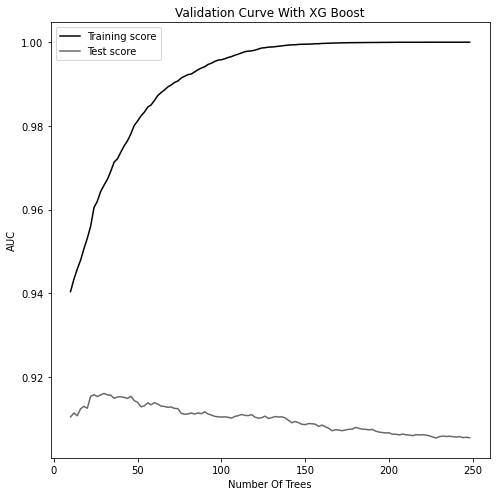

In [83]:
param_range = np.arange(10, 250, 2)
train_scores = []
test_scores = []

for i in param_range:
    xg_reg = xgb.XGBClassifier(**study2.best_params, n_estimators = i)
    xg_reg.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train,xg_reg.predict(X_train,output_margin=True)))
    test_scores.append(roc_auc_score(y_test,xg_reg.predict(X_test,output_margin=True)))

import matplotlib.pyplot as plt

plt.subplots(1, figsize = (7,7))
plt.plot(param_range, train_scores, label = "Training score", color = "black")
plt.plot(param_range, test_scores, label = "Test score", color = "dimgrey")

plt.title("Validation Curve With XG Boost")
plt.xlabel("Number Of Trees")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
    

In [84]:
model = xgb.train(study2.best_params , dtrain, num_boost_round = 600, evals = [(dtest, 'eval')],
                  
          early_stopping_rounds=100,verbose_eval = 1)

[0]	eval-rmse:0.42089
[1]	eval-rmse:0.37686
[2]	eval-rmse:0.35279
[3]	eval-rmse:0.33790
[4]	eval-rmse:0.33182
[5]	eval-rmse:0.32613
[6]	eval-rmse:0.32275
[7]	eval-rmse:0.32130
[8]	eval-rmse:0.31938
[9]	eval-rmse:0.31890
[10]	eval-rmse:0.31877
[11]	eval-rmse:0.31839
[12]	eval-rmse:0.31767
[13]	eval-rmse:0.31772
[14]	eval-rmse:0.31634
[15]	eval-rmse:0.31647
[16]	eval-rmse:0.31597
[17]	eval-rmse:0.31630
[18]	eval-rmse:0.31624
[19]	eval-rmse:0.31667
[20]	eval-rmse:0.31708
[21]	eval-rmse:0.31730
[22]	eval-rmse:0.31722
[23]	eval-rmse:0.31702
[24]	eval-rmse:0.31699
[25]	eval-rmse:0.31627
[26]	eval-rmse:0.31616
[27]	eval-rmse:0.31613
[28]	eval-rmse:0.31582
[29]	eval-rmse:0.31555
[30]	eval-rmse:0.31597
[31]	eval-rmse:0.31602
[32]	eval-rmse:0.31616
[33]	eval-rmse:0.31620
[34]	eval-rmse:0.31647
[35]	eval-rmse:0.31611
[36]	eval-rmse:0.31604
[37]	eval-rmse:0.31577
[38]	eval-rmse:0.31585
[39]	eval-rmse:0.31615
[40]	eval-rmse:0.31606
[41]	eval-rmse:0.31652
[42]	eval-rmse:0.31669
[43]	eval-rmse:0.3168

In [85]:
xgbModel = xgb.XGBClassifier(**study2.best_params, n_estimators = 20)
xgbModel.fit(X_train,y_train)

scoreTrain = xgbModel.score(X_train,y_train)
print(f"Train Accuracy: {scoreTrain}")

scoreTest = xgbModel.score(X_test,y_test)
print(f"Test Accuracy: {scoreTest}")


Train Accuracy: 0.90025
Test Accuracy: 0.866


In [86]:
print("AUC on train data: ", roc_auc_score(y_train,xgbModel.predict(X_train,output_margin=True)))
print("AUC on test data: ", roc_auc_score(y_test,xgbModel.predict(X_test,output_margin=True)))

AUC on train data:  0.9531112581011886
AUC on test data:  0.9124825193631669


In [87]:
# save the model: you must use the .json format for xgboost models!
model_savepath = 'modelXGBOFS.json'
xgbModel.save_model(model_savepath)

In [88]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath }



training auc =  0.9454670826078256
test label confidences saved in yts_hat_xgboostOptunaFS.csv
